In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [ ]:
dataset = load_dataset("dair-ai/emotion", "split")



LabelEncoder()

In [9]:
def preprocess(text):
    return text.lower().strip()

train_texts = [preprocess(x) for x in dataset['train']['text']]
val_texts = [preprocess(x) for x in dataset['validation']['text']]
train_labels = dataset['train']['label']
val_labels = dataset['validation']['label']
label_list = dataset['train'].features['label'].names

In [5]:
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")  # 384-dim embeddings

train_embeddings = sentence_model.encode(train_texts, convert_to_tensor=True)  # [N, 384]
val_embeddings = sentence_model.encode(val_texts, convert_to_tensor=True)


In [10]:
class EmotionDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings.unsqueeze(1)  # [N, 1, 384] → LMU expects sequence
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

train_dataset = EmotionDataset(train_embeddings, train_labels)
val_dataset = EmotionDataset(val_embeddings, val_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [11]:
class SimpleLMU(nn.Module):
    def __init__(self, input_size, hidden_size, memory_size, theta=100):
        super().__init__()
        self.input_to_hidden = nn.Linear(input_size, hidden_size)
        self.input_to_memory = nn.Linear(input_size, memory_size)
        self.hidden_fc = nn.Linear(hidden_size, hidden_size)

        Q = torch.arange(memory_size, dtype=torch.float32)
        R = 2 * Q + 1
        A = torch.outer(R, Q) - torch.outer(Q, R)
        B = R.unsqueeze(1)
        A = A * (1 / theta)
        B = B * (1 / theta)

        self.register_buffer('A', A)
        self.register_buffer('B', B)

    def forward(self, x):  # x: [batch, seq_len, input_size]
        batch_size, seq_len, _ = x.shape
        H = torch.zeros(batch_size, self.hidden_fc.out_features, device=x.device)
        M = torch.zeros(batch_size, self.B.size(0), device=x.device)

        outputs = []
        for t in range(seq_len):
            u_t = x[:, t, :]
            m_t = M @ self.A.T + self.input_to_memory(u_t) @ self.B  # FIXED: no transpose
            h_t = torch.tanh(self.input_to_hidden(u_t) + self.hidden_fc(H))
            H = h_t
            M = m_t.squeeze(-1)
            outputs.append(h_t.unsqueeze(1))
        return torch.cat(outputs, dim=1)  # [batch, seq_len, hidden]


In [12]:
class EmotionLMUClassifier(nn.Module):
    def __init__(self, input_dim=384, hidden_dim=128, memory_dim=64, num_classes=6):
        super().__init__()
        self.lmu = SimpleLMU(input_dim, hidden_dim, memory_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.out = nn.Linear(64, num_classes)

    def forward(self, x):  # x: [batch, seq_len=1, input_dim]
        lmu_out = self.lmu(x)             # [batch, 1, hidden]
        last_hidden = lmu_out[:, -1, :]   # take last timestep
        x = self.dropout(torch.relu(self.fc1(last_hidden)))
        return self.out(x)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionLMUClassifier(num_classes=len(label_list)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
loss_fn = nn.CrossEntropyLoss()

EPOCHS = 5

In [14]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Train Loss: {total_loss / len(train_loader):.4f}")

    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            output = model(X_batch)
            pred = torch.argmax(output, dim=1).cpu().numpy()
            preds.extend(pred)
            labels.extend(y_batch.numpy())

    acc = accuracy_score(labels, preds)
    print(f"Validation Accuracy: {acc:.4f}")


Epoch 1 | Train Loss: 1.4898
Validation Accuracy: 0.5340
Epoch 2 | Train Loss: 1.1773
Validation Accuracy: 0.6135
Epoch 3 | Train Loss: 1.0622
Validation Accuracy: 0.6210
Epoch 4 | Train Loss: 1.0041
Validation Accuracy: 0.6425
Epoch 5 | Train Loss: 0.9635
Validation Accuracy: 0.6605


T2

In [53]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm

d:\SRH\Emotion Detection Text\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [72]:
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 2e-5
SEQ_LEN = 5  # how long to simulate sequence for LMU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [65]:
dataset = load_dataset("dair-ai/emotion")

label_list = dataset["train"].features["label"].names
num_labels = len(label_list)

In [66]:
def preprocess(text):
    return text.lower().strip()

train_texts = [preprocess(x) for x in dataset["train"]["text"]]
val_texts = [preprocess(x) for x in dataset["validation"]["text"]]
train_labels = dataset["train"]["label"]
val_labels = dataset["validation"]["label"]

In [67]:
backbone = SentenceTransformer("paraphrase-MiniLM-L6-v2").to(device)
embedding_dim = backbone.get_sentence_embedding_dimension()  # 384

In [68]:
class EmotionDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_loader = DataLoader(EmotionDataset(train_texts, train_labels), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(EmotionDataset(val_texts, val_labels), batch_size=BATCH_SIZE)


In [69]:
class LMUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, memory_dim, num_classes):
        super().__init__()
        self.A = nn.Parameter(torch.eye(memory_dim), requires_grad=False)
        self.B = nn.Parameter(torch.randn(memory_dim, input_dim), requires_grad=True)

        self.input_to_memory = nn.Linear(input_dim, memory_dim)
        self.input_to_hidden = nn.Linear(input_dim, hidden_dim)
        self.hidden_fc = nn.Linear(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # 🛡️ Ensure input is 3D: [batch, seq_len, emb_dim]
        if x.dim() == 2:
            x = x.unsqueeze(1).repeat(1, SEQ_LEN, 1)

        BATCH, SEQ, _ = x.shape
        H = torch.zeros(BATCH, self.hidden_fc.out_features).to(x.device)
        M = torch.zeros(BATCH, self.B.size(0)).to(x.device)

        for t in range(SEQ):
            u_t = x[:, t]
            m_t = M @ self.A.T + self.input_to_memory(u_t)
            h_t = torch.tanh(self.input_to_hidden(u_t) + self.hidden_fc(H))
            M = m_t
            H = h_t

        return self.classifier(H)


In [14]:
model = LMUClassifier(input_dim=embedding_dim, hidden_dim=128, memory_dim=64, num_classes=num_labels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()


In [15]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for texts, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        # 🎯 Convert texts to embeddings
        embeds = backbone.encode(texts, convert_to_tensor=True).to(device)
        embeds = embeds.unsqueeze(1).repeat(1, SEQ_LEN, 1)  # simulate sequence

        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(embeds)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")
    
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for texts, labels in val_loader:
            embeds = backbone.encode(texts, convert_to_tensor=True).to(device)
            embeds = embeds.unsqueeze(1).repeat(1, SEQ_LEN, 1)

            outputs = model(embeds)
            predictions = outputs.argmax(dim=1).cpu().numpy()
            preds.extend(predictions)
            targets.extend(labels)

    acc = accuracy_score(targets, preds)
    print(f"✅ Validation Accuracy: {acc * 100:.2f}%\n")

Epoch 1/20: 100%|██████████| 250/250 [00:10<00:00, 24.37it/s]


Epoch 1 Loss: 1.6185
✅ Validation Accuracy: 50.30%



Epoch 2/20: 100%|██████████| 250/250 [00:09<00:00, 26.26it/s]


Epoch 2 Loss: 1.3561
✅ Validation Accuracy: 52.90%



Epoch 3/20: 100%|██████████| 250/250 [00:09<00:00, 25.51it/s]


Epoch 3 Loss: 1.2138
✅ Validation Accuracy: 55.45%



Epoch 4/20: 100%|██████████| 250/250 [00:09<00:00, 26.41it/s]


Epoch 4 Loss: 1.1523
✅ Validation Accuracy: 59.15%



Epoch 5/20: 100%|██████████| 250/250 [00:09<00:00, 25.36it/s]


Epoch 5 Loss: 1.1040
✅ Validation Accuracy: 60.00%



Epoch 6/20: 100%|██████████| 250/250 [00:15<00:00, 15.85it/s]


Epoch 6 Loss: 1.0645
✅ Validation Accuracy: 61.65%



Epoch 7/20: 100%|██████████| 250/250 [00:15<00:00, 16.26it/s]


Epoch 7 Loss: 1.0323
✅ Validation Accuracy: 62.20%



Epoch 8/20: 100%|██████████| 250/250 [00:15<00:00, 16.56it/s]


Epoch 8 Loss: 1.0070
✅ Validation Accuracy: 62.55%



Epoch 9/20: 100%|██████████| 250/250 [00:15<00:00, 16.01it/s]


Epoch 9 Loss: 0.9866
✅ Validation Accuracy: 62.95%



Epoch 10/20: 100%|██████████| 250/250 [00:16<00:00, 15.45it/s]


Epoch 10 Loss: 0.9697
✅ Validation Accuracy: 63.40%



Epoch 11/20: 100%|██████████| 250/250 [00:15<00:00, 16.13it/s]


Epoch 11 Loss: 0.9553
✅ Validation Accuracy: 63.90%



Epoch 12/20: 100%|██████████| 250/250 [00:15<00:00, 15.87it/s]


Epoch 12 Loss: 0.9427
✅ Validation Accuracy: 64.20%



Epoch 13/20: 100%|██████████| 250/250 [00:15<00:00, 16.21it/s]


Epoch 13 Loss: 0.9318
✅ Validation Accuracy: 64.95%



Epoch 14/20: 100%|██████████| 250/250 [00:15<00:00, 15.65it/s]


Epoch 14 Loss: 0.9213
✅ Validation Accuracy: 64.95%



Epoch 15/20: 100%|██████████| 250/250 [00:16<00:00, 15.56it/s]


Epoch 15 Loss: 0.9125
✅ Validation Accuracy: 65.70%



Epoch 16/20: 100%|██████████| 250/250 [00:16<00:00, 15.42it/s]


Epoch 16 Loss: 0.9042
✅ Validation Accuracy: 65.95%



Epoch 17/20: 100%|██████████| 250/250 [00:15<00:00, 15.69it/s]


Epoch 17 Loss: 0.8969
✅ Validation Accuracy: 65.90%



Epoch 18/20: 100%|██████████| 250/250 [00:15<00:00, 16.39it/s]


Epoch 18 Loss: 0.8902
✅ Validation Accuracy: 65.85%



Epoch 19/20: 100%|██████████| 250/250 [00:14<00:00, 16.80it/s]


Epoch 19 Loss: 0.8839
✅ Validation Accuracy: 65.90%



Epoch 20/20: 100%|██████████| 250/250 [00:14<00:00, 16.95it/s]


Epoch 20 Loss: 0.8786
✅ Validation Accuracy: 65.55%



Trail 3

In [78]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

# Load your dataset (CARER) here; for demo:
texts = ["I am happy", "I am sad", "I am angry", "Feeling excited", "Feeling bored"]
labels = ["joy", "sadness", "anger", "joy", "anger"]

# Label encode
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Dataset Class
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokens = self.tokenizer(text, padding='max_length', truncation=True,
                                return_tensors='pt', max_length=64)
        return tokens['input_ids'].squeeze(0), tokens['attention_mask'].squeeze(0), label

    def __len__(self):
        return len(self.labels)

dataset = EmotionDataset(texts, labels_encoded, tokenizer)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Compute class weights for imbalanced data
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels_encoded),
                                     y=labels_encoded)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Model with LMU-like memory simulation
class LMUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, memory_dim, num_classes):
        super().__init__()
        self.bert = bert_model
        self.memory_fc = nn.Linear(input_dim, memory_dim)
        self.hidden_fc = nn.Linear(input_dim + memory_dim, hidden_dim)
        self.residual_proj = nn.Linear(input_dim, hidden_dim)  # 🛠️ Project pooled for residual
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            
        tokens = outputs.last_hidden_state  # shape (B, T, 768)
        pooled = tokens.mean(dim=1)         # [B, 768]

        memory = self.memory_fc(pooled)     # [B, memory_dim]
        combined = torch.cat([pooled, memory], dim=1)  # [B, 768+memory_dim]

        hidden = torch.tanh(self.hidden_fc(combined))  # [B, hidden_dim]
        residual = self.residual_proj(pooled)          # 🔁 project pooled → [B, hidden_dim]
        hidden = self.norm(hidden + residual)          # ✅ match sizes before add
        hidden = self.dropout(hidden)

        return self.classifier(hidden)


# Instantiate model
model = LMUClassifier(input_dim=768, hidden_dim=256, memory_dim=128, num_classes=num_classes).to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=1,
                                            num_training_steps=len(dataloader)*5)

# Train loop
for epoch in range(5):
    model.train()
    all_preds, all_labels = [], []
    total_loss = 0

    for input_ids, attn_mask, labels in dataloader:
        input_ids, attn_mask, labels = input_ids.to(device), attn_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attn_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total_loss += loss.item()

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")


Epoch 1 | Loss: 4.3985 | Acc: 0.2000 | F1: 0.0667
Epoch 2 | Loss: 2.4115 | Acc: 0.6000 | F1: 0.5867
Epoch 3 | Loss: 2.0556 | Acc: 0.8000 | F1: 0.7200
Epoch 4 | Loss: 1.7281 | Acc: 0.8000 | F1: 0.7200
Epoch 5 | Loss: 1.0698 | Acc: 1.0000 | F1: 1.0000


Trail 4

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import numpy as np

# ============================
# 1. Load Hugging Face Dataset
# ============================
# Load Hugging Face Dataset
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names  # e.g., ['sadness', 'joy', ...]

# Use raw integer labels directly
train_texts = dataset['train']['text']
train_labels = dataset['train']['label']

val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']

# ============================
# 2. Tokenization
# ============================
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=128
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# ============================
# 3. Custom Dataset
# ============================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)

# ============================
# 4. Mean Pooling Layer
# ============================
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ============================
# 5. Classifier Model
# ============================
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(EmotionClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# ============================
# 6. Training Setup
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)
num_labels = len(label_list)

model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# ============================
# 7. Training Loop
# ============================
def train_model( epochs   ):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        preds, true = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds += torch.argmax(outputs, axis=1).tolist()
            true += labels.tolist()

        acc = accuracy_score(true, preds)
        f1 = f1_score(true, preds, average='weighted')

        print(f"Epoch {epoch+1} | Loss: {train_loss/len(train_loader):.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")

train_model(epochs=5)


Epoch 1: 100%|██████████| 500/500 [3:05:54<00:00, 22.31s/it]     


Epoch 1 | Loss: 0.4981 | Acc: 0.8186 | F1: 0.8143


Epoch 2: 100%|██████████| 500/500 [1:09:20<00:00,  8.32s/it]


Epoch 2 | Loss: 0.1375 | Acc: 0.9396 | F1: 0.9397


Epoch 3: 100%|██████████| 500/500 [1:13:11<00:00,  8.78s/it]


Epoch 3 | Loss: 0.1005 | Acc: 0.9522 | F1: 0.9522


Epoch 4: 100%|██████████| 500/500 [1:06:49<00:00,  8.02s/it]


Epoch 4 | Loss: 0.0878 | Acc: 0.9583 | F1: 0.9582


Epoch 5: 100%|██████████| 500/500 [1:06:52<00:00,  8.03s/it]

Epoch 5 | Loss: 0.0729 | Acc: 0.9639 | F1: 0.9638


In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import numpy as np

# ============================
# 1. Load Hugging Face Dataset
# ============================
# Load Hugging Face Dataset
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names  # e.g., ['sadness', 'joy', ...]

# Use raw integer labels directly
train_texts = dataset['train']['text']
train_labels = dataset['train']['label']

val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']

# ============================
# 2. Tokenization
# ============================
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=128
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# ============================
# 3. Custom Dataset
# ============================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)

# ============================
# 4. Mean Pooling Layer
# ============================
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ============================
# 5. Classifier Model
# ============================
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(EmotionClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# ============================
# 6. Training Setup
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)
num_labels = len(label_list)

model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# ============================
# 7. Training Loop
# ============================
def train_model( epochs   ):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        preds, true = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds += torch.argmax(outputs, axis=1).tolist()
            true += labels.tolist()

        acc = accuracy_score(true, preds)
        f1 = f1_score(true, preds, average='weighted')

        print(f"Epoch {epoch+1} | Loss: {train_loss/len(train_loader):.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")

train_model(epochs=10)


cuda


Epoch 1: 100%|██████████| 500/500 [02:42<00:00,  3.07it/s]


Epoch 1 | Loss: 0.4842 | Acc: 0.8264 | F1: 0.8222


Epoch 2: 100%|██████████| 500/500 [02:50<00:00,  2.93it/s]


Epoch 2 | Loss: 0.1356 | Acc: 0.9407 | F1: 0.9408


Epoch 3: 100%|██████████| 500/500 [02:49<00:00,  2.95it/s]


Epoch 3 | Loss: 0.1033 | Acc: 0.9516 | F1: 0.9516


Epoch 4: 100%|██████████| 500/500 [02:46<00:00,  3.00it/s]


Epoch 4 | Loss: 0.0836 | Acc: 0.9607 | F1: 0.9607


Epoch 5: 100%|██████████| 500/500 [02:47<00:00,  2.98it/s]


Epoch 5 | Loss: 0.0755 | Acc: 0.9647 | F1: 0.9647


Epoch 6: 100%|██████████| 500/500 [02:47<00:00,  2.98it/s]


Epoch 6 | Loss: 0.0614 | Acc: 0.9722 | F1: 0.9722


Epoch 7: 100%|██████████| 500/500 [02:47<00:00,  2.98it/s]


Epoch 7 | Loss: 0.0526 | Acc: 0.9776 | F1: 0.9776


Epoch 8: 100%|██████████| 500/500 [02:47<00:00,  2.99it/s]


Epoch 8 | Loss: 0.0427 | Acc: 0.9827 | F1: 0.9827


Epoch 9: 100%|██████████| 500/500 [02:46<00:00,  2.99it/s]


Epoch 9 | Loss: 0.0320 | Acc: 0.9878 | F1: 0.9877


Epoch 10: 100%|██████████| 500/500 [02:47<00:00,  2.98it/s]

Epoch 10 | Loss: 0.0293 | Acc: 0.9896 | F1: 0.9896



🖥️  Using device: cuda



Epoch 1: 100%|██████████| 500/500 [1:58:43<00:00, 14.25s/it]


Epoch 1:
  Train Loss: 0.4883 | Train Acc: 0.8267
  Val   Loss: 0.1651 | Val   Acc: 0.9290



Epoch 2: 100%|██████████| 500/500 [2:15:37<00:00, 16.27s/it]  


Epoch 2:
  Train Loss: 0.1419 | Train Acc: 0.9384
  Val   Loss: 0.1424 | Val   Acc: 0.9345



Epoch 3: 100%|██████████| 500/500 [1:57:11<00:00, 14.06s/it]


Epoch 3:
  Train Loss: 0.0995 | Train Acc: 0.9513
  Val   Loss: 0.1197 | Val   Acc: 0.9430



Epoch 4: 100%|██████████| 500/500 [2:15:36<00:00, 16.27s/it]  


Epoch 4:
  Train Loss: 0.0849 | Train Acc: 0.9607
  Val   Loss: 0.1437 | Val   Acc: 0.9350



Epoch 5: 100%|██████████| 500/500 [2:31:55<00:00, 18.23s/it]  


Epoch 5:
  Train Loss: 0.0738 | Train Acc: 0.9650
  Val   Loss: 0.1431 | Val   Acc: 0.9320



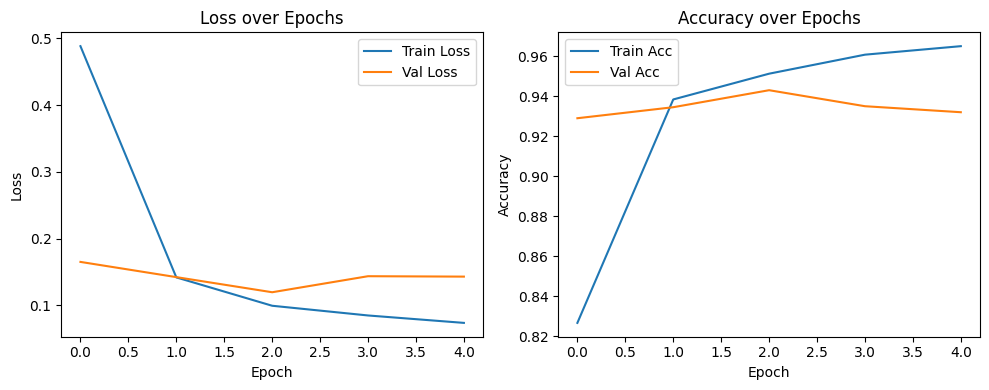

In [86]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# ====================================
# 1. Device Check
# ====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")

if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Training aborted for speed. Enable GPU in your environment.")

# ====================================
# 2. Load Dataset
# ====================================
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']

val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']

# ====================================
# 3. Tokenizer
# ====================================
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=128
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# ====================================
# 4. Dataset Class
# ====================================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)

# ====================================
# 5. Mean Pooling
# ====================================
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ====================================
# 6. Model
# ====================================
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

# ====================================
# 7. Setup
# ====================================
num_labels = len(label_list)
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# ====================================
# 8. Training + Validation Loop
# ====================================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    val_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)

            val_loss += loss.item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(target.cpu().numpy())

    acc = accuracy_score(labels, preds)
    return val_loss / len(loader), acc

def train_model(epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(target.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}:")
        print(f"  Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}\n")

# ====================================
# 9. Train
# ====================================
train_model(epochs=5)

# ====================================
# 10. Plotting
# ====================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


d:\SRH\Emotion Detection Text\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



🖥️  Using device: cuda



Epoch 1: 100%|██████████| 500/500 [02:51<00:00,  2.91it/s]



📊 Epoch 1:
  Train Loss: 0.4833 | Train Acc: 0.8233
  Val   Loss: 0.1763 | Val   Acc: 0.9220


Epoch 2: 100%|██████████| 500/500 [02:51<00:00,  2.91it/s]



📊 Epoch 2:
  Train Loss: 0.1370 | Train Acc: 0.9416
  Val   Loss: 0.1670 | Val   Acc: 0.9330


Epoch 3: 100%|██████████| 500/500 [02:51<00:00,  2.91it/s]



📊 Epoch 3:
  Train Loss: 0.1001 | Train Acc: 0.9504
  Val   Loss: 0.1289 | Val   Acc: 0.9405


Epoch 4: 100%|██████████| 500/500 [02:51<00:00,  2.91it/s]



📊 Epoch 4:
  Train Loss: 0.0822 | Train Acc: 0.9602
  Val   Loss: 0.1317 | Val   Acc: 0.9410


Epoch 5: 100%|██████████| 500/500 [02:52<00:00,  2.90it/s]



📊 Epoch 5:
  Train Loss: 0.0708 | Train Acc: 0.9656
  Val   Loss: 0.1680 | Val   Acc: 0.9335

🏆 Best Validation Accuracy: 0.9410

✅ Final Evaluation — Best Model:
   Val Loss: 0.1680 | Val Accuracy: 0.9335


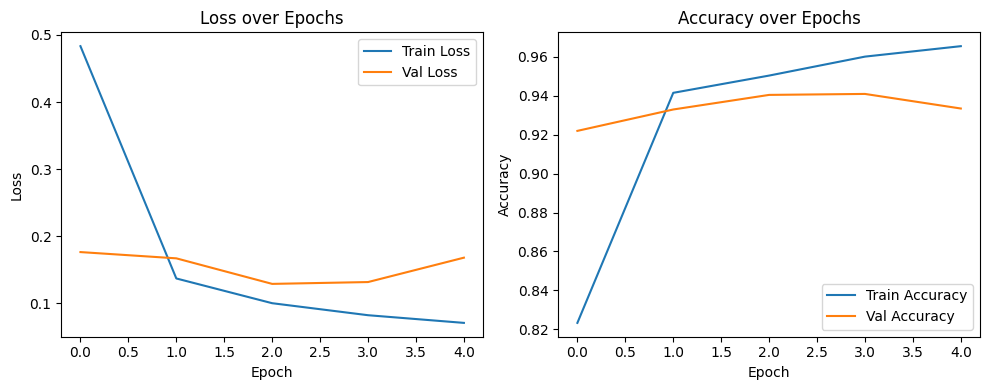

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# ====================================
# 1. Device Check
# ====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")

if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ====================================
# 2. Load Dataset
# ====================================
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']

# ====================================
# 3. Tokenization (efficient)
# ====================================
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# ====================================
# 4. Dataset Class
# ====================================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)

# ====================================
# 5. Mean Pooling Layer
# ====================================
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ====================================
# 6. Emotion Classifier
# ====================================
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

# ====================================
# 7. Setup
# ====================================
num_labels = len(label_list)
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# ====================================
# 8. Training and Validation
# ====================================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    val_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)

            val_loss += loss.item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(target.cpu().numpy())

    acc = accuracy_score(labels, preds)
    return val_loss / len(loader), acc

def train_model(epochs):
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(target.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}:")
        print(f"  Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f}")
    torch.save(best_model_state, "best_model.pt")

# ====================================
# 9. Train
# ====================================
train_model(epochs=5)

# ====================================
# 10. Load Best Model and Final Evaluation
# ====================================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
final_val_loss, final_val_acc = evaluate(val_loader)
print(f"\n✅ Final Evaluation — Best Model:\n   Val Loss: {final_val_loss:.4f} | Val Accuracy: {final_val_acc:.4f}")

# ====================================
# 11. Plotting
# ====================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()



🖥️  Using device: cuda



Epoch 1: 100%|██████████| 500/500 [04:12<00:00,  1.98it/s]



📊 Epoch 1:
  Train Loss: 1.2765 | Train Acc: 0.5381
  Val   Loss: 0.8182 | Val   Acc: 0.7225


Epoch 2: 100%|██████████| 500/500 [04:13<00:00,  1.97it/s]



📊 Epoch 2:
  Train Loss: 0.6047 | Train Acc: 0.7918
  Val   Loss: 0.3859 | Val   Acc: 0.8675


Epoch 3: 100%|██████████| 500/500 [04:13<00:00,  1.97it/s]



📊 Epoch 3:
  Train Loss: 0.3364 | Train Acc: 0.8860
  Val   Loss: 0.2681 | Val   Acc: 0.9090


Epoch 4: 100%|██████████| 500/500 [03:22<00:00,  2.47it/s]



📊 Epoch 4:
  Train Loss: 0.2325 | Train Acc: 0.9158
  Val   Loss: 0.2106 | Val   Acc: 0.9230


Epoch 5: 100%|██████████| 500/500 [03:00<00:00,  2.77it/s]



📊 Epoch 5:
  Train Loss: 0.1807 | Train Acc: 0.9291
  Val   Loss: 0.1933 | Val   Acc: 0.9290


Epoch 6: 100%|██████████| 500/500 [03:00<00:00,  2.77it/s]



📊 Epoch 6:
  Train Loss: 0.1530 | Train Acc: 0.9378
  Val   Loss: 0.1851 | Val   Acc: 0.9300


Epoch 7: 100%|██████████| 500/500 [03:00<00:00,  2.78it/s]



📊 Epoch 7:
  Train Loss: 0.1336 | Train Acc: 0.9447
  Val   Loss: 0.1747 | Val   Acc: 0.9255


Epoch 8: 100%|██████████| 500/500 [02:59<00:00,  2.78it/s]



📊 Epoch 8:
  Train Loss: 0.1186 | Train Acc: 0.9497
  Val   Loss: 0.1751 | Val   Acc: 0.9270


Epoch 9: 100%|██████████| 500/500 [02:58<00:00,  2.80it/s]



📊 Epoch 9:
  Train Loss: 0.1106 | Train Acc: 0.9524
  Val   Loss: 0.1784 | Val   Acc: 0.9265


Epoch 10: 100%|██████████| 500/500 [02:58<00:00,  2.80it/s]



📊 Epoch 10:
  Train Loss: 0.1008 | Train Acc: 0.9566
  Val   Loss: 0.1764 | Val   Acc: 0.9265

🏆 Best Validation Accuracy: 0.9300

✅ Final Evaluation — Best Model:
   Val Loss: 0.1764 | Val Accuracy: 0.9265


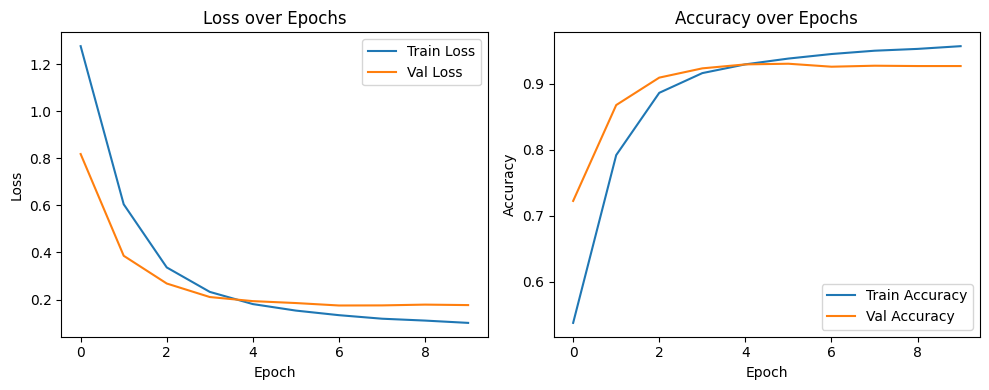

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# ====================================
# 1. Device Check
# ====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")

if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ====================================
# 2. Load Dataset
# ====================================
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']

# ====================================
# 3. Tokenization (efficient)
# ====================================
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# ====================================
# 4. Dataset Class
# ====================================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)

# ====================================
# 5. Mean Pooling Layer
# ====================================
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ====================================
# 6. Emotion Classifier
# ====================================
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

# ====================================
# 7. Setup
# ====================================
num_labels = len(label_list)
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-6)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# ====================================
# 8. Training and Validation
# ====================================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    val_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)

            val_loss += loss.item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(target.cpu().numpy())

    acc = accuracy_score(labels, preds)
    return val_loss / len(loader), acc

def train_model(epochs):
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(target.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}:")
        print(f"  Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f}")
    torch.save(best_model_state, "best_model.pt")

# ====================================
# 9. Train
# ====================================
train_model(epochs=10)

# ====================================
# 10. Load Best Model and Final Evaluation
# ====================================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
final_val_loss, final_val_acc = evaluate(val_loader)
print(f"\n✅ Final Evaluation — Best Model:\n   Val Loss: {final_val_loss:.4f} | Val Accuracy: {final_val_acc:.4f}")

# ====================================
# 11. Plotting
# ====================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Trying different lr

d:\SRH\Emotion Detection Text\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



🖥️  Using device: cuda



Epoch 1: 100%|██████████| 500/500 [03:59<00:00,  2.09it/s]



📊 Epoch 1:
  Train Loss: 0.6782 | Train Acc: 0.7546
  Val   Loss: 0.2373 | Val   Acc: 0.9160


Epoch 2: 100%|██████████| 500/500 [03:59<00:00,  2.09it/s]



📊 Epoch 2:
  Train Loss: 0.1758 | Train Acc: 0.9301
  Val   Loss: 0.1576 | Val   Acc: 0.9340


Epoch 3: 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]



📊 Epoch 3:
  Train Loss: 0.1228 | Train Acc: 0.9463
  Val   Loss: 0.1396 | Val   Acc: 0.9350


Epoch 4: 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]



📊 Epoch 4:
  Train Loss: 0.0978 | Train Acc: 0.9555
  Val   Loss: 0.1538 | Val   Acc: 0.9335


Epoch 5: 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]



📊 Epoch 5:
  Train Loss: 0.0861 | Train Acc: 0.9591
  Val   Loss: 0.1514 | Val   Acc: 0.9310


Epoch 6: 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]



📊 Epoch 6:
  Train Loss: 0.0741 | Train Acc: 0.9663
  Val   Loss: 0.1517 | Val   Acc: 0.9360


Epoch 7: 100%|██████████| 500/500 [04:08<00:00,  2.02it/s]



📊 Epoch 7:
  Train Loss: 0.0624 | Train Acc: 0.9714
  Val   Loss: 0.1699 | Val   Acc: 0.9345


Epoch 8: 100%|██████████| 500/500 [04:04<00:00,  2.05it/s]



📊 Epoch 8:
  Train Loss: 0.0527 | Train Acc: 0.9769
  Val   Loss: 0.1765 | Val   Acc: 0.9340


Epoch 9: 100%|██████████| 500/500 [03:10<00:00,  2.62it/s]



📊 Epoch 9:
  Train Loss: 0.0478 | Train Acc: 0.9804
  Val   Loss: 0.1861 | Val   Acc: 0.9380


Epoch 10: 100%|██████████| 500/500 [02:50<00:00,  2.93it/s]



📊 Epoch 10:
  Train Loss: 0.0369 | Train Acc: 0.9858
  Val   Loss: 0.2140 | Val   Acc: 0.9345

🏆 Best Validation Accuracy: 0.9380

✅ Final Evaluation — Best Model:
   Val Loss: 0.2140 | Val Accuracy: 0.9345


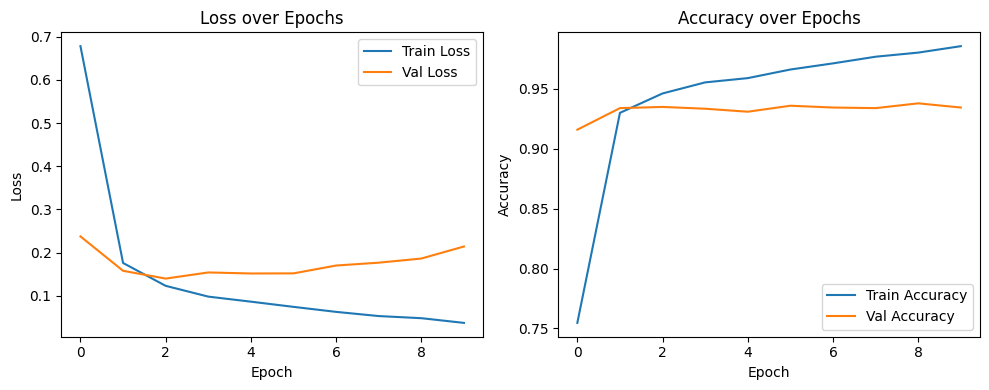

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# ====================================
# 1. Device Check
# ====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")

if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ====================================
# 2. Load Dataset
# ====================================
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']

# ====================================
# 3. Tokenization (efficient)
# ====================================
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# ====================================
# 4. Dataset Class
# ====================================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)

# ====================================
# 5. Mean Pooling Layer
# ====================================
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ====================================
# 6. Emotion Classifier
# ====================================
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

# ====================================
# 7. Setup
# ====================================
num_labels = len(label_list)
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# ====================================
# 8. Training and Validation
# ====================================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    val_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)

            val_loss += loss.item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(target.cpu().numpy())

    acc = accuracy_score(labels, preds)
    return val_loss / len(loader), acc

def train_model(epochs):
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(target.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}:")
        print(f"  Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f}")
    torch.save(best_model_state, "best_model.pt")

# ====================================
# 9. Train
# ====================================
train_model(epochs=10)

# ====================================
# 10. Load Best Model and Final Evaluation
# ====================================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
final_val_loss, final_val_acc = evaluate(val_loader)
print(f"\n✅ Final Evaluation — Best Model:\n   Val Loss: {final_val_loss:.4f} | Val Accuracy: {final_val_acc:.4f}")

# ====================================
# 11. Plotting
# ====================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Trying different Bert model


🖥️  Using device: cuda



Epoch 1: 100%|██████████| 500/500 [04:07<00:00,  2.02it/s]



📊 Epoch 1:
  Train Loss: 0.9512 | Train Acc: 0.6589
  Val   Loss: 0.5110 | Val   Acc: 0.8215


Epoch 2: 100%|██████████| 500/500 [04:10<00:00,  2.00it/s]



📊 Epoch 2:
  Train Loss: 0.3649 | Train Acc: 0.8686
  Val   Loss: 0.3089 | Val   Acc: 0.8810


Epoch 3: 100%|██████████| 500/500 [04:10<00:00,  2.00it/s]



📊 Epoch 3:
  Train Loss: 0.2293 | Train Acc: 0.9116
  Val   Loss: 0.2881 | Val   Acc: 0.8870


Epoch 4: 100%|██████████| 500/500 [03:38<00:00,  2.29it/s]



📊 Epoch 4:
  Train Loss: 0.1719 | Train Acc: 0.9296
  Val   Loss: 0.2716 | Val   Acc: 0.8965


Epoch 5: 100%|██████████| 500/500 [02:47<00:00,  2.98it/s]



📊 Epoch 5:
  Train Loss: 0.1323 | Train Acc: 0.9476
  Val   Loss: 0.3406 | Val   Acc: 0.8840


Epoch 6: 100%|██████████| 500/500 [02:49<00:00,  2.95it/s]



📊 Epoch 6:
  Train Loss: 0.1118 | Train Acc: 0.9546
  Val   Loss: 0.3355 | Val   Acc: 0.8920


Epoch 7: 100%|██████████| 500/500 [02:54<00:00,  2.86it/s]



📊 Epoch 7:
  Train Loss: 0.0830 | Train Acc: 0.9673
  Val   Loss: 0.3327 | Val   Acc: 0.8900


Epoch 8: 100%|██████████| 500/500 [02:53<00:00,  2.88it/s]



📊 Epoch 8:
  Train Loss: 0.0707 | Train Acc: 0.9721
  Val   Loss: 0.3829 | Val   Acc: 0.8920


Epoch 9: 100%|██████████| 500/500 [02:53<00:00,  2.89it/s]



📊 Epoch 9:
  Train Loss: 0.0569 | Train Acc: 0.9780
  Val   Loss: 0.3904 | Val   Acc: 0.8900


Epoch 10: 100%|██████████| 500/500 [02:49<00:00,  2.94it/s]



📊 Epoch 10:
  Train Loss: 0.0465 | Train Acc: 0.9806
  Val   Loss: 0.4538 | Val   Acc: 0.8915


Epoch 11: 100%|██████████| 500/500 [02:49<00:00,  2.94it/s]



📊 Epoch 11:
  Train Loss: 0.0360 | Train Acc: 0.9872
  Val   Loss: 0.4381 | Val   Acc: 0.8910


Epoch 12: 100%|██████████| 500/500 [02:50<00:00,  2.93it/s]



📊 Epoch 12:
  Train Loss: 0.0343 | Train Acc: 0.9874
  Val   Loss: 0.4574 | Val   Acc: 0.8925


Epoch 13: 100%|██████████| 500/500 [02:50<00:00,  2.94it/s]



📊 Epoch 13:
  Train Loss: 0.0284 | Train Acc: 0.9894
  Val   Loss: 0.4567 | Val   Acc: 0.8925


Epoch 14: 100%|██████████| 500/500 [02:50<00:00,  2.93it/s]



📊 Epoch 14:
  Train Loss: 0.0242 | Train Acc: 0.9915
  Val   Loss: 0.4616 | Val   Acc: 0.8920


Epoch 15: 100%|██████████| 500/500 [02:49<00:00,  2.95it/s]



📊 Epoch 15:
  Train Loss: 0.0210 | Train Acc: 0.9921
  Val   Loss: 0.4756 | Val   Acc: 0.8955


Epoch 16: 100%|██████████| 500/500 [02:49<00:00,  2.95it/s]



📊 Epoch 16:
  Train Loss: 0.0184 | Train Acc: 0.9932
  Val   Loss: 0.4553 | Val   Acc: 0.8975


Epoch 17: 100%|██████████| 500/500 [02:49<00:00,  2.94it/s]



📊 Epoch 17:
  Train Loss: 0.0134 | Train Acc: 0.9952
  Val   Loss: 0.4922 | Val   Acc: 0.8925


Epoch 18: 100%|██████████| 500/500 [02:49<00:00,  2.95it/s]



📊 Epoch 18:
  Train Loss: 0.0143 | Train Acc: 0.9955
  Val   Loss: 0.4797 | Val   Acc: 0.8940


Epoch 19: 100%|██████████| 500/500 [02:49<00:00,  2.95it/s]



📊 Epoch 19:
  Train Loss: 0.0117 | Train Acc: 0.9958
  Val   Loss: 0.4706 | Val   Acc: 0.8940


Epoch 20: 100%|██████████| 500/500 [02:49<00:00,  2.94it/s]



📊 Epoch 20:
  Train Loss: 0.0094 | Train Acc: 0.9964
  Val   Loss: 0.4717 | Val   Acc: 0.8915

🏆 Best Validation Accuracy: 0.8975

✅ Final Evaluation — Best Model:
   Val Loss: 0.4717 | Val Accuracy: 0.8915


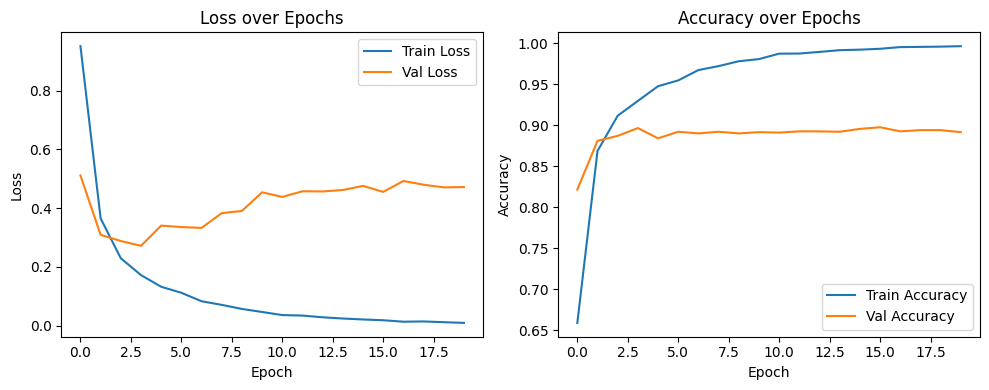

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# ====================================
# 1. Device Check
# ====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")

if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ====================================
# 2. Load Dataset
# ====================================
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']

# ====================================
# 3. Tokenization (efficient)
# ====================================
# model_name = "j-hartmann/emotion-english-distilroberta-base"
# model_name = "cardiffnlp/twitter-roberta-base-emotion-multilabel-latest"
model_name = "bhadresh-savani/bert-base-go-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# ====================================
# 4. Dataset Class
# ====================================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)


# ====================================
# 5. Mean Pooling Layer
# ====================================
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ====================================
# 6. Emotion Classifier
# ====================================
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

# ====================================
# 7. Setup
# ====================================
epochs = 20
num_labels = len(label_list)
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
from transformers import get_scheduler
scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * epochs
)
criterion = nn.CrossEntropyLoss()



# ====================================
# 8. Training and Validation
# ====================================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    val_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)

            val_loss += loss.item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(target.cpu().numpy())

    acc = accuracy_score(labels, preds)
    return val_loss / len(loader), acc

def train_model(epochs):
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(target.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}:")
        print(f"  Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f}")
    torch.save(best_model_state, "best_model.pt")

# ====================================
# 9. Train
# ====================================
train_model(epochs)

# ====================================
# 10. Load Best Model and Final Evaluation
# ====================================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
final_val_loss, final_val_acc = evaluate(val_loader)
print(f"\n✅ Final Evaluation — Best Model:\n   Val Loss: {final_val_loss:.4f} | Val Accuracy: {final_val_acc:.4f}")

# ====================================
# 11. Plotting
# ====================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()



🖥️  Using device: cuda



Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion-multilabel-latest and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 500/500 [02:53<00:00,  2.88it/s]



📊 Epoch 1:
  Train Loss: 0.4633 | Train Acc: 0.8382
  Val   Loss: 0.2334 | Val   Acc: 0.9125


Epoch 2: 100%|██████████| 500/500 [02:54<00:00,  2.86it/s]



📊 Epoch 2:
  Train Loss: 0.1733 | Train Acc: 0.9282
  Val   Loss: 0.1712 | Val   Acc: 0.9265


Epoch 3: 100%|██████████| 500/500 [02:54<00:00,  2.86it/s]



📊 Epoch 3:
  Train Loss: 0.1223 | Train Acc: 0.9432
  Val   Loss: 0.1610 | Val   Acc: 0.9335


Epoch 4: 100%|██████████| 500/500 [02:53<00:00,  2.87it/s]



📊 Epoch 4:
  Train Loss: 0.1027 | Train Acc: 0.9500
  Val   Loss: 0.1375 | Val   Acc: 0.9365


Epoch 5: 100%|██████████| 500/500 [02:51<00:00,  2.91it/s]



📊 Epoch 5:
  Train Loss: 0.0892 | Train Acc: 0.9490
  Val   Loss: 0.1351 | Val   Acc: 0.9410


Epoch 6: 100%|██████████| 500/500 [02:52<00:00,  2.91it/s]



📊 Epoch 6:
  Train Loss: 0.0835 | Train Acc: 0.9562
  Val   Loss: 0.1516 | Val   Acc: 0.9355


Epoch 7: 100%|██████████| 500/500 [02:52<00:00,  2.90it/s]



📊 Epoch 7:
  Train Loss: 0.0798 | Train Acc: 0.9566
  Val   Loss: 0.1234 | Val   Acc: 0.9400


Epoch 8: 100%|██████████| 500/500 [02:52<00:00,  2.90it/s]



📊 Epoch 8:
  Train Loss: 0.0738 | Train Acc: 0.9607
  Val   Loss: 0.1539 | Val   Acc: 0.9365


Epoch 9: 100%|██████████| 500/500 [02:52<00:00,  2.90it/s]



📊 Epoch 9:
  Train Loss: 0.0674 | Train Acc: 0.9645
  Val   Loss: 0.1518 | Val   Acc: 0.9430


Epoch 10: 100%|██████████| 500/500 [02:52<00:00,  2.90it/s]



📊 Epoch 10:
  Train Loss: 0.0643 | Train Acc: 0.9672
  Val   Loss: 0.1735 | Val   Acc: 0.9385


Epoch 11: 100%|██████████| 500/500 [02:52<00:00,  2.90it/s]



📊 Epoch 11:
  Train Loss: 0.0595 | Train Acc: 0.9691
  Val   Loss: 0.1551 | Val   Acc: 0.9385


Epoch 12: 100%|██████████| 500/500 [02:52<00:00,  2.90it/s]



📊 Epoch 12:
  Train Loss: 0.0543 | Train Acc: 0.9728
  Val   Loss: 0.1610 | Val   Acc: 0.9405


Epoch 13: 100%|██████████| 500/500 [02:51<00:00,  2.92it/s]



📊 Epoch 13:
  Train Loss: 0.0485 | Train Acc: 0.9759
  Val   Loss: 0.1744 | Val   Acc: 0.9390


Epoch 14: 100%|██████████| 500/500 [02:52<00:00,  2.90it/s]



📊 Epoch 14:
  Train Loss: 0.0439 | Train Acc: 0.9792
  Val   Loss: 0.1923 | Val   Acc: 0.9340


Epoch 15: 100%|██████████| 500/500 [02:52<00:00,  2.90it/s]



📊 Epoch 15:
  Train Loss: 0.0353 | Train Acc: 0.9831
  Val   Loss: 0.2159 | Val   Acc: 0.9330


Epoch 16: 100%|██████████| 500/500 [02:52<00:00,  2.90it/s]



📊 Epoch 16:
  Train Loss: 0.0328 | Train Acc: 0.9847
  Val   Loss: 0.2246 | Val   Acc: 0.9360


Epoch 17: 100%|██████████| 500/500 [02:52<00:00,  2.90it/s]



📊 Epoch 17:
  Train Loss: 0.0288 | Train Acc: 0.9873
  Val   Loss: 0.2380 | Val   Acc: 0.9360


Epoch 18: 100%|██████████| 500/500 [02:52<00:00,  2.90it/s]



📊 Epoch 18:
  Train Loss: 0.0236 | Train Acc: 0.9898
  Val   Loss: 0.2489 | Val   Acc: 0.9370


Epoch 19: 100%|██████████| 500/500 [02:52<00:00,  2.90it/s]



📊 Epoch 19:
  Train Loss: 0.0223 | Train Acc: 0.9908
  Val   Loss: 0.2520 | Val   Acc: 0.9385


Epoch 20: 100%|██████████| 500/500 [02:52<00:00,  2.91it/s]



📊 Epoch 20:
  Train Loss: 0.0202 | Train Acc: 0.9917
  Val   Loss: 0.2490 | Val   Acc: 0.9365

🏆 Best Validation Accuracy: 0.9430

✅ Final Evaluation — Best Model:
   Val Loss: 0.2490 | Val Accuracy: 0.9365


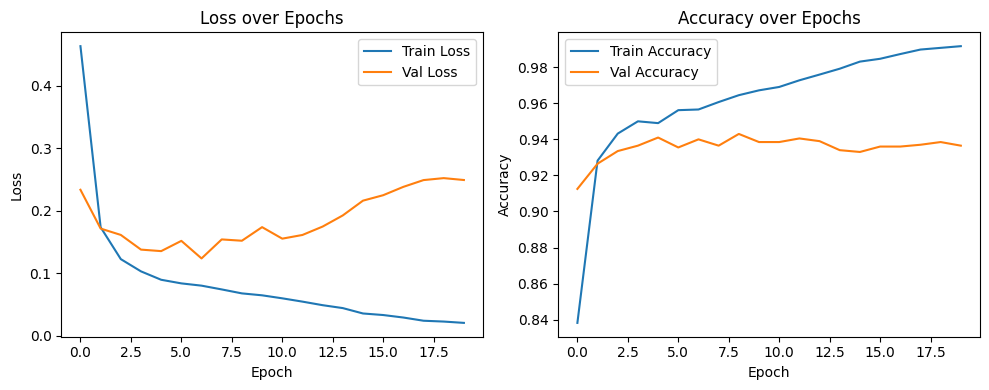

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# ====================================
# 1. Device Check
# ====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")

if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ====================================
# 2. Load Dataset
# ====================================
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']

# ====================================
# 3. Tokenization (efficient)
# ====================================
# model_name = "j-hartmann/emotion-english-distilroberta-base"
model_name = "cardiffnlp/twitter-roberta-base-emotion-multilabel-latest"
# model_name = "bhadresh-savani/bert-base-go-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# ====================================
# 4. Dataset Class
# ====================================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)


# ====================================
# 5. Mean Pooling Layer
# ====================================
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ====================================
# 6. Emotion Classifier
# ====================================
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

# ====================================
# 7. Setup
# ====================================
epochs = 20
num_labels = len(label_list)
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
from transformers import get_scheduler
scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * epochs
)
criterion = nn.CrossEntropyLoss()



# ====================================
# 8. Training and Validation
# ====================================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    val_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)

            val_loss += loss.item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(target.cpu().numpy())

    acc = accuracy_score(labels, preds)
    return val_loss / len(loader), acc

def train_model(epochs):
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(target.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}:")
        print(f"  Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f}")
    torch.save(best_model_state, "best_model.pt")

# ====================================
# 9. Train
# ====================================
train_model(epochs)

# ====================================
# 10. Load Best Model and Final Evaluation
# ====================================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
final_val_loss, final_val_acc = evaluate(val_loader)
print(f"\n✅ Final Evaluation — Best Model:\n   Val Loss: {final_val_loss:.4f} | Val Accuracy: {final_val_acc:.4f}")

# ====================================
# 11. Plotting
# ====================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()



🖥️  Using device: cuda



Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 500/500 [01:32<00:00,  5.42it/s]



📊 Epoch 1:
  Train Loss: 0.3292 | Train Acc: 0.8864
  Val   Loss: 0.1621 | Val   Acc: 0.9290


Epoch 2: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 2:
  Train Loss: 0.1481 | Train Acc: 0.9372
  Val   Loss: 0.1543 | Val   Acc: 0.9365


Epoch 3: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 3:
  Train Loss: 0.1141 | Train Acc: 0.9471
  Val   Loss: 0.1312 | Val   Acc: 0.9345


Epoch 4: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 4:
  Train Loss: 0.0950 | Train Acc: 0.9531
  Val   Loss: 0.1233 | Val   Acc: 0.9435


Epoch 5: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 5:
  Train Loss: 0.0873 | Train Acc: 0.9566
  Val   Loss: 0.1223 | Val   Acc: 0.9400


Epoch 6: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 6:
  Train Loss: 0.0745 | Train Acc: 0.9630
  Val   Loss: 0.1203 | Val   Acc: 0.9435


Epoch 7: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 7:
  Train Loss: 0.0690 | Train Acc: 0.9656
  Val   Loss: 0.1361 | Val   Acc: 0.9365


Epoch 8: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 8:
  Train Loss: 0.0650 | Train Acc: 0.9692
  Val   Loss: 0.1426 | Val   Acc: 0.9420


Epoch 9: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 9:
  Train Loss: 0.0570 | Train Acc: 0.9730
  Val   Loss: 0.1443 | Val   Acc: 0.9405


Epoch 10: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 10:
  Train Loss: 0.0521 | Train Acc: 0.9762
  Val   Loss: 0.1481 | Val   Acc: 0.9345


Epoch 11: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 11:
  Train Loss: 0.0478 | Train Acc: 0.9788
  Val   Loss: 0.1686 | Val   Acc: 0.9390


Epoch 12: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 12:
  Train Loss: 0.0411 | Train Acc: 0.9810
  Val   Loss: 0.1861 | Val   Acc: 0.9350


Epoch 13: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 13:
  Train Loss: 0.0362 | Train Acc: 0.9840
  Val   Loss: 0.1768 | Val   Acc: 0.9395


Epoch 14: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 14:
  Train Loss: 0.0323 | Train Acc: 0.9865
  Val   Loss: 0.1830 | Val   Acc: 0.9445


Epoch 15: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 15:
  Train Loss: 0.0274 | Train Acc: 0.9881
  Val   Loss: 0.1812 | Val   Acc: 0.9375


Epoch 16: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 16:
  Train Loss: 0.0251 | Train Acc: 0.9894
  Val   Loss: 0.2011 | Val   Acc: 0.9375


Epoch 17: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 17:
  Train Loss: 0.0221 | Train Acc: 0.9920
  Val   Loss: 0.1976 | Val   Acc: 0.9370


Epoch 18: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 18:
  Train Loss: 0.0187 | Train Acc: 0.9925
  Val   Loss: 0.2112 | Val   Acc: 0.9385


Epoch 19: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 19:
  Train Loss: 0.0183 | Train Acc: 0.9929
  Val   Loss: 0.2060 | Val   Acc: 0.9390


Epoch 20: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 20:
  Train Loss: 0.0181 | Train Acc: 0.9923
  Val   Loss: 0.2083 | Val   Acc: 0.9390

🏆 Best Validation Accuracy: 0.9445

✅ Final Evaluation — Best Model:
   Val Loss: 0.2083 | Val Accuracy: 0.9390


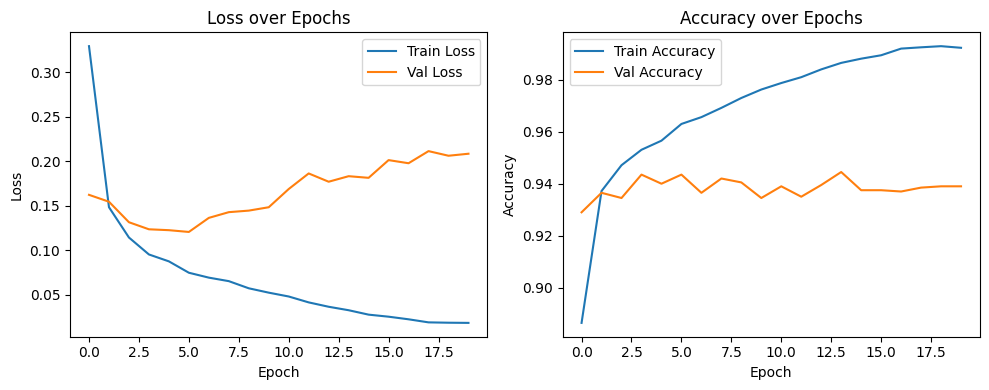

In [ ]:
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, Dataset
    from transformers import AutoTokenizer, AutoModel
    from datasets import load_dataset
    from sklearn.metrics import accuracy_score, f1_score
    from tqdm import tqdm
    import matplotlib.pyplot as plt

    # ====================================
    # 1. Device Check
    # ====================================
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n🖥️  Using device: {device}\n")

    if device.type != 'cuda':
        raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

    # ====================================
    # 2. Load Dataset
    # ====================================
    dataset = load_dataset("dair-ai/emotion", "split")
    label_list = dataset['train'].features['label'].names

    train_texts = dataset['train']['text']
    train_labels = dataset['train']['label']
    val_texts = dataset['validation']['text']
    val_labels = dataset['validation']['label']

    # ====================================
    # 3. Tokenization (efficient)
    # ====================================
    model_name = "j-hartmann/emotion-english-distilroberta-base"
    # model_name = "cardiffnlp/twitter-roberta-base-emotion-multilabel-latest"
    # model_name = "bhadresh-savani/bert-base-go-emotion"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize(texts):
        return tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=128
        )

    train_encodings = tokenize(train_texts)
    val_encodings = tokenize(val_texts)

    # ====================================
    # 4. Dataset Class
    # ====================================
    class EmotionDataset(Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __len__(self):
            return len(self.labels)

        def __getitem__(self, idx):
            return {
                'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
                'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
                'labels': torch.tensor(self.labels[idx])
            }

    train_dataset = EmotionDataset(train_encodings, train_labels)
    val_dataset = EmotionDataset(val_encodings, val_labels)


    # ====================================
    # 5. Mean Pooling Layer
    # ====================================
    class MeanPooling(nn.Module):
        def __init__(self):
            super().__init__()

        def forward(self, last_hidden_state, attention_mask):
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
            sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            return sum_embeddings / sum_mask

    # ====================================
    # 6. Emotion Classifier
    # ====================================
    class EmotionClassifier(nn.Module):
        def __init__(self, model_name, num_labels):
            super().__init__()
            self.bert = AutoModel.from_pretrained(model_name)
            self.pooler = MeanPooling()
            self.dropout = nn.Dropout(0.3)
            self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

        def forward(self, input_ids, attention_mask):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
            pooled_output = self.dropout(pooled_output)
            return self.classifier(pooled_output)

    # ====================================
    # 7. Setup
    # ====================================
    epochs = 20
    num_labels = len(label_list)
    model = EmotionClassifier(model_name, num_labels).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    from transformers import get_scheduler
    scheduler = get_scheduler(
        "linear", optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=len(train_loader) * epochs
    )
    criterion = nn.CrossEntropyLoss()



    # ====================================
    # 8. Training and Validation
    # ====================================
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    def evaluate(loader):
        model.eval()
        val_loss = 0
        preds, labels = [], []

        with torch.no_grad():
            for batch in loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                target = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, target)

                val_loss += loss.item()
                preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                labels.extend(target.cpu().numpy())

        acc = accuracy_score(labels, preds)
        return val_loss / len(loader), acc

    def train_model(epochs):
        best_val_acc = 0.0
        best_model_state = None

        for epoch in range(epochs):
            model.train()
            total_loss = 0
            all_preds = []
            all_labels = []

            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                target = batch['labels'].to(device)

                optimizer.zero_grad()
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, target)
                loss.backward()
                optimizer.step()
                scheduler.step()
                total_loss += loss.item()
                all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                all_labels.extend(target.cpu().numpy())

            train_acc = accuracy_score(all_labels, all_preds)
            val_loss, val_acc = evaluate(val_loader)

            train_losses.append(total_loss / len(train_loader))
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)

            print(f"\n📊 Epoch {epoch+1}:")
            print(f"  Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f}")
            print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict()

        print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f}")
        torch.save(best_model_state, "best_model.pt")

    # ====================================
    # 9. Train
    # ====================================
    train_model(epochs)

    # ====================================
    # 10. Load Best Model and Final Evaluation
    # ====================================
    model.load_state_dict(torch.load("best_model.pt"))
    model.eval()
    final_val_loss, final_val_acc = evaluate(val_loader)
    print(f"\n✅ Final Evaluation — Best Model:\n   Val Loss: {final_val_loss:.4f} | Val Accuracy: {final_val_acc:.4f}")

    # ====================================
    # 11. Plotting
    # ====================================
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [5]:
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, Dataset
    from transformers import AutoTokenizer, AutoModel
    from datasets import load_dataset
    from sklearn.metrics import accuracy_score, f1_score
    from tqdm import tqdm
    import matplotlib.pyplot as plt

    # ====================================
    # 1. Device Check
    # ====================================
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n🖥️  Using device: {device}\n")

    if device.type != 'cuda':
        raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

    # ====================================
    # 2. Load Dataset
    # ====================================
    dataset = load_dataset("dair-ai/emotion", "split")
    label_list = dataset['train'].features['label'].names

    train_texts = dataset['train']['text']
    train_labels = dataset['train']['label']
    val_texts = dataset['validation']['text']
    val_labels = dataset['validation']['label']

    # ====================================
    # 3. Tokenization (efficient)
    # ====================================
    model_name = "mrm8488/t5-base-finetuned-emotion"
    # model_name = "cardiffnlp/twitter-roberta-base-emotion-multilabel-latest"
    # model_name = "bhadresh-savani/bert-base-go-emotion"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize(texts):
        return tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=128
        )

    train_encodings = tokenize(train_texts)
    val_encodings = tokenize(val_texts)

    # ====================================
    # 4. Dataset Class
    # ====================================
    class EmotionDataset(Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __len__(self):
            return len(self.labels)

        def __getitem__(self, idx):
            return {
                'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
                'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
                'labels': torch.tensor(self.labels[idx])
            }

    train_dataset = EmotionDataset(train_encodings, train_labels)
    val_dataset = EmotionDataset(val_encodings, val_labels)


    # ====================================
    # 5. Mean Pooling Layer
    # ====================================
    class MeanPooling(nn.Module):
        def __init__(self):
            super().__init__()

        def forward(self, last_hidden_state, attention_mask):
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
            sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            return sum_embeddings / sum_mask

    # ====================================
    # 6. Emotion Classifier
    # ====================================
    class EmotionClassifier(nn.Module):
        def __init__(self, model_name, num_labels):
            super().__init__()
            self.bert = AutoModel.from_pretrained(model_name)
            self.pooler = MeanPooling()
            self.dropout = nn.Dropout(0.3)
            self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

        def forward(self, input_ids, attention_mask):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
            pooled_output = self.dropout(pooled_output)
            return self.classifier(pooled_output)

    # ====================================
    # 7. Setup
    # ====================================
    epochs = 20
    num_labels = len(label_list)
    model = EmotionClassifier(model_name, num_labels).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    from transformers import get_scheduler
    scheduler = get_scheduler(
        "linear", optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=len(train_loader) * epochs
    )
    criterion = nn.CrossEntropyLoss()



    # ====================================
    # 8. Training and Validation
    # ====================================
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    def evaluate(loader):
        model.eval()
        val_loss = 0
        preds, labels = [], []

        with torch.no_grad():
            for batch in loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                target = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, target)

                val_loss += loss.item()
                preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                labels.extend(target.cpu().numpy())

        acc = accuracy_score(labels, preds)
        return val_loss / len(loader), acc

    def train_model(epochs):
        best_val_acc = 0.0
        best_model_state = None

        for epoch in range(epochs):
            model.train()
            total_loss = 0
            all_preds = []
            all_labels = []

            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                target = batch['labels'].to(device)

                optimizer.zero_grad()
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, target)
                loss.backward()
                optimizer.step()
                scheduler.step()
                total_loss += loss.item()
                all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                all_labels.extend(target.cpu().numpy())

            train_acc = accuracy_score(all_labels, all_preds)
            val_loss, val_acc = evaluate(val_loader)

            train_losses.append(total_loss / len(train_loader))
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)

            print(f"\n📊 Epoch {epoch+1}:")
            print(f"  Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f}")
            print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict()

        print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f}")
        torch.save(best_model_state, "best_model.pt")

    # ====================================
    # 9. Train
    # ====================================
    train_model(epochs)

    # ====================================
    # 10. Load Best Model and Final Evaluation
    # ====================================
    model.load_state_dict(torch.load("best_model.pt"))
    model.eval()
    final_val_loss, final_val_acc = evaluate(val_loader)
    print(f"\n✅ Final Evaluation — Best Model:\n   Val Loss: {final_val_loss:.4f} | Val Accuracy: {final_val_acc:.4f}")

    # ====================================
    # 11. Plotting
    # ====================================
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()



🖥️  Using device: cuda



d:\SRH\Emotion Detection Text\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\anavn\.cache\huggingface\hub\models--mrm8488--t5-base-finetuned-emotion. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


ValueError: Converting from SentencePiece and Tiktoken failed, if a converter for SentencePiece is available, provide a model path with a SentencePiece tokenizer.model file.Currently available slow->fast converters: ['AlbertTokenizer', 'BartTokenizer', 'BarthezTokenizer', 'BertTokenizer', 'BigBirdTokenizer', 'BlenderbotTokenizer', 'CamembertTokenizer', 'CLIPTokenizer', 'CodeGenTokenizer', 'ConvBertTokenizer', 'DebertaTokenizer', 'DebertaV2Tokenizer', 'DistilBertTokenizer', 'DPRReaderTokenizer', 'DPRQuestionEncoderTokenizer', 'DPRContextEncoderTokenizer', 'ElectraTokenizer', 'FNetTokenizer', 'FunnelTokenizer', 'GPT2Tokenizer', 'HerbertTokenizer', 'LayoutLMTokenizer', 'LayoutLMv2Tokenizer', 'LayoutLMv3Tokenizer', 'LayoutXLMTokenizer', 'LongformerTokenizer', 'LEDTokenizer', 'LxmertTokenizer', 'MarkupLMTokenizer', 'MBartTokenizer', 'MBart50Tokenizer', 'MPNetTokenizer', 'MobileBertTokenizer', 'MvpTokenizer', 'NllbTokenizer', 'OpenAIGPTTokenizer', 'PegasusTokenizer', 'Qwen2Tokenizer', 'RealmTokenizer', 'ReformerTokenizer', 'RemBertTokenizer', 'RetriBertTokenizer', 'RobertaTokenizer', 'RoFormerTokenizer', 'SeamlessM4TTokenizer', 'SqueezeBertTokenizer', 'T5Tokenizer', 'UdopTokenizer', 'WhisperTokenizer', 'XLMRobertaTokenizer', 'XLNetTokenizer', 'SplinterTokenizer', 'XGLMTokenizer', 'LlamaTokenizer', 'CodeLlamaTokenizer', 'GemmaTokenizer', 'Phi3Tokenizer']


🖥️  Using device: cuda



Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion-multilabel-latest and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 500/500 [03:57<00:00,  2.11it/s]



📊 Epoch 1:
  Train Loss: 0.4682 | Train Acc: 0.8324
  Val   Loss: 0.1940 | Val   Acc: 0.9190


Epoch 2: 100%|██████████| 500/500 [03:59<00:00,  2.09it/s]



📊 Epoch 2:
  Train Loss: 0.1685 | Train Acc: 0.9297
  Val   Loss: 0.1572 | Val   Acc: 0.9340


Epoch 3: 100%|██████████| 500/500 [03:58<00:00,  2.09it/s]



📊 Epoch 3:
  Train Loss: 0.1214 | Train Acc: 0.9430
  Val   Loss: 0.1458 | Val   Acc: 0.9300


Epoch 4: 100%|██████████| 500/500 [03:58<00:00,  2.10it/s]



📊 Epoch 4:
  Train Loss: 0.1062 | Train Acc: 0.9458
  Val   Loss: 0.1469 | Val   Acc: 0.9355


Epoch 5: 100%|██████████| 500/500 [03:57<00:00,  2.10it/s]



📊 Epoch 5:
  Train Loss: 0.0906 | Train Acc: 0.9517
  Val   Loss: 0.1558 | Val   Acc: 0.9340


Epoch 6: 100%|██████████| 500/500 [03:59<00:00,  2.09it/s]



📊 Epoch 6:
  Train Loss: 0.0842 | Train Acc: 0.9529
  Val   Loss: 0.1472 | Val   Acc: 0.9325


Epoch 7: 100%|██████████| 500/500 [03:58<00:00,  2.09it/s]



📊 Epoch 7:
  Train Loss: 0.0790 | Train Acc: 0.9566
  Val   Loss: 0.1552 | Val   Acc: 0.9400


Epoch 8: 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]



📊 Epoch 8:
  Train Loss: 0.0781 | Train Acc: 0.9567
  Val   Loss: 0.1634 | Val   Acc: 0.9345


Epoch 9: 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]



📊 Epoch 9:
  Train Loss: 0.0686 | Train Acc: 0.9634
  Val   Loss: 0.1568 | Val   Acc: 0.9365


Epoch 10: 100%|██████████| 500/500 [03:09<00:00,  2.63it/s]



📊 Epoch 10:
  Train Loss: 0.0663 | Train Acc: 0.9651
  Val   Loss: 0.1749 | Val   Acc: 0.9330


Epoch 11: 100%|██████████| 500/500 [02:54<00:00,  2.87it/s]



📊 Epoch 11:
  Train Loss: 0.0594 | Train Acc: 0.9693
  Val   Loss: 0.1679 | Val   Acc: 0.9350


Epoch 12: 100%|██████████| 500/500 [02:55<00:00,  2.85it/s]



📊 Epoch 12:
  Train Loss: 0.0533 | Train Acc: 0.9729
  Val   Loss: 0.1962 | Val   Acc: 0.9365


Epoch 13: 100%|██████████| 500/500 [02:57<00:00,  2.82it/s]



📊 Epoch 13:
  Train Loss: 0.0504 | Train Acc: 0.9756
  Val   Loss: 0.1801 | Val   Acc: 0.9340


Epoch 14: 100%|██████████| 500/500 [02:58<00:00,  2.80it/s]



📊 Epoch 14:
  Train Loss: 0.0466 | Train Acc: 0.9783
  Val   Loss: 0.1959 | Val   Acc: 0.9355


Epoch 15: 100%|██████████| 500/500 [02:57<00:00,  2.82it/s]



📊 Epoch 15:
  Train Loss: 0.0411 | Train Acc: 0.9809
  Val   Loss: 0.1967 | Val   Acc: 0.9365


Epoch 16: 100%|██████████| 500/500 [02:58<00:00,  2.79it/s]



📊 Epoch 16:
  Train Loss: 0.0340 | Train Acc: 0.9843
  Val   Loss: 0.2108 | Val   Acc: 0.9330


Epoch 17: 100%|██████████| 500/500 [03:00<00:00,  2.76it/s]



📊 Epoch 17:
  Train Loss: 0.0293 | Train Acc: 0.9874
  Val   Loss: 0.2253 | Val   Acc: 0.9375


Epoch 18: 100%|██████████| 500/500 [02:58<00:00,  2.80it/s]



📊 Epoch 18:
  Train Loss: 0.0252 | Train Acc: 0.9895
  Val   Loss: 0.2395 | Val   Acc: 0.9345


Epoch 19: 100%|██████████| 500/500 [02:57<00:00,  2.82it/s]



📊 Epoch 19:
  Train Loss: 0.0230 | Train Acc: 0.9901
  Val   Loss: 0.2404 | Val   Acc: 0.9335


Epoch 20: 100%|██████████| 500/500 [02:57<00:00,  2.82it/s]



📊 Epoch 20:
  Train Loss: 0.0199 | Train Acc: 0.9910
  Val   Loss: 0.2431 | Val   Acc: 0.9320

🏆 Best Validation Accuracy: 0.9400

✅ Final Evaluation — Best Model:
   Val Loss: 0.2431 | Val Accuracy: 0.9320


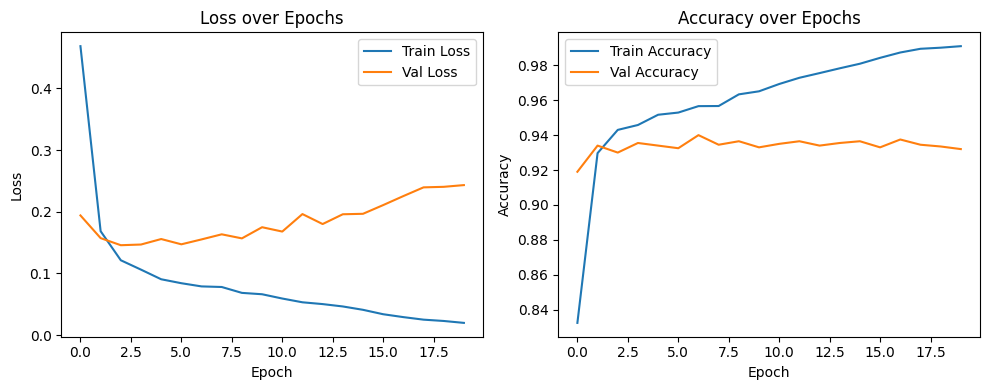

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# ====================================
# 1. Device Check
# ====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")

if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ====================================
# 2. Load Dataset
# ====================================
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']

# ====================================
# 3. Tokenization (efficient)
# ====================================
model_name = "cardiffnlp/twitter-roberta-base-emotion-multilabel-latest"
# model_name = "cardiffnlp/twitter-roberta-base-emotion-multilabel-latest"
# model_name = "bhadresh-savani/bert-base-go-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# ====================================
# 4. Dataset Class
# ====================================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)


# ====================================
# 5. Mean Pooling Layer
# ====================================
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ====================================
# 6. Emotion Classifier
# ====================================
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

# ====================================
# 7. Setup
# ====================================
epochs = 20
num_labels = len(label_list)
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
from transformers import get_scheduler
scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * epochs
)
criterion = nn.CrossEntropyLoss()



# ====================================
# 8. Training and Validation
# ====================================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    val_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)

            val_loss += loss.item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(target.cpu().numpy())

    acc = accuracy_score(labels, preds)
    return val_loss / len(loader), acc

def train_model(epochs):
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(target.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}:")
        print(f"  Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f}")
    torch.save(best_model_state, "best_model.pt")

# ====================================
# 9. Train
# ====================================
train_model(epochs)

# ====================================
# 10. Load Best Model and Final Evaluation
# ====================================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
final_val_loss, final_val_acc = evaluate(val_loader)
print(f"\n✅ Final Evaluation — Best Model:\n   Val Loss: {final_val_loss:.4f} | Val Accuracy: {final_val_acc:.4f}")

# ====================================
# 11. Plotting
# ====================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()



🖥️  Using device: cuda



d:\SRH\Emotion Detection Text\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\anavn\.cache\huggingface\hub\models--joeddav--distilbert-base-uncased-go-emotions-student. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Epoch 1: 100%|██████████| 500/500 [01:28<00:00,  5.62it/s]



📊 Epoch 1:
  Train Loss: 0.4359 | Train Acc: 0.8457
  Val   Loss: 0.2074 | Val   Acc: 0.9175


Epoch 2: 100%|██████████| 500/500 [01:29<00:00,  5.61it/s]



📊 Epoch 2:
  Train Loss: 0.1461 | Train Acc: 0.9404
  Val   Loss: 0.1569 | Val   Acc: 0.9325


Epoch 3: 100%|██████████| 500/500 [01:30<00:00,  5.55it/s]



📊 Epoch 3:
  Train Loss: 0.1026 | Train Acc: 0.9534
  Val   Loss: 0.1543 | Val   Acc: 0.9315


Epoch 4: 100%|██████████| 500/500 [01:29<00:00,  5.58it/s]



📊 Epoch 4:
  Train Loss: 0.0805 | Train Acc: 0.9623
  Val   Loss: 0.1690 | Val   Acc: 0.9335


Epoch 5: 100%|██████████| 500/500 [01:29<00:00,  5.59it/s]



📊 Epoch 5:
  Train Loss: 0.0631 | Train Acc: 0.9706
  Val   Loss: 0.1685 | Val   Acc: 0.9300


Epoch 6: 100%|██████████| 500/500 [01:30<00:00,  5.54it/s]



📊 Epoch 6:
  Train Loss: 0.0521 | Train Acc: 0.9774
  Val   Loss: 0.1866 | Val   Acc: 0.9290


Epoch 7: 100%|██████████| 500/500 [01:29<00:00,  5.58it/s]



📊 Epoch 7:
  Train Loss: 0.0417 | Train Acc: 0.9835
  Val   Loss: 0.2105 | Val   Acc: 0.9315


Epoch 8: 100%|██████████| 500/500 [01:29<00:00,  5.58it/s]



📊 Epoch 8:
  Train Loss: 0.0305 | Train Acc: 0.9880
  Val   Loss: 0.2178 | Val   Acc: 0.9315


Epoch 9: 100%|██████████| 500/500 [01:29<00:00,  5.56it/s]



📊 Epoch 9:
  Train Loss: 0.0222 | Train Acc: 0.9923
  Val   Loss: 0.2402 | Val   Acc: 0.9340


Epoch 10: 100%|██████████| 500/500 [01:30<00:00,  5.54it/s]



📊 Epoch 10:
  Train Loss: 0.0224 | Train Acc: 0.9921
  Val   Loss: 0.2203 | Val   Acc: 0.9325


Epoch 11: 100%|██████████| 500/500 [01:32<00:00,  5.39it/s]



📊 Epoch 11:
  Train Loss: 0.0162 | Train Acc: 0.9942
  Val   Loss: 0.2411 | Val   Acc: 0.9370


Epoch 12: 100%|██████████| 500/500 [01:28<00:00,  5.66it/s]



📊 Epoch 12:
  Train Loss: 0.0152 | Train Acc: 0.9944
  Val   Loss: 0.2402 | Val   Acc: 0.9315


Epoch 13: 100%|██████████| 500/500 [01:28<00:00,  5.66it/s]



📊 Epoch 13:
  Train Loss: 0.0137 | Train Acc: 0.9953
  Val   Loss: 0.2504 | Val   Acc: 0.9285


Epoch 14: 100%|██████████| 500/500 [01:28<00:00,  5.64it/s]



📊 Epoch 14:
  Train Loss: 0.0122 | Train Acc: 0.9958
  Val   Loss: 0.2306 | Val   Acc: 0.9370


Epoch 15: 100%|██████████| 500/500 [01:28<00:00,  5.62it/s]



📊 Epoch 15:
  Train Loss: 0.0095 | Train Acc: 0.9969
  Val   Loss: 0.2425 | Val   Acc: 0.9350


Epoch 16: 100%|██████████| 500/500 [01:29<00:00,  5.61it/s]



📊 Epoch 16:
  Train Loss: 0.0084 | Train Acc: 0.9974
  Val   Loss: 0.2349 | Val   Acc: 0.9340


Epoch 17: 100%|██████████| 500/500 [01:28<00:00,  5.63it/s]



📊 Epoch 17:
  Train Loss: 0.0079 | Train Acc: 0.9971
  Val   Loss: 0.2496 | Val   Acc: 0.9350


Epoch 18: 100%|██████████| 500/500 [01:28<00:00,  5.63it/s]



📊 Epoch 18:
  Train Loss: 0.0071 | Train Acc: 0.9971
  Val   Loss: 0.2462 | Val   Acc: 0.9320


Epoch 19: 100%|██████████| 500/500 [01:28<00:00,  5.63it/s]



📊 Epoch 19:
  Train Loss: 0.0061 | Train Acc: 0.9976
  Val   Loss: 0.2444 | Val   Acc: 0.9350


Epoch 20: 100%|██████████| 500/500 [01:28<00:00,  5.65it/s]



📊 Epoch 20:
  Train Loss: 0.0054 | Train Acc: 0.9979
  Val   Loss: 0.2458 | Val   Acc: 0.9350

🏆 Best Validation Accuracy: 0.9370

✅ Final Evaluation — Best Model:
   Val Loss: 0.2458 | Val Accuracy: 0.9350


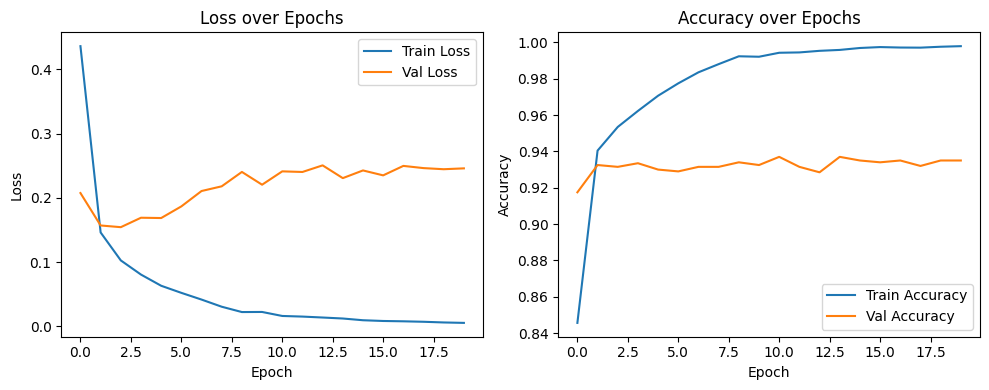

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# ====================================
# 1. Device Check
# ====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")

if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ====================================
# 2. Load Dataset
# ====================================
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']

# ====================================
# 3. Tokenization (efficient)
# ====================================
model_name = "joeddav/distilbert-base-uncased-go-emotions-student"
# model_name = "cardiffnlp/twitter-roberta-base-emotion-multilabel-latest"
# model_name = "bhadresh-savani/bert-base-go-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# ====================================
# 4. Dataset Class
# ====================================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)


# ====================================
# 5. Mean Pooling Layer
# ====================================
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ====================================
# 6. Emotion Classifier
# ====================================
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

# ====================================
# 7. Setup
# ====================================
epochs = 20
num_labels = len(label_list)
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
from transformers import get_scheduler
scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * epochs
)
criterion = nn.CrossEntropyLoss()



# ====================================
# 8. Training and Validation
# ====================================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    val_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)

            val_loss += loss.item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(target.cpu().numpy())

    acc = accuracy_score(labels, preds)
    return val_loss / len(loader), acc

def train_model(epochs):
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(target.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}:")
        print(f"  Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f}")
    torch.save(best_model_state, "best_model.pt")

# ====================================
# 9. Train
# ====================================
train_model(epochs)

# ====================================
# 10. Load Best Model and Final Evaluation
# ====================================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
final_val_loss, final_val_acc = evaluate(val_loader)
print(f"\n✅ Final Evaluation — Best Model:\n   Val Loss: {final_val_loss:.4f} | Val Accuracy: {final_val_acc:.4f}")

# ====================================
# 11. Plotting
# ====================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


modifieed the forward pass


🖥️  Using device: cuda



Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 500/500 [01:38<00:00,  5.10it/s]



📊 Epoch 1:
  Train Loss: 0.3312 | Train Acc: 0.8916
  Val   Loss: 0.1852 | Val   Acc: 0.9305


Epoch 2: 100%|██████████| 500/500 [01:37<00:00,  5.12it/s]



📊 Epoch 2:
  Train Loss: 0.1509 | Train Acc: 0.9371
  Val   Loss: 0.1443 | Val   Acc: 0.9375


Epoch 3: 100%|██████████| 500/500 [01:39<00:00,  5.01it/s]



📊 Epoch 3:
  Train Loss: 0.1131 | Train Acc: 0.9483
  Val   Loss: 0.1435 | Val   Acc: 0.9360


Epoch 4: 100%|██████████| 500/500 [01:43<00:00,  4.83it/s]



📊 Epoch 4:
  Train Loss: 0.0995 | Train Acc: 0.9526
  Val   Loss: 0.1241 | Val   Acc: 0.9415


Epoch 5: 100%|██████████| 500/500 [01:43<00:00,  4.84it/s]



📊 Epoch 5:
  Train Loss: 0.0859 | Train Acc: 0.9579
  Val   Loss: 0.1263 | Val   Acc: 0.9445


Epoch 6: 100%|██████████| 500/500 [01:43<00:00,  4.83it/s]



📊 Epoch 6:
  Train Loss: 0.0754 | Train Acc: 0.9628
  Val   Loss: 0.1300 | Val   Acc: 0.9390


Epoch 7: 100%|██████████| 500/500 [01:43<00:00,  4.82it/s]



📊 Epoch 7:
  Train Loss: 0.0710 | Train Acc: 0.9656
  Val   Loss: 0.1236 | Val   Acc: 0.9400


Epoch 8: 100%|██████████| 500/500 [01:43<00:00,  4.84it/s]



📊 Epoch 8:
  Train Loss: 0.0639 | Train Acc: 0.9684
  Val   Loss: 0.1297 | Val   Acc: 0.9385


Epoch 9: 100%|██████████| 500/500 [01:34<00:00,  5.27it/s]



📊 Epoch 9:
  Train Loss: 0.0568 | Train Acc: 0.9743
  Val   Loss: 0.1351 | Val   Acc: 0.9360


Epoch 10: 100%|██████████| 500/500 [01:32<00:00,  5.42it/s]



📊 Epoch 10:
  Train Loss: 0.0496 | Train Acc: 0.9781
  Val   Loss: 0.1501 | Val   Acc: 0.9405


Epoch 11: 100%|██████████| 500/500 [01:39<00:00,  5.01it/s]



📊 Epoch 11:
  Train Loss: 0.0450 | Train Acc: 0.9802
  Val   Loss: 0.1649 | Val   Acc: 0.9360


Epoch 12: 100%|██████████| 500/500 [01:41<00:00,  4.92it/s]



📊 Epoch 12:
  Train Loss: 0.0381 | Train Acc: 0.9841
  Val   Loss: 0.1710 | Val   Acc: 0.9360


Epoch 13: 100%|██████████| 500/500 [01:41<00:00,  4.95it/s]



📊 Epoch 13:
  Train Loss: 0.0360 | Train Acc: 0.9847
  Val   Loss: 0.1680 | Val   Acc: 0.9385


Epoch 14: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]



📊 Epoch 14:
  Train Loss: 0.0302 | Train Acc: 0.9881
  Val   Loss: 0.1746 | Val   Acc: 0.9410


Epoch 15: 100%|██████████| 500/500 [01:40<00:00,  4.98it/s]



📊 Epoch 15:
  Train Loss: 0.0248 | Train Acc: 0.9901
  Val   Loss: 0.1814 | Val   Acc: 0.9405


Epoch 16: 100%|██████████| 500/500 [01:42<00:00,  4.89it/s]



📊 Epoch 16:
  Train Loss: 0.0241 | Train Acc: 0.9909
  Val   Loss: 0.1936 | Val   Acc: 0.9395


Epoch 17: 100%|██████████| 500/500 [01:40<00:00,  4.98it/s]



📊 Epoch 17:
  Train Loss: 0.0216 | Train Acc: 0.9907
  Val   Loss: 0.1956 | Val   Acc: 0.9385


Epoch 18: 100%|██████████| 500/500 [01:40<00:00,  4.98it/s]



📊 Epoch 18:
  Train Loss: 0.0171 | Train Acc: 0.9932
  Val   Loss: 0.2147 | Val   Acc: 0.9395


Epoch 19: 100%|██████████| 500/500 [01:37<00:00,  5.14it/s]



📊 Epoch 19:
  Train Loss: 0.0165 | Train Acc: 0.9936
  Val   Loss: 0.2035 | Val   Acc: 0.9385


Epoch 20: 100%|██████████| 500/500 [01:34<00:00,  5.32it/s]



📊 Epoch 20:
  Train Loss: 0.0157 | Train Acc: 0.9942
  Val   Loss: 0.2051 | Val   Acc: 0.9380

🏆 Best Validation Accuracy: 0.9445

✅ Final Evaluation — Best Model:
   Val Loss: 0.2051 | Val Accuracy: 0.9380


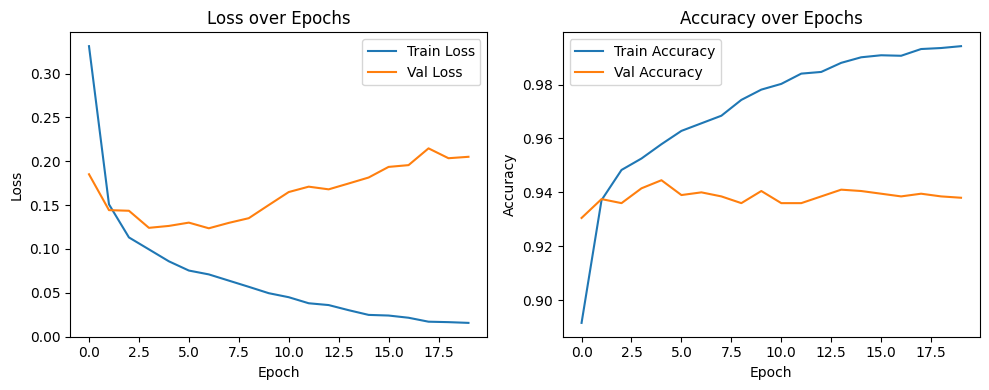

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# ====================================
# 1. Device Check
# ====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")

if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ====================================
# 2. Load Dataset
# ====================================
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']

# ====================================
# 3. Tokenization (efficient)
# ====================================
model_name = "j-hartmann/emotion-english-distilroberta-base"
# model_name = "cardiffnlp/twitter-roberta-base-emotion-multilabel-latest"
# model_name = "bhadresh-savani/bert-base-go-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# ====================================
# 4. Dataset Class
# ====================================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)


# ====================================
# 5. Mean Pooling Layer
# ====================================
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ====================================
# 6. Emotion Classifier
# ====================================
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        # pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = outputs.pooler_output 
        return self.classifier(pooled_output)

# ====================================
# 7. Setup
# ====================================
epochs = 20
num_labels = len(label_list)
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
from transformers import get_scheduler
scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * epochs
)
criterion = nn.CrossEntropyLoss()



# ====================================
# 8. Training and Validation
# ====================================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    val_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)

            val_loss += loss.item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(target.cpu().numpy())

    acc = accuracy_score(labels, preds)
    return val_loss / len(loader), acc

def train_model(epochs):
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(target.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}:")
        print(f"  Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f}")
    torch.save(best_model_state, "best_model.pt")

# ====================================
# 9. Train
# ====================================
train_model(epochs)

# ====================================
# 10. Load Best Model and Final Evaluation
# ====================================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
final_val_loss, final_val_acc = evaluate(val_loader)
print(f"\n✅ Final Evaluation — Best Model:\n   Val Loss: {final_val_loss:.4f} | Val Accuracy: {final_val_acc:.4f}")

# ====================================
# 11. Plotting
# ====================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


updating teh emotional classifier


🖥️  Using device: cuda



Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 500/500 [01:41<00:00,  4.91it/s]



📊 Epoch 1:
  Train Loss: 0.6263 | Train Acc: 0.8426
  Val   Loss: 0.2357 | Val   Acc: 0.9240


Epoch 2: 100%|██████████| 500/500 [01:36<00:00,  5.19it/s]



📊 Epoch 2:
  Train Loss: 0.2189 | Train Acc: 0.9331
  Val   Loss: 0.2025 | Val   Acc: 0.9230


Epoch 3: 100%|██████████| 500/500 [01:35<00:00,  5.22it/s]



📊 Epoch 3:
  Train Loss: 0.1575 | Train Acc: 0.9419
  Val   Loss: 0.1678 | Val   Acc: 0.9335


Epoch 4: 100%|██████████| 500/500 [01:39<00:00,  5.03it/s]



📊 Epoch 4:
  Train Loss: 0.1284 | Train Acc: 0.9490
  Val   Loss: 0.1437 | Val   Acc: 0.9380


Epoch 5: 100%|██████████| 500/500 [01:37<00:00,  5.11it/s]



📊 Epoch 5:
  Train Loss: 0.1126 | Train Acc: 0.9521
  Val   Loss: 0.1437 | Val   Acc: 0.9355


Epoch 6: 100%|██████████| 500/500 [01:36<00:00,  5.18it/s]



📊 Epoch 6:
  Train Loss: 0.0986 | Train Acc: 0.9569
  Val   Loss: 0.1335 | Val   Acc: 0.9340


Epoch 7: 100%|██████████| 500/500 [01:35<00:00,  5.22it/s]



📊 Epoch 7:
  Train Loss: 0.0922 | Train Acc: 0.9592
  Val   Loss: 0.1352 | Val   Acc: 0.9440


Epoch 8: 100%|██████████| 500/500 [01:38<00:00,  5.09it/s]



📊 Epoch 8:
  Train Loss: 0.0819 | Train Acc: 0.9627
  Val   Loss: 0.1262 | Val   Acc: 0.9410


Epoch 9: 100%|██████████| 500/500 [01:42<00:00,  4.89it/s]



📊 Epoch 9:
  Train Loss: 0.0761 | Train Acc: 0.9657
  Val   Loss: 0.1463 | Val   Acc: 0.9405


Epoch 10: 100%|██████████| 500/500 [01:42<00:00,  4.87it/s]



📊 Epoch 10:
  Train Loss: 0.0665 | Train Acc: 0.9699
  Val   Loss: 0.1554 | Val   Acc: 0.9375


Epoch 11: 100%|██████████| 500/500 [01:42<00:00,  4.87it/s]



📊 Epoch 11:
  Train Loss: 0.0616 | Train Acc: 0.9716
  Val   Loss: 0.1575 | Val   Acc: 0.9380


Epoch 12: 100%|██████████| 500/500 [01:35<00:00,  5.23it/s]



📊 Epoch 12:
  Train Loss: 0.0555 | Train Acc: 0.9762
  Val   Loss: 0.1511 | Val   Acc: 0.9360


Epoch 13: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 13:
  Train Loss: 0.0487 | Train Acc: 0.9789
  Val   Loss: 0.1689 | Val   Acc: 0.9355


Epoch 14: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 14:
  Train Loss: 0.0451 | Train Acc: 0.9816
  Val   Loss: 0.1722 | Val   Acc: 0.9415


Epoch 15: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 15:
  Train Loss: 0.0400 | Train Acc: 0.9845
  Val   Loss: 0.1790 | Val   Acc: 0.9365


Epoch 16: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 16:
  Train Loss: 0.0356 | Train Acc: 0.9863
  Val   Loss: 0.1693 | Val   Acc: 0.9390


Epoch 17: 100%|██████████| 500/500 [01:32<00:00,  5.42it/s]



📊 Epoch 17:
  Train Loss: 0.0315 | Train Acc: 0.9889
  Val   Loss: 0.1873 | Val   Acc: 0.9370


Epoch 18: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 18:
  Train Loss: 0.0282 | Train Acc: 0.9894
  Val   Loss: 0.1954 | Val   Acc: 0.9400


Epoch 19: 100%|██████████| 500/500 [01:32<00:00,  5.39it/s]



📊 Epoch 19:
  Train Loss: 0.0281 | Train Acc: 0.9896
  Val   Loss: 0.1953 | Val   Acc: 0.9370


Epoch 20: 100%|██████████| 500/500 [01:35<00:00,  5.22it/s]



📊 Epoch 20:
  Train Loss: 0.0258 | Train Acc: 0.9896
  Val   Loss: 0.1938 | Val   Acc: 0.9390

🏆 Best Validation Accuracy: 0.9440

✅ Final Evaluation — Best Model:
   Val Loss: 0.1938 | Val Accuracy: 0.9390


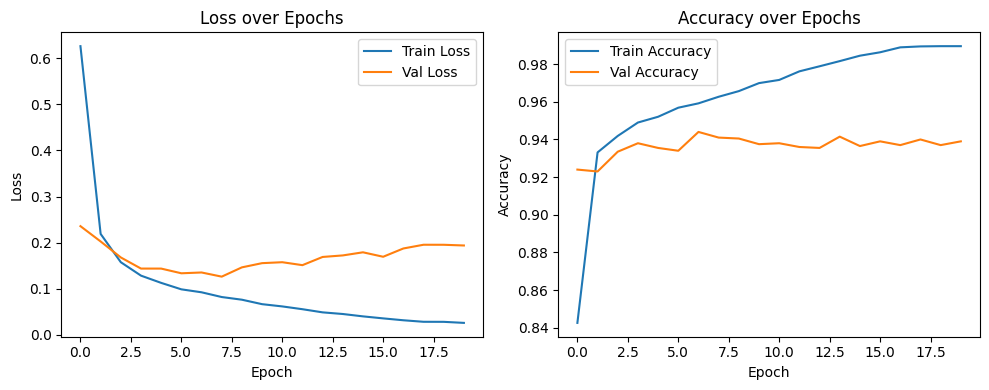

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# ====================================
# 1. Device Check
# ====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")

if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ====================================
# 2. Load Dataset
# ====================================
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']

# ====================================
# 3. Tokenization (efficient)
# ====================================
model_name = "j-hartmann/emotion-english-distilroberta-base"
# model_name = "cardiffnlp/twitter-roberta-base-emotion-multilabel-latest"
# model_name = "bhadresh-savani/bert-base-go-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# ====================================
# 4. Dataset Class
# ====================================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)


# ====================================
# 5. Mean Pooling Layer
# ====================================
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ====================================
# 6. Emotion Classifier
# ====================================
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

# ====================================
# 7. Setup
# ====================================
epochs = 20
num_labels = len(label_list)
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
from transformers import get_scheduler
scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * epochs
)
criterion = nn.CrossEntropyLoss()



# ====================================
# 8. Training and Validation
# ====================================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    val_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)

            val_loss += loss.item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(target.cpu().numpy())

    acc = accuracy_score(labels, preds)
    return val_loss / len(loader), acc

def train_model(epochs):
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(target.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}:")
        print(f"  Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f}")
    torch.save(best_model_state, "best_model.pt")

# ====================================
# 9. Train
# ====================================
train_model(epochs)

# ====================================
# 10. Load Best Model and Final Evaluation
# ====================================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
final_val_loss, final_val_acc = evaluate(val_loader)
print(f"\n✅ Final Evaluation — Best Model:\n   Val Loss: {final_val_loss:.4f} | Val Accuracy: {final_val_acc:.4f}")

# ====================================
# 11. Plotting
# ====================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()



🖥️  Using device: cuda



Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 500/500 [01:36<00:00,  5.19it/s]



📊 Epoch 1:
  Train Loss: 0.4091 | Train Acc: 0.8788
  Val   Loss: 0.2011 | Val   Acc: 0.9240


Epoch 2: 100%|██████████| 500/500 [01:33<00:00,  5.34it/s]



📊 Epoch 2:
  Train Loss: 0.1756 | Train Acc: 0.9358
  Val   Loss: 0.1507 | Val   Acc: 0.9345


Epoch 3: 100%|██████████| 500/500 [01:32<00:00,  5.40it/s]



📊 Epoch 3:
  Train Loss: 0.1275 | Train Acc: 0.9466
  Val   Loss: 0.1354 | Val   Acc: 0.9385


Epoch 4: 100%|██████████| 500/500 [01:34<00:00,  5.31it/s]



📊 Epoch 4:
  Train Loss: 0.1048 | Train Acc: 0.9527
  Val   Loss: 0.1325 | Val   Acc: 0.9405


Epoch 5: 100%|██████████| 500/500 [01:34<00:00,  5.28it/s]



📊 Epoch 5:
  Train Loss: 0.0951 | Train Acc: 0.9565
  Val   Loss: 0.1358 | Val   Acc: 0.9415


Epoch 6: 100%|██████████| 500/500 [01:34<00:00,  5.30it/s]



📊 Epoch 6:
  Train Loss: 0.0836 | Train Acc: 0.9611
  Val   Loss: 0.1250 | Val   Acc: 0.9445


Epoch 7: 100%|██████████| 500/500 [01:33<00:00,  5.32it/s]



📊 Epoch 7:
  Train Loss: 0.0721 | Train Acc: 0.9661
  Val   Loss: 0.1363 | Val   Acc: 0.9400


Epoch 8: 100%|██████████| 500/500 [01:35<00:00,  5.25it/s]



📊 Epoch 8:
  Train Loss: 0.0704 | Train Acc: 0.9669
  Val   Loss: 0.1383 | Val   Acc: 0.9400


Epoch 9: 100%|██████████| 500/500 [01:40<00:00,  4.98it/s]



📊 Epoch 9:
  Train Loss: 0.0608 | Train Acc: 0.9724
  Val   Loss: 0.1538 | Val   Acc: 0.9435


Epoch 10: 100%|██████████| 500/500 [01:38<00:00,  5.06it/s]



📊 Epoch 10:
  Train Loss: 0.0543 | Train Acc: 0.9754
  Val   Loss: 0.1520 | Val   Acc: 0.9395


Epoch 11: 100%|██████████| 500/500 [01:38<00:00,  5.09it/s]



📊 Epoch 11:
  Train Loss: 0.0507 | Train Acc: 0.9777
  Val   Loss: 0.1584 | Val   Acc: 0.9385


Epoch 12: 100%|██████████| 500/500 [01:38<00:00,  5.06it/s]



📊 Epoch 12:
  Train Loss: 0.0448 | Train Acc: 0.9796
  Val   Loss: 0.1638 | Val   Acc: 0.9390


Epoch 13: 100%|██████████| 500/500 [01:39<00:00,  5.02it/s]



📊 Epoch 13:
  Train Loss: 0.0382 | Train Acc: 0.9844
  Val   Loss: 0.1722 | Val   Acc: 0.9415


Epoch 14: 100%|██████████| 500/500 [01:34<00:00,  5.28it/s]



📊 Epoch 14:
  Train Loss: 0.0307 | Train Acc: 0.9879
  Val   Loss: 0.1884 | Val   Acc: 0.9420


Epoch 15: 100%|██████████| 500/500 [01:33<00:00,  5.36it/s]



📊 Epoch 15:
  Train Loss: 0.0296 | Train Acc: 0.9883
  Val   Loss: 0.2032 | Val   Acc: 0.9400


Epoch 16: 100%|██████████| 500/500 [01:37<00:00,  5.11it/s]



📊 Epoch 16:
  Train Loss: 0.0264 | Train Acc: 0.9895
  Val   Loss: 0.2043 | Val   Acc: 0.9400


Epoch 17: 100%|██████████| 500/500 [01:38<00:00,  5.05it/s]



📊 Epoch 17:
  Train Loss: 0.0227 | Train Acc: 0.9913
  Val   Loss: 0.1993 | Val   Acc: 0.9405


Epoch 18: 100%|██████████| 500/500 [01:39<00:00,  5.05it/s]



📊 Epoch 18:
  Train Loss: 0.0195 | Train Acc: 0.9921
  Val   Loss: 0.2078 | Val   Acc: 0.9405


Epoch 19: 100%|██████████| 500/500 [01:37<00:00,  5.12it/s]



📊 Epoch 19:
  Train Loss: 0.0177 | Train Acc: 0.9928
  Val   Loss: 0.2097 | Val   Acc: 0.9430


Epoch 20: 100%|██████████| 500/500 [01:38<00:00,  5.08it/s]



📊 Epoch 20:
  Train Loss: 0.0165 | Train Acc: 0.9939
  Val   Loss: 0.2079 | Val   Acc: 0.9430

🏆 Best Validation Accuracy: 0.9445

✅ Final Evaluation — Best Model:
   Val Loss: 0.2079 | Val Accuracy: 0.9430


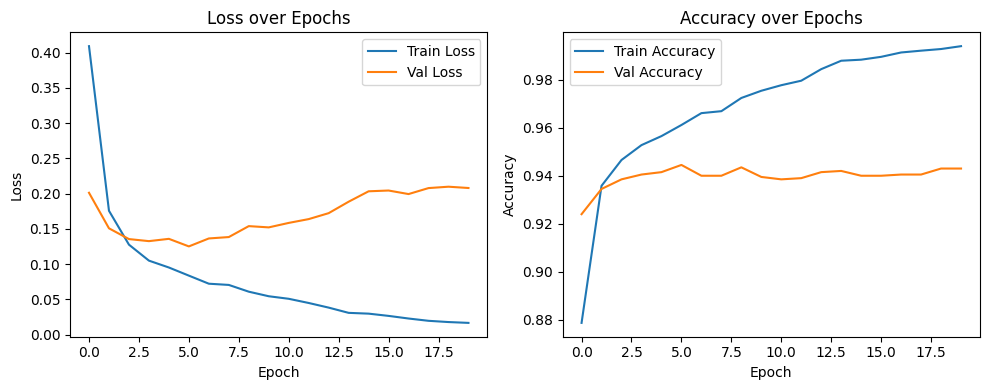

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# ====================================
# 1. Device Check
# ====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")

if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ====================================
# 2. Load Dataset
# ====================================
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']

# ====================================
# 3. Tokenization (efficient)
# ====================================
model_name = "j-hartmann/emotion-english-distilroberta-base"
# model_name = "cardiffnlp/twitter-roberta-base-emotion-multilabel-latest"
# model_name = "bhadresh-savani/bert-base-go-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# ====================================
# 4. Dataset Class
# ====================================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)


# ====================================
# 5. Mean Pooling Layer
# ====================================
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ====================================
# 6. Emotion Classifier
# ====================================
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)


# ====================================
# 7. Setup
# ====================================
epochs = 20
num_labels = len(label_list)
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
from transformers import get_scheduler
scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * epochs
)
criterion = nn.CrossEntropyLoss()



# ====================================
# 8. Training and Validation
# ====================================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    val_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)

            val_loss += loss.item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(target.cpu().numpy())

    acc = accuracy_score(labels, preds)
    return val_loss / len(loader), acc

def train_model(epochs):
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(target.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}:")
        print(f"  Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f}")
    torch.save(best_model_state, "best_model.pt")

# ====================================
# 9. Train
# ====================================
train_model(epochs)

# ====================================
# 10. Load Best Model and Final Evaluation
# ====================================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
final_val_loss, final_val_acc = evaluate(val_loader)
print(f"\n✅ Final Evaluation — Best Model:\n   Val Loss: {final_val_loss:.4f} | Val Accuracy: {final_val_acc:.4f}")

# ====================================
# 11. Plotting
# ====================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()



🖥️  Using device: cuda



Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 500/500 [01:44<00:00,  4.80it/s]



📊 Epoch 1:
  Train Loss: 0.3693 | Train Acc: 0.8857
  Val   Loss: 0.2054 | Val   Acc: 0.9290


Epoch 2: 100%|██████████| 500/500 [01:45<00:00,  4.73it/s]



📊 Epoch 2:
  Train Loss: 0.1659 | Train Acc: 0.9359
  Val   Loss: 0.1694 | Val   Acc: 0.9350


Epoch 3: 100%|██████████| 500/500 [01:44<00:00,  4.80it/s]



📊 Epoch 3:
  Train Loss: 0.1288 | Train Acc: 0.9464
  Val   Loss: 0.1477 | Val   Acc: 0.9390


Epoch 4: 100%|██████████| 500/500 [01:39<00:00,  5.03it/s]



📊 Epoch 4:
  Train Loss: 0.1071 | Train Acc: 0.9533
  Val   Loss: 0.1626 | Val   Acc: 0.9350


Epoch 5: 100%|██████████| 500/500 [01:39<00:00,  5.04it/s]



📊 Epoch 5:
  Train Loss: 0.0915 | Train Acc: 0.9590
  Val   Loss: 0.1357 | Val   Acc: 0.9425


Epoch 6: 100%|██████████| 500/500 [01:38<00:00,  5.06it/s]



📊 Epoch 6:
  Train Loss: 0.0842 | Train Acc: 0.9632
  Val   Loss: 0.1748 | Val   Acc: 0.9375


Epoch 7: 100%|██████████| 500/500 [01:38<00:00,  5.09it/s]



📊 Epoch 7:
  Train Loss: 0.0704 | Train Acc: 0.9689
  Val   Loss: 0.1967 | Val   Acc: 0.9340


Epoch 8: 100%|██████████| 500/500 [01:40<00:00,  4.97it/s]



📊 Epoch 8:
  Train Loss: 0.0599 | Train Acc: 0.9765
  Val   Loss: 0.2154 | Val   Acc: 0.9365


Epoch 9: 100%|██████████| 500/500 [01:45<00:00,  4.76it/s]



📊 Epoch 9:
  Train Loss: 0.0518 | Train Acc: 0.9801
  Val   Loss: 0.2423 | Val   Acc: 0.9405


Epoch 10: 100%|██████████| 500/500 [01:44<00:00,  4.77it/s]



📊 Epoch 10:
  Train Loss: 0.0440 | Train Acc: 0.9841
  Val   Loss: 0.2820 | Val   Acc: 0.9405


Epoch 11: 100%|██████████| 500/500 [01:39<00:00,  5.04it/s]



📊 Epoch 11:
  Train Loss: 0.0362 | Train Acc: 0.9879
  Val   Loss: 0.2708 | Val   Acc: 0.9395


Epoch 12: 100%|██████████| 500/500 [01:44<00:00,  4.77it/s]



📊 Epoch 12:
  Train Loss: 0.0343 | Train Acc: 0.9882
  Val   Loss: 0.2930 | Val   Acc: 0.9390


Epoch 13: 100%|██████████| 500/500 [01:42<00:00,  4.87it/s]



📊 Epoch 13:
  Train Loss: 0.0258 | Train Acc: 0.9911
  Val   Loss: 0.3114 | Val   Acc: 0.9405


Epoch 14: 100%|██████████| 500/500 [01:41<00:00,  4.93it/s]



📊 Epoch 14:
  Train Loss: 0.0212 | Train Acc: 0.9937
  Val   Loss: 0.3359 | Val   Acc: 0.9375


Epoch 15: 100%|██████████| 500/500 [01:40<00:00,  4.98it/s]



📊 Epoch 15:
  Train Loss: 0.0211 | Train Acc: 0.9939
  Val   Loss: 0.3016 | Val   Acc: 0.9430


Epoch 16: 100%|██████████| 500/500 [01:39<00:00,  5.05it/s]



📊 Epoch 16:
  Train Loss: 0.0196 | Train Acc: 0.9944
  Val   Loss: 0.3241 | Val   Acc: 0.9395


Epoch 17: 100%|██████████| 500/500 [01:38<00:00,  5.09it/s]



📊 Epoch 17:
  Train Loss: 0.0149 | Train Acc: 0.9950
  Val   Loss: 0.3424 | Val   Acc: 0.9395


Epoch 18: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]



📊 Epoch 18:
  Train Loss: 0.0129 | Train Acc: 0.9957
  Val   Loss: 0.3562 | Val   Acc: 0.9425


Epoch 19: 100%|██████████| 500/500 [01:38<00:00,  5.10it/s]



📊 Epoch 19:
  Train Loss: 0.0123 | Train Acc: 0.9962
  Val   Loss: 0.3546 | Val   Acc: 0.9405


Epoch 20: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]



📊 Epoch 20:
  Train Loss: 0.0118 | Train Acc: 0.9961
  Val   Loss: 0.3537 | Val   Acc: 0.9415

🏆 Best Validation Accuracy: 0.9430

✅ Final Evaluation — Best Model:
   Val Loss: 0.3537 | Val Accuracy: 0.9415


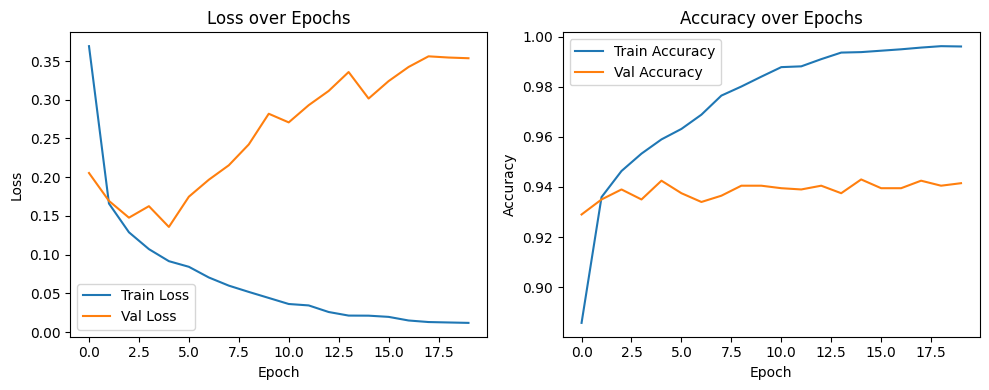

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# ====================================
# 1. Device Check
# ====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")

if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ====================================
# 2. Load Dataset
# ====================================
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']

# ====================================
# 3. Tokenization (efficient)
# ====================================
model_name = "j-hartmann/emotion-english-distilroberta-base"
# model_name = "cardiffnlp/twitter-roberta-base-emotion-multilabel-latest"
# model_name = "bhadresh-savani/bert-base-go-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# ====================================
# 4. Dataset Class
# ====================================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)


# ====================================
# 5. Mean Pooling Layer
# ====================================
# class MeanPooling(nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, last_hidden_state, attention_mask):
#         input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
#         sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
#         sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
#         return sum_embeddings / sum_mask
    
# ====================================
# 6. Emotion Classifier
# ====================================
# class EmotionClassifier(nn.Module):
#     def __init__(self, model_name, num_labels):
#         super().__init__()
#         self.bert = AutoModel.from_pretrained(model_name)
#         self.pooler = MeanPooling()
#         self.dropout = nn.Dropout(0.3)
#         self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
#         pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
#         pooled_output = self.dropout(pooled_output)
#         return self.classifier(pooled_output)


# # 5. Mean Pooling Layer (with LayerNorm)
# class MeanPooling(nn.Module):
#     def __init__(self, hidden_size):
#         super().__init__()
#         self.layer_norm = nn.LayerNorm(hidden_size)
#     def forward(self, last_hidden_state, attention_mask):
#         input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
#         sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
#         sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
#         output = sum_embeddings / sum_mask
#         return self.layer_norm(output)

# # 6. Update EmotionClassifier to pass hidden_size to MeanPooling
# class EmotionClassifier(nn.Module):
#     def __init__(self, model_name, num_labels):
#         super().__init__()
#         self.bert = AutoModel.from_pretrained(model_name)
#         self.pooler = MeanPooling(self.bert.config.hidden_size)
#         self.dropout = nn.Dropout(0.3)
#         self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
#         pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
#         pooled_output = self.dropout(pooled_output)
#         return self.classifier(pooled_output)


# 6. Emotion Classifier (with MLP head)
# class EmotionClassifier(nn.Module):
#     def __init__(self, model_name, num_labels):
#         super().__init__()
#         self.bert = AutoModel.from_pretrained(model_name)
#         self.pooler = MeanPooling(self.bert.config.hidden_size)
#         self.dropout = nn.Dropout(0.3)
#         self.fc1 = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
#         self.act = nn.ReLU()
#         self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
#         pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
#         x = self.dropout(pooled_output)
#         x = self.fc1(x)
#         x = self.act(x)
#         x = self.dropout(x)
#         return self.classifier(x)


# Attention Pooling Layer
class AttentionPooling(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Linear(hidden_size, 1)
    def forward(self, x, mask):
        attention_scores = self.attention(x).squeeze(-1)
        attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))
        attention_weights = torch.softmax(attention_scores, dim=1)
        weighted = (x * attention_weights.unsqueeze(-1)).sum(1)
        return weighted




# 6. Emotion Classifier (GeLU + lower dropout)
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        # self.pooler = MeanPooling(self.bert.config.hidden_size)
        self.pooler = AttentionPooling(self.bert.config.hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.act = nn.GELU()
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        x = self.dropout(pooled_output)
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        return self.classifier(x)



# ====================================
# 7. Setup
# ====================================
epochs = 20
num_labels = len(label_list)
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
max_grad_norm = 1.0
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
from transformers import get_scheduler
scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * epochs
)
criterion = nn.CrossEntropyLoss()



# ====================================
# 8. Training and Validation
# ====================================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    val_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)

            val_loss += loss.item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(target.cpu().numpy())

    acc = accuracy_score(labels, preds)
    return val_loss / len(loader), acc

def train_model(epochs):
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(target.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}:")
        print(f"  Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f}")
    torch.save(best_model_state, "best_model.pt")

# ====================================
# 9. Train
# ====================================
train_model(epochs)

# ====================================
# 10. Load Best Model and Final Evaluation
# ====================================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
final_val_loss, final_val_acc = evaluate(val_loader)
print(f"\n✅ Final Evaluation — Best Model:\n   Val Loss: {final_val_loss:.4f} | Val Accuracy: {final_val_acc:.4f}")

# ====================================
# 11. Plotting
# ====================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Added test split as well


🖥️  Using device: cuda



Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 500/500 [01:32<00:00,  5.41it/s]



📊 Epoch 1:
  Train Loss: 0.3199 | Train Acc: 0.8876
  Val   Loss: 0.1853 | Val   Acc: 0.9295


Epoch 2: 100%|██████████| 500/500 [01:34<00:00,  5.28it/s]



📊 Epoch 2:
  Train Loss: 0.1500 | Train Acc: 0.9369
  Val   Loss: 0.1518 | Val   Acc: 0.9330


Epoch 3: 100%|██████████| 500/500 [01:34<00:00,  5.31it/s]



📊 Epoch 3:
  Train Loss: 0.1137 | Train Acc: 0.9463
  Val   Loss: 0.1470 | Val   Acc: 0.9390


Epoch 4: 100%|██████████| 500/500 [01:34<00:00,  5.30it/s]



📊 Epoch 4:
  Train Loss: 0.0971 | Train Acc: 0.9519
  Val   Loss: 0.1391 | Val   Acc: 0.9315


Epoch 5: 100%|██████████| 500/500 [01:34<00:00,  5.29it/s]



📊 Epoch 5:
  Train Loss: 0.0849 | Train Acc: 0.9579
  Val   Loss: 0.1354 | Val   Acc: 0.9350


Epoch 6: 100%|██████████| 500/500 [01:31<00:00,  5.48it/s]



📊 Epoch 6:
  Train Loss: 0.0791 | Train Acc: 0.9609
  Val   Loss: 0.1376 | Val   Acc: 0.9410


Epoch 7: 100%|██████████| 500/500 [01:35<00:00,  5.25it/s]



📊 Epoch 7:
  Train Loss: 0.0752 | Train Acc: 0.9616
  Val   Loss: 0.1506 | Val   Acc: 0.9335


Epoch 8: 100%|██████████| 500/500 [01:35<00:00,  5.21it/s]



📊 Epoch 8:
  Train Loss: 0.0661 | Train Acc: 0.9680
  Val   Loss: 0.1572 | Val   Acc: 0.9400


Epoch 9: 100%|██████████| 500/500 [01:36<00:00,  5.18it/s]



📊 Epoch 9:
  Train Loss: 0.0635 | Train Acc: 0.9701
  Val   Loss: 0.1645 | Val   Acc: 0.9335


Epoch 10: 100%|██████████| 500/500 [01:36<00:00,  5.20it/s]



📊 Epoch 10:
  Train Loss: 0.0576 | Train Acc: 0.9737
  Val   Loss: 0.1732 | Val   Acc: 0.9415


Epoch 11: 100%|██████████| 500/500 [01:36<00:00,  5.19it/s]



📊 Epoch 11:
  Train Loss: 0.0518 | Train Acc: 0.9777
  Val   Loss: 0.1716 | Val   Acc: 0.9380


Epoch 12: 100%|██████████| 500/500 [01:36<00:00,  5.20it/s]



📊 Epoch 12:
  Train Loss: 0.0445 | Train Acc: 0.9804
  Val   Loss: 0.1955 | Val   Acc: 0.9390


Epoch 13: 100%|██████████| 500/500 [01:36<00:00,  5.16it/s]



📊 Epoch 13:
  Train Loss: 0.0394 | Train Acc: 0.9839
  Val   Loss: 0.1912 | Val   Acc: 0.9365


Epoch 14: 100%|██████████| 500/500 [01:36<00:00,  5.17it/s]



📊 Epoch 14:
  Train Loss: 0.0372 | Train Acc: 0.9854
  Val   Loss: 0.1849 | Val   Acc: 0.9340


Epoch 15: 100%|██████████| 500/500 [01:37<00:00,  5.14it/s]



📊 Epoch 15:
  Train Loss: 0.0296 | Train Acc: 0.9874
  Val   Loss: 0.2084 | Val   Acc: 0.9365


Epoch 16: 100%|██████████| 500/500 [01:38<00:00,  5.05it/s]



📊 Epoch 16:
  Train Loss: 0.0255 | Train Acc: 0.9897
  Val   Loss: 0.1951 | Val   Acc: 0.9400


Epoch 17: 100%|██████████| 500/500 [01:34<00:00,  5.29it/s]



📊 Epoch 17:
  Train Loss: 0.0273 | Train Acc: 0.9892
  Val   Loss: 0.2083 | Val   Acc: 0.9415


Epoch 18: 100%|██████████| 500/500 [01:33<00:00,  5.35it/s]



📊 Epoch 18:
  Train Loss: 0.0199 | Train Acc: 0.9919
  Val   Loss: 0.2440 | Val   Acc: 0.9380


Epoch 19: 100%|██████████| 500/500 [01:33<00:00,  5.36it/s]



📊 Epoch 19:
  Train Loss: 0.0194 | Train Acc: 0.9928
  Val   Loss: 0.2359 | Val   Acc: 0.9390


Epoch 20: 100%|██████████| 500/500 [01:33<00:00,  5.36it/s]



📊 Epoch 20:
  Train Loss: 0.0172 | Train Acc: 0.9936
  Val   Loss: 0.2911 | Val   Acc: 0.9335


Epoch 21: 100%|██████████| 500/500 [01:33<00:00,  5.34it/s]



📊 Epoch 21:
  Train Loss: 0.0179 | Train Acc: 0.9924
  Val   Loss: 0.2469 | Val   Acc: 0.9390


Epoch 22: 100%|██████████| 500/500 [01:33<00:00,  5.37it/s]



📊 Epoch 22:
  Train Loss: 0.0154 | Train Acc: 0.9946
  Val   Loss: 0.2614 | Val   Acc: 0.9355


Epoch 23: 100%|██████████| 500/500 [01:32<00:00,  5.38it/s]



📊 Epoch 23:
  Train Loss: 0.0148 | Train Acc: 0.9949
  Val   Loss: 0.2476 | Val   Acc: 0.9370


Epoch 24: 100%|██████████| 500/500 [01:33<00:00,  5.36it/s]



📊 Epoch 24:
  Train Loss: 0.0145 | Train Acc: 0.9946
  Val   Loss: 0.2713 | Val   Acc: 0.9370


Epoch 25: 100%|██████████| 500/500 [01:33<00:00,  5.37it/s]



📊 Epoch 25:
  Train Loss: 0.0124 | Train Acc: 0.9949
  Val   Loss: 0.2590 | Val   Acc: 0.9445


Epoch 26: 100%|██████████| 500/500 [01:32<00:00,  5.41it/s]



📊 Epoch 26:
  Train Loss: 0.0107 | Train Acc: 0.9956
  Val   Loss: 0.2851 | Val   Acc: 0.9355


Epoch 27: 100%|██████████| 500/500 [01:31<00:00,  5.49it/s]



📊 Epoch 27:
  Train Loss: 0.0111 | Train Acc: 0.9958
  Val   Loss: 0.2831 | Val   Acc: 0.9360


Epoch 28: 100%|██████████| 500/500 [01:31<00:00,  5.48it/s]



📊 Epoch 28:
  Train Loss: 0.0136 | Train Acc: 0.9946
  Val   Loss: 0.2544 | Val   Acc: 0.9430


Epoch 29: 100%|██████████| 500/500 [01:33<00:00,  5.33it/s]



📊 Epoch 29:
  Train Loss: 0.0100 | Train Acc: 0.9961
  Val   Loss: 0.2487 | Val   Acc: 0.9380


Epoch 30: 100%|██████████| 500/500 [01:33<00:00,  5.36it/s]



📊 Epoch 30:
  Train Loss: 0.0091 | Train Acc: 0.9962
  Val   Loss: 0.2704 | Val   Acc: 0.9410


Epoch 31: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 31:
  Train Loss: 0.0164 | Train Acc: 0.9936
  Val   Loss: 0.2618 | Val   Acc: 0.9425


Epoch 32: 100%|██████████| 500/500 [01:31<00:00,  5.48it/s]



📊 Epoch 32:
  Train Loss: 0.0087 | Train Acc: 0.9964
  Val   Loss: 0.2732 | Val   Acc: 0.9375


Epoch 33: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]



📊 Epoch 33:
  Train Loss: 0.0070 | Train Acc: 0.9966
  Val   Loss: 0.2872 | Val   Acc: 0.9440


Epoch 34: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]



📊 Epoch 34:
  Train Loss: 0.0079 | Train Acc: 0.9968
  Val   Loss: 0.2903 | Val   Acc: 0.9410


Epoch 35: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]



📊 Epoch 35:
  Train Loss: 0.0091 | Train Acc: 0.9964
  Val   Loss: 0.2864 | Val   Acc: 0.9400


Epoch 36: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]



📊 Epoch 36:
  Train Loss: 0.0092 | Train Acc: 0.9961
  Val   Loss: 0.3043 | Val   Acc: 0.9420


Epoch 37: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]



📊 Epoch 37:
  Train Loss: 0.0071 | Train Acc: 0.9970
  Val   Loss: 0.3175 | Val   Acc: 0.9405


Epoch 38: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]



📊 Epoch 38:
  Train Loss: 0.0088 | Train Acc: 0.9964
  Val   Loss: 0.3141 | Val   Acc: 0.9395


Epoch 39: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]



📊 Epoch 39:
  Train Loss: 0.0073 | Train Acc: 0.9967
  Val   Loss: 0.2927 | Val   Acc: 0.9440


Epoch 40: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]



📊 Epoch 40:
  Train Loss: 0.0082 | Train Acc: 0.9961
  Val   Loss: 0.3103 | Val   Acc: 0.9375


Epoch 41: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 41:
  Train Loss: 0.0076 | Train Acc: 0.9964
  Val   Loss: 0.3102 | Val   Acc: 0.9400


Epoch 42: 100%|██████████| 500/500 [01:32<00:00,  5.40it/s]



📊 Epoch 42:
  Train Loss: 0.0077 | Train Acc: 0.9964
  Val   Loss: 0.3064 | Val   Acc: 0.9400


Epoch 43: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]



📊 Epoch 43:
  Train Loss: 0.0058 | Train Acc: 0.9971
  Val   Loss: 0.2970 | Val   Acc: 0.9420


Epoch 44: 100%|██████████| 500/500 [01:31<00:00,  5.48it/s]



📊 Epoch 44:
  Train Loss: 0.0066 | Train Acc: 0.9969
  Val   Loss: 0.2934 | Val   Acc: 0.9395


Epoch 45: 100%|██████████| 500/500 [01:31<00:00,  5.48it/s]



📊 Epoch 45:
  Train Loss: 0.0081 | Train Acc: 0.9964
  Val   Loss: 0.2829 | Val   Acc: 0.9410


Epoch 46: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]



📊 Epoch 46:
  Train Loss: 0.0056 | Train Acc: 0.9975
  Val   Loss: 0.2879 | Val   Acc: 0.9405


Epoch 47: 100%|██████████| 500/500 [01:31<00:00,  5.49it/s]



📊 Epoch 47:
  Train Loss: 0.0069 | Train Acc: 0.9964
  Val   Loss: 0.2961 | Val   Acc: 0.9390


Epoch 48: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 48:
  Train Loss: 0.0062 | Train Acc: 0.9972
  Val   Loss: 0.2986 | Val   Acc: 0.9450


Epoch 49: 100%|██████████| 500/500 [01:31<00:00,  5.48it/s]



📊 Epoch 49:
  Train Loss: 0.0060 | Train Acc: 0.9973
  Val   Loss: 0.2816 | Val   Acc: 0.9460


Epoch 50: 100%|██████████| 500/500 [01:31<00:00,  5.48it/s]



📊 Epoch 50:
  Train Loss: 0.0063 | Train Acc: 0.9967
  Val   Loss: 0.3106 | Val   Acc: 0.9440


Epoch 51: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]



📊 Epoch 51:
  Train Loss: 0.0056 | Train Acc: 0.9973
  Val   Loss: 0.2880 | Val   Acc: 0.9440


Epoch 52: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]



📊 Epoch 52:
  Train Loss: 0.0052 | Train Acc: 0.9971
  Val   Loss: 0.3137 | Val   Acc: 0.9445


Epoch 53: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 53:
  Train Loss: 0.0059 | Train Acc: 0.9969
  Val   Loss: 0.3129 | Val   Acc: 0.9425


Epoch 54: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 54:
  Train Loss: 0.0045 | Train Acc: 0.9974
  Val   Loss: 0.3148 | Val   Acc: 0.9420


Epoch 55: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 55:
  Train Loss: 0.0059 | Train Acc: 0.9969
  Val   Loss: 0.2823 | Val   Acc: 0.9455


Epoch 56: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 56:
  Train Loss: 0.0040 | Train Acc: 0.9974
  Val   Loss: 0.3133 | Val   Acc: 0.9455


Epoch 57: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 57:
  Train Loss: 0.0047 | Train Acc: 0.9976
  Val   Loss: 0.3140 | Val   Acc: 0.9460


Epoch 58: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 58:
  Train Loss: 0.0046 | Train Acc: 0.9976
  Val   Loss: 0.3317 | Val   Acc: 0.9455


Epoch 59: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 59:
  Train Loss: 0.0060 | Train Acc: 0.9973
  Val   Loss: 0.3091 | Val   Acc: 0.9455


Epoch 60: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 60:
  Train Loss: 0.0047 | Train Acc: 0.9975
  Val   Loss: 0.3127 | Val   Acc: 0.9425


Epoch 61: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 61:
  Train Loss: 0.0050 | Train Acc: 0.9968
  Val   Loss: 0.2994 | Val   Acc: 0.9450


Epoch 62: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 62:
  Train Loss: 0.0040 | Train Acc: 0.9978
  Val   Loss: 0.3137 | Val   Acc: 0.9455


Epoch 63: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 63:
  Train Loss: 0.0043 | Train Acc: 0.9976
  Val   Loss: 0.3122 | Val   Acc: 0.9465


Epoch 64: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 64:
  Train Loss: 0.0046 | Train Acc: 0.9975
  Val   Loss: 0.2952 | Val   Acc: 0.9470


Epoch 65: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 65:
  Train Loss: 0.0038 | Train Acc: 0.9974
  Val   Loss: 0.3233 | Val   Acc: 0.9445


Epoch 66: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]



📊 Epoch 66:
  Train Loss: 0.0036 | Train Acc: 0.9975
  Val   Loss: 0.3095 | Val   Acc: 0.9445


Epoch 67: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]



📊 Epoch 67:
  Train Loss: 0.0040 | Train Acc: 0.9972
  Val   Loss: 0.3223 | Val   Acc: 0.9445


Epoch 68: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 68:
  Train Loss: 0.0040 | Train Acc: 0.9973
  Val   Loss: 0.3135 | Val   Acc: 0.9435


Epoch 69: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 69:
  Train Loss: 0.0039 | Train Acc: 0.9976
  Val   Loss: 0.3169 | Val   Acc: 0.9450


Epoch 70: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 70:
  Train Loss: 0.0039 | Train Acc: 0.9976
  Val   Loss: 0.3143 | Val   Acc: 0.9470


Epoch 71: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 71:
  Train Loss: 0.0034 | Train Acc: 0.9978
  Val   Loss: 0.3461 | Val   Acc: 0.9430


Epoch 72: 100%|██████████| 500/500 [01:32<00:00,  5.42it/s]



📊 Epoch 72:
  Train Loss: 0.0033 | Train Acc: 0.9978
  Val   Loss: 0.3192 | Val   Acc: 0.9440


Epoch 73: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 73:
  Train Loss: 0.0035 | Train Acc: 0.9975
  Val   Loss: 0.3329 | Val   Acc: 0.9480


Epoch 74: 100%|██████████| 500/500 [01:32<00:00,  5.42it/s]



📊 Epoch 74:
  Train Loss: 0.0041 | Train Acc: 0.9971
  Val   Loss: 0.3719 | Val   Acc: 0.9430


Epoch 75: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 75:
  Train Loss: 0.0034 | Train Acc: 0.9976
  Val   Loss: 0.3533 | Val   Acc: 0.9425


Epoch 76: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 76:
  Train Loss: 0.0036 | Train Acc: 0.9978
  Val   Loss: 0.3350 | Val   Acc: 0.9440


Epoch 77: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 77:
  Train Loss: 0.0044 | Train Acc: 0.9974
  Val   Loss: 0.3346 | Val   Acc: 0.9410


Epoch 78: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 78:
  Train Loss: 0.0032 | Train Acc: 0.9976
  Val   Loss: 0.3320 | Val   Acc: 0.9415


Epoch 79: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 79:
  Train Loss: 0.0031 | Train Acc: 0.9978
  Val   Loss: 0.3400 | Val   Acc: 0.9435


Epoch 80: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 80:
  Train Loss: 0.0031 | Train Acc: 0.9979
  Val   Loss: 0.3457 | Val   Acc: 0.9445


Epoch 81: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 81:
  Train Loss: 0.0032 | Train Acc: 0.9977
  Val   Loss: 0.3644 | Val   Acc: 0.9430


Epoch 82: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 82:
  Train Loss: 0.0033 | Train Acc: 0.9980
  Val   Loss: 0.3460 | Val   Acc: 0.9450


Epoch 83: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 83:
  Train Loss: 0.0038 | Train Acc: 0.9978
  Val   Loss: 0.3554 | Val   Acc: 0.9475


Epoch 84: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 84:
  Train Loss: 0.0033 | Train Acc: 0.9978
  Val   Loss: 0.3542 | Val   Acc: 0.9470


Epoch 85: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 85:
  Train Loss: 0.0033 | Train Acc: 0.9980
  Val   Loss: 0.3622 | Val   Acc: 0.9480


Epoch 86: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 86:
  Train Loss: 0.0037 | Train Acc: 0.9979
  Val   Loss: 0.3493 | Val   Acc: 0.9440


Epoch 87: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 87:
  Train Loss: 0.0033 | Train Acc: 0.9982
  Val   Loss: 0.3479 | Val   Acc: 0.9465


Epoch 88: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 88:
  Train Loss: 0.0030 | Train Acc: 0.9979
  Val   Loss: 0.3631 | Val   Acc: 0.9440


Epoch 89: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 89:
  Train Loss: 0.0029 | Train Acc: 0.9976
  Val   Loss: 0.3646 | Val   Acc: 0.9435


Epoch 90: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 90:
  Train Loss: 0.0030 | Train Acc: 0.9978
  Val   Loss: 0.3566 | Val   Acc: 0.9440


Epoch 91: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 91:
  Train Loss: 0.0032 | Train Acc: 0.9976
  Val   Loss: 0.3708 | Val   Acc: 0.9430


Epoch 92: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 92:
  Train Loss: 0.0029 | Train Acc: 0.9980
  Val   Loss: 0.3735 | Val   Acc: 0.9415


Epoch 93: 100%|██████████| 500/500 [01:33<00:00,  5.35it/s]



📊 Epoch 93:
  Train Loss: 0.0031 | Train Acc: 0.9977
  Val   Loss: 0.3555 | Val   Acc: 0.9450


Epoch 94: 100%|██████████| 500/500 [01:35<00:00,  5.21it/s]



📊 Epoch 94:
  Train Loss: 0.0028 | Train Acc: 0.9984
  Val   Loss: 0.3606 | Val   Acc: 0.9450


Epoch 95: 100%|██████████| 500/500 [01:37<00:00,  5.13it/s]



📊 Epoch 95:
  Train Loss: 0.0028 | Train Acc: 0.9979
  Val   Loss: 0.3611 | Val   Acc: 0.9450


Epoch 96: 100%|██████████| 500/500 [01:38<00:00,  5.08it/s]



📊 Epoch 96:
  Train Loss: 0.0029 | Train Acc: 0.9981
  Val   Loss: 0.3607 | Val   Acc: 0.9480


Epoch 97: 100%|██████████| 500/500 [01:38<00:00,  5.09it/s]



📊 Epoch 97:
  Train Loss: 0.0028 | Train Acc: 0.9982
  Val   Loss: 0.3640 | Val   Acc: 0.9480


Epoch 98: 100%|██████████| 500/500 [01:37<00:00,  5.12it/s]



📊 Epoch 98:
  Train Loss: 0.0031 | Train Acc: 0.9974
  Val   Loss: 0.3598 | Val   Acc: 0.9485


Epoch 99: 100%|██████████| 500/500 [01:37<00:00,  5.15it/s]



📊 Epoch 99:
  Train Loss: 0.0027 | Train Acc: 0.9982
  Val   Loss: 0.3624 | Val   Acc: 0.9475


Epoch 100: 100%|██████████| 500/500 [01:36<00:00,  5.17it/s]



📊 Epoch 100:
  Train Loss: 0.0027 | Train Acc: 0.9981
  Val   Loss: 0.3629 | Val   Acc: 0.9480

🏆 Best Validation Accuracy: 0.9485

✅ Final Evaluation — Best Model on Validation Set:
   Val Loss: 0.3629 | Val Accuracy: 0.9480


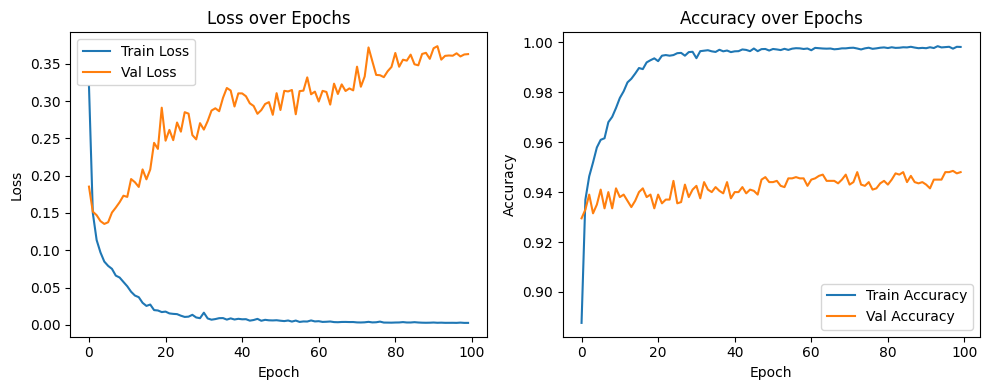


🧪 Final Test Set Accuracy:
   Test Loss: 0.5243 | Test Accuracy: 0.9330


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# ====================================
# 1. Device Check
# ====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")

if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ====================================
# 2. Load Dataset
# ====================================
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

# ====================================
# 3. Tokenization (efficient)
# ====================================
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ====================================
# 4. Dataset Class
# ====================================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ====================================
# 5. Mean Pooling Layer
# ====================================
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ====================================
# 6. Emotion Classifier
# ====================================
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

# ====================================
# 7. Setup
# ====================================
epochs = 100
num_labels = len(label_list)
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

from transformers import get_scheduler
scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * epochs
)
criterion = nn.CrossEntropyLoss()

# ====================================
# 8. Training and Validation
# ====================================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    val_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)

            val_loss += loss.item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(target.cpu().numpy())

    acc = accuracy_score(labels, preds)
    return val_loss / len(loader), acc

def train_model(epochs):
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(target.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}:")
        print(f"  Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f}")
    torch.save(best_model_state, "best_model.pt")

# ====================================
# 9. Train
# ====================================
train_model(epochs)

# ====================================
# 10. Load Best Model and Final Evaluation (Validation)
# ====================================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
final_val_loss, final_val_acc = evaluate(val_loader)
print(f"\n✅ Final Evaluation — Best Model on Validation Set:\n   Val Loss: {final_val_loss:.4f} | Val Accuracy: {final_val_acc:.4f}")

# ====================================
# 11. Plotting
# ====================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# ====================================
# 12. 🧪 Final Test Set Evaluation
# ====================================
test_loss, test_acc = evaluate(test_loader)
print(f"\n🧪 Final Test Set Accuracy:\n   Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


Early stopping



🖥️  Using device: cuda



Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 500/500 [01:34<00:00,  5.30it/s]



📊 Epoch 1:
  Train Loss: 0.3151 | Train Acc: 0.8910
  Val   Loss: 0.1721 | Val   Acc: 0.9280


Epoch 2: 100%|██████████| 500/500 [01:33<00:00,  5.32it/s]



📊 Epoch 2:
  Train Loss: 0.1512 | Train Acc: 0.9355
  Val   Loss: 0.1369 | Val   Acc: 0.9370


Epoch 3: 100%|██████████| 500/500 [01:33<00:00,  5.32it/s]



📊 Epoch 3:
  Train Loss: 0.1154 | Train Acc: 0.9479
  Val   Loss: 0.1378 | Val   Acc: 0.9405


Epoch 4: 100%|██████████| 500/500 [01:33<00:00,  5.32it/s]



📊 Epoch 4:
  Train Loss: 0.0983 | Train Acc: 0.9537
  Val   Loss: 0.1250 | Val   Acc: 0.9430


Epoch 5: 100%|██████████| 500/500 [01:36<00:00,  5.20it/s]



📊 Epoch 5:
  Train Loss: 0.0879 | Train Acc: 0.9573
  Val   Loss: 0.1378 | Val   Acc: 0.9365
  ⏳ No improvement for 1 epoch(s)


Epoch 6: 100%|██████████| 500/500 [01:37<00:00,  5.15it/s]



📊 Epoch 6:
  Train Loss: 0.0763 | Train Acc: 0.9613
  Val   Loss: 0.1421 | Val   Acc: 0.9420
  ⏳ No improvement for 2 epoch(s)


Epoch 7: 100%|██████████| 500/500 [01:36<00:00,  5.17it/s]



📊 Epoch 7:
  Train Loss: 0.0738 | Train Acc: 0.9647
  Val   Loss: 0.1404 | Val   Acc: 0.9370
  ⏳ No improvement for 3 epoch(s)


Epoch 8: 100%|██████████| 500/500 [01:35<00:00,  5.22it/s]



📊 Epoch 8:
  Train Loss: 0.0639 | Train Acc: 0.9702
  Val   Loss: 0.1334 | Val   Acc: 0.9355
  ⏳ No improvement for 4 epoch(s)


Epoch 9: 100%|██████████| 500/500 [01:34<00:00,  5.29it/s]



📊 Epoch 9:
  Train Loss: 0.0584 | Train Acc: 0.9723
  Val   Loss: 0.1403 | Val   Acc: 0.9365
  ⏳ No improvement for 5 epoch(s)


Epoch 10: 100%|██████████| 500/500 [01:36<00:00,  5.20it/s]



📊 Epoch 10:
  Train Loss: 0.0510 | Train Acc: 0.9766
  Val   Loss: 0.1544 | Val   Acc: 0.9375
  ⏳ No improvement for 6 epoch(s)


Epoch 11: 100%|██████████| 500/500 [01:36<00:00,  5.20it/s]



📊 Epoch 11:
  Train Loss: 0.0478 | Train Acc: 0.9789
  Val   Loss: 0.1834 | Val   Acc: 0.9380
  ⏳ No improvement for 7 epoch(s)


Epoch 12: 100%|██████████| 500/500 [01:36<00:00,  5.17it/s]



📊 Epoch 12:
  Train Loss: 0.0398 | Train Acc: 0.9832
  Val   Loss: 0.1941 | Val   Acc: 0.9300
  ⏳ No improvement for 8 epoch(s)


Epoch 13: 100%|██████████| 500/500 [01:36<00:00,  5.16it/s]



📊 Epoch 13:
  Train Loss: 0.0387 | Train Acc: 0.9841
  Val   Loss: 0.1946 | Val   Acc: 0.9365
  ⏳ No improvement for 9 epoch(s)


Epoch 14: 100%|██████████| 500/500 [01:36<00:00,  5.19it/s]



📊 Epoch 14:
  Train Loss: 0.0323 | Train Acc: 0.9866
  Val   Loss: 0.1969 | Val   Acc: 0.9340
  ⏳ No improvement for 10 epoch(s)


Epoch 15: 100%|██████████| 500/500 [01:36<00:00,  5.20it/s]



📊 Epoch 15:
  Train Loss: 0.0289 | Train Acc: 0.9886
  Val   Loss: 0.1939 | Val   Acc: 0.9375
  ⏳ No improvement for 11 epoch(s)


Epoch 16: 100%|██████████| 500/500 [01:35<00:00,  5.22it/s]



📊 Epoch 16:
  Train Loss: 0.0258 | Train Acc: 0.9902
  Val   Loss: 0.2113 | Val   Acc: 0.9355
  ⏳ No improvement for 12 epoch(s)


Epoch 17: 100%|██████████| 500/500 [01:35<00:00,  5.22it/s]



📊 Epoch 17:
  Train Loss: 0.0233 | Train Acc: 0.9915
  Val   Loss: 0.2306 | Val   Acc: 0.9390
  ⏳ No improvement for 13 epoch(s)


Epoch 18: 100%|██████████| 500/500 [01:36<00:00,  5.20it/s]



📊 Epoch 18:
  Train Loss: 0.0209 | Train Acc: 0.9917
  Val   Loss: 0.2188 | Val   Acc: 0.9365
  ⏳ No improvement for 14 epoch(s)


Epoch 19: 100%|██████████| 500/500 [01:34<00:00,  5.31it/s]



📊 Epoch 19:
  Train Loss: 0.0198 | Train Acc: 0.9931
  Val   Loss: 0.2286 | Val   Acc: 0.9415
  ⏳ No improvement for 15 epoch(s)


Epoch 20: 100%|██████████| 500/500 [01:35<00:00,  5.23it/s]



📊 Epoch 20:
  Train Loss: 0.0195 | Train Acc: 0.9922
  Val   Loss: 0.2206 | Val   Acc: 0.9365
  ⏳ No improvement for 16 epoch(s)


Epoch 21: 100%|██████████| 500/500 [01:36<00:00,  5.20it/s]



📊 Epoch 21:
  Train Loss: 0.0184 | Train Acc: 0.9934
  Val   Loss: 0.2044 | Val   Acc: 0.9385
  ⏳ No improvement for 17 epoch(s)


Epoch 22: 100%|██████████| 500/500 [01:33<00:00,  5.36it/s]



📊 Epoch 22:
  Train Loss: 0.0155 | Train Acc: 0.9948
  Val   Loss: 0.2156 | Val   Acc: 0.9400
  ⏳ No improvement for 18 epoch(s)


Epoch 23: 100%|██████████| 500/500 [01:31<00:00,  5.49it/s]



📊 Epoch 23:
  Train Loss: 0.0124 | Train Acc: 0.9950
  Val   Loss: 0.2457 | Val   Acc: 0.9360
  ⏳ No improvement for 19 epoch(s)


Epoch 24: 100%|██████████| 500/500 [01:31<00:00,  5.48it/s]



📊 Epoch 24:
  Train Loss: 0.0124 | Train Acc: 0.9948
  Val   Loss: 0.2509 | Val   Acc: 0.9380
  ⏳ No improvement for 20 epoch(s)


Epoch 25: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]



📊 Epoch 25:
  Train Loss: 0.0116 | Train Acc: 0.9962
  Val   Loss: 0.2744 | Val   Acc: 0.9330
  ⏳ No improvement for 21 epoch(s)


Epoch 26: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 26:
  Train Loss: 0.0113 | Train Acc: 0.9952
  Val   Loss: 0.2474 | Val   Acc: 0.9405
  ⏳ No improvement for 22 epoch(s)


Epoch 27: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 27:
  Train Loss: 0.0118 | Train Acc: 0.9954
  Val   Loss: 0.2809 | Val   Acc: 0.9330
  ⏳ No improvement for 23 epoch(s)


Epoch 28: 100%|██████████| 500/500 [01:31<00:00,  5.48it/s]



📊 Epoch 28:
  Train Loss: 0.0115 | Train Acc: 0.9951
  Val   Loss: 0.3113 | Val   Acc: 0.9370
  ⏳ No improvement for 24 epoch(s)


Epoch 29: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 29:
  Train Loss: 0.0097 | Train Acc: 0.9964
  Val   Loss: 0.2674 | Val   Acc: 0.9400
  ⏳ No improvement for 25 epoch(s)

🛑 Early stopping triggered after 25 epochs without improvement.

🏆 Best Validation Accuracy: 0.9430

✅ Final Evaluation — Best Model:
   Val Loss: 0.1250 | Val Accuracy: 0.9430


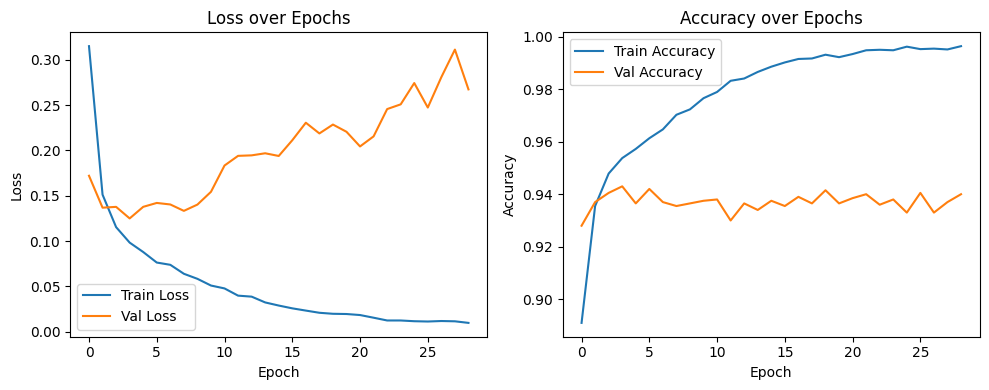

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, get_scheduler
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# ====================================
# 1. Device Check
# ====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")

if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ====================================
# 2. Load Dataset
# ====================================
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']

# ====================================
# 3. Tokenization
# ====================================
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# ====================================
# 4. Dataset Class
# ====================================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)

# ====================================
# 5. Mean Pooling Layer
# ====================================
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ====================================
# 6. Emotion Classifier
# ====================================
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

# ====================================
# 7. Setup
# ====================================
epochs = 100
patience = 25
num_labels = len(label_list)
model = EmotionClassifier(model_name, num_labels).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * epochs
)

criterion = nn.CrossEntropyLoss()

# ====================================
# 8. Training + Early Stopping
# ====================================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    val_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)

            val_loss += loss.item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(target.cpu().numpy())

    acc = accuracy_score(labels, preds)
    return val_loss / len(loader), acc

def train_model(epochs, patience=5):
    best_val_acc = 0.0
    best_model_state = None
    no_improve_epochs = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(target.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}:")
        print(f"  Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            no_improve_epochs = 0
            torch.save(best_model_state, "best_model.pt")
        else:
            no_improve_epochs += 1
            print(f"  ⏳ No improvement for {no_improve_epochs} epoch(s)")

        if no_improve_epochs >= patience:
            print(f"\n🛑 Early stopping triggered after {patience} epochs without improvement.")
            break

    print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f}")

# ====================================
# 9. Train
# ====================================
train_model(epochs, patience=patience)

# ====================================
# 10. Load Best Model + Final Eval
# ====================================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
final_val_loss, final_val_acc = evaluate(val_loader)
print(f"\n✅ Final Evaluation — Best Model:\n   Val Loss: {final_val_loss:.4f} | Val Accuracy: {final_val_acc:.4f}")

# ====================================
# 11. Plotting
# ====================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Only train

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import numpy as np

# ============================
# 1. Load Hugging Face Dataset
# ============================
# Load Hugging Face Dataset
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names  # e.g., ['sadness', 'joy', ...]

# Use raw integer labels directly
train_texts = dataset['train']['text']
train_labels = dataset['train']['label']

val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']

# ============================
# 2. Tokenization
# ============================
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=128
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# ============================
# 3. Custom Dataset
# ============================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)

# ============================
# 4. Mean Pooling Layer
# ============================
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ============================
# 5. Classifier Model
# ============================
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(EmotionClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# ============================
# 6. Training Setup
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)
num_labels = len(label_list)

model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# ============================
# 7. Training Loop
# ============================
def train_model( epochs   ):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        preds, true = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds += torch.argmax(outputs, axis=1).tolist()
            true += labels.tolist()

        acc = accuracy_score(true, preds)
        f1 = f1_score(true, preds, average='weighted')

        print(f"Epoch {epoch+1} | Loss: {train_loss/len(train_loader):.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")

train_model(epochs=10)


cuda


Epoch 1: 100%|██████████| 500/500 [02:42<00:00,  3.07it/s]


Epoch 1 | Loss: 0.4968 | Acc: 0.8227 | F1: 0.8182


Epoch 2: 100%|██████████| 500/500 [02:45<00:00,  3.03it/s]


Epoch 2 | Loss: 0.1402 | Acc: 0.9408 | F1: 0.9408


Epoch 3: 100%|██████████| 500/500 [02:45<00:00,  3.02it/s]


Epoch 3 | Loss: 0.0988 | Acc: 0.9539 | F1: 0.9540


Epoch 4: 100%|██████████| 500/500 [02:46<00:00,  3.01it/s]


Epoch 4 | Loss: 0.0846 | Acc: 0.9603 | F1: 0.9602


Epoch 5: 100%|██████████| 500/500 [02:46<00:00,  3.01it/s]


Epoch 5 | Loss: 0.0699 | Acc: 0.9656 | F1: 0.9655


Epoch 6: 100%|██████████| 500/500 [02:46<00:00,  3.01it/s]


Epoch 6 | Loss: 0.0583 | Acc: 0.9732 | F1: 0.9731


Epoch 7: 100%|██████████| 500/500 [02:46<00:00,  3.00it/s]


Epoch 7 | Loss: 0.0496 | Acc: 0.9796 | F1: 0.9796


Epoch 8: 100%|██████████| 500/500 [02:46<00:00,  3.00it/s]


Epoch 8 | Loss: 0.0384 | Acc: 0.9846 | F1: 0.9846


Epoch 9: 100%|██████████| 500/500 [02:46<00:00,  3.00it/s]


Epoch 9 | Loss: 0.0325 | Acc: 0.9880 | F1: 0.9880


Epoch 10: 100%|██████████| 500/500 [02:46<00:00,  3.00it/s]

Epoch 10 | Loss: 0.0249 | Acc: 0.9909 | F1: 0.9909


Tarin and VAl

Epoch 1: 100%|██████████| 500/500 [02:51<00:00,  2.92it/s]


Epoch 1: Train Loss 0.4799 | Train Acc 0.8267 | Val Loss 0.1512 | Val Acc 0.9345


Epoch 2: 100%|██████████| 500/500 [02:52<00:00,  2.90it/s]


Epoch 2: Train Loss 0.1346 | Train Acc 0.9417 | Val Loss 0.1554 | Val Acc 0.9350


Epoch 3: 100%|██████████| 500/500 [02:49<00:00,  2.95it/s]


Epoch 3: Train Loss 0.1003 | Train Acc 0.9534 | Val Loss 0.1574 | Val Acc 0.9335


Epoch 4: 100%|██████████| 500/500 [02:49<00:00,  2.95it/s]


Epoch 4: Train Loss 0.0850 | Train Acc 0.9584 | Val Loss 0.1454 | Val Acc 0.9395


Epoch 5: 100%|██████████| 500/500 [02:48<00:00,  2.96it/s]


Epoch 5: Train Loss 0.0721 | Train Acc 0.9664 | Val Loss 0.1765 | Val Acc 0.9340


Epoch 6: 100%|██████████| 500/500 [02:46<00:00,  3.01it/s]


Epoch 6: Train Loss 0.0600 | Train Acc 0.9722 | Val Loss 0.1895 | Val Acc 0.9315


Epoch 7: 100%|██████████| 500/500 [02:46<00:00,  3.00it/s]


Epoch 7: Train Loss 0.0524 | Train Acc 0.9761 | Val Loss 0.1993 | Val Acc 0.9330


Epoch 8: 100%|██████████| 500/500 [02:47<00:00,  2.99it/s]


Epoch 8: Train Loss 0.0376 | Train Acc 0.9851 | Val Loss 0.2417 | Val Acc 0.9340


Epoch 9: 100%|██████████| 500/500 [02:46<00:00,  3.00it/s]


Epoch 9: Train Loss 0.0338 | Train Acc 0.9870 | Val Loss 0.2031 | Val Acc 0.9345


Epoch 10: 100%|██████████| 500/500 [02:46<00:00,  3.00it/s]


Epoch 10: Train Loss 0.0276 | Train Acc 0.9894 | Val Loss 0.2208 | Val Acc 0.9410


Epoch 11: 100%|██████████| 500/500 [02:46<00:00,  3.00it/s]


Epoch 11: Train Loss 0.0216 | Train Acc 0.9927 | Val Loss 0.2407 | Val Acc 0.9340


Epoch 12: 100%|██████████| 500/500 [02:47<00:00,  2.99it/s]


Epoch 12: Train Loss 0.0245 | Train Acc 0.9914 | Val Loss 0.2657 | Val Acc 0.9350


Epoch 13: 100%|██████████| 500/500 [02:46<00:00,  3.00it/s]


Epoch 13: Train Loss 0.0179 | Train Acc 0.9926 | Val Loss 0.2532 | Val Acc 0.9395


Epoch 14: 100%|██████████| 500/500 [02:46<00:00,  3.00it/s]


Epoch 14: Train Loss 0.0162 | Train Acc 0.9941 | Val Loss 0.3059 | Val Acc 0.9335


Epoch 15: 100%|██████████| 500/500 [02:46<00:00,  3.00it/s]


Epoch 15: Train Loss 0.0163 | Train Acc 0.9940 | Val Loss 0.2580 | Val Acc 0.9360


Epoch 16: 100%|██████████| 500/500 [02:46<00:00,  3.00it/s]


Epoch 16: Train Loss 0.0127 | Train Acc 0.9961 | Val Loss 0.2582 | Val Acc 0.9345


Epoch 17: 100%|██████████| 500/500 [02:46<00:00,  3.00it/s]


Epoch 17: Train Loss 0.0097 | Train Acc 0.9966 | Val Loss 0.3125 | Val Acc 0.9345


Epoch 18: 100%|██████████| 500/500 [02:46<00:00,  3.00it/s]


Epoch 18: Train Loss 0.0149 | Train Acc 0.9948 | Val Loss 0.2677 | Val Acc 0.9375


Epoch 19: 100%|██████████| 500/500 [02:46<00:00,  3.00it/s]


Epoch 19: Train Loss 0.0112 | Train Acc 0.9959 | Val Loss 0.2836 | Val Acc 0.9315


Epoch 20: 100%|██████████| 500/500 [02:47<00:00,  2.99it/s]


Epoch 20: Train Loss 0.0139 | Train Acc 0.9941 | Val Loss 0.2918 | Val Acc 0.9375


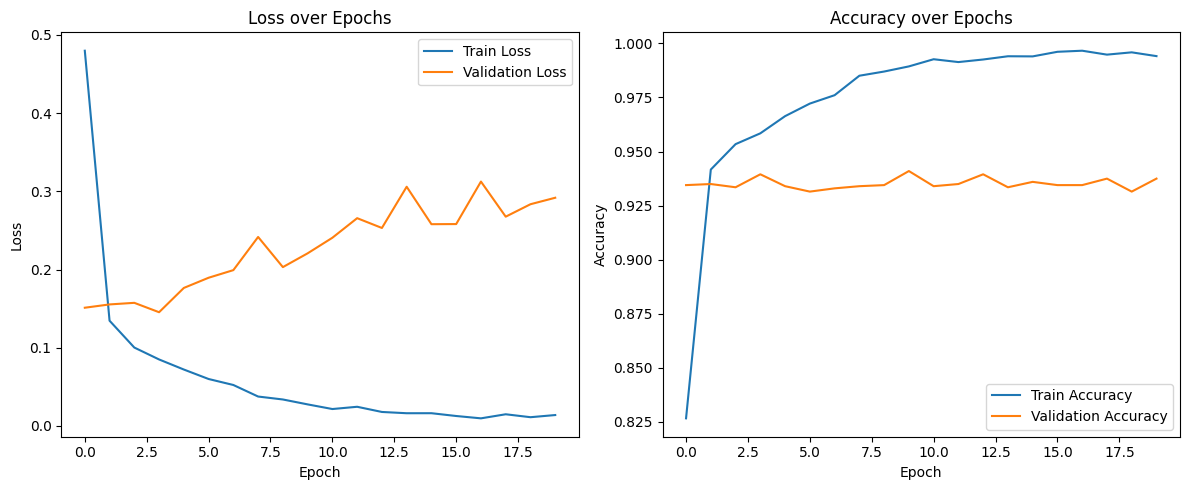

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1. Load Dataset
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']

# 2. Tokenization
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=128,
    )
train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# 3. Dataset Class
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx],
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)

# 4. Mean Pooling
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# 5. Classifier Model
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# 6. Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(label_list)
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# 7. Metrics Storage
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(model, dataloader):
    model.eval()
    loss = 0
    preds, labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)
            outputs = model(input_ids, attn_mask)
            batch_loss = criterion(outputs, targets)
            loss += batch_loss.item()
            preds += torch.argmax(outputs, dim=1).cpu().tolist()
            labels += targets.cpu().tolist()
    avg_loss = loss / len(dataloader)
    acc = accuracy_score(labels, preds)
    return avg_loss, acc

def train_model(epochs):
    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        all_preds, all_labels = [], []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attn_mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            all_preds += torch.argmax(outputs, dim=1).cpu().tolist()
            all_labels += targets.cpu().tolist()
        train_acc = accuracy_score(all_labels, all_preds)
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)
        val_loss, val_acc = evaluate(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch+1}: Train Loss {train_losses[-1]:.4f} | Train Acc {train_acc:.4f} | Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

train_model(epochs=20)

# 8. Plotting curves
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.tight_layout()
plt.show()


New arch

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, get_scheduler
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# ====================================
# 1. Device check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type != 'cuda':
    print("Warning: CPU training will be slow")

# ====================================
# 2. Load dataset
ds = load_dataset("dair-ai/emotion", "split")
labels = ds['train'].features['label'].names
train_texts, train_labels = ds['train']['text'], ds['train']['label']
val_texts, val_labels = ds['validation']['text'], ds['validation']['label']
test_texts, test_labels = ds['test']['text'], ds['test']['label']

# ====================================
# 3. Tokenization
model_name = "microsoft/mdeberta-v3-base"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)
train_enc = tokenize(train_texts); val_enc = tokenize(val_texts); test_enc = tokenize(test_texts)

class EmotionDataset(Dataset):
    def __init__(self, enc, labels):
        self.enc, self.labels = enc, labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.enc['input_ids'][idx]),
            'attention_mask': torch.tensor(self.enc['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_ds = EmotionDataset(train_enc, train_labels)
val_ds = EmotionDataset(val_enc, val_labels)
test_ds = EmotionDataset(test_enc, test_labels)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

# ====================================
# 4. Custom ESAH Transformer block
class ESAHAttention(nn.Module):
    def __init__(self, dim, num_heads=4, ff_hidden=256, dropout=0.2):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, ff_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_hidden, dim),
        )
        self.norm2 = nn.LayerNorm(dim)
    def forward(self, x):
        # x shape: (batch, 1, dim)
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x  # still shape (batch,1,dim)

# ====================================
# 5. Full model combining DeBERTa + ESAH + classifier
class EmotionModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        dim = self.encoder.config.hidden_size
        self.esah = ESAHAttention(dim)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(dim, dim//2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(dim//2, num_labels)
        )
    def forward(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        token_repr = out.last_hidden_state[:,0,:].unsqueeze(1)  # CLS token representation
        attended = self.esah(token_repr).squeeze(1)
        x = self.dropout(attended)
        return self.classifier(x)

# ====================================
# 6. Setup training
num_labels = len(labels)
model = EmotionModel(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=int(len(train_loader)*2),
    num_training_steps=len(train_loader)*10
)
criterion = nn.CrossEntropyLoss()

# ====================================
# 7. Training + validation loop with early stopping
best_val_acc, no_improve = 0.0, 0
max_epochs, patience = 10, 3
train_accs, val_accs = [], []

def evaluate(dl):
    model.eval(); preds, trues = [], []
    with torch.no_grad():
        for b in dl:
            input_ids = b['input_ids'].to(device)
            mask = b['attention_mask'].to(device)
            out = model(input_ids, mask)
            preds.extend(torch.argmax(out, dim=1).cpu().numpy())
            trues.extend(b['labels'].numpy())
    return accuracy_score(trues,preds)

for epoch in range(max_epochs):
    model.train()
    for b in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        out = model(b['input_ids'].to(device), b['attention_mask'].to(device))
        loss = criterion(out, b['labels'].to(device))
        loss.backward(); optimizer.step(); scheduler.step()
    tr_acc = evaluate(train_loader)
    val_acc = evaluate(val_loader)
    train_accs.append(tr_acc); val_accs.append(val_acc)
    print(f"[{epoch+1}] train_acc={tr_acc:.4f}, val_acc={val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc; no_improve = 0
        torch.save(model.state_dict(), "best_model.bin")
    else:
        no_improve += 1
    if no_improve>=patience:
        print("Early stopping triggered."); break

print("Best val accuracy:", best_val_acc)
model.load_state_dict(torch.load("best_model.bin"))

# ====================================
# 8. Test evaluation
test_acc = evaluate(test_loader)
print("Test set accuracy:", test_acc)

# ====================================
# 9. Plot accuracy
plt.plot(train_accs, label='train')
plt.plot(val_accs, label='val')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.show()


Using device: cuda


ValueError: Converting from SentencePiece and Tiktoken failed, if a converter for SentencePiece is available, provide a model path with a SentencePiece tokenizer.model file.Currently available slow->fast converters: ['AlbertTokenizer', 'BartTokenizer', 'BarthezTokenizer', 'BertTokenizer', 'BigBirdTokenizer', 'BlenderbotTokenizer', 'CamembertTokenizer', 'CLIPTokenizer', 'CodeGenTokenizer', 'ConvBertTokenizer', 'DebertaTokenizer', 'DebertaV2Tokenizer', 'DistilBertTokenizer', 'DPRReaderTokenizer', 'DPRQuestionEncoderTokenizer', 'DPRContextEncoderTokenizer', 'ElectraTokenizer', 'FNetTokenizer', 'FunnelTokenizer', 'GPT2Tokenizer', 'HerbertTokenizer', 'LayoutLMTokenizer', 'LayoutLMv2Tokenizer', 'LayoutLMv3Tokenizer', 'LayoutXLMTokenizer', 'LongformerTokenizer', 'LEDTokenizer', 'LxmertTokenizer', 'MarkupLMTokenizer', 'MBartTokenizer', 'MBart50Tokenizer', 'MPNetTokenizer', 'MobileBertTokenizer', 'MvpTokenizer', 'NllbTokenizer', 'OpenAIGPTTokenizer', 'PegasusTokenizer', 'Qwen2Tokenizer', 'RealmTokenizer', 'ReformerTokenizer', 'RemBertTokenizer', 'RetriBertTokenizer', 'RobertaTokenizer', 'RoFormerTokenizer', 'SeamlessM4TTokenizer', 'SqueezeBertTokenizer', 'T5Tokenizer', 'UdopTokenizer', 'WhisperTokenizer', 'XLMRobertaTokenizer', 'XLNetTokenizer', 'SplinterTokenizer', 'XGLMTokenizer', 'LlamaTokenizer', 'CodeLlamaTokenizer', 'GemmaTokenizer', 'Phi3Tokenizer']

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_dataset
import numpy as np

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

# Load Emotion dataset with pre-defined splits
print("Loading Emotion dataset...")
ds = load_dataset("dair-ai/emotion", "split")
labels = ds['train'].features['label'].names
train_texts, train_labels = ds['train']['text'], ds['train']['label']
val_texts, val_labels = ds['validation']['text'], ds['validation']['label']
test_texts, test_labels = ds['test']['text'], ds['test']['label']

print(f"Train samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Test samples: {len(test_texts)}")

# Get emotion labels directly from dataset features
emotion_labels = labels
print(f"Emotion labels: {emotion_labels}")

# Convert numeric labels to string labels for better interpretability
train_labels_str = [emotion_labels[label] for label in train_labels]
val_labels_str = [emotion_labels[label] for label in val_labels]
test_labels_str = [emotion_labels[label] for label in test_labels]

print(f"Training emotion distribution: {dict(zip(*np.unique(train_labels_str, return_counts=True)))}")
print(f"Validation emotion distribution: {dict(zip(*np.unique(val_labels_str, return_counts=True)))}")

# Label encode for consistency
label_encoder = LabelEncoder()
# Fit on all labels to ensure consistency across splits
all_labels = train_labels_str + val_labels_str + test_labels_str
label_encoder.fit(all_labels)

train_labels_encoded = label_encoder.transform(train_labels_str)
val_labels_encoded = label_encoder.transform(val_labels_str)
test_labels_encoded = label_encoder.transform(test_labels_str)

num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

# Dataset Class
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        text = str(self.texts[idx])  # Ensure text is string
        label = self.labels[idx]
        tokens = self.tokenizer(text, 
                               padding='max_length', 
                               truncation=True,
                               return_tensors='pt', 
                               max_length=self.max_length)
        return tokens['input_ids'].squeeze(0), tokens['attention_mask'].squeeze(0), label

    def __len__(self):
        return len(self.labels)

# Create datasets and dataloaders for all splits
train_emotion_dataset = EmotionDataset(train_texts, train_labels_encoded, tokenizer)
val_emotion_dataset = EmotionDataset(val_texts, val_labels_encoded, tokenizer)
test_emotion_dataset = EmotionDataset(test_texts, test_labels_encoded, tokenizer)

train_dataloader = DataLoader(train_emotion_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_emotion_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_emotion_dataset, batch_size=16, shuffle=False)

# Compute class weights for imbalanced data (based on training set)
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_labels_encoded),
                                     y=train_labels_encoded)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Class weights: {class_weights}")

# Model with LMU-like memory simulation
class LMUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, memory_dim, num_classes):
        super().__init__()
        self.bert = bert_model
        self.memory_fc = nn.Linear(input_dim, memory_dim)
        self.hidden_fc = nn.Linear(input_dim + memory_dim, hidden_dim)
        self.residual_proj = nn.Linear(input_dim, hidden_dim)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            
        tokens = outputs.last_hidden_state  # shape (B, T, 768)
        pooled = tokens.mean(dim=1)         # [B, 768]

        memory = self.memory_fc(pooled)     # [B, memory_dim]
        combined = torch.cat([pooled, memory], dim=1)  # [B, 768+memory_dim]

        hidden = torch.tanh(self.hidden_fc(combined))  # [B, hidden_dim]
        residual = self.residual_proj(pooled)          # project pooled → [B, hidden_dim]
        hidden = self.norm(hidden + residual)          # match sizes before add
        hidden = self.dropout(hidden)

        return self.classifier(hidden)

# Instantiate model
model = LMUClassifier(input_dim=768, hidden_dim=256, memory_dim=128, num_classes=num_classes).to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Calculate total training steps
num_epochs = 5
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=int(0.1 * total_steps),
                                            num_training_steps=total_steps)

print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {int(0.1 * total_steps)}")

# Training function
def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    
    with torch.no_grad():
        for input_ids, attn_mask, labels in dataloader:
            input_ids, attn_mask, labels = input_ids.to(device), attn_mask.to(device), labels.to(device)
            
            logits = model(input_ids, attn_mask)
            loss = criterion(logits, labels)
            
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item()
    
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    avg_loss = total_loss / len(dataloader)
    
    return acc, f1, avg_loss

# Training loop
print("\nStarting training...")
for epoch in range(num_epochs):
    model.train()
    all_preds, all_labels = [], []
    total_loss = 0

    for batch_idx, (input_ids, attn_mask, labels) in enumerate(train_dataloader):
        input_ids, attn_mask, labels = input_ids.to(device), attn_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attn_mask)
        loss = criterion(logits, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total_loss += loss.item()
        
        # Print progress every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

    # Calculate training metrics
    train_acc = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average="weighted")
    avg_train_loss = total_loss / len(train_dataloader)
    
    # Evaluate on validation set
    val_acc, val_f1, val_loss = evaluate_model(model, val_dataloader)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train - Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
    print("-" * 60)

print("Training completed!")

# Final evaluation on test set
print("\nEvaluating on test set...")
test_acc, test_f1, test_loss = evaluate_model(model, test_dataloader)
print(f"Test Results - Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}")

# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'label_encoder': label_encoder,
    'emotion_classes': emotion_labels,
    'test_accuracy': test_acc,
    'test_f1': test_f1
}, 'emotion_classifier_emotion_dataset.pth')

print("Model saved as 'emotion_classifier_emotion_dataset.pth'")

Loading Emotion dataset...
Train samples: 16000
Validation samples: 2000
Test samples: 2000
Emotion labels: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Training emotion distribution: {np.str_('anger'): np.int64(2159), np.str_('fear'): np.int64(1937), np.str_('joy'): np.int64(5362), np.str_('love'): np.int64(1304), np.str_('sadness'): np.int64(4666), np.str_('surprise'): np.int64(572)}
Validation emotion distribution: {np.str_('anger'): np.int64(275), np.str_('fear'): np.int64(212), np.str_('joy'): np.int64(704), np.str_('love'): np.int64(178), np.str_('sadness'): np.int64(550), np.str_('surprise'): np.int64(81)}
Number of classes: 6
Classes: ['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']
Class weights: tensor([1.2351, 1.3767, 0.4973, 2.0450, 0.5715, 4.6620], device='cuda:0')
Total training steps: 5000
Warmup steps: 500

Starting training...
Epoch 1/5, Batch 100/1000, Loss: 1.9700
Epoch 1/5, Batch 200/1000, Loss: 1.2049
Epoch 1/5, Batch 300/1000, Loss: 0.9752
Epoch 1/5, 

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_dataset
import numpy as np

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and model
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
transformer_model = AutoModel.from_pretrained(model_name).to(device)

# Load Emotion dataset with pre-defined splits
print("Loading Emotion dataset...")
ds = load_dataset("dair-ai/emotion", "split")
labels = ds['train'].features['label'].names
train_texts, train_labels = ds['train']['text'], ds['train']['label']
val_texts, val_labels = ds['validation']['text'], ds['validation']['label']
test_texts, test_labels = ds['test']['text'], ds['test']['label']

print(f"Train samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Test samples: {len(test_texts)}")

# Get emotion labels directly from dataset features
emotion_labels = labels
print(f"Emotion labels: {emotion_labels}")

# Convert numeric labels to string labels for better interpretability
train_labels_str = [emotion_labels[label] for label in train_labels]
val_labels_str = [emotion_labels[label] for label in val_labels]
test_labels_str = [emotion_labels[label] for label in test_labels]

print(f"Training emotion distribution: {dict(zip(*np.unique(train_labels_str, return_counts=True)))}")
print(f"Validation emotion distribution: {dict(zip(*np.unique(val_labels_str, return_counts=True)))}")

# Label encode for consistency
label_encoder = LabelEncoder()
# Fit on all labels to ensure consistency across splits
all_labels = train_labels_str + val_labels_str + test_labels_str
label_encoder.fit(all_labels)

train_labels_encoded = label_encoder.transform(train_labels_str)
val_labels_encoded = label_encoder.transform(val_labels_str)
test_labels_encoded = label_encoder.transform(test_labels_str)

num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

# Dataset Class
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        text = str(self.texts[idx])  # Ensure text is string
        label = self.labels[idx]
        tokens = self.tokenizer(text, 
                               padding='max_length', 
                               truncation=True,
                               return_tensors='pt', 
                               max_length=self.max_length)
        return tokens['input_ids'].squeeze(0), tokens['attention_mask'].squeeze(0), label

    def __len__(self):
        return len(self.labels)

# Create datasets and dataloaders for all splits
train_emotion_dataset = EmotionDataset(train_texts, train_labels_encoded, tokenizer)
val_emotion_dataset = EmotionDataset(val_texts, val_labels_encoded, tokenizer)
test_emotion_dataset = EmotionDataset(test_texts, test_labels_encoded, tokenizer)

train_dataloader = DataLoader(train_emotion_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_emotion_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_emotion_dataset, batch_size=16, shuffle=False)

# Compute class weights for imbalanced data (based on training set)
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_labels_encoded),
                                     y=train_labels_encoded)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Class weights: {class_weights}")

# Model with LMU-like memory simulation
class LMUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, memory_dim, num_classes):
        super().__init__()
        self.transformer = transformer_model
        self.memory_fc = nn.Linear(input_dim, memory_dim)
        self.hidden_fc = nn.Linear(input_dim + memory_dim, hidden_dim)
        self.residual_proj = nn.Linear(input_dim, hidden_dim)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        tokens = outputs.last_hidden_state  # shape (B, T, 768)
        pooled = tokens.mean(dim=1)         # [B, 768]

        memory = self.memory_fc(pooled)     # [B, memory_dim]
        combined = torch.cat([pooled, memory], dim=1)  # [B, 768+memory_dim]

        hidden = torch.tanh(self.hidden_fc(combined))  # [B, hidden_dim]
        residual = self.residual_proj(pooled)          # project pooled → [B, hidden_dim]
        hidden = self.norm(hidden + residual)          # match sizes before add
        hidden = self.dropout(hidden)

        return self.classifier(hidden)

# Instantiate model
model = LMUClassifier(input_dim=768, hidden_dim=256, memory_dim=128, num_classes=num_classes).to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Calculate total training steps
num_epochs = 20
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=int(0.1 * total_steps),
                                            num_training_steps=total_steps)

print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {int(0.1 * total_steps)}")

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    
    with torch.no_grad():
        for input_ids, attn_mask, labels in dataloader:
            input_ids, attn_mask, labels = input_ids.to(device), attn_mask.to(device), labels.to(device)
            
            logits = model(input_ids, attn_mask)
            loss = criterion(logits, labels)
            
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item()
    
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    avg_loss = total_loss / len(dataloader)
    
    return acc, f1, avg_loss

# Training loop
print("\nStarting training...")
for epoch in range(num_epochs):
    model.train()
    all_preds, all_labels = [], []
    total_loss = 0

    for batch_idx, (input_ids, attn_mask, labels) in enumerate(train_dataloader):
        input_ids, attn_mask, labels = input_ids.to(device), attn_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attn_mask)
        loss = criterion(logits, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total_loss += loss.item()
        
        # Print progress every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

    # Calculate training metrics
    train_acc = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average="weighted")
    avg_train_loss = total_loss / len(train_dataloader)
    
    # Evaluate on validation set
    val_acc, val_f1, val_loss = evaluate_model(model, val_dataloader)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train - Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
    print("-" * 60)

print("Training completed!")

# Final evaluation on test set
print("\nEvaluating on test set...")
test_acc, test_f1, test_loss = evaluate_model(model, test_dataloader)
print(f"Test Results - Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}")

# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'label_encoder': label_encoder,
    'emotion_classes': emotion_labels,
    'test_accuracy': test_acc,
    'test_f1': test_f1
}, 'emotion_classifier_emotion_dataset.pth')

print("Model saved as 'emotion_classifier_emotion_dataset.pth'")


Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading Emotion dataset...
Train samples: 16000
Validation samples: 2000
Test samples: 2000
Emotion labels: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Training emotion distribution: {np.str_('anger'): np.int64(2159), np.str_('fear'): np.int64(1937), np.str_('joy'): np.int64(5362), np.str_('love'): np.int64(1304), np.str_('sadness'): np.int64(4666), np.str_('surprise'): np.int64(572)}
Validation emotion distribution: {np.str_('anger'): np.int64(275), np.str_('fear'): np.int64(212), np.str_('joy'): np.int64(704), np.str_('love'): np.int64(178), np.str_('sadness'): np.int64(550), np.str_('surprise'): np.int64(81)}
Number of classes: 6
Classes: ['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']
Class weights: tensor([1.2351, 1.3767, 0.4973, 2.0450, 0.5715, 4.6620], device='cuda:0')
Total training steps: 20000
Warmup steps: 2000

Starting training...
Epoch 1/20, Batch 100/1000, Loss: 2.0300
Epoch 1/20, Batch 200/1000, Loss: 0.8545
Epoch 1/20, Batch 300/1000, Loss: 0.3616
Epoch 

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_dataset
import numpy as np

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model name
model_name = "j-hartmann/emotion-english-distilroberta-base"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load Emotion dataset with pre-defined splits
print("Loading Emotion dataset...")
ds = load_dataset("dair-ai/emotion", "split")
labels = ds['train'].features['label'].names
train_texts, train_labels = ds['train']['text'], ds['train']['label']
val_texts, val_labels = ds['validation']['text'], ds['validation']['label']
test_texts, test_labels = ds['test']['text'], ds['test']['label']

# Convert numeric labels to string labels
emotion_labels = labels
train_labels_str = [emotion_labels[l] for l in train_labels]
val_labels_str = [emotion_labels[l] for l in val_labels]
test_labels_str = [emotion_labels[l] for l in test_labels]

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(train_labels_str + val_labels_str + test_labels_str)

train_labels_encoded = label_encoder.transform(train_labels_str)
val_labels_encoded = label_encoder.transform(val_labels_str)
test_labels_encoded = label_encoder.transform(test_labels_str)

num_classes = len(label_encoder.classes_)
print(f"Classes: {label_encoder.classes_}")

# Dataset class
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0), label

    def __len__(self):
        return len(self.labels)

# Create datasets and dataloaders
train_dataset = EmotionDataset(train_texts, train_labels_encoded, tokenizer)
val_dataset = EmotionDataset(val_texts, val_labels_encoded, tokenizer)
test_dataset = EmotionDataset(test_texts, test_labels_encoded, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels_encoded),
    y=train_labels_encoded
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Load base model
base_model = AutoModel.from_pretrained(model_name)

# Custom classifier
class EmotionClassifier(nn.Module):
    def __init__(self, base_model, num_classes):
        super().__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(base_model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]  # CLS token
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(weight=class_weights)
            loss = loss_fn(logits, labels)

        return {'loss': loss, 'logits': logits}

# Instantiate model
model = EmotionClassifier(base_model, num_classes).to(device)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
epochs = 20
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for input_ids, attn_mask, labels in dataloader:
            input_ids, attn_mask, labels = input_ids.to(device), attn_mask.to(device), labels.to(device)
            outputs = model(input_ids, attn_mask, labels)
            loss = outputs['loss']
            logits = outputs['logits']

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return avg_loss, acc, f1

# Training loop
print("Starting training...")
for epoch in range(epochs):
    model.train()
    all_preds, all_labels = [], []
    total_loss = 0

    for batch_idx, (input_ids, attn_mask, labels) in enumerate(train_loader):
        input_ids, attn_mask, labels = input_ids.to(device), attn_mask.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(input_ids, attn_mask, labels)
        loss = outputs['loss']
        logits = outputs['logits']
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch {epoch+1}, Step {batch_idx+1}, Loss: {loss.item():.4f}")

    train_acc = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average='weighted')
    train_loss = total_loss / len(train_loader)

    val_loss, val_acc, val_f1 = evaluate(model, val_loader)

    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
    print("-" * 60)

print("Training complete!")

# Final test evaluation
test_loss, test_acc, test_f1 = evaluate(model, test_loader)
print(f"\nTest - Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}")

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'label_encoder': label_encoder,
    'classes': label_encoder.classes_,
    'test_acc': test_acc,
    'test_f1': test_f1
}, 'emotion_model_jhartmann_fixed.pth')

print("Model saved as 'emotion_model_jhartmann_fixed.pth'")


Loading Emotion dataset...
Classes: ['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']


Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...
Epoch 1, Step 100, Loss: 1.6608
Epoch 1, Step 200, Loss: 1.4504
Epoch 1, Step 300, Loss: 0.8025
Epoch 1, Step 400, Loss: 0.7688
Epoch 1, Step 500, Loss: 0.3657
Epoch 1, Step 600, Loss: 0.3205
Epoch 1, Step 700, Loss: 0.2325
Epoch 1, Step 800, Loss: 0.4622
Epoch 1, Step 900, Loss: 0.4111
Epoch 1, Step 1000, Loss: 0.0882

Epoch 1/20
Train - Loss: 0.7500, Acc: 0.7529, F1: 0.7646
Val   - Loss: 0.2842, Acc: 0.9020, F1: 0.9045
------------------------------------------------------------
Epoch 2, Step 100, Loss: 0.0294
Epoch 2, Step 200, Loss: 0.4325
Epoch 2, Step 300, Loss: 0.7881
Epoch 2, Step 400, Loss: 0.2702
Epoch 2, Step 500, Loss: 0.0453
Epoch 2, Step 600, Loss: 0.1419
Epoch 2, Step 700, Loss: 0.4004
Epoch 2, Step 800, Loss: 0.1401
Epoch 2, Step 900, Loss: 0.3147
Epoch 2, Step 1000, Loss: 0.0072

Epoch 2/20
Train - Loss: 0.2623, Acc: 0.9179, F1: 0.9193
Val   - Loss: 0.2045, Acc: 0.9300, F1: 0.9311
------------------------------------------------------------
Epoch 3

d:\SRH\Emotion Detection Text\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



🖥️  Using device: cuda



Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 500/500 [02:12<00:00,  3.78it/s]



📊 Epoch 1:
  Train Loss: 0.3204 | Train Acc: 0.8878
  Val   Loss: 0.1656 | Val   Acc: 0.9275


Epoch 2: 100%|██████████| 500/500 [02:15<00:00,  3.70it/s]



📊 Epoch 2:
  Train Loss: 0.1519 | Train Acc: 0.9353
  Val   Loss: 0.1506 | Val   Acc: 0.9335


Epoch 3: 100%|██████████| 500/500 [02:12<00:00,  3.77it/s]



📊 Epoch 3:
  Train Loss: 0.1139 | Train Acc: 0.9464
  Val   Loss: 0.1350 | Val   Acc: 0.9365


Epoch 4: 100%|██████████| 500/500 [01:33<00:00,  5.34it/s]



📊 Epoch 4:
  Train Loss: 0.0981 | Train Acc: 0.9541
  Val   Loss: 0.1292 | Val   Acc: 0.9395


Epoch 5: 100%|██████████| 500/500 [01:32<00:00,  5.38it/s]



📊 Epoch 5:
  Train Loss: 0.0832 | Train Acc: 0.9591
  Val   Loss: 0.1418 | Val   Acc: 0.9380


Epoch 6: 100%|██████████| 500/500 [01:32<00:00,  5.40it/s]



📊 Epoch 6:
  Train Loss: 0.0784 | Train Acc: 0.9624
  Val   Loss: 0.1349 | Val   Acc: 0.9410


Epoch 7: 100%|██████████| 500/500 [01:32<00:00,  5.38it/s]



📊 Epoch 7:
  Train Loss: 0.0719 | Train Acc: 0.9657
  Val   Loss: 0.1364 | Val   Acc: 0.9435


Epoch 8: 100%|██████████| 500/500 [01:37<00:00,  5.14it/s]



📊 Epoch 8:
  Train Loss: 0.0662 | Train Acc: 0.9675
  Val   Loss: 0.1432 | Val   Acc: 0.9355


Epoch 9: 100%|██████████| 500/500 [01:34<00:00,  5.31it/s]



📊 Epoch 9:
  Train Loss: 0.0583 | Train Acc: 0.9719
  Val   Loss: 0.1564 | Val   Acc: 0.9350


Epoch 10: 100%|██████████| 500/500 [01:33<00:00,  5.33it/s]



📊 Epoch 10:
  Train Loss: 0.0543 | Train Acc: 0.9759
  Val   Loss: 0.1720 | Val   Acc: 0.9350


Epoch 11: 100%|██████████| 500/500 [01:33<00:00,  5.35it/s]



📊 Epoch 11:
  Train Loss: 0.0509 | Train Acc: 0.9778
  Val   Loss: 0.1585 | Val   Acc: 0.9345


Epoch 12: 100%|██████████| 500/500 [01:32<00:00,  5.38it/s]



📊 Epoch 12:
  Train Loss: 0.0431 | Train Acc: 0.9808
  Val   Loss: 0.1723 | Val   Acc: 0.9360


Epoch 13: 100%|██████████| 500/500 [01:32<00:00,  5.39it/s]



📊 Epoch 13:
  Train Loss: 0.0349 | Train Acc: 0.9859
  Val   Loss: 0.1754 | Val   Acc: 0.9400


Epoch 14: 100%|██████████| 500/500 [01:32<00:00,  5.41it/s]



📊 Epoch 14:
  Train Loss: 0.0336 | Train Acc: 0.9862
  Val   Loss: 0.2009 | Val   Acc: 0.9365


Epoch 15: 100%|██████████| 500/500 [01:32<00:00,  5.40it/s]



📊 Epoch 15:
  Train Loss: 0.0275 | Train Acc: 0.9892
  Val   Loss: 0.2290 | Val   Acc: 0.9395


Epoch 16: 100%|██████████| 500/500 [01:32<00:00,  5.39it/s]



📊 Epoch 16:
  Train Loss: 0.0279 | Train Acc: 0.9894
  Val   Loss: 0.2006 | Val   Acc: 0.9410


Epoch 17: 100%|██████████| 500/500 [01:32<00:00,  5.40it/s]



📊 Epoch 17:
  Train Loss: 0.0259 | Train Acc: 0.9896
  Val   Loss: 0.1973 | Val   Acc: 0.9390


Epoch 18: 100%|██████████| 500/500 [01:32<00:00,  5.39it/s]



📊 Epoch 18:
  Train Loss: 0.0192 | Train Acc: 0.9921
  Val   Loss: 0.2091 | Val   Acc: 0.9415


Epoch 19: 100%|██████████| 500/500 [01:32<00:00,  5.39it/s]



📊 Epoch 19:
  Train Loss: 0.0187 | Train Acc: 0.9936
  Val   Loss: 0.2186 | Val   Acc: 0.9390


Epoch 20: 100%|██████████| 500/500 [01:32<00:00,  5.40it/s]



📊 Epoch 20:
  Train Loss: 0.0163 | Train Acc: 0.9934
  Val   Loss: 0.2711 | Val   Acc: 0.9365


Epoch 21: 100%|██████████| 500/500 [01:32<00:00,  5.40it/s]



📊 Epoch 21:
  Train Loss: 0.0176 | Train Acc: 0.9932
  Val   Loss: 0.2238 | Val   Acc: 0.9415


Epoch 22: 100%|██████████| 500/500 [01:32<00:00,  5.40it/s]



📊 Epoch 22:
  Train Loss: 0.0192 | Train Acc: 0.9932
  Val   Loss: 0.2468 | Val   Acc: 0.9345


Epoch 23: 100%|██████████| 500/500 [01:32<00:00,  5.41it/s]



📊 Epoch 23:
  Train Loss: 0.0171 | Train Acc: 0.9934
  Val   Loss: 0.2333 | Val   Acc: 0.9405


Epoch 24: 100%|██████████| 500/500 [01:34<00:00,  5.28it/s]



📊 Epoch 24:
  Train Loss: 0.0143 | Train Acc: 0.9945
  Val   Loss: 0.2712 | Val   Acc: 0.9350


Epoch 25: 100%|██████████| 500/500 [01:37<00:00,  5.12it/s]



📊 Epoch 25:
  Train Loss: 0.0120 | Train Acc: 0.9952
  Val   Loss: 0.2741 | Val   Acc: 0.9320


Epoch 26: 100%|██████████| 500/500 [01:38<00:00,  5.06it/s]



📊 Epoch 26:
  Train Loss: 0.0129 | Train Acc: 0.9949
  Val   Loss: 0.2581 | Val   Acc: 0.9380


Epoch 27: 100%|██████████| 500/500 [01:39<00:00,  5.03it/s]



📊 Epoch 27:
  Train Loss: 0.0155 | Train Acc: 0.9948
  Val   Loss: 0.2530 | Val   Acc: 0.9360


Epoch 28: 100%|██████████| 500/500 [01:40<00:00,  4.99it/s]



📊 Epoch 28:
  Train Loss: 0.0114 | Train Acc: 0.9955
  Val   Loss: 0.2835 | Val   Acc: 0.9365


Epoch 29: 100%|██████████| 500/500 [01:40<00:00,  4.98it/s]



📊 Epoch 29:
  Train Loss: 0.0100 | Train Acc: 0.9959
  Val   Loss: 0.2609 | Val   Acc: 0.9375


Epoch 30: 100%|██████████| 500/500 [01:36<00:00,  5.16it/s]



📊 Epoch 30:
  Train Loss: 0.0100 | Train Acc: 0.9961
  Val   Loss: 0.2754 | Val   Acc: 0.9320


Epoch 31: 100%|██████████| 500/500 [01:35<00:00,  5.25it/s]



📊 Epoch 31:
  Train Loss: 0.0092 | Train Acc: 0.9962
  Val   Loss: 0.3121 | Val   Acc: 0.9355


Epoch 32: 100%|██████████| 500/500 [01:35<00:00,  5.25it/s]



📊 Epoch 32:
  Train Loss: 0.0089 | Train Acc: 0.9959
  Val   Loss: 0.2552 | Val   Acc: 0.9395


Epoch 33: 100%|██████████| 500/500 [01:35<00:00,  5.22it/s]



📊 Epoch 33:
  Train Loss: 0.0092 | Train Acc: 0.9964
  Val   Loss: 0.2881 | Val   Acc: 0.9400


Epoch 34: 100%|██████████| 500/500 [01:34<00:00,  5.27it/s]



📊 Epoch 34:
  Train Loss: 0.0079 | Train Acc: 0.9964
  Val   Loss: 0.2848 | Val   Acc: 0.9350


Epoch 35: 100%|██████████| 500/500 [01:35<00:00,  5.25it/s]



📊 Epoch 35:
  Train Loss: 0.0080 | Train Acc: 0.9966
  Val   Loss: 0.2803 | Val   Acc: 0.9350


Epoch 36: 100%|██████████| 500/500 [01:35<00:00,  5.26it/s]



📊 Epoch 36:
  Train Loss: 0.0080 | Train Acc: 0.9967
  Val   Loss: 0.2779 | Val   Acc: 0.9370


Epoch 37: 100%|██████████| 500/500 [01:34<00:00,  5.29it/s]



📊 Epoch 37:
  Train Loss: 0.0097 | Train Acc: 0.9968
  Val   Loss: 0.3058 | Val   Acc: 0.9385


Epoch 38: 100%|██████████| 500/500 [01:34<00:00,  5.29it/s]



📊 Epoch 38:
  Train Loss: 0.0090 | Train Acc: 0.9961
  Val   Loss: 0.2773 | Val   Acc: 0.9415


Epoch 39: 100%|██████████| 500/500 [01:34<00:00,  5.27it/s]



📊 Epoch 39:
  Train Loss: 0.0088 | Train Acc: 0.9968
  Val   Loss: 0.3065 | Val   Acc: 0.9365


Epoch 40: 100%|██████████| 500/500 [01:34<00:00,  5.29it/s]



📊 Epoch 40:
  Train Loss: 0.0074 | Train Acc: 0.9966
  Val   Loss: 0.2790 | Val   Acc: 0.9375


Epoch 41: 100%|██████████| 500/500 [01:34<00:00,  5.28it/s]



📊 Epoch 41:
  Train Loss: 0.0048 | Train Acc: 0.9978
  Val   Loss: 0.2962 | Val   Acc: 0.9380


Epoch 42: 100%|██████████| 500/500 [01:35<00:00,  5.26it/s]



📊 Epoch 42:
  Train Loss: 0.0059 | Train Acc: 0.9972
  Val   Loss: 0.3039 | Val   Acc: 0.9425


Epoch 43: 100%|██████████| 500/500 [01:34<00:00,  5.28it/s]



📊 Epoch 43:
  Train Loss: 0.0068 | Train Acc: 0.9968
  Val   Loss: 0.3318 | Val   Acc: 0.9415


Epoch 44: 100%|██████████| 500/500 [01:34<00:00,  5.28it/s]



📊 Epoch 44:
  Train Loss: 0.0083 | Train Acc: 0.9964
  Val   Loss: 0.3361 | Val   Acc: 0.9350


Epoch 45: 100%|██████████| 500/500 [01:35<00:00,  5.25it/s]



📊 Epoch 45:
  Train Loss: 0.0055 | Train Acc: 0.9976
  Val   Loss: 0.3074 | Val   Acc: 0.9410


Epoch 46: 100%|██████████| 500/500 [01:38<00:00,  5.09it/s]



📊 Epoch 46:
  Train Loss: 0.0065 | Train Acc: 0.9972
  Val   Loss: 0.3066 | Val   Acc: 0.9430


Epoch 47: 100%|██████████| 500/500 [01:40<00:00,  4.97it/s]



📊 Epoch 47:
  Train Loss: 0.0077 | Train Acc: 0.9962
  Val   Loss: 0.3024 | Val   Acc: 0.9345


Epoch 48: 100%|██████████| 500/500 [01:34<00:00,  5.31it/s]



📊 Epoch 48:
  Train Loss: 0.0063 | Train Acc: 0.9971
  Val   Loss: 0.3149 | Val   Acc: 0.9365


Epoch 49: 100%|██████████| 500/500 [01:34<00:00,  5.30it/s]



📊 Epoch 49:
  Train Loss: 0.0071 | Train Acc: 0.9969
  Val   Loss: 0.3035 | Val   Acc: 0.9350


Epoch 50: 100%|██████████| 500/500 [01:32<00:00,  5.41it/s]



📊 Epoch 50:
  Train Loss: 0.0056 | Train Acc: 0.9972
  Val   Loss: 0.3239 | Val   Acc: 0.9375


Epoch 51: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 51:
  Train Loss: 0.0046 | Train Acc: 0.9973
  Val   Loss: 0.3372 | Val   Acc: 0.9340


Epoch 52: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 52:
  Train Loss: 0.0053 | Train Acc: 0.9975
  Val   Loss: 0.3258 | Val   Acc: 0.9365


Epoch 53: 100%|██████████| 500/500 [01:34<00:00,  5.30it/s]



📊 Epoch 53:
  Train Loss: 0.0062 | Train Acc: 0.9971
  Val   Loss: 0.3226 | Val   Acc: 0.9390


Epoch 54: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 54:
  Train Loss: 0.0054 | Train Acc: 0.9971
  Val   Loss: 0.3293 | Val   Acc: 0.9380


Epoch 55: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 55:
  Train Loss: 0.0038 | Train Acc: 0.9976
  Val   Loss: 0.3454 | Val   Acc: 0.9360


Epoch 56: 100%|██████████| 500/500 [01:32<00:00,  5.40it/s]



📊 Epoch 56:
  Train Loss: 0.0052 | Train Acc: 0.9968
  Val   Loss: 0.3603 | Val   Acc: 0.9365


Epoch 57: 100%|██████████| 500/500 [01:32<00:00,  5.40it/s]



📊 Epoch 57:
  Train Loss: 0.0061 | Train Acc: 0.9968
  Val   Loss: 0.3634 | Val   Acc: 0.9370


Epoch 58: 100%|██████████| 500/500 [01:32<00:00,  5.41it/s]



📊 Epoch 58:
  Train Loss: 0.0054 | Train Acc: 0.9971
  Val   Loss: 0.3496 | Val   Acc: 0.9405


Epoch 59: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 59:
  Train Loss: 0.0046 | Train Acc: 0.9970
  Val   Loss: 0.3432 | Val   Acc: 0.9375


Epoch 60: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 60:
  Train Loss: 0.0046 | Train Acc: 0.9971
  Val   Loss: 0.3566 | Val   Acc: 0.9345


Epoch 61: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 61:
  Train Loss: 0.0045 | Train Acc: 0.9973
  Val   Loss: 0.3557 | Val   Acc: 0.9370


Epoch 62: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 62:
  Train Loss: 0.0034 | Train Acc: 0.9979
  Val   Loss: 0.3653 | Val   Acc: 0.9375


Epoch 63: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 63:
  Train Loss: 0.0053 | Train Acc: 0.9973
  Val   Loss: 0.3021 | Val   Acc: 0.9390


Epoch 64: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 64:
  Train Loss: 0.0041 | Train Acc: 0.9975
  Val   Loss: 0.3449 | Val   Acc: 0.9420


Epoch 65: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]



📊 Epoch 65:
  Train Loss: 0.0040 | Train Acc: 0.9976
  Val   Loss: 0.3235 | Val   Acc: 0.9405


Epoch 66: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]



📊 Epoch 66:
  Train Loss: 0.0047 | Train Acc: 0.9972
  Val   Loss: 0.3312 | Val   Acc: 0.9410


Epoch 67: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 67:
  Train Loss: 0.0037 | Train Acc: 0.9979
  Val   Loss: 0.3420 | Val   Acc: 0.9395


Epoch 68: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 68:
  Train Loss: 0.0037 | Train Acc: 0.9972
  Val   Loss: 0.3238 | Val   Acc: 0.9390


Epoch 69: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 69:
  Train Loss: 0.0040 | Train Acc: 0.9972
  Val   Loss: 0.3277 | Val   Acc: 0.9395


Epoch 70: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 70:
  Train Loss: 0.0046 | Train Acc: 0.9976
  Val   Loss: 0.3685 | Val   Acc: 0.9385


Epoch 71: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 71:
  Train Loss: 0.0039 | Train Acc: 0.9974
  Val   Loss: 0.3659 | Val   Acc: 0.9365


Epoch 72: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 72:
  Train Loss: 0.0036 | Train Acc: 0.9978
  Val   Loss: 0.3719 | Val   Acc: 0.9375


Epoch 73: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]



📊 Epoch 73:
  Train Loss: 0.0035 | Train Acc: 0.9976
  Val   Loss: 0.3566 | Val   Acc: 0.9400


Epoch 74: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 74:
  Train Loss: 0.0032 | Train Acc: 0.9979
  Val   Loss: 0.3689 | Val   Acc: 0.9370


Epoch 75: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 75:
  Train Loss: 0.0035 | Train Acc: 0.9976
  Val   Loss: 0.3712 | Val   Acc: 0.9345


Epoch 76: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 76:
  Train Loss: 0.0033 | Train Acc: 0.9976
  Val   Loss: 0.3777 | Val   Acc: 0.9390


Epoch 77: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 77:
  Train Loss: 0.0034 | Train Acc: 0.9976
  Val   Loss: 0.3889 | Val   Acc: 0.9375


Epoch 78: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 78:
  Train Loss: 0.0035 | Train Acc: 0.9978
  Val   Loss: 0.3745 | Val   Acc: 0.9410


Epoch 79: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 79:
  Train Loss: 0.0032 | Train Acc: 0.9978
  Val   Loss: 0.3655 | Val   Acc: 0.9390


Epoch 80: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 80:
  Train Loss: 0.0030 | Train Acc: 0.9979
  Val   Loss: 0.3745 | Val   Acc: 0.9390


Epoch 81: 100%|██████████| 500/500 [01:38<00:00,  5.09it/s]



📊 Epoch 81:
  Train Loss: 0.0041 | Train Acc: 0.9972
  Val   Loss: 0.3743 | Val   Acc: 0.9390


Epoch 82: 100%|██████████| 500/500 [01:41<00:00,  4.95it/s]



📊 Epoch 82:
  Train Loss: 0.0035 | Train Acc: 0.9977
  Val   Loss: 0.3908 | Val   Acc: 0.9365


Epoch 83: 100%|██████████| 500/500 [01:40<00:00,  4.97it/s]



📊 Epoch 83:
  Train Loss: 0.0032 | Train Acc: 0.9978
  Val   Loss: 0.3768 | Val   Acc: 0.9395


Epoch 84: 100%|██████████| 500/500 [01:40<00:00,  5.00it/s]



📊 Epoch 84:
  Train Loss: 0.0039 | Train Acc: 0.9973
  Val   Loss: 0.3696 | Val   Acc: 0.9385


Epoch 85: 100%|██████████| 500/500 [01:41<00:00,  4.94it/s]



📊 Epoch 85:
  Train Loss: 0.0033 | Train Acc: 0.9979
  Val   Loss: 0.3672 | Val   Acc: 0.9385


Epoch 86: 100%|██████████| 500/500 [01:40<00:00,  4.96it/s]



📊 Epoch 86:
  Train Loss: 0.0031 | Train Acc: 0.9980
  Val   Loss: 0.3853 | Val   Acc: 0.9380


Epoch 87: 100%|██████████| 500/500 [01:40<00:00,  4.96it/s]



📊 Epoch 87:
  Train Loss: 0.0030 | Train Acc: 0.9978
  Val   Loss: 0.3865 | Val   Acc: 0.9380


Epoch 88: 100%|██████████| 500/500 [01:40<00:00,  4.96it/s]



📊 Epoch 88:
  Train Loss: 0.0029 | Train Acc: 0.9984
  Val   Loss: 0.3963 | Val   Acc: 0.9400


Epoch 89: 100%|██████████| 500/500 [01:39<00:00,  5.04it/s]



📊 Epoch 89:
  Train Loss: 0.0030 | Train Acc: 0.9974
  Val   Loss: 0.3989 | Val   Acc: 0.9370


Epoch 90: 100%|██████████| 500/500 [01:39<00:00,  5.03it/s]



📊 Epoch 90:
  Train Loss: 0.0029 | Train Acc: 0.9981
  Val   Loss: 0.3958 | Val   Acc: 0.9375


Epoch 91: 100%|██████████| 500/500 [01:38<00:00,  5.05it/s]



📊 Epoch 91:
  Train Loss: 0.0028 | Train Acc: 0.9984
  Val   Loss: 0.3995 | Val   Acc: 0.9375


Epoch 92: 100%|██████████| 500/500 [01:38<00:00,  5.08it/s]



📊 Epoch 92:
  Train Loss: 0.0032 | Train Acc: 0.9977
  Val   Loss: 0.3867 | Val   Acc: 0.9375


Epoch 93: 100%|██████████| 500/500 [01:34<00:00,  5.28it/s]



📊 Epoch 93:
  Train Loss: 0.0030 | Train Acc: 0.9978
  Val   Loss: 0.3924 | Val   Acc: 0.9380


Epoch 94: 100%|██████████| 500/500 [01:32<00:00,  5.41it/s]



📊 Epoch 94:
  Train Loss: 0.0029 | Train Acc: 0.9982
  Val   Loss: 0.3984 | Val   Acc: 0.9355


Epoch 95: 100%|██████████| 500/500 [01:36<00:00,  5.19it/s]



📊 Epoch 95:
  Train Loss: 0.0032 | Train Acc: 0.9983
  Val   Loss: 0.4059 | Val   Acc: 0.9345


Epoch 96: 100%|██████████| 500/500 [01:40<00:00,  5.00it/s]



📊 Epoch 96:
  Train Loss: 0.0029 | Train Acc: 0.9979
  Val   Loss: 0.4051 | Val   Acc: 0.9360


Epoch 97: 100%|██████████| 500/500 [01:40<00:00,  4.95it/s]



📊 Epoch 97:
  Train Loss: 0.0029 | Train Acc: 0.9979
  Val   Loss: 0.3999 | Val   Acc: 0.9365


Epoch 98: 100%|██████████| 500/500 [01:41<00:00,  4.93it/s]



📊 Epoch 98:
  Train Loss: 0.0029 | Train Acc: 0.9978
  Val   Loss: 0.4018 | Val   Acc: 0.9360


Epoch 99: 100%|██████████| 500/500 [01:40<00:00,  4.95it/s]



📊 Epoch 99:
  Train Loss: 0.0028 | Train Acc: 0.9981
  Val   Loss: 0.4020 | Val   Acc: 0.9365


Epoch 100: 100%|██████████| 500/500 [01:41<00:00,  4.94it/s]



📊 Epoch 100:
  Train Loss: 0.0028 | Train Acc: 0.9979
  Val   Loss: 0.4027 | Val   Acc: 0.9365

🏆 Best Validation Accuracy: 0.9435

✅ Final Evaluation — Best Model on Validation Set:
   Val Loss: 0.4027 | Val Accuracy: 0.9365


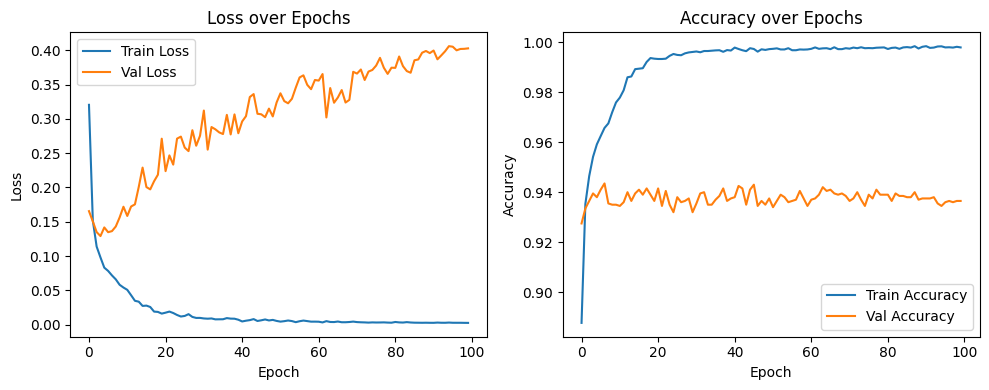


✅ Overall Test Accuracy: 0.9285

📊 Classification Report (Per-Emotion Accuracy):
              precision    recall  f1-score   support

     sadness     0.9658    0.9725    0.9691       581
         joy     0.9415    0.9496    0.9456       695
        love     0.8255    0.7736    0.7987       159
       anger     0.9588    0.9309    0.9446       275
        fear     0.8816    0.8973    0.8894       224
    surprise     0.7429    0.7879    0.7647        66

    accuracy                         0.9285      2000
   macro avg     0.8860    0.8853    0.8854      2000
weighted avg     0.9285    0.9285    0.9283      2000



In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# ====================================
# 1. Device Check
# ====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")

if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ====================================
# 2. Load Dataset
# ====================================
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

# ====================================
# 3. Tokenization
# ====================================
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ====================================
# 4. Dataset Class
# ====================================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ====================================
# 5. Mean Pooling Layer
# ====================================
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ====================================
# 6. Emotion Classifier
# ====================================
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

# ====================================
# 7. Setup
# ====================================
epochs = 100
num_labels = len(label_list)
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

from transformers import get_scheduler
scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * epochs
)
criterion = nn.CrossEntropyLoss()

# ====================================
# 8. Training and Validation
# ====================================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

from sklearn.metrics import accuracy_score

def evaluate(loader):
    model.eval()
    val_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)

            val_loss += loss.item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(target.cpu().numpy())

    acc = accuracy_score(labels, preds)
    return val_loss / len(loader), acc

def train_model(epochs):
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(target.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}:")
        print(f"  Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f}")
    torch.save(best_model_state, "best_model.pt")

# ====================================
# 9. Train
# ====================================
train_model(epochs)

# ====================================
# 10. Load Best Model and Final Evaluation (Validation)
# ====================================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
final_val_loss, final_val_acc = evaluate(val_loader)
print(f"\n✅ Final Evaluation — Best Model on Validation Set:\n   Val Loss: {final_val_loss:.4f} | Val Accuracy: {final_val_acc:.4f}")

# ====================================
# 11. Plotting
# ====================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# ====================================
# 12. 🧪 Final Test Set Evaluation — Per-Emotion Accuracy
# ====================================
from sklearn.metrics import classification_report
import numpy as np

# Load best model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Collect predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Overall test accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Overall Test Accuracy: {test_accuracy:.4f}")

# Classification report (per-class metrics)
print("\n📊 Classification Report (Per-Emotion Accuracy):")
print(classification_report(all_labels, all_preds, target_names=label_list, digits=4))



🖥️  Using device: cuda



Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 500/500 [02:05<00:00,  4.00it/s]



📊 Epoch 1:
  Train Loss: 0.3284 | Train Acc: 0.8911
  Val   Loss: 0.1777 | Val   Acc: 0.9250


Epoch 2: 100%|██████████| 500/500 [02:02<00:00,  4.10it/s]



📊 Epoch 2:
  Train Loss: 0.1526 | Train Acc: 0.9385
  Val   Loss: 0.1449 | Val   Acc: 0.9345


Epoch 3: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]



📊 Epoch 3:
  Train Loss: 0.1149 | Train Acc: 0.9490
  Val   Loss: 0.1211 | Val   Acc: 0.9395


Epoch 4: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 4:
  Train Loss: 0.0967 | Train Acc: 0.9556
  Val   Loss: 0.1289 | Val   Acc: 0.9390


Epoch 5: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 5:
  Train Loss: 0.0868 | Train Acc: 0.9586
  Val   Loss: 0.1268 | Val   Acc: 0.9390


Epoch 6: 100%|██████████| 500/500 [01:32<00:00,  5.41it/s]



📊 Epoch 6:
  Train Loss: 0.0739 | Train Acc: 0.9625
  Val   Loss: 0.1366 | Val   Acc: 0.9350


Epoch 7: 100%|██████████| 500/500 [01:32<00:00,  5.42it/s]



📊 Epoch 7:
  Train Loss: 0.0709 | Train Acc: 0.9677
  Val   Loss: 0.1292 | Val   Acc: 0.9415


Epoch 8: 100%|██████████| 500/500 [01:32<00:00,  5.41it/s]



📊 Epoch 8:
  Train Loss: 0.0645 | Train Acc: 0.9693
  Val   Loss: 0.1250 | Val   Acc: 0.9430


Epoch 9: 100%|██████████| 500/500 [01:33<00:00,  5.35it/s]



📊 Epoch 9:
  Train Loss: 0.0509 | Train Acc: 0.9768
  Val   Loss: 0.1364 | Val   Acc: 0.9460


Epoch 10: 100%|██████████| 500/500 [01:33<00:00,  5.36it/s]



📊 Epoch 10:
  Train Loss: 0.0526 | Train Acc: 0.9754
  Val   Loss: 0.1446 | Val   Acc: 0.9415


Epoch 11: 100%|██████████| 500/500 [01:32<00:00,  5.38it/s]



📊 Epoch 11:
  Train Loss: 0.0474 | Train Acc: 0.9792
  Val   Loss: 0.1519 | Val   Acc: 0.9380


Epoch 12: 100%|██████████| 500/500 [01:39<00:00,  5.01it/s]



📊 Epoch 12:
  Train Loss: 0.0406 | Train Acc: 0.9819
  Val   Loss: 0.1698 | Val   Acc: 0.9400


Epoch 13: 100%|██████████| 500/500 [01:41<00:00,  4.91it/s]



📊 Epoch 13:
  Train Loss: 0.0351 | Train Acc: 0.9851
  Val   Loss: 0.1516 | Val   Acc: 0.9420


Epoch 14: 100%|██████████| 500/500 [01:40<00:00,  4.96it/s]



📊 Epoch 14:
  Train Loss: 0.0285 | Train Acc: 0.9887
  Val   Loss: 0.1564 | Val   Acc: 0.9420


Epoch 15: 100%|██████████| 500/500 [01:40<00:00,  4.96it/s]



📊 Epoch 15:
  Train Loss: 0.0265 | Train Acc: 0.9889
  Val   Loss: 0.1759 | Val   Acc: 0.9380


Epoch 16: 100%|██████████| 500/500 [01:35<00:00,  5.26it/s]



📊 Epoch 16:
  Train Loss: 0.0234 | Train Acc: 0.9908
  Val   Loss: 0.1745 | Val   Acc: 0.9430


Epoch 17: 100%|██████████| 500/500 [01:34<00:00,  5.27it/s]



📊 Epoch 17:
  Train Loss: 0.0216 | Train Acc: 0.9916
  Val   Loss: 0.1890 | Val   Acc: 0.9415


Epoch 18: 100%|██████████| 500/500 [01:35<00:00,  5.26it/s]



📊 Epoch 18:
  Train Loss: 0.0170 | Train Acc: 0.9935
  Val   Loss: 0.1763 | Val   Acc: 0.9440


Epoch 19: 100%|██████████| 500/500 [01:35<00:00,  5.26it/s]



📊 Epoch 19:
  Train Loss: 0.0168 | Train Acc: 0.9936
  Val   Loss: 0.1811 | Val   Acc: 0.9440


Epoch 20: 100%|██████████| 500/500 [01:42<00:00,  4.88it/s]



📊 Epoch 20:
  Train Loss: 0.0139 | Train Acc: 0.9946
  Val   Loss: 0.1834 | Val   Acc: 0.9425

🏆 Best Validation Accuracy: 0.9460

✅ Final Evaluation — Best Model:
   Val Loss: 0.1834 | Val Accuracy: 0.9425


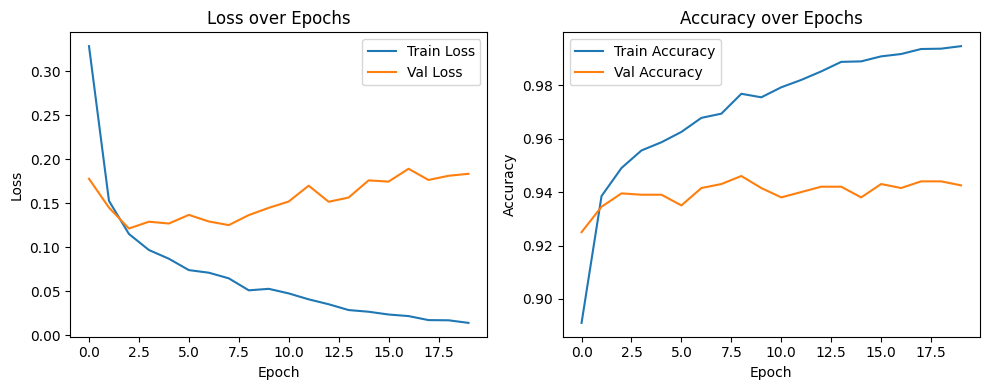


✅ Overall Test Accuracy: 0.9300

📊 Classification Report (Per-Emotion Accuracy):
              precision    recall  f1-score   support

     sadness     0.9608    0.9707    0.9658       581
         joy     0.9509    0.9482    0.9496       695
        love     0.8210    0.8365    0.8287       159
       anger     0.9481    0.9309    0.9394       275
        fear     0.9000    0.8839    0.8919       224
    surprise     0.7353    0.7576    0.7463        66

    accuracy                         0.9300      2000
   macro avg     0.8860    0.8880    0.8869      2000
weighted avg     0.9303    0.9300    0.9301      2000



In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
# ====================================
# 1. Device Check
# ====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")

if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ====================================
# 2. Load Dataset
# ====================================
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']

# ====================================
# 3. Tokenization (efficient)
# ====================================
model_name = "j-hartmann/emotion-english-distilroberta-base"
# model_name = "cardiffnlp/twitter-roberta-base-emotion-multilabel-latest"
# model_name = "bhadresh-savani/bert-base-go-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# ====================================
# 4. Dataset Class
# ====================================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)


# ====================================
# 5. Mean Pooling Layer
# ====================================
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ====================================
# 6. Emotion Classifier
# ====================================
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        # pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = outputs.pooler_output 
        return self.classifier(pooled_output)

# ====================================
# 7. Setup
# ====================================
epochs = 20
num_labels = len(label_list)
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
from transformers import get_scheduler
scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * epochs
)
criterion = nn.CrossEntropyLoss()



# ====================================
# 8. Training and Validation
# ====================================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    val_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)

            val_loss += loss.item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(target.cpu().numpy())

    acc = accuracy_score(labels, preds)
    return val_loss / len(loader), acc

def train_model(epochs):
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(target.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}:")
        print(f"  Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f}")
    torch.save(best_model_state, "best_model.pt")

# ====================================
# 9. Train
# ====================================
train_model(epochs)

# ====================================
# 10. Load Best Model and Final Evaluation
# ====================================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
final_val_loss, final_val_acc = evaluate(val_loader)
print(f"\n✅ Final Evaluation — Best Model:\n   Val Loss: {final_val_loss:.4f} | Val Accuracy: {final_val_acc:.4f}")

# ====================================
# 11. Plotting
# ====================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


# Load best model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Collect predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Overall test accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Overall Test Accuracy: {test_accuracy:.4f}")

# Classification report (per-class metrics)
print("\n📊 Classification Report (Per-Emotion Accuracy):")
print(classification_report(all_labels, all_preds, target_names=label_list, digits=4))


🖥️  Using device: cuda



Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 500/500 [02:06<00:00,  3.96it/s]



📊 Epoch 1:
  Train Loss: 0.3316 | Train Acc: 0.8899
  Val   Loss: 0.1838 | Val   Acc: 0.9240


Epoch 2: 100%|██████████| 500/500 [02:06<00:00,  3.94it/s]



📊 Epoch 2:
  Train Loss: 0.1503 | Train Acc: 0.9393
  Val   Loss: 0.1554 | Val   Acc: 0.9350


Epoch 3: 100%|██████████| 500/500 [02:07<00:00,  3.92it/s]



📊 Epoch 3:
  Train Loss: 0.1166 | Train Acc: 0.9469
  Val   Loss: 0.1434 | Val   Acc: 0.9375


Epoch 4: 100%|██████████| 500/500 [02:11<00:00,  3.79it/s]



📊 Epoch 4:
  Train Loss: 0.0999 | Train Acc: 0.9520
  Val   Loss: 0.1299 | Val   Acc: 0.9365


Epoch 5: 100%|██████████| 500/500 [02:13<00:00,  3.73it/s]



📊 Epoch 5:
  Train Loss: 0.0849 | Train Acc: 0.9585
  Val   Loss: 0.1332 | Val   Acc: 0.9425


Epoch 6: 100%|██████████| 500/500 [02:08<00:00,  3.89it/s]



📊 Epoch 6:
  Train Loss: 0.0750 | Train Acc: 0.9630
  Val   Loss: 0.1482 | Val   Acc: 0.9425


Epoch 7: 100%|██████████| 500/500 [02:08<00:00,  3.90it/s]



📊 Epoch 7:
  Train Loss: 0.0774 | Train Acc: 0.9636
  Val   Loss: 0.1491 | Val   Acc: 0.9380


Epoch 8: 100%|██████████| 500/500 [02:10<00:00,  3.83it/s]



📊 Epoch 8:
  Train Loss: 0.0715 | Train Acc: 0.9653
  Val   Loss: 0.1514 | Val   Acc: 0.9370


Epoch 9: 100%|██████████| 500/500 [02:11<00:00,  3.81it/s]



📊 Epoch 9:
  Train Loss: 0.0630 | Train Acc: 0.9695
  Val   Loss: 0.1480 | Val   Acc: 0.9425


Epoch 10: 100%|██████████| 500/500 [02:11<00:00,  3.79it/s]



📊 Epoch 10:
  Train Loss: 0.0591 | Train Acc: 0.9743
  Val   Loss: 0.1745 | Val   Acc: 0.9360


Epoch 11: 100%|██████████| 500/500 [02:12<00:00,  3.78it/s]



📊 Epoch 11:
  Train Loss: 0.0576 | Train Acc: 0.9744
  Val   Loss: 0.1700 | Val   Acc: 0.9390


Epoch 12: 100%|██████████| 500/500 [01:52<00:00,  4.44it/s]



📊 Epoch 12:
  Train Loss: 0.0491 | Train Acc: 0.9787
  Val   Loss: 0.1768 | Val   Acc: 0.9370


Epoch 13: 100%|██████████| 500/500 [01:39<00:00,  5.04it/s]



📊 Epoch 13:
  Train Loss: 0.0389 | Train Acc: 0.9824
  Val   Loss: 0.2152 | Val   Acc: 0.9395


Epoch 14: 100%|██████████| 500/500 [01:39<00:00,  5.02it/s]



📊 Epoch 14:
  Train Loss: 0.0380 | Train Acc: 0.9842
  Val   Loss: 0.1876 | Val   Acc: 0.9365


Epoch 15: 100%|██████████| 500/500 [01:39<00:00,  5.03it/s]



📊 Epoch 15:
  Train Loss: 0.0336 | Train Acc: 0.9858
  Val   Loss: 0.1824 | Val   Acc: 0.9405


Epoch 16: 100%|██████████| 500/500 [01:41<00:00,  4.91it/s]



📊 Epoch 16:
  Train Loss: 0.0321 | Train Acc: 0.9880
  Val   Loss: 0.1879 | Val   Acc: 0.9405


Epoch 17: 100%|██████████| 500/500 [01:36<00:00,  5.17it/s]



📊 Epoch 17:
  Train Loss: 0.0254 | Train Acc: 0.9905
  Val   Loss: 0.2248 | Val   Acc: 0.9410


Epoch 18: 100%|██████████| 500/500 [01:36<00:00,  5.17it/s]



📊 Epoch 18:
  Train Loss: 0.0279 | Train Acc: 0.9902
  Val   Loss: 0.2026 | Val   Acc: 0.9355


Epoch 19: 100%|██████████| 500/500 [01:38<00:00,  5.08it/s]



📊 Epoch 19:
  Train Loss: 0.0219 | Train Acc: 0.9911
  Val   Loss: 0.2347 | Val   Acc: 0.9375


Epoch 20: 100%|██████████| 500/500 [01:39<00:00,  5.01it/s]



📊 Epoch 20:
  Train Loss: 0.0168 | Train Acc: 0.9939
  Val   Loss: 0.2502 | Val   Acc: 0.9365


Epoch 21: 100%|██████████| 500/500 [01:42<00:00,  4.90it/s]



📊 Epoch 21:
  Train Loss: 0.0181 | Train Acc: 0.9938
  Val   Loss: 0.2470 | Val   Acc: 0.9405


Epoch 22: 100%|██████████| 500/500 [01:42<00:00,  4.86it/s]



📊 Epoch 22:
  Train Loss: 0.0183 | Train Acc: 0.9932
  Val   Loss: 0.2268 | Val   Acc: 0.9395


Epoch 23: 100%|██████████| 500/500 [01:44<00:00,  4.80it/s]



📊 Epoch 23:
  Train Loss: 0.0168 | Train Acc: 0.9941
  Val   Loss: 0.2281 | Val   Acc: 0.9405


Epoch 24: 100%|██████████| 500/500 [01:43<00:00,  4.85it/s]



📊 Epoch 24:
  Train Loss: 0.0156 | Train Acc: 0.9940
  Val   Loss: 0.2412 | Val   Acc: 0.9400


Epoch 25: 100%|██████████| 500/500 [01:40<00:00,  4.96it/s]



📊 Epoch 25:
  Train Loss: 0.0163 | Train Acc: 0.9943
  Val   Loss: 0.2322 | Val   Acc: 0.9400


Epoch 26: 100%|██████████| 500/500 [01:35<00:00,  5.22it/s]



📊 Epoch 26:
  Train Loss: 0.0149 | Train Acc: 0.9948
  Val   Loss: 0.2489 | Val   Acc: 0.9380


Epoch 27: 100%|██████████| 500/500 [01:36<00:00,  5.21it/s]



📊 Epoch 27:
  Train Loss: 0.0148 | Train Acc: 0.9940
  Val   Loss: 0.2403 | Val   Acc: 0.9355


Epoch 28: 100%|██████████| 500/500 [01:34<00:00,  5.26it/s]



📊 Epoch 28:
  Train Loss: 0.0128 | Train Acc: 0.9946
  Val   Loss: 0.2613 | Val   Acc: 0.9395


Epoch 29: 100%|██████████| 500/500 [01:34<00:00,  5.27it/s]



📊 Epoch 29:
  Train Loss: 0.0127 | Train Acc: 0.9953
  Val   Loss: 0.2837 | Val   Acc: 0.9420


Epoch 30: 100%|██████████| 500/500 [01:34<00:00,  5.28it/s]



📊 Epoch 30:
  Train Loss: 0.0111 | Train Acc: 0.9956
  Val   Loss: 0.2897 | Val   Acc: 0.9405


Epoch 31: 100%|██████████| 500/500 [01:34<00:00,  5.27it/s]



📊 Epoch 31:
  Train Loss: 0.0101 | Train Acc: 0.9959
  Val   Loss: 0.2545 | Val   Acc: 0.9400


Epoch 32: 100%|██████████| 500/500 [01:34<00:00,  5.28it/s]



📊 Epoch 32:
  Train Loss: 0.0122 | Train Acc: 0.9953
  Val   Loss: 0.2688 | Val   Acc: 0.9375


Epoch 33: 100%|██████████| 500/500 [01:34<00:00,  5.27it/s]



📊 Epoch 33:
  Train Loss: 0.0115 | Train Acc: 0.9956
  Val   Loss: 0.2934 | Val   Acc: 0.9345


Epoch 34: 100%|██████████| 500/500 [01:35<00:00,  5.26it/s]



📊 Epoch 34:
  Train Loss: 0.0101 | Train Acc: 0.9961
  Val   Loss: 0.2408 | Val   Acc: 0.9360


Epoch 35: 100%|██████████| 500/500 [01:34<00:00,  5.31it/s]



📊 Epoch 35:
  Train Loss: 0.0102 | Train Acc: 0.9957
  Val   Loss: 0.2826 | Val   Acc: 0.9360


Epoch 36: 100%|██████████| 500/500 [01:34<00:00,  5.29it/s]



📊 Epoch 36:
  Train Loss: 0.0089 | Train Acc: 0.9961
  Val   Loss: 0.2749 | Val   Acc: 0.9365


Epoch 37: 100%|██████████| 500/500 [01:33<00:00,  5.37it/s]



📊 Epoch 37:
  Train Loss: 0.0074 | Train Acc: 0.9969
  Val   Loss: 0.2645 | Val   Acc: 0.9385


Epoch 38: 100%|██████████| 500/500 [01:33<00:00,  5.36it/s]



📊 Epoch 38:
  Train Loss: 0.0097 | Train Acc: 0.9962
  Val   Loss: 0.2733 | Val   Acc: 0.9400


Epoch 39: 100%|██████████| 500/500 [01:33<00:00,  5.34it/s]



📊 Epoch 39:
  Train Loss: 0.0080 | Train Acc: 0.9962
  Val   Loss: 0.2869 | Val   Acc: 0.9395


Epoch 40: 100%|██████████| 500/500 [01:32<00:00,  5.39it/s]



📊 Epoch 40:
  Train Loss: 0.0071 | Train Acc: 0.9969
  Val   Loss: 0.2893 | Val   Acc: 0.9390


Epoch 41: 100%|██████████| 500/500 [01:32<00:00,  5.40it/s]



📊 Epoch 41:
  Train Loss: 0.0067 | Train Acc: 0.9973
  Val   Loss: 0.2742 | Val   Acc: 0.9425


Epoch 42: 100%|██████████| 500/500 [01:32<00:00,  5.40it/s]



📊 Epoch 42:
  Train Loss: 0.0086 | Train Acc: 0.9960
  Val   Loss: 0.2911 | Val   Acc: 0.9410


Epoch 43: 100%|██████████| 500/500 [01:38<00:00,  5.09it/s]



📊 Epoch 43:
  Train Loss: 0.0087 | Train Acc: 0.9964
  Val   Loss: 0.2868 | Val   Acc: 0.9425


Epoch 44: 100%|██████████| 500/500 [01:42<00:00,  4.89it/s]



📊 Epoch 44:
  Train Loss: 0.0051 | Train Acc: 0.9974
  Val   Loss: 0.3065 | Val   Acc: 0.9410


Epoch 45: 100%|██████████| 500/500 [01:41<00:00,  4.94it/s]



📊 Epoch 45:
  Train Loss: 0.0070 | Train Acc: 0.9967
  Val   Loss: 0.3172 | Val   Acc: 0.9415


Epoch 46: 100%|██████████| 500/500 [01:42<00:00,  4.86it/s]



📊 Epoch 46:
  Train Loss: 0.0073 | Train Acc: 0.9969
  Val   Loss: 0.2699 | Val   Acc: 0.9370


Epoch 47: 100%|██████████| 500/500 [01:40<00:00,  4.98it/s]



📊 Epoch 47:
  Train Loss: 0.0068 | Train Acc: 0.9968
  Val   Loss: 0.3146 | Val   Acc: 0.9385


Epoch 48: 100%|██████████| 500/500 [01:41<00:00,  4.94it/s]



📊 Epoch 48:
  Train Loss: 0.0067 | Train Acc: 0.9969
  Val   Loss: 0.2950 | Val   Acc: 0.9390


Epoch 49: 100%|██████████| 500/500 [01:42<00:00,  4.88it/s]



📊 Epoch 49:
  Train Loss: 0.0047 | Train Acc: 0.9976
  Val   Loss: 0.3130 | Val   Acc: 0.9385


Epoch 50: 100%|██████████| 500/500 [01:41<00:00,  4.90it/s]



📊 Epoch 50:
  Train Loss: 0.0063 | Train Acc: 0.9965
  Val   Loss: 0.2847 | Val   Acc: 0.9370


Epoch 51: 100%|██████████| 500/500 [01:41<00:00,  4.91it/s]



📊 Epoch 51:
  Train Loss: 0.0054 | Train Acc: 0.9970
  Val   Loss: 0.3227 | Val   Acc: 0.9360


Epoch 52: 100%|██████████| 500/500 [01:32<00:00,  5.41it/s]



📊 Epoch 52:
  Train Loss: 0.0058 | Train Acc: 0.9969
  Val   Loss: 0.3111 | Val   Acc: 0.9405


Epoch 53: 100%|██████████| 500/500 [01:35<00:00,  5.23it/s]



📊 Epoch 53:
  Train Loss: 0.0075 | Train Acc: 0.9968
  Val   Loss: 0.3031 | Val   Acc: 0.9350


Epoch 54: 100%|██████████| 500/500 [01:36<00:00,  5.17it/s]



📊 Epoch 54:
  Train Loss: 0.0047 | Train Acc: 0.9974
  Val   Loss: 0.3382 | Val   Acc: 0.9370


Epoch 55: 100%|██████████| 500/500 [01:38<00:00,  5.09it/s]



📊 Epoch 55:
  Train Loss: 0.0048 | Train Acc: 0.9972
  Val   Loss: 0.3599 | Val   Acc: 0.9385


Epoch 56: 100%|██████████| 500/500 [01:34<00:00,  5.28it/s]



📊 Epoch 56:
  Train Loss: 0.0076 | Train Acc: 0.9965
  Val   Loss: 0.2905 | Val   Acc: 0.9405


Epoch 57: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 57:
  Train Loss: 0.0045 | Train Acc: 0.9974
  Val   Loss: 0.3360 | Val   Acc: 0.9365


Epoch 58: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 58:
  Train Loss: 0.0051 | Train Acc: 0.9975
  Val   Loss: 0.3131 | Val   Acc: 0.9400


Epoch 59: 100%|██████████| 500/500 [01:32<00:00,  5.41it/s]



📊 Epoch 59:
  Train Loss: 0.0038 | Train Acc: 0.9972
  Val   Loss: 0.3438 | Val   Acc: 0.9390


Epoch 60: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 60:
  Train Loss: 0.0048 | Train Acc: 0.9973
  Val   Loss: 0.3163 | Val   Acc: 0.9375


Epoch 61: 100%|██████████| 500/500 [01:32<00:00,  5.42it/s]



📊 Epoch 61:
  Train Loss: 0.0054 | Train Acc: 0.9969
  Val   Loss: 0.3257 | Val   Acc: 0.9360


Epoch 62: 100%|██████████| 500/500 [01:32<00:00,  5.41it/s]



📊 Epoch 62:
  Train Loss: 0.0056 | Train Acc: 0.9969
  Val   Loss: 0.3276 | Val   Acc: 0.9380


Epoch 63: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 63:
  Train Loss: 0.0048 | Train Acc: 0.9975
  Val   Loss: 0.3236 | Val   Acc: 0.9375


Epoch 64: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 64:
  Train Loss: 0.0044 | Train Acc: 0.9973
  Val   Loss: 0.3345 | Val   Acc: 0.9360


Epoch 65: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 65:
  Train Loss: 0.0055 | Train Acc: 0.9974
  Val   Loss: 0.3335 | Val   Acc: 0.9380


Epoch 66: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 66:
  Train Loss: 0.0040 | Train Acc: 0.9978
  Val   Loss: 0.3319 | Val   Acc: 0.9405


Epoch 67: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 67:
  Train Loss: 0.0038 | Train Acc: 0.9976
  Val   Loss: 0.3371 | Val   Acc: 0.9375


Epoch 68: 100%|██████████| 500/500 [01:32<00:00,  5.41it/s]



📊 Epoch 68:
  Train Loss: 0.0037 | Train Acc: 0.9976
  Val   Loss: 0.3388 | Val   Acc: 0.9405


Epoch 69: 100%|██████████| 500/500 [01:32<00:00,  5.42it/s]



📊 Epoch 69:
  Train Loss: 0.0035 | Train Acc: 0.9979
  Val   Loss: 0.3555 | Val   Acc: 0.9365


Epoch 70: 100%|██████████| 500/500 [01:32<00:00,  5.41it/s]



📊 Epoch 70:
  Train Loss: 0.0049 | Train Acc: 0.9972
  Val   Loss: 0.3508 | Val   Acc: 0.9355


Epoch 71: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 71:
  Train Loss: 0.0042 | Train Acc: 0.9974
  Val   Loss: 0.3476 | Val   Acc: 0.9390


Epoch 72: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 72:
  Train Loss: 0.0040 | Train Acc: 0.9974
  Val   Loss: 0.3630 | Val   Acc: 0.9370


Epoch 73: 100%|██████████| 500/500 [01:32<00:00,  5.42it/s]



📊 Epoch 73:
  Train Loss: 0.0037 | Train Acc: 0.9976
  Val   Loss: 0.3618 | Val   Acc: 0.9335


Epoch 74: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 74:
  Train Loss: 0.0034 | Train Acc: 0.9978
  Val   Loss: 0.3736 | Val   Acc: 0.9390


Epoch 75: 100%|██████████| 500/500 [01:31<00:00,  5.45it/s]



📊 Epoch 75:
  Train Loss: 0.0039 | Train Acc: 0.9974
  Val   Loss: 0.3807 | Val   Acc: 0.9380


Epoch 76: 100%|██████████| 500/500 [01:34<00:00,  5.27it/s]



📊 Epoch 76:
  Train Loss: 0.0039 | Train Acc: 0.9977
  Val   Loss: 0.3782 | Val   Acc: 0.9370


Epoch 77: 100%|██████████| 500/500 [01:34<00:00,  5.30it/s]



📊 Epoch 77:
  Train Loss: 0.0037 | Train Acc: 0.9980
  Val   Loss: 0.3730 | Val   Acc: 0.9375


Epoch 78: 100%|██████████| 500/500 [01:34<00:00,  5.30it/s]



📊 Epoch 78:
  Train Loss: 0.0035 | Train Acc: 0.9976
  Val   Loss: 0.3686 | Val   Acc: 0.9370


Epoch 79: 100%|██████████| 500/500 [01:34<00:00,  5.29it/s]



📊 Epoch 79:
  Train Loss: 0.0032 | Train Acc: 0.9977
  Val   Loss: 0.3804 | Val   Acc: 0.9370


Epoch 80: 100%|██████████| 500/500 [01:33<00:00,  5.34it/s]



📊 Epoch 80:
  Train Loss: 0.0037 | Train Acc: 0.9978
  Val   Loss: 0.3880 | Val   Acc: 0.9385


Epoch 81: 100%|██████████| 500/500 [01:34<00:00,  5.31it/s]



📊 Epoch 81:
  Train Loss: 0.0037 | Train Acc: 0.9976
  Val   Loss: 0.3903 | Val   Acc: 0.9390


Epoch 82: 100%|██████████| 500/500 [01:34<00:00,  5.28it/s]



📊 Epoch 82:
  Train Loss: 0.0035 | Train Acc: 0.9974
  Val   Loss: 0.3539 | Val   Acc: 0.9375


Epoch 83: 100%|██████████| 500/500 [01:33<00:00,  5.33it/s]



📊 Epoch 83:
  Train Loss: 0.0037 | Train Acc: 0.9974
  Val   Loss: 0.3327 | Val   Acc: 0.9375


Epoch 84: 100%|██████████| 500/500 [01:33<00:00,  5.34it/s]



📊 Epoch 84:
  Train Loss: 0.0032 | Train Acc: 0.9976
  Val   Loss: 0.3492 | Val   Acc: 0.9370


Epoch 85: 100%|██████████| 500/500 [01:33<00:00,  5.33it/s]



📊 Epoch 85:
  Train Loss: 0.0032 | Train Acc: 0.9979
  Val   Loss: 0.3580 | Val   Acc: 0.9370


Epoch 86: 100%|██████████| 500/500 [01:34<00:00,  5.31it/s]



📊 Epoch 86:
  Train Loss: 0.0034 | Train Acc: 0.9979
  Val   Loss: 0.3424 | Val   Acc: 0.9360


Epoch 87: 100%|██████████| 500/500 [01:34<00:00,  5.31it/s]



📊 Epoch 87:
  Train Loss: 0.0029 | Train Acc: 0.9979
  Val   Loss: 0.3651 | Val   Acc: 0.9370


Epoch 88: 100%|██████████| 500/500 [01:33<00:00,  5.34it/s]



📊 Epoch 88:
  Train Loss: 0.0033 | Train Acc: 0.9976
  Val   Loss: 0.3538 | Val   Acc: 0.9375


Epoch 89: 100%|██████████| 500/500 [01:34<00:00,  5.28it/s]



📊 Epoch 89:
  Train Loss: 0.0031 | Train Acc: 0.9977
  Val   Loss: 0.3583 | Val   Acc: 0.9350


Epoch 90: 100%|██████████| 500/500 [01:34<00:00,  5.27it/s]



📊 Epoch 90:
  Train Loss: 0.0029 | Train Acc: 0.9978
  Val   Loss: 0.3703 | Val   Acc: 0.9350


Epoch 91: 100%|██████████| 500/500 [01:35<00:00,  5.26it/s]



📊 Epoch 91:
  Train Loss: 0.0029 | Train Acc: 0.9981
  Val   Loss: 0.3714 | Val   Acc: 0.9370


Epoch 92: 100%|██████████| 500/500 [01:32<00:00,  5.42it/s]



📊 Epoch 92:
  Train Loss: 0.0031 | Train Acc: 0.9973
  Val   Loss: 0.3664 | Val   Acc: 0.9385


Epoch 93: 100%|██████████| 500/500 [01:32<00:00,  5.42it/s]



📊 Epoch 93:
  Train Loss: 0.0029 | Train Acc: 0.9977
  Val   Loss: 0.3722 | Val   Acc: 0.9380


Epoch 94: 100%|██████████| 500/500 [01:32<00:00,  5.41it/s]



📊 Epoch 94:
  Train Loss: 0.0032 | Train Acc: 0.9976
  Val   Loss: 0.3698 | Val   Acc: 0.9360


Epoch 95: 100%|██████████| 500/500 [01:34<00:00,  5.30it/s]



📊 Epoch 95:
  Train Loss: 0.0028 | Train Acc: 0.9979
  Val   Loss: 0.3715 | Val   Acc: 0.9370


Epoch 96: 100%|██████████| 500/500 [01:37<00:00,  5.11it/s]



📊 Epoch 96:
  Train Loss: 0.0028 | Train Acc: 0.9979
  Val   Loss: 0.3699 | Val   Acc: 0.9365


Epoch 97: 100%|██████████| 500/500 [01:35<00:00,  5.25it/s]



📊 Epoch 97:
  Train Loss: 0.0029 | Train Acc: 0.9978
  Val   Loss: 0.3715 | Val   Acc: 0.9370


Epoch 98: 100%|██████████| 500/500 [01:36<00:00,  5.19it/s]



📊 Epoch 98:
  Train Loss: 0.0028 | Train Acc: 0.9980
  Val   Loss: 0.3716 | Val   Acc: 0.9385


Epoch 99: 100%|██████████| 500/500 [01:34<00:00,  5.26it/s]



📊 Epoch 99:
  Train Loss: 0.0029 | Train Acc: 0.9983
  Val   Loss: 0.3724 | Val   Acc: 0.9385


Epoch 100: 100%|██████████| 500/500 [01:36<00:00,  5.16it/s]



📊 Epoch 100:
  Train Loss: 0.0029 | Train Acc: 0.9977
  Val   Loss: 0.3723 | Val   Acc: 0.9385

🏆 Best Validation Accuracy: 0.9425

✅ Final Evaluation — Best Model:
   Val Loss: 0.3723 | Val Accuracy: 0.9385


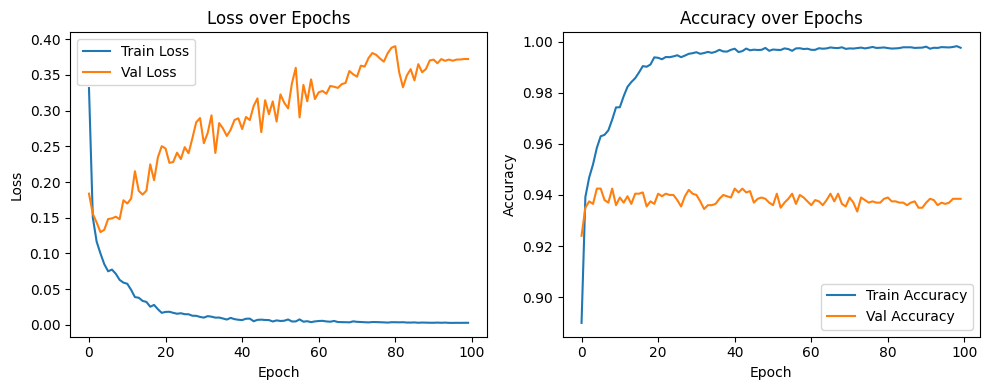


✅ Overall Test Accuracy: 0.9300

📊 Classification Report (Per-Emotion Accuracy):
              precision    recall  f1-score   support

     sadness     0.9691    0.9707    0.9699       581
         joy     0.9491    0.9381    0.9436       695
        love     0.7818    0.8113    0.7963       159
       anger     0.9353    0.9455    0.9403       275
        fear     0.9099    0.9018    0.9058       224
    surprise     0.8030    0.8030    0.8030        66

    accuracy                         0.9300      2000
   macro avg     0.8914    0.8951    0.8932      2000
weighted avg     0.9305    0.9300    0.9302      2000



In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
# ====================================
# 1. Device Check
# ====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")

if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ====================================
# 2. Load Dataset
# ====================================
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']

# ====================================
# 3. Tokenization (efficient)
# ====================================
model_name = "j-hartmann/emotion-english-distilroberta-base"
# model_name = "cardiffnlp/twitter-roberta-base-emotion-multilabel-latest"
# model_name = "bhadresh-savani/bert-base-go-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# ====================================
# 4. Dataset Class
# ====================================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)


# ====================================
# 5. Mean Pooling Layer
# ====================================
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ====================================
# 6. Emotion Classifier
# ====================================
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        # pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = outputs.pooler_output 
        return self.classifier(pooled_output)

# ====================================
# 7. Setup
# ====================================
epochs = 100
num_labels = len(label_list)
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
from transformers import get_scheduler
scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * epochs
)
criterion = nn.CrossEntropyLoss()



# ====================================
# 8. Training and Validation
# ====================================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    val_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)

            val_loss += loss.item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(target.cpu().numpy())

    acc = accuracy_score(labels, preds)
    return val_loss / len(loader), acc

def train_model(epochs):
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(target.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}:")
        print(f"  Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f}")
    torch.save(best_model_state, "best_model.pt")

# ====================================
# 9. Train
# ====================================
train_model(epochs)

# ====================================
# 10. Load Best Model and Final Evaluation
# ====================================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
final_val_loss, final_val_acc = evaluate(val_loader)
print(f"\n✅ Final Evaluation — Best Model:\n   Val Loss: {final_val_loss:.4f} | Val Accuracy: {final_val_acc:.4f}")

# ====================================
# 11. Plotting
# ====================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


# Load best model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Collect predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Overall test accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Overall Test Accuracy: {test_accuracy:.4f}")

# Classification report (per-class metrics)
print("\n📊 Classification Report (Per-Emotion Accuracy):")
print(classification_report(all_labels, all_preds, target_names=label_list, digits=4))

d:\SRH\Emotion Detection Text\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



🖥️  Using device: cuda



Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 1:
  Train Loss: 0.3340 | Train Acc: 0.8822
  Val   Loss: 0.1650 | Val   Acc: 0.9285


Epoch 2: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 2:
  Train Loss: 0.1514 | Train Acc: 0.9371
  Val   Loss: 0.1346 | Val   Acc: 0.9340


Epoch 3: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 3:
  Train Loss: 0.1133 | Train Acc: 0.9478
  Val   Loss: 0.1404 | Val   Acc: 0.9340


Epoch 4: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 4:
  Train Loss: 0.0961 | Train Acc: 0.9549
  Val   Loss: 0.1248 | Val   Acc: 0.9390


Epoch 5: 100%|██████████| 500/500 [01:31<00:00,  5.48it/s]



📊 Epoch 5:
  Train Loss: 0.0874 | Train Acc: 0.9564
  Val   Loss: 0.1253 | Val   Acc: 0.9425


Epoch 6: 100%|██████████| 500/500 [01:31<00:00,  5.48it/s]



📊 Epoch 6:
  Train Loss: 0.0803 | Train Acc: 0.9589
  Val   Loss: 0.1282 | Val   Acc: 0.9420


Epoch 7: 100%|██████████| 500/500 [01:31<00:00,  5.48it/s]



📊 Epoch 7:
  Train Loss: 0.0710 | Train Acc: 0.9645
  Val   Loss: 0.1454 | Val   Acc: 0.9375


Epoch 8: 100%|██████████| 500/500 [01:31<00:00,  5.48it/s]



📊 Epoch 8:
  Train Loss: 0.0666 | Train Acc: 0.9674
  Val   Loss: 0.1468 | Val   Acc: 0.9390


Epoch 9: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 9:
  Train Loss: 0.0577 | Train Acc: 0.9739
  Val   Loss: 0.1782 | Val   Acc: 0.9350


Epoch 10: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 10:
  Train Loss: 0.0543 | Train Acc: 0.9751
  Val   Loss: 0.1531 | Val   Acc: 0.9390


Epoch 11: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 11:
  Train Loss: 0.0477 | Train Acc: 0.9794
  Val   Loss: 0.1992 | Val   Acc: 0.9355


Epoch 12: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 12:
  Train Loss: 0.0461 | Train Acc: 0.9791
  Val   Loss: 0.1975 | Val   Acc: 0.9295


Epoch 13: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 13:
  Train Loss: 0.0406 | Train Acc: 0.9830
  Val   Loss: 0.1942 | Val   Acc: 0.9310


Epoch 14: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 14:
  Train Loss: 0.0343 | Train Acc: 0.9864
  Val   Loss: 0.1729 | Val   Acc: 0.9380


Epoch 15: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 15:
  Train Loss: 0.0283 | Train Acc: 0.9899
  Val   Loss: 0.2157 | Val   Acc: 0.9330


Epoch 16: 100%|██████████| 500/500 [01:32<00:00,  5.42it/s]



📊 Epoch 16:
  Train Loss: 0.0275 | Train Acc: 0.9899
  Val   Loss: 0.2103 | Val   Acc: 0.9390


Epoch 17: 100%|██████████| 500/500 [01:31<00:00,  5.43it/s]



📊 Epoch 17:
  Train Loss: 0.0244 | Train Acc: 0.9904
  Val   Loss: 0.2499 | Val   Acc: 0.9385


Epoch 18: 100%|██████████| 500/500 [01:32<00:00,  5.42it/s]



📊 Epoch 18:
  Train Loss: 0.0200 | Train Acc: 0.9929
  Val   Loss: 0.2351 | Val   Acc: 0.9390


Epoch 19: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 19:
  Train Loss: 0.0184 | Train Acc: 0.9928
  Val   Loss: 0.2608 | Val   Acc: 0.9370


Epoch 20: 100%|██████████| 500/500 [01:32<00:00,  5.39it/s]



📊 Epoch 20:
  Train Loss: 0.0196 | Train Acc: 0.9932
  Val   Loss: 0.2698 | Val   Acc: 0.9370


Epoch 21: 100%|██████████| 500/500 [01:33<00:00,  5.36it/s]



📊 Epoch 21:
  Train Loss: 0.0176 | Train Acc: 0.9932
  Val   Loss: 0.2707 | Val   Acc: 0.9320


Epoch 22: 100%|██████████| 500/500 [01:33<00:00,  5.37it/s]



📊 Epoch 22:
  Train Loss: 0.0156 | Train Acc: 0.9939
  Val   Loss: 0.2854 | Val   Acc: 0.9370


Epoch 23: 100%|██████████| 500/500 [01:33<00:00,  5.35it/s]



📊 Epoch 23:
  Train Loss: 0.0131 | Train Acc: 0.9954
  Val   Loss: 0.2732 | Val   Acc: 0.9335


Epoch 24: 100%|██████████| 500/500 [01:33<00:00,  5.36it/s]



📊 Epoch 24:
  Train Loss: 0.0180 | Train Acc: 0.9934
  Val   Loss: 0.2628 | Val   Acc: 0.9345


Epoch 25: 100%|██████████| 500/500 [01:33<00:00,  5.36it/s]



📊 Epoch 25:
  Train Loss: 0.0138 | Train Acc: 0.9940
  Val   Loss: 0.2943 | Val   Acc: 0.9350


Epoch 26: 100%|██████████| 500/500 [01:33<00:00,  5.33it/s]



📊 Epoch 26:
  Train Loss: 0.0130 | Train Acc: 0.9956
  Val   Loss: 0.2771 | Val   Acc: 0.9380


Epoch 27: 100%|██████████| 500/500 [01:33<00:00,  5.37it/s]



📊 Epoch 27:
  Train Loss: 0.0118 | Train Acc: 0.9952
  Val   Loss: 0.2550 | Val   Acc: 0.9380


Epoch 28: 100%|██████████| 500/500 [01:32<00:00,  5.38it/s]



📊 Epoch 28:
  Train Loss: 0.0121 | Train Acc: 0.9951
  Val   Loss: 0.2980 | Val   Acc: 0.9375


Epoch 29: 100%|██████████| 500/500 [01:33<00:00,  5.37it/s]



📊 Epoch 29:
  Train Loss: 0.0087 | Train Acc: 0.9958
  Val   Loss: 0.2948 | Val   Acc: 0.9390


Epoch 30: 100%|██████████| 500/500 [01:33<00:00,  5.37it/s]



📊 Epoch 30:
  Train Loss: 0.0115 | Train Acc: 0.9952
  Val   Loss: 0.2916 | Val   Acc: 0.9405


Epoch 31: 100%|██████████| 500/500 [01:33<00:00,  5.34it/s]



📊 Epoch 31:
  Train Loss: 0.0117 | Train Acc: 0.9958
  Val   Loss: 0.2809 | Val   Acc: 0.9370


Epoch 32: 100%|██████████| 500/500 [01:33<00:00,  5.35it/s]



📊 Epoch 32:
  Train Loss: 0.0101 | Train Acc: 0.9962
  Val   Loss: 0.2849 | Val   Acc: 0.9360


Epoch 33: 100%|██████████| 500/500 [01:32<00:00,  5.38it/s]



📊 Epoch 33:
  Train Loss: 0.0097 | Train Acc: 0.9961
  Val   Loss: 0.3064 | Val   Acc: 0.9395


Epoch 34: 100%|██████████| 500/500 [01:33<00:00,  5.37it/s]



📊 Epoch 34:
  Train Loss: 0.0119 | Train Acc: 0.9953
  Val   Loss: 0.2997 | Val   Acc: 0.9365


Epoch 35: 100%|██████████| 500/500 [01:33<00:00,  5.37it/s]



📊 Epoch 35:
  Train Loss: 0.0073 | Train Acc: 0.9971
  Val   Loss: 0.3362 | Val   Acc: 0.9335


Epoch 36: 100%|██████████| 500/500 [01:33<00:00,  5.36it/s]



📊 Epoch 36:
  Train Loss: 0.0078 | Train Acc: 0.9970
  Val   Loss: 0.3058 | Val   Acc: 0.9350


Epoch 37: 100%|██████████| 500/500 [01:33<00:00,  5.35it/s]



📊 Epoch 37:
  Train Loss: 0.0076 | Train Acc: 0.9967
  Val   Loss: 0.3155 | Val   Acc: 0.9350


Epoch 38: 100%|██████████| 500/500 [01:33<00:00,  5.34it/s]



📊 Epoch 38:
  Train Loss: 0.0066 | Train Acc: 0.9970
  Val   Loss: 0.3383 | Val   Acc: 0.9400


Epoch 39: 100%|██████████| 500/500 [01:33<00:00,  5.35it/s]



📊 Epoch 39:
  Train Loss: 0.0079 | Train Acc: 0.9962
  Val   Loss: 0.3108 | Val   Acc: 0.9410


Epoch 40: 100%|██████████| 500/500 [01:33<00:00,  5.35it/s]



📊 Epoch 40:
  Train Loss: 0.0079 | Train Acc: 0.9962
  Val   Loss: 0.3182 | Val   Acc: 0.9355


Epoch 41: 100%|██████████| 500/500 [01:33<00:00,  5.37it/s]



📊 Epoch 41:
  Train Loss: 0.0079 | Train Acc: 0.9965
  Val   Loss: 0.3003 | Val   Acc: 0.9360


Epoch 42: 100%|██████████| 500/500 [01:33<00:00,  5.35it/s]



📊 Epoch 42:
  Train Loss: 0.0071 | Train Acc: 0.9972
  Val   Loss: 0.3236 | Val   Acc: 0.9350


Epoch 43: 100%|██████████| 500/500 [01:34<00:00,  5.31it/s]



📊 Epoch 43:
  Train Loss: 0.0074 | Train Acc: 0.9964
  Val   Loss: 0.3590 | Val   Acc: 0.9345


Epoch 44: 100%|██████████| 500/500 [01:33<00:00,  5.34it/s]



📊 Epoch 44:
  Train Loss: 0.0073 | Train Acc: 0.9965
  Val   Loss: 0.3981 | Val   Acc: 0.9305


Epoch 45: 100%|██████████| 500/500 [01:33<00:00,  5.36it/s]



📊 Epoch 45:
  Train Loss: 0.0080 | Train Acc: 0.9966
  Val   Loss: 0.3351 | Val   Acc: 0.9330


Epoch 46: 100%|██████████| 500/500 [01:32<00:00,  5.38it/s]



📊 Epoch 46:
  Train Loss: 0.0058 | Train Acc: 0.9971
  Val   Loss: 0.3690 | Val   Acc: 0.9335


Epoch 47: 100%|██████████| 500/500 [01:32<00:00,  5.38it/s]



📊 Epoch 47:
  Train Loss: 0.0054 | Train Acc: 0.9972
  Val   Loss: 0.3456 | Val   Acc: 0.9390


Epoch 48: 100%|██████████| 500/500 [01:33<00:00,  5.37it/s]



📊 Epoch 48:
  Train Loss: 0.0072 | Train Acc: 0.9965
  Val   Loss: 0.3621 | Val   Acc: 0.9360


Epoch 49: 100%|██████████| 500/500 [01:33<00:00,  5.36it/s]



📊 Epoch 49:
  Train Loss: 0.0061 | Train Acc: 0.9970
  Val   Loss: 0.3392 | Val   Acc: 0.9390


Epoch 50: 100%|██████████| 500/500 [01:33<00:00,  5.35it/s]



📊 Epoch 50:
  Train Loss: 0.0047 | Train Acc: 0.9969
  Val   Loss: 0.3526 | Val   Acc: 0.9385


Epoch 51: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]



📊 Epoch 51:
  Train Loss: 0.0054 | Train Acc: 0.9969
  Val   Loss: 0.3330 | Val   Acc: 0.9395


Epoch 52: 100%|██████████| 500/500 [01:31<00:00,  5.48it/s]



📊 Epoch 52:
  Train Loss: 0.0060 | Train Acc: 0.9969
  Val   Loss: 0.3365 | Val   Acc: 0.9380


Epoch 53: 100%|██████████| 500/500 [01:31<00:00,  5.47it/s]



📊 Epoch 53:
  Train Loss: 0.0061 | Train Acc: 0.9968
  Val   Loss: 0.3202 | Val   Acc: 0.9390


Epoch 54: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 54:
  Train Loss: 0.0056 | Train Acc: 0.9970
  Val   Loss: 0.3258 | Val   Acc: 0.9385


Epoch 55: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 55:
  Train Loss: 0.0057 | Train Acc: 0.9970
  Val   Loss: 0.3340 | Val   Acc: 0.9360


Epoch 56: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 56:
  Train Loss: 0.0050 | Train Acc: 0.9972
  Val   Loss: 0.3458 | Val   Acc: 0.9380


Epoch 57: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 57:
  Train Loss: 0.0042 | Train Acc: 0.9972
  Val   Loss: 0.3634 | Val   Acc: 0.9335


Epoch 58: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 58:
  Train Loss: 0.0046 | Train Acc: 0.9971
  Val   Loss: 0.3714 | Val   Acc: 0.9350


Epoch 59: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 59:
  Train Loss: 0.0054 | Train Acc: 0.9971
  Val   Loss: 0.3592 | Val   Acc: 0.9360


Epoch 60: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 60:
  Train Loss: 0.0047 | Train Acc: 0.9971
  Val   Loss: 0.3583 | Val   Acc: 0.9365


Epoch 61: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 61:
  Train Loss: 0.0038 | Train Acc: 0.9974
  Val   Loss: 0.3825 | Val   Acc: 0.9370


Epoch 62: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 62:
  Train Loss: 0.0038 | Train Acc: 0.9974
  Val   Loss: 0.3617 | Val   Acc: 0.9375


Epoch 63: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 63:
  Train Loss: 0.0038 | Train Acc: 0.9974
  Val   Loss: 0.3726 | Val   Acc: 0.9370


Epoch 64: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 64:
  Train Loss: 0.0041 | Train Acc: 0.9973
  Val   Loss: 0.3659 | Val   Acc: 0.9390


Epoch 65: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 65:
  Train Loss: 0.0043 | Train Acc: 0.9972
  Val   Loss: 0.3619 | Val   Acc: 0.9375


Epoch 66: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 66:
  Train Loss: 0.0044 | Train Acc: 0.9974
  Val   Loss: 0.3746 | Val   Acc: 0.9375


Epoch 67: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 67:
  Train Loss: 0.0036 | Train Acc: 0.9981
  Val   Loss: 0.3794 | Val   Acc: 0.9400


Epoch 68: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 68:
  Train Loss: 0.0031 | Train Acc: 0.9979
  Val   Loss: 0.3866 | Val   Acc: 0.9395


Epoch 69: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 69:
  Train Loss: 0.0036 | Train Acc: 0.9976
  Val   Loss: 0.3936 | Val   Acc: 0.9390


Epoch 70: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 70:
  Train Loss: 0.0035 | Train Acc: 0.9979
  Val   Loss: 0.3631 | Val   Acc: 0.9400


Epoch 71: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 71:
  Train Loss: 0.0038 | Train Acc: 0.9972
  Val   Loss: 0.3937 | Val   Acc: 0.9385


Epoch 72: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 72:
  Train Loss: 0.0036 | Train Acc: 0.9976
  Val   Loss: 0.4122 | Val   Acc: 0.9370


Epoch 73: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 73:
  Train Loss: 0.0037 | Train Acc: 0.9972
  Val   Loss: 0.4303 | Val   Acc: 0.9345


Epoch 74: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 74:
  Train Loss: 0.0033 | Train Acc: 0.9978
  Val   Loss: 0.4288 | Val   Acc: 0.9360


Epoch 75: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 75:
  Train Loss: 0.0036 | Train Acc: 0.9974
  Val   Loss: 0.3954 | Val   Acc: 0.9375


Epoch 76: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 76:
  Train Loss: 0.0033 | Train Acc: 0.9979
  Val   Loss: 0.4145 | Val   Acc: 0.9355


Epoch 77: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 77:
  Train Loss: 0.0034 | Train Acc: 0.9975
  Val   Loss: 0.4286 | Val   Acc: 0.9365


Epoch 78: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 78:
  Train Loss: 0.0031 | Train Acc: 0.9981
  Val   Loss: 0.4698 | Val   Acc: 0.9355


Epoch 79: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 79:
  Train Loss: 0.0042 | Train Acc: 0.9976
  Val   Loss: 0.4491 | Val   Acc: 0.9365


Epoch 80: 100%|██████████| 500/500 [01:31<00:00,  5.43it/s]



📊 Epoch 80:
  Train Loss: 0.0043 | Train Acc: 0.9977
  Val   Loss: 0.4043 | Val   Acc: 0.9350


Epoch 81: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 81:
  Train Loss: 0.0037 | Train Acc: 0.9978
  Val   Loss: 0.4216 | Val   Acc: 0.9355


Epoch 82: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 82:
  Train Loss: 0.0035 | Train Acc: 0.9977
  Val   Loss: 0.4344 | Val   Acc: 0.9345


Epoch 83: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 83:
  Train Loss: 0.0036 | Train Acc: 0.9979
  Val   Loss: 0.4340 | Val   Acc: 0.9355


Epoch 84: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 84:
  Train Loss: 0.0033 | Train Acc: 0.9974
  Val   Loss: 0.4328 | Val   Acc: 0.9355


Epoch 85: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 85:
  Train Loss: 0.0031 | Train Acc: 0.9976
  Val   Loss: 0.4241 | Val   Acc: 0.9350


Epoch 86: 100%|██████████| 500/500 [01:31<00:00,  5.44it/s]



📊 Epoch 86:
  Train Loss: 0.0039 | Train Acc: 0.9976
  Val   Loss: 0.4229 | Val   Acc: 0.9355


Epoch 87: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]



📊 Epoch 87:
  Train Loss: 0.0033 | Train Acc: 0.9978
  Val   Loss: 0.4115 | Val   Acc: 0.9390


Epoch 88: 100%|██████████| 500/500 [01:35<00:00,  5.24it/s]



📊 Epoch 88:
  Train Loss: 0.0031 | Train Acc: 0.9976
  Val   Loss: 0.4193 | Val   Acc: 0.9365


Epoch 89: 100%|██████████| 500/500 [01:37<00:00,  5.14it/s]



📊 Epoch 89:
  Train Loss: 0.0029 | Train Acc: 0.9978
  Val   Loss: 0.4244 | Val   Acc: 0.9365


Epoch 90: 100%|██████████| 500/500 [01:36<00:00,  5.17it/s]



📊 Epoch 90:
  Train Loss: 0.0034 | Train Acc: 0.9974
  Val   Loss: 0.4200 | Val   Acc: 0.9380


Epoch 91: 100%|██████████| 500/500 [01:36<00:00,  5.19it/s]



📊 Epoch 91:
  Train Loss: 0.0035 | Train Acc: 0.9978
  Val   Loss: 0.4276 | Val   Acc: 0.9325


Epoch 92: 100%|██████████| 500/500 [01:36<00:00,  5.19it/s]



📊 Epoch 92:
  Train Loss: 0.0030 | Train Acc: 0.9979
  Val   Loss: 0.4377 | Val   Acc: 0.9325


Epoch 93: 100%|██████████| 500/500 [01:36<00:00,  5.20it/s]



📊 Epoch 93:
  Train Loss: 0.0030 | Train Acc: 0.9979
  Val   Loss: 0.4361 | Val   Acc: 0.9360


Epoch 94: 100%|██████████| 500/500 [01:36<00:00,  5.20it/s]



📊 Epoch 94:
  Train Loss: 0.0029 | Train Acc: 0.9976
  Val   Loss: 0.4358 | Val   Acc: 0.9370


Epoch 95: 100%|██████████| 500/500 [01:36<00:00,  5.17it/s]



📊 Epoch 95:
  Train Loss: 0.0033 | Train Acc: 0.9976
  Val   Loss: 0.4363 | Val   Acc: 0.9390


Epoch 96: 100%|██████████| 500/500 [01:37<00:00,  5.14it/s]



📊 Epoch 96:
  Train Loss: 0.0031 | Train Acc: 0.9977
  Val   Loss: 0.4354 | Val   Acc: 0.9385


Epoch 97: 100%|██████████| 500/500 [01:36<00:00,  5.16it/s]



📊 Epoch 97:
  Train Loss: 0.0028 | Train Acc: 0.9981
  Val   Loss: 0.4324 | Val   Acc: 0.9375


Epoch 98: 100%|██████████| 500/500 [01:36<00:00,  5.17it/s]



📊 Epoch 98:
  Train Loss: 0.0028 | Train Acc: 0.9979
  Val   Loss: 0.4345 | Val   Acc: 0.9375


Epoch 99: 100%|██████████| 500/500 [01:33<00:00,  5.32it/s]



📊 Epoch 99:
  Train Loss: 0.0028 | Train Acc: 0.9982
  Val   Loss: 0.4352 | Val   Acc: 0.9380


Epoch 100: 100%|██████████| 500/500 [01:33<00:00,  5.34it/s]



📊 Epoch 100:
  Train Loss: 0.0030 | Train Acc: 0.9981
  Val   Loss: 0.4350 | Val   Acc: 0.9380

🏆 Best Validation Accuracy: 0.9425

✅ Final Evaluation — Best Model on Validation Set:
   Val Loss: 0.4350 | Val Accuracy: 0.9380


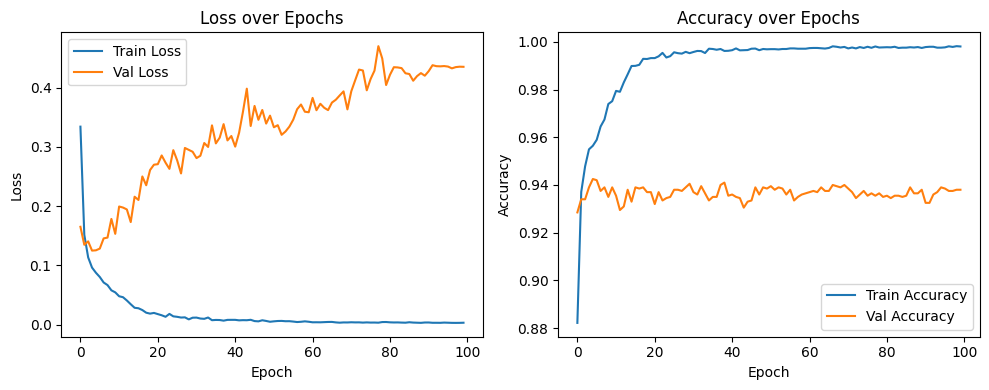


🧪 Final Test Set Accuracy:
   Test Loss: 0.4916 | Test Accuracy: 0.9300

✅ Overall Test Accuracy: 0.9300

📊 Classification Report (Per-Emotion Accuracy):
              precision    recall  f1-score   support

     sadness     0.9674    0.9707    0.9691       581
         joy     0.9519    0.9396    0.9457       695
        love     0.8000    0.8302    0.8148       159
       anger     0.9418    0.9418    0.9418       275
        fear     0.9050    0.8929    0.8989       224
    surprise     0.7429    0.7879    0.7647        66

    accuracy                         0.9300      2000
   macro avg     0.8848    0.8938    0.8892      2000
weighted avg     0.9308    0.9300    0.9303      2000



In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

# ====================================
# 1. Device Check
# ====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")

if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ====================================
# 2. Load Dataset
# ====================================
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

# ====================================
# 3. Tokenization (efficient)
# ====================================
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ====================================
# 4. Dataset Class
# ====================================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ====================================
# 5. Mean Pooling Layer
# ====================================
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ====================================
# 6. Emotion Classifier
# ====================================
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pooler(outputs.last_hidden_state, attention_mask)
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

# ====================================
# 7. Setup
# ====================================
epochs = 100
num_labels = len(label_list)
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

from transformers import get_scheduler
scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * epochs
)
criterion = nn.CrossEntropyLoss()

# ====================================
# 8. Training and Validation
# ====================================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    val_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)

            val_loss += loss.item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(target.cpu().numpy())

    acc = accuracy_score(labels, preds)
    return val_loss / len(loader), acc

def train_model(epochs):
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(target.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}:")
        print(f"  Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f}")
    torch.save(best_model_state, "best_model.pt")

# ====================================
# 9. Train
# ====================================
train_model(epochs)

# ====================================
# 10. Load Best Model and Final Evaluation (Validation)
# ====================================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
final_val_loss, final_val_acc = evaluate(val_loader)
print(f"\n✅ Final Evaluation — Best Model on Validation Set:\n   Val Loss: {final_val_loss:.4f} | Val Accuracy: {final_val_acc:.4f}")

# ====================================
# 11. Plotting
# ====================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# ====================================
# 12. 🧪 Final Test Set Evaluation
# ====================================
test_loss, test_acc = evaluate(test_loader)
print(f"\n🧪 Final Test Set Accuracy:\n   Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")



# Load best model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Collect predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Overall test accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Overall Test Accuracy: {test_accuracy:.4f}")

# Classification report (per-class metrics)
print("\n📊 Classification Report (Per-Emotion Accuracy):")
print(classification_report(all_labels, all_preds, target_names=label_list, digits=4))

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, pipeline
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

# ========== 1. Device Check ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

# ========== 3. Tokenization ==========
model_name =  "Panda0116/emotion-classification-model"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== 5. Mean Pooling ==========
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== 6. Emotion Classifier ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.pooler(outputs.last_hidden_state, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== 7. Training Setup ==========
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

from transformers import get_scheduler
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 10)
criterion = nn.CrossEntropyLoss()

# ========== 8. Training + Validation ==========
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    total_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            output = model(input_ids, mask)
            loss = criterion(output, targets)

            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return total_loss / len(loader), accuracy_score(labels, preds)

def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())

        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")

    print(f"\n🏆 Best Val Accuracy: {best_acc:.4f}")

# ========== 9. Train ==========
train_model(epochs=10)

# ========== 10. Load Best Model + Test Evaluation ==========
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

def test_evaluate(loader):
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            outputs = model(input_ids, mask)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return labels, preds

true_labels, model_preds = test_evaluate(test_loader)
print("\n🧪 Test Classification Report:\n")
print(classification_report(true_labels, model_preds, target_names=label_list))




🖥️  Using device: cuda



d:\SRH\Emotion Detection Text\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\anavn\.cache\huggingface\hub\models--Panda0116--emotion-classification-model. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back 


📊 Epoch 1: Train Acc: 0.9589, Val Acc: 0.9390


Epoch 2: 100%|██████████| 500/500 [01:35<00:00,  5.24it/s]



📊 Epoch 2: Train Acc: 0.9762, Val Acc: 0.9390


Epoch 3: 100%|██████████| 500/500 [01:33<00:00,  5.32it/s]



📊 Epoch 3: Train Acc: 0.9831, Val Acc: 0.9355


Epoch 4: 100%|██████████| 500/500 [01:34<00:00,  5.29it/s]



📊 Epoch 4: Train Acc: 0.9869, Val Acc: 0.9380


Epoch 5: 100%|██████████| 500/500 [01:34<00:00,  5.30it/s]



📊 Epoch 5: Train Acc: 0.9898, Val Acc: 0.9385


Epoch 6: 100%|██████████| 500/500 [01:34<00:00,  5.27it/s]



📊 Epoch 6: Train Acc: 0.9929, Val Acc: 0.9410


Epoch 7: 100%|██████████| 500/500 [01:34<00:00,  5.27it/s]



📊 Epoch 7: Train Acc: 0.9944, Val Acc: 0.9400


Epoch 8: 100%|██████████| 500/500 [01:30<00:00,  5.55it/s]



📊 Epoch 8: Train Acc: 0.9959, Val Acc: 0.9395


Epoch 9: 100%|██████████| 500/500 [01:30<00:00,  5.50it/s]



📊 Epoch 9: Train Acc: 0.9963, Val Acc: 0.9430


Epoch 10: 100%|██████████| 500/500 [01:35<00:00,  5.22it/s]



📊 Epoch 10: Train Acc: 0.9968, Val Acc: 0.9410

🏆 Best Val Accuracy: 0.9430

🧪 Test Classification Report:

              precision    recall  f1-score   support

     sadness       0.97      0.96      0.97       581
         joy       0.95      0.95      0.95       695
        love       0.83      0.83      0.83       159
       anger       0.91      0.92      0.92       275
        fear       0.90      0.89      0.89       224
    surprise       0.75      0.76      0.75        66

    accuracy                           0.93      2000
   macro avg       0.88      0.89      0.88      2000
weighted avg       0.93      0.93      0.93      2000



In [ ]:
c


🖥️  Using device: cuda



d:\SRH\Emotion Detection Text\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\anavn\.cache\huggingface\hub\models--boltuix--bert-emotion. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Epoch 1: 100%|██████████| 500/500 [00:14<00:00, 33.48it/s]



📊 Epoch 1: Train Acc: 0.9109, Val Acc: 0.9520


Epoch 2: 100%|██████████| 500/500 [00:14<00:00, 34.75it/s]



📊 Epoch 2: Train Acc: 0.9518, Val Acc: 0.9545


Epoch 3: 100%|██████████| 500/500 [00:22<00:00, 22.21it/s]



📊 Epoch 3: Train Acc: 0.9564, Val Acc: 0.9590


Epoch 4: 100%|██████████| 500/500 [00:45<00:00, 10.90it/s]



📊 Epoch 4: Train Acc: 0.9615, Val Acc: 0.9545


Epoch 5: 100%|██████████| 500/500 [00:45<00:00, 11.07it/s]



📊 Epoch 5: Train Acc: 0.9660, Val Acc: 0.9605


Epoch 6: 100%|██████████| 500/500 [00:43<00:00, 11.55it/s]



📊 Epoch 6: Train Acc: 0.9690, Val Acc: 0.9585


Epoch 7: 100%|██████████| 500/500 [00:14<00:00, 35.54it/s]



📊 Epoch 7: Train Acc: 0.9716, Val Acc: 0.9610


Epoch 8: 100%|██████████| 500/500 [00:14<00:00, 34.89it/s]



📊 Epoch 8: Train Acc: 0.9722, Val Acc: 0.9625


Epoch 9: 100%|██████████| 500/500 [00:14<00:00, 34.99it/s]



📊 Epoch 9: Train Acc: 0.9754, Val Acc: 0.9625


Epoch 10: 100%|██████████| 500/500 [00:15<00:00, 33.33it/s]



📊 Epoch 10: Train Acc: 0.9754, Val Acc: 0.9615

🏆 Best Val Accuracy: 0.9625

🧪 Test Classification Report:

              precision    recall  f1-score   support

     sadness       0.96      0.98      0.97       581
         joy       0.97      0.95      0.96       695
        love       0.86      0.88      0.87       159
       anger       0.96      0.95      0.95       275
        fear       0.94      0.96      0.95       224
    surprise       0.87      0.82      0.84        66

    accuracy                           0.95      2000
   macro avg       0.93      0.92      0.93      2000
weighted avg       0.95      0.95      0.95      2000



In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, pipeline
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

# ========== 1. Device Check ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

# ========== 3. Tokenization ==========
model_name =  "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== 5. Mean Pooling ==========
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== 6. Emotion Classifier ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.pooler(outputs.last_hidden_state, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== 7. Training Setup ==========
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

from transformers import get_scheduler
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 10)
criterion = nn.CrossEntropyLoss()

# ========== 8. Training + Validation ==========
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    total_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            output = model(input_ids, mask)
            loss = criterion(output, targets)

            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return total_loss / len(loader), accuracy_score(labels, preds)

def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())

        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")

    print(f"\n🏆 Best Val Accuracy: {best_acc:.4f}")

# ========== 9. Train ==========
train_model(epochs=10)

# ========== 10. Load Best Model + Test Evaluation ==========
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

def test_evaluate(loader):
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            outputs = model(input_ids, mask)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return labels, preds

true_labels, model_preds = test_evaluate(test_loader)
print("\n🧪 Test Classification Report:\n")
print(classification_report(true_labels, model_preds, target_names=label_list))




🖥️  Using device: cuda



Epoch 1: 100%|██████████| 250/250 [01:58<00:00,  2.10it/s]



📊 Epoch 1: Train Acc: 0.9049, Val Acc: 0.9555


Epoch 2: 100%|██████████| 250/250 [01:55<00:00,  2.16it/s]



📊 Epoch 2: Train Acc: 0.9511, Val Acc: 0.9545


Epoch 3: 100%|██████████| 250/250 [01:56<00:00,  2.15it/s]



📊 Epoch 3: Train Acc: 0.9562, Val Acc: 0.9550


Epoch 4: 100%|██████████| 250/250 [01:56<00:00,  2.14it/s]



📊 Epoch 4: Train Acc: 0.9593, Val Acc: 0.9600


Epoch 5: 100%|██████████| 250/250 [01:55<00:00,  2.16it/s]



📊 Epoch 5: Train Acc: 0.9620, Val Acc: 0.9580


Epoch 6: 100%|██████████| 250/250 [02:05<00:00,  1.99it/s]



📊 Epoch 6: Train Acc: 0.9660, Val Acc: 0.9635


Epoch 7: 100%|██████████| 250/250 [02:02<00:00,  2.04it/s]



📊 Epoch 7: Train Acc: 0.9679, Val Acc: 0.9590


Epoch 8: 100%|██████████| 250/250 [02:01<00:00,  2.05it/s]



📊 Epoch 8: Train Acc: 0.9700, Val Acc: 0.9610


Epoch 9: 100%|██████████| 250/250 [02:02<00:00,  2.05it/s]



📊 Epoch 9: Train Acc: 0.9692, Val Acc: 0.9605


Epoch 10: 100%|██████████| 250/250 [02:01<00:00,  2.05it/s]



📊 Epoch 10: Train Acc: 0.9726, Val Acc: 0.9595

🏆 Best Val Accuracy: 0.9635

🧪 Test Classification Report:

              precision    recall  f1-score   support

     sadness       0.97      0.98      0.97       581
         joy       0.97      0.96      0.97       695
        love       0.87      0.90      0.89       159
       anger       0.96      0.95      0.95       275
        fear       0.96      0.92      0.94       224
    surprise       0.80      0.91      0.85        66

    accuracy                           0.95      2000
   macro avg       0.92      0.94      0.93      2000
weighted avg       0.95      0.95      0.95      2000



In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, pipeline
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

# ========== 1. Device Check ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

# ========== 3. Tokenization ==========
model_name =  "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== 5. Mean Pooling ==========
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== 6. Emotion Classifier ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.pooler(outputs.last_hidden_state, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== 7. Training Setup ==========
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

from transformers import get_scheduler
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 10)
criterion = nn.CrossEntropyLoss()

# ========== 8. Training + Validation ==========
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    total_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            output = model(input_ids, mask)
            loss = criterion(output, targets)

            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return total_loss / len(loader), accuracy_score(labels, preds)

def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())

        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")

    print(f"\n🏆 Best Val Accuracy: {best_acc:.4f}")

# ========== 9. Train ==========
train_model(epochs=10)

# ========== 10. Load Best Model + Test Evaluation ==========
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

def test_evaluate(loader):
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            outputs = model(input_ids, mask)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return labels, preds

true_labels, model_preds = test_evaluate(test_loader)
print("\n🧪 Test Classification Report:\n")
print(classification_report(true_labels, model_preds, target_names=label_list))




🖥️  Using device: cuda



Epoch 1: 100%|██████████| 125/125 [01:29<00:00,  1.39it/s]



📊 Epoch 1: Train Acc: 0.7962, Val Acc: 0.9515


Epoch 2: 100%|██████████| 125/125 [01:31<00:00,  1.37it/s]



📊 Epoch 2: Train Acc: 0.9449, Val Acc: 0.9595


Epoch 3: 100%|██████████| 125/125 [01:31<00:00,  1.36it/s]



📊 Epoch 3: Train Acc: 0.9493, Val Acc: 0.9545


Epoch 4: 100%|██████████| 125/125 [01:31<00:00,  1.36it/s]



📊 Epoch 4: Train Acc: 0.9517, Val Acc: 0.9615


Epoch 5: 100%|██████████| 125/125 [01:32<00:00,  1.35it/s]



📊 Epoch 5: Train Acc: 0.9568, Val Acc: 0.9575


Epoch 6: 100%|██████████| 125/125 [01:30<00:00,  1.38it/s]



📊 Epoch 6: Train Acc: 0.9597, Val Acc: 0.9590


Epoch 7: 100%|██████████| 125/125 [01:30<00:00,  1.39it/s]



📊 Epoch 7: Train Acc: 0.9614, Val Acc: 0.9580


Epoch 8: 100%|██████████| 125/125 [01:30<00:00,  1.38it/s]



📊 Epoch 8: Train Acc: 0.9609, Val Acc: 0.9595


Epoch 9: 100%|██████████| 125/125 [01:30<00:00,  1.39it/s]



📊 Epoch 9: Train Acc: 0.9644, Val Acc: 0.9600


Epoch 10: 100%|██████████| 125/125 [01:30<00:00,  1.38it/s]



📊 Epoch 10: Train Acc: 0.9624, Val Acc: 0.9595

🏆 Best Val Accuracy: 0.9615

🧪 Test Classification Report:

              precision    recall  f1-score   support

     sadness       0.97      0.97      0.97       581
         joy       0.97      0.95      0.96       695
        love       0.83      0.92      0.87       159
       anger       0.96      0.95      0.95       275
        fear       0.95      0.89      0.92       224
    surprise       0.74      0.91      0.82        66

    accuracy                           0.95      2000
   macro avg       0.91      0.93      0.92      2000
weighted avg       0.95      0.95      0.95      2000



In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, pipeline
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

# ========== 1. Device Check ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

# ========== 3. Tokenization ==========
model_name =  "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== 5. Mean Pooling ==========
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== 6. Emotion Classifier ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.pooler(outputs.last_hidden_state, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== 7. Training Setup ==========
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

from transformers import get_scheduler
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 10)
criterion = nn.CrossEntropyLoss()

# ========== 8. Training + Validation ==========
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    total_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            output = model(input_ids, mask)
            loss = criterion(output, targets)

            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return total_loss / len(loader), accuracy_score(labels, preds)

def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())

        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")

    print(f"\n🏆 Best Val Accuracy: {best_acc:.4f}")

# ========== 9. Train ==========
train_model(epochs=100)

# ========== 10. Load Best Model + Test Evaluation ==========
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

def test_evaluate(loader):
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            outputs = model(input_ids, mask)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return labels, preds

true_labels, model_preds = test_evaluate(test_loader)
print("\n🧪 Test Classification Report:\n")
print(classification_report(true_labels, model_preds, target_names=label_list))




🖥️  Using device: cuda



Epoch 1: 100%|██████████| 500/500 [01:29<00:00,  5.60it/s]



📊 Epoch 1: Train Acc: 0.9016, Val Acc: 0.9485


Epoch 2: 100%|██████████| 500/500 [01:24<00:00,  5.90it/s]



📊 Epoch 2: Train Acc: 0.9539, Val Acc: 0.9565


Epoch 3: 100%|██████████| 500/500 [01:25<00:00,  5.85it/s]



📊 Epoch 3: Train Acc: 0.9602, Val Acc: 0.9520


Epoch 4: 100%|██████████| 500/500 [01:25<00:00,  5.88it/s]



📊 Epoch 4: Train Acc: 0.9621, Val Acc: 0.9520


Epoch 5: 100%|██████████| 500/500 [01:32<00:00,  5.41it/s]



📊 Epoch 5: Train Acc: 0.9656, Val Acc: 0.9560


Epoch 6: 100%|██████████| 500/500 [01:38<00:00,  5.10it/s]



📊 Epoch 6: Train Acc: 0.9685, Val Acc: 0.9555


Epoch 7: 100%|██████████| 500/500 [01:37<00:00,  5.15it/s]



📊 Epoch 7: Train Acc: 0.9708, Val Acc: 0.9555


Epoch 8: 100%|██████████| 500/500 [01:36<00:00,  5.20it/s]



📊 Epoch 8: Train Acc: 0.9731, Val Acc: 0.9565


Epoch 9: 100%|██████████| 500/500 [01:28<00:00,  5.67it/s]



📊 Epoch 9: Train Acc: 0.9747, Val Acc: 0.9545


Epoch 10: 100%|██████████| 500/500 [01:29<00:00,  5.57it/s]



📊 Epoch 10: Train Acc: 0.9749, Val Acc: 0.9565


Epoch 11: 100%|██████████| 500/500 [01:43<00:00,  4.83it/s]



📊 Epoch 11: Train Acc: 0.9754, Val Acc: 0.9565


Epoch 12: 100%|██████████| 500/500 [01:42<00:00,  4.90it/s]



📊 Epoch 12: Train Acc: 0.9756, Val Acc: 0.9565


Epoch 13: 100%|██████████| 500/500 [01:31<00:00,  5.46it/s]



📊 Epoch 13: Train Acc: 0.9769, Val Acc: 0.9565


Epoch 14: 100%|██████████| 500/500 [01:30<00:00,  5.53it/s]



📊 Epoch 14: Train Acc: 0.9745, Val Acc: 0.9565


Epoch 15: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]



📊 Epoch 15: Train Acc: 0.9749, Val Acc: 0.9565


Epoch 16: 100%|██████████| 500/500 [01:37<00:00,  5.14it/s]



📊 Epoch 16: Train Acc: 0.9752, Val Acc: 0.9565


Epoch 17: 100%|██████████| 500/500 [01:38<00:00,  5.06it/s]



📊 Epoch 17: Train Acc: 0.9772, Val Acc: 0.9565


Epoch 18: 100%|██████████| 500/500 [01:38<00:00,  5.05it/s]



📊 Epoch 18: Train Acc: 0.9750, Val Acc: 0.9565


Epoch 19: 100%|██████████| 500/500 [01:36<00:00,  5.20it/s]



📊 Epoch 19: Train Acc: 0.9747, Val Acc: 0.9565


Epoch 20: 100%|██████████| 500/500 [01:33<00:00,  5.36it/s]



📊 Epoch 20: Train Acc: 0.9766, Val Acc: 0.9565


Epoch 21: 100%|██████████| 500/500 [01:27<00:00,  5.72it/s]



📊 Epoch 21: Train Acc: 0.9765, Val Acc: 0.9565


Epoch 22: 100%|██████████| 500/500 [01:27<00:00,  5.73it/s]



📊 Epoch 22: Train Acc: 0.9755, Val Acc: 0.9565


Epoch 23: 100%|██████████| 500/500 [01:27<00:00,  5.72it/s]



📊 Epoch 23: Train Acc: 0.9759, Val Acc: 0.9565


Epoch 24: 100%|██████████| 500/500 [01:28<00:00,  5.67it/s]



📊 Epoch 24: Train Acc: 0.9749, Val Acc: 0.9565


Epoch 25: 100%|██████████| 500/500 [01:27<00:00,  5.73it/s]



📊 Epoch 25: Train Acc: 0.9761, Val Acc: 0.9565


Epoch 26: 100%|██████████| 500/500 [01:27<00:00,  5.73it/s]



📊 Epoch 26: Train Acc: 0.9760, Val Acc: 0.9565


Epoch 27: 100%|██████████| 500/500 [01:27<00:00,  5.71it/s]



📊 Epoch 27: Train Acc: 0.9758, Val Acc: 0.9565


Epoch 28: 100%|██████████| 500/500 [01:28<00:00,  5.64it/s]



📊 Epoch 28: Train Acc: 0.9761, Val Acc: 0.9565


Epoch 29: 100%|██████████| 500/500 [01:26<00:00,  5.79it/s]



📊 Epoch 29: Train Acc: 0.9755, Val Acc: 0.9565


Epoch 30: 100%|██████████| 500/500 [01:26<00:00,  5.79it/s]



📊 Epoch 30: Train Acc: 0.9755, Val Acc: 0.9565


Epoch 31: 100%|██████████| 500/500 [01:26<00:00,  5.76it/s]



📊 Epoch 31: Train Acc: 0.9742, Val Acc: 0.9565


Epoch 32: 100%|██████████| 500/500 [01:26<00:00,  5.81it/s]



📊 Epoch 32: Train Acc: 0.9753, Val Acc: 0.9565


Epoch 33: 100%|██████████| 500/500 [01:28<00:00,  5.66it/s]



📊 Epoch 33: Train Acc: 0.9749, Val Acc: 0.9565


Epoch 34: 100%|██████████| 500/500 [01:29<00:00,  5.57it/s]



📊 Epoch 34: Train Acc: 0.9751, Val Acc: 0.9565


Epoch 35: 100%|██████████| 500/500 [01:28<00:00,  5.62it/s]



📊 Epoch 35: Train Acc: 0.9746, Val Acc: 0.9565


Epoch 36: 100%|██████████| 500/500 [01:28<00:00,  5.65it/s]



📊 Epoch 36: Train Acc: 0.9767, Val Acc: 0.9565


Epoch 37: 100%|██████████| 500/500 [01:27<00:00,  5.74it/s]



📊 Epoch 37: Train Acc: 0.9753, Val Acc: 0.9565


Epoch 38: 100%|██████████| 500/500 [01:26<00:00,  5.77it/s]



📊 Epoch 38: Train Acc: 0.9762, Val Acc: 0.9565


Epoch 39: 100%|██████████| 500/500 [01:25<00:00,  5.87it/s]



📊 Epoch 39: Train Acc: 0.9752, Val Acc: 0.9565


Epoch 40: 100%|██████████| 500/500 [01:32<00:00,  5.41it/s]



📊 Epoch 40: Train Acc: 0.9772, Val Acc: 0.9565


Epoch 41: 100%|██████████| 500/500 [01:26<00:00,  5.76it/s]



📊 Epoch 41: Train Acc: 0.9760, Val Acc: 0.9565


Epoch 42: 100%|██████████| 500/500 [01:29<00:00,  5.58it/s]



📊 Epoch 42: Train Acc: 0.9756, Val Acc: 0.9565


Epoch 43: 100%|██████████| 500/500 [01:28<00:00,  5.62it/s]



📊 Epoch 43: Train Acc: 0.9761, Val Acc: 0.9565


Epoch 44: 100%|██████████| 500/500 [01:28<00:00,  5.67it/s]



📊 Epoch 44: Train Acc: 0.9758, Val Acc: 0.9565


Epoch 45: 100%|██████████| 500/500 [01:28<00:00,  5.65it/s]



📊 Epoch 45: Train Acc: 0.9749, Val Acc: 0.9565


Epoch 46: 100%|██████████| 500/500 [01:41<00:00,  4.93it/s]



📊 Epoch 46: Train Acc: 0.9758, Val Acc: 0.9565


Epoch 47: 100%|██████████| 500/500 [01:43<00:00,  4.85it/s]



📊 Epoch 47: Train Acc: 0.9756, Val Acc: 0.9565


Epoch 48: 100%|██████████| 500/500 [01:40<00:00,  4.98it/s]



📊 Epoch 48: Train Acc: 0.9752, Val Acc: 0.9565


Epoch 49:  50%|█████     | 252/500 [00:50<00:49,  5.03it/s]


KeyboardInterrupt: 

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, pipeline
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

# ========== 1. Device Check ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

# ========== 3. Tokenization ==========
model_name =  "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== 5. Mean Pooling ==========
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== 6. Emotion Classifier ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.pooler(outputs.last_hidden_state, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== 7. Training Setup ==========
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

from transformers import get_scheduler
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 10)
criterion = nn.CrossEntropyLoss()

# ========== 8. Training + Validation ==========
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    total_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            output = model(input_ids, mask)
            loss = criterion(output, targets)

            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return total_loss / len(loader), accuracy_score(labels, preds)

def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())

        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")

    print(f"\n🏆 Best Val Accuracy: {best_acc:.4f}")

# ========== 9. Train ==========
train_model(epochs=100)

# ========== 10. Load Best Model + Test Evaluation ==========
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

def test_evaluate(loader):
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            outputs = model(input_ids, mask)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return labels, preds

true_labels, model_preds = test_evaluate(test_loader)
print("\n🧪 Test Classification Report:\n")
print(classification_report(true_labels, model_preds, target_names=label_list))




🖥️  Using device: cuda



Epoch 1: 100%|██████████| 250/250 [01:09<00:00,  3.59it/s]



📊 Epoch 1: Train Acc: 0.9115, Val Acc: 0.9525


Epoch 2: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 2: Train Acc: 0.9515, Val Acc: 0.9560


Epoch 3: 100%|██████████| 250/250 [01:09<00:00,  3.60it/s]



📊 Epoch 3: Train Acc: 0.9586, Val Acc: 0.9615


Epoch 4: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 4: Train Acc: 0.9606, Val Acc: 0.9605


Epoch 5: 100%|██████████| 250/250 [01:08<00:00,  3.63it/s]



📊 Epoch 5: Train Acc: 0.9654, Val Acc: 0.9565


Epoch 6: 100%|██████████| 250/250 [01:08<00:00,  3.64it/s]



📊 Epoch 6: Train Acc: 0.9655, Val Acc: 0.9560


Epoch 7: 100%|██████████| 250/250 [01:08<00:00,  3.63it/s]



📊 Epoch 7: Train Acc: 0.9679, Val Acc: 0.9570


Epoch 8: 100%|██████████| 250/250 [01:08<00:00,  3.64it/s]



📊 Epoch 8: Train Acc: 0.9682, Val Acc: 0.9585


Epoch 9: 100%|██████████| 250/250 [01:08<00:00,  3.64it/s]



📊 Epoch 9: Train Acc: 0.9717, Val Acc: 0.9595


Epoch 10: 100%|██████████| 250/250 [01:08<00:00,  3.64it/s]



📊 Epoch 10: Train Acc: 0.9698, Val Acc: 0.9580


Epoch 11: 100%|██████████| 250/250 [01:09<00:00,  3.59it/s]



📊 Epoch 11: Train Acc: 0.9689, Val Acc: 0.9580


Epoch 12: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 12: Train Acc: 0.9702, Val Acc: 0.9580


Epoch 13: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 13: Train Acc: 0.9722, Val Acc: 0.9580


Epoch 14: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 14: Train Acc: 0.9716, Val Acc: 0.9580


Epoch 15: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 15: Train Acc: 0.9704, Val Acc: 0.9580


Epoch 16: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 16: Train Acc: 0.9732, Val Acc: 0.9580


Epoch 17: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 17: Train Acc: 0.9715, Val Acc: 0.9580


Epoch 18: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 18: Train Acc: 0.9716, Val Acc: 0.9580


Epoch 19: 100%|██████████| 250/250 [01:09<00:00,  3.59it/s]



📊 Epoch 19: Train Acc: 0.9702, Val Acc: 0.9580


Epoch 20: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 20: Train Acc: 0.9695, Val Acc: 0.9580


Epoch 21: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 21: Train Acc: 0.9726, Val Acc: 0.9580


Epoch 22: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 22: Train Acc: 0.9716, Val Acc: 0.9580


Epoch 23: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 23: Train Acc: 0.9713, Val Acc: 0.9580


Epoch 24: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 24: Train Acc: 0.9686, Val Acc: 0.9580


Epoch 25: 100%|██████████| 250/250 [01:08<00:00,  3.63it/s]



📊 Epoch 25: Train Acc: 0.9708, Val Acc: 0.9580


Epoch 26: 100%|██████████| 250/250 [01:08<00:00,  3.62it/s]



📊 Epoch 26: Train Acc: 0.9714, Val Acc: 0.9580


Epoch 27: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 27: Train Acc: 0.9708, Val Acc: 0.9580


Epoch 28: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 28: Train Acc: 0.9696, Val Acc: 0.9580


Epoch 29: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 29: Train Acc: 0.9718, Val Acc: 0.9580


Epoch 30: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 30: Train Acc: 0.9714, Val Acc: 0.9580


Epoch 31: 100%|██████████| 250/250 [01:09<00:00,  3.60it/s]



📊 Epoch 31: Train Acc: 0.9705, Val Acc: 0.9580


Epoch 32: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 32: Train Acc: 0.9708, Val Acc: 0.9580


Epoch 33: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 33: Train Acc: 0.9709, Val Acc: 0.9580


Epoch 34: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 34: Train Acc: 0.9720, Val Acc: 0.9580


Epoch 35: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 35: Train Acc: 0.9712, Val Acc: 0.9580


Epoch 36: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 36: Train Acc: 0.9706, Val Acc: 0.9580


Epoch 37: 100%|██████████| 250/250 [01:09<00:00,  3.60it/s]



📊 Epoch 37: Train Acc: 0.9696, Val Acc: 0.9580


Epoch 38: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 38: Train Acc: 0.9711, Val Acc: 0.9580


Epoch 39: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 39: Train Acc: 0.9724, Val Acc: 0.9580


Epoch 40: 100%|██████████| 250/250 [01:08<00:00,  3.62it/s]



📊 Epoch 40: Train Acc: 0.9706, Val Acc: 0.9580


Epoch 41: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 41: Train Acc: 0.9704, Val Acc: 0.9580


Epoch 42: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 42: Train Acc: 0.9706, Val Acc: 0.9580


Epoch 43: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 43: Train Acc: 0.9716, Val Acc: 0.9580


Epoch 44: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 44: Train Acc: 0.9715, Val Acc: 0.9580


Epoch 45: 100%|██████████| 250/250 [01:09<00:00,  3.60it/s]



📊 Epoch 45: Train Acc: 0.9700, Val Acc: 0.9580


Epoch 46: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 46: Train Acc: 0.9717, Val Acc: 0.9580


Epoch 47: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 47: Train Acc: 0.9701, Val Acc: 0.9580


Epoch 48: 100%|██████████| 250/250 [01:08<00:00,  3.63it/s]



📊 Epoch 48: Train Acc: 0.9706, Val Acc: 0.9580


Epoch 49: 100%|██████████| 250/250 [01:08<00:00,  3.62it/s]



📊 Epoch 49: Train Acc: 0.9706, Val Acc: 0.9580


Epoch 50: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 50: Train Acc: 0.9715, Val Acc: 0.9580


Epoch 51: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 51: Train Acc: 0.9709, Val Acc: 0.9580


Epoch 52: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 52: Train Acc: 0.9692, Val Acc: 0.9580


Epoch 53: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 53: Train Acc: 0.9715, Val Acc: 0.9580


Epoch 54: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 54: Train Acc: 0.9709, Val Acc: 0.9580


Epoch 55: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 55: Train Acc: 0.9723, Val Acc: 0.9580


Epoch 56: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 56: Train Acc: 0.9701, Val Acc: 0.9580


Epoch 57: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 57: Train Acc: 0.9724, Val Acc: 0.9580


Epoch 58: 100%|██████████| 250/250 [01:09<00:00,  3.60it/s]



📊 Epoch 58: Train Acc: 0.9734, Val Acc: 0.9580


Epoch 59: 100%|██████████| 250/250 [01:09<00:00,  3.60it/s]



📊 Epoch 59: Train Acc: 0.9715, Val Acc: 0.9580


Epoch 60: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 60: Train Acc: 0.9711, Val Acc: 0.9580


Epoch 61: 100%|██████████| 250/250 [01:08<00:00,  3.62it/s]



📊 Epoch 61: Train Acc: 0.9719, Val Acc: 0.9580


Epoch 62: 100%|██████████| 250/250 [01:08<00:00,  3.62it/s]



📊 Epoch 62: Train Acc: 0.9708, Val Acc: 0.9580


Epoch 63: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 63: Train Acc: 0.9711, Val Acc: 0.9580


Epoch 64: 100%|██████████| 250/250 [01:09<00:00,  3.60it/s]



📊 Epoch 64: Train Acc: 0.9699, Val Acc: 0.9580


Epoch 65: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 65: Train Acc: 0.9710, Val Acc: 0.9580


Epoch 66: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 66: Train Acc: 0.9710, Val Acc: 0.9580


Epoch 67: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 67: Train Acc: 0.9722, Val Acc: 0.9580


Epoch 68: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 68: Train Acc: 0.9708, Val Acc: 0.9580


Epoch 69: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 69: Train Acc: 0.9711, Val Acc: 0.9580


Epoch 70: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 70: Train Acc: 0.9709, Val Acc: 0.9580


Epoch 71: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 71: Train Acc: 0.9727, Val Acc: 0.9580


Epoch 72: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 72: Train Acc: 0.9705, Val Acc: 0.9580


Epoch 73: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 73: Train Acc: 0.9704, Val Acc: 0.9580


Epoch 74: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 74: Train Acc: 0.9700, Val Acc: 0.9580


Epoch 75: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 75: Train Acc: 0.9703, Val Acc: 0.9580


Epoch 76: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 76: Train Acc: 0.9706, Val Acc: 0.9580


Epoch 77: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 77: Train Acc: 0.9712, Val Acc: 0.9580


Epoch 78: 100%|██████████| 250/250 [01:09<00:00,  3.60it/s]



📊 Epoch 78: Train Acc: 0.9700, Val Acc: 0.9580


Epoch 79: 100%|██████████| 250/250 [01:09<00:00,  3.60it/s]



📊 Epoch 79: Train Acc: 0.9721, Val Acc: 0.9580


Epoch 80: 100%|██████████| 250/250 [01:09<00:00,  3.60it/s]



📊 Epoch 80: Train Acc: 0.9719, Val Acc: 0.9580


Epoch 81: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 81: Train Acc: 0.9711, Val Acc: 0.9580


Epoch 82: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 82: Train Acc: 0.9718, Val Acc: 0.9580


Epoch 83: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 83: Train Acc: 0.9709, Val Acc: 0.9580


Epoch 84: 100%|██████████| 250/250 [01:09<00:00,  3.60it/s]



📊 Epoch 84: Train Acc: 0.9716, Val Acc: 0.9580


Epoch 85: 100%|██████████| 250/250 [01:09<00:00,  3.60it/s]



📊 Epoch 85: Train Acc: 0.9716, Val Acc: 0.9580


Epoch 86: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 86: Train Acc: 0.9706, Val Acc: 0.9580


Epoch 87: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 87: Train Acc: 0.9708, Val Acc: 0.9580


Epoch 88: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 88: Train Acc: 0.9709, Val Acc: 0.9580


Epoch 89: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 89: Train Acc: 0.9709, Val Acc: 0.9580


Epoch 90: 100%|██████████| 250/250 [01:09<00:00,  3.59it/s]



📊 Epoch 90: Train Acc: 0.9695, Val Acc: 0.9580


Epoch 91: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 91: Train Acc: 0.9698, Val Acc: 0.9580


Epoch 92: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 92: Train Acc: 0.9700, Val Acc: 0.9580


Epoch 93: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 93: Train Acc: 0.9712, Val Acc: 0.9580


Epoch 94: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 94: Train Acc: 0.9722, Val Acc: 0.9580


Epoch 95: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 95: Train Acc: 0.9702, Val Acc: 0.9580


Epoch 96: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 96: Train Acc: 0.9709, Val Acc: 0.9580


Epoch 97: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 97: Train Acc: 0.9717, Val Acc: 0.9580


Epoch 98: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]



📊 Epoch 98: Train Acc: 0.9703, Val Acc: 0.9580


Epoch 99: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]



📊 Epoch 99: Train Acc: 0.9710, Val Acc: 0.9580


Epoch 100: 100%|██████████| 250/250 [01:08<00:00,  3.63it/s]



📊 Epoch 100: Train Acc: 0.9702, Val Acc: 0.9580

🏆 Best Val Accuracy: 0.9615

🧪 Test Classification Report:

              precision    recall  f1-score   support

     sadness       0.98      0.97      0.97       581
         joy       0.96      0.97      0.96       695
        love       0.90      0.84      0.87       159
       anger       0.95      0.97      0.96       275
        fear       0.95      0.93      0.94       224
    surprise       0.83      0.88      0.85        66

    accuracy                           0.95      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.95      0.95      0.95      2000



In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, pipeline
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

# ========== 1. Device Check ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

# ========== 3. Tokenization ==========
model_name =  "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== 5. Mean Pooling ==========
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== 6. Emotion Classifier ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.pooler(outputs.last_hidden_state, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== 7. Training Setup ==========
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

from transformers import get_scheduler
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 10)
criterion = nn.CrossEntropyLoss()

# ========== 8. Training + Validation ==========
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    total_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            output = model(input_ids, mask)
            loss = criterion(output, targets)

            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return total_loss / len(loader), accuracy_score(labels, preds)

def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())

        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")

    print(f"\n🏆 Best Val Accuracy: {best_acc:.4f}")

# ========== 9. Train ==========
train_model(epochs=10)

# ========== 10. Load Best Model + Test Evaluation ==========
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

def test_evaluate(loader):
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            outputs = model(input_ids, mask)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return labels, preds

true_labels, model_preds = test_evaluate(test_loader)
print("\n🧪 Test Classification Report:\n")
print(classification_report(true_labels, model_preds, target_names=label_list))




🖥️  Using device: cuda



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Epoch 1:   3%|▎         | 17/500 [02:00<57:10,  7.10s/it] 


KeyboardInterrupt: 

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, pipeline
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

# ========== 1. Device Check ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

# ========== 3. Tokenization ==========
# model_name =  "cardiffnlp/twitter-roberta-base-emotion"
model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== 5. Mean Pooling ==========
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== 6. Emotion Classifier ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.pooler(outputs.last_hidden_state, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== 7. Training Setup ==========
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

from transformers import get_scheduler
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 10)
criterion = nn.CrossEntropyLoss()

# ========== 8. Training + Validation ==========
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    total_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            output = model(input_ids, mask)
            loss = criterion(output, targets)

            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return total_loss / len(loader), accuracy_score(labels, preds)

def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())

        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")

    print(f"\n🏆 Best Val Accuracy: {best_acc:.4f}")

# ========== 9. Train ==========
train_model(epochs=10)

# ========== 10. Load Best Model + Test Evaluation ==========
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

def test_evaluate(loader):
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            outputs = model(input_ids, mask)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return labels, preds

true_labels, model_preds = test_evaluate(test_loader)
print("\n🧪 Test Classification Report:\n")
print(classification_report(true_labels, model_preds, target_names=label_list))




🖥️  Using device: cuda



Some weights of RobertaModel were not initialized from the model checkpoint at siebert/sentiment-roberta-large-english and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1:   0%|          | 1/500 [01:09<9:38:08, 69.52s/it]


RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling cublasLtMatmul with transpose_mat1 1 transpose_mat2 0 m 1024 n 2816 k 1024 mat1_ld 1024 mat2_ld 1024 result_ld 1024 abcType 0 computeType 68 scaleType 0

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, pipeline
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

# ========== 1. Device Check ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

# ========== 3. Tokenization ==========
model_name = "michellejieli/emotion_text_classifier"

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== 5. Mean Pooling ==========
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== 6. Emotion Classifier ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.pooler(outputs.last_hidden_state, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== 7. Training Setup ==========
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

from transformers import get_scheduler
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 10)
criterion = nn.CrossEntropyLoss()

# ========== 8. Training + Validation ==========
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    total_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            output = model(input_ids, mask)
            loss = criterion(output, targets)

            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return total_loss / len(loader), accuracy_score(labels, preds)

def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())

        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")

    print(f"\n🏆 Best Val Accuracy: {best_acc:.4f}")

# ========== 9. Train ==========
train_model(epochs=10)

# ========== 10. Load Best Model + Test Evaluation ==========
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

def test_evaluate(loader):
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            outputs = model(input_ids, mask)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return labels, preds

true_labels, model_preds = test_evaluate(test_loader)
print("\n🧪 Test Classification Report:\n")
print(classification_report(true_labels, model_preds, target_names=label_list))





🖥️  Using device: cuda



d:\SRH\Emotion Detection Text\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\anavn\.cache\huggingface\hub\models--michellejieli--emotion_text_classifier. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back t


📊 Epoch 1: Train Acc: 0.8857, Val Acc: 0.9275


Epoch 2: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]



📊 Epoch 2: Train Acc: 0.9376, Val Acc: 0.9305


Epoch 3: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]



📊 Epoch 3: Train Acc: 0.9470, Val Acc: 0.9385


Epoch 4: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]



📊 Epoch 4: Train Acc: 0.9525, Val Acc: 0.9365


Epoch 5: 100%|██████████| 500/500 [06:35<00:00,  1.26it/s]



📊 Epoch 5: Train Acc: 0.9570, Val Acc: 0.9345


Epoch 6: 100%|██████████| 500/500 [06:35<00:00,  1.27it/s]



📊 Epoch 6: Train Acc: 0.9637, Val Acc: 0.9370


Epoch 7: 100%|██████████| 500/500 [06:37<00:00,  1.26it/s]



📊 Epoch 7: Train Acc: 0.9655, Val Acc: 0.9385


Epoch 8: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]



📊 Epoch 8: Train Acc: 0.9719, Val Acc: 0.9395


Epoch 9: 100%|██████████| 500/500 [06:39<00:00,  1.25it/s]



📊 Epoch 9: Train Acc: 0.9746, Val Acc: 0.9385


Epoch 10: 100%|██████████| 500/500 [06:41<00:00,  1.24it/s]



📊 Epoch 10: Train Acc: 0.9776, Val Acc: 0.9400

🏆 Best Val Accuracy: 0.9400

🧪 Test Classification Report:

              precision    recall  f1-score   support

     sadness       0.96      0.96      0.96       581
         joy       0.96      0.94      0.95       695
        love       0.80      0.85      0.82       159
       anger       0.94      0.94      0.94       275
        fear       0.89      0.88      0.88       224
    surprise       0.71      0.79      0.75        66

    accuracy                           0.93      2000
   macro avg       0.88      0.89      0.88      2000
weighted avg       0.93      0.93      0.93      2000



In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, pipeline
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

# ========== 1. Device Check ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

# ========== 3. Tokenization ==========
model_name =  "bhadresh-savani/distilbert-base-uncased-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== 5. Mean Pooling ==========
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== 6. Emotion Classifier ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.pooler(outputs.last_hidden_state, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== 7. Training Setup ==========
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

from transformers import get_scheduler
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 10)
criterion = nn.CrossEntropyLoss()

# ========== 8. Training + Validation ==========
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    total_loss = 0
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            output = model(input_ids, mask)
            loss = criterion(output, targets)

            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return total_loss / len(loader), accuracy_score(labels, preds)

def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())

        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")

    print(f"\n🏆 Best Val Accuracy: {best_acc:.4f}")

# ========== 9. Train ==========
train_model(epochs=10)

# ========== 10. Load Best Model + Test Evaluation ==========
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

def test_evaluate(loader):
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            outputs = model(input_ids, mask)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return labels, preds

true_labels, model_preds = test_evaluate(test_loader)
print("\n🧪 Test Classification Report:\n")
print(classification_report(true_labels, model_preds, target_names=label_list))




🖥️  Using device: cuda



d:\SRH\Emotion Detection Text\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\anavn\.cache\huggingface\hub\models--bhadresh-savani--distilbert-base-uncased-emotion. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Fall


📊 Epoch 1: Train Acc: 0.9511, Val Acc: 0.9345


Epoch 2:   1%|          | 3/500 [00:36<1:41:42, 12.28s/it]


KeyboardInterrupt: 

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

# ================== 1. Device ==================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ================== 2. Dataset ==================
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

# ================== 3. Tokenizer ==================
# We still use a DistilBERT tokenizer for embeddings
tok_model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(tok_model)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ================== 4. Dataset Class ==================
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ================== 5. LMU Encoder ==================
class LMUEncoder(nn.Module):
    def __init__(self, vocab_size, hidden_dim=256, memory_dim=64, order=256, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lmu_layers = nn.ModuleList([
            torch_lmu(hidden_dim, memory_dim, order)  # Custom LMU cell
            for _ in range(num_layers)
        ])

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        for lmu in self.lmu_layers:
            x = lmu(x)
        return x

# Minimal LMU block (simple placeholder version)
class torch_lmu(nn.Module):
    def __init__(self, input_dim, memory_dim, order):
        super().__init__()
        self.fc = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        return torch.relu(self.fc(x))

# ================== 6. Mean Pooling ==================
class MeanPooling(nn.Module):
    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ================== 7. Emotion Classifier ==================
class EmotionClassifier(nn.Module):
    def __init__(self, vocab_size, num_labels):
        super().__init__()
        self.encoder = LMUEncoder(vocab_size)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(256, num_labels)  # 256 hidden_dim from LMUEncoder

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids, attention_mask)
        pooled = self.pooler(outputs, attention_mask)
        return self.classifier(self.dropout(pooled))

# ================== 8. Training Setup ==================
model = EmotionClassifier(len(tokenizer), num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

criterion = nn.CrossEntropyLoss()

# ================== 9. Evaluation Function ==================
def evaluate(loader):
    model.eval()
    total_loss = 0
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            output = model(input_ids, mask)
            loss = criterion(output, targets)

            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())
    return total_loss / len(loader), accuracy_score(labels, preds)

# ================== 10. Training Loop ==================
def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())

        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)
        print(f"\n📊 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")

    print(f"\n🏆 Best Val Accuracy: {best_acc:.4f}")

# ================== 11. Train ==================
train_model(epochs=100)

# ================== 12. Test ==================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

def test_evaluate(loader):
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            outputs = model(input_ids, mask)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())
    return labels, preds

true_labels, model_preds = test_evaluate(test_loader)
print("\n🧪 Test Classification Report:\n")
print(classification_report(true_labels, model_preds, target_names=label_list))



🖥️  Using device: cuda



Epoch 1: 100%|██████████| 125/125 [00:02<00:00, 52.48it/s]



📊 Epoch 1: Train Acc: 0.3399, Val Acc: 0.3650


Epoch 2: 100%|██████████| 125/125 [00:02<00:00, 48.29it/s]



📊 Epoch 2: Train Acc: 0.3895, Val Acc: 0.4170


Epoch 3: 100%|██████████| 125/125 [00:02<00:00, 60.89it/s]



📊 Epoch 3: Train Acc: 0.4508, Val Acc: 0.4835


Epoch 4: 100%|██████████| 125/125 [00:03<00:00, 34.78it/s]



📊 Epoch 4: Train Acc: 0.5092, Val Acc: 0.5265


Epoch 5: 100%|██████████| 125/125 [00:05<00:00, 21.70it/s]



📊 Epoch 5: Train Acc: 0.5756, Val Acc: 0.6065


Epoch 6: 100%|██████████| 125/125 [00:06<00:00, 20.62it/s]



📊 Epoch 6: Train Acc: 0.6425, Val Acc: 0.6495


Epoch 7: 100%|██████████| 125/125 [00:03<00:00, 36.36it/s]



📊 Epoch 7: Train Acc: 0.6911, Val Acc: 0.6920


Epoch 8: 100%|██████████| 125/125 [00:03<00:00, 36.98it/s]



📊 Epoch 8: Train Acc: 0.7337, Val Acc: 0.7300


Epoch 9: 100%|██████████| 125/125 [00:06<00:00, 20.02it/s]



📊 Epoch 9: Train Acc: 0.7647, Val Acc: 0.7445


Epoch 10: 100%|██████████| 125/125 [00:06<00:00, 17.87it/s]



📊 Epoch 10: Train Acc: 0.7889, Val Acc: 0.7530


Epoch 11: 100%|██████████| 125/125 [00:07<00:00, 17.67it/s]



📊 Epoch 11: Train Acc: 0.8147, Val Acc: 0.7650


Epoch 12: 100%|██████████| 125/125 [00:07<00:00, 17.83it/s]



📊 Epoch 12: Train Acc: 0.8294, Val Acc: 0.7815


Epoch 13: 100%|██████████| 125/125 [00:06<00:00, 19.75it/s]



📊 Epoch 13: Train Acc: 0.8467, Val Acc: 0.7880


Epoch 14: 100%|██████████| 125/125 [00:06<00:00, 20.25it/s]



📊 Epoch 14: Train Acc: 0.8581, Val Acc: 0.7990


Epoch 15: 100%|██████████| 125/125 [00:06<00:00, 18.07it/s]



📊 Epoch 15: Train Acc: 0.8680, Val Acc: 0.8070


Epoch 16: 100%|██████████| 125/125 [00:06<00:00, 17.86it/s]



📊 Epoch 16: Train Acc: 0.8810, Val Acc: 0.8190


Epoch 17: 100%|██████████| 125/125 [00:06<00:00, 18.16it/s]



📊 Epoch 17: Train Acc: 0.8908, Val Acc: 0.8210


Epoch 18: 100%|██████████| 125/125 [00:06<00:00, 18.76it/s]



📊 Epoch 18: Train Acc: 0.8950, Val Acc: 0.8265


Epoch 19: 100%|██████████| 125/125 [00:05<00:00, 20.86it/s]



📊 Epoch 19: Train Acc: 0.9077, Val Acc: 0.8330


Epoch 20: 100%|██████████| 125/125 [00:06<00:00, 18.23it/s]



📊 Epoch 20: Train Acc: 0.9144, Val Acc: 0.8385


Epoch 21: 100%|██████████| 125/125 [00:06<00:00, 18.28it/s]



📊 Epoch 21: Train Acc: 0.9193, Val Acc: 0.8380


Epoch 22: 100%|██████████| 125/125 [00:05<00:00, 21.45it/s]



📊 Epoch 22: Train Acc: 0.9241, Val Acc: 0.8420


Epoch 23: 100%|██████████| 125/125 [00:06<00:00, 20.67it/s]



📊 Epoch 23: Train Acc: 0.9278, Val Acc: 0.8475


Epoch 24: 100%|██████████| 125/125 [00:05<00:00, 23.33it/s]



📊 Epoch 24: Train Acc: 0.9347, Val Acc: 0.8485


Epoch 25: 100%|██████████| 125/125 [00:05<00:00, 22.58it/s]



📊 Epoch 25: Train Acc: 0.9377, Val Acc: 0.8510


Epoch 26: 100%|██████████| 125/125 [00:05<00:00, 23.54it/s]



📊 Epoch 26: Train Acc: 0.9417, Val Acc: 0.8540


Epoch 27: 100%|██████████| 125/125 [00:05<00:00, 23.66it/s]



📊 Epoch 27: Train Acc: 0.9454, Val Acc: 0.8545


Epoch 28: 100%|██████████| 125/125 [00:05<00:00, 23.61it/s]



📊 Epoch 28: Train Acc: 0.9491, Val Acc: 0.8545


Epoch 29: 100%|██████████| 125/125 [00:05<00:00, 22.57it/s]



📊 Epoch 29: Train Acc: 0.9513, Val Acc: 0.8565


Epoch 30: 100%|██████████| 125/125 [00:05<00:00, 22.46it/s]



📊 Epoch 30: Train Acc: 0.9523, Val Acc: 0.8565


Epoch 31: 100%|██████████| 125/125 [00:05<00:00, 22.89it/s]



📊 Epoch 31: Train Acc: 0.9542, Val Acc: 0.8585


Epoch 32: 100%|██████████| 125/125 [00:05<00:00, 22.80it/s]



📊 Epoch 32: Train Acc: 0.9583, Val Acc: 0.8565


Epoch 33: 100%|██████████| 125/125 [00:05<00:00, 22.06it/s]



📊 Epoch 33: Train Acc: 0.9592, Val Acc: 0.8570


Epoch 34: 100%|██████████| 125/125 [00:05<00:00, 22.97it/s]



📊 Epoch 34: Train Acc: 0.9623, Val Acc: 0.8575


Epoch 35: 100%|██████████| 125/125 [00:06<00:00, 20.36it/s]



📊 Epoch 35: Train Acc: 0.9650, Val Acc: 0.8580


Epoch 36: 100%|██████████| 125/125 [00:05<00:00, 22.51it/s]



📊 Epoch 36: Train Acc: 0.9644, Val Acc: 0.8560


Epoch 37: 100%|██████████| 125/125 [00:05<00:00, 22.35it/s]



📊 Epoch 37: Train Acc: 0.9688, Val Acc: 0.8540


Epoch 38: 100%|██████████| 125/125 [00:05<00:00, 21.71it/s]



📊 Epoch 38: Train Acc: 0.9683, Val Acc: 0.8550


Epoch 39: 100%|██████████| 125/125 [00:05<00:00, 22.48it/s]



📊 Epoch 39: Train Acc: 0.9701, Val Acc: 0.8545


Epoch 40: 100%|██████████| 125/125 [00:05<00:00, 22.08it/s]



📊 Epoch 40: Train Acc: 0.9706, Val Acc: 0.8525


Epoch 41: 100%|██████████| 125/125 [00:05<00:00, 22.61it/s]



📊 Epoch 41: Train Acc: 0.9707, Val Acc: 0.8515


Epoch 42: 100%|██████████| 125/125 [00:05<00:00, 22.48it/s]



📊 Epoch 42: Train Acc: 0.9731, Val Acc: 0.8560


Epoch 43: 100%|██████████| 125/125 [00:05<00:00, 22.37it/s]



📊 Epoch 43: Train Acc: 0.9758, Val Acc: 0.8535


Epoch 44: 100%|██████████| 125/125 [00:05<00:00, 22.30it/s]



📊 Epoch 44: Train Acc: 0.9750, Val Acc: 0.8475


Epoch 45: 100%|██████████| 125/125 [00:05<00:00, 22.68it/s]



📊 Epoch 45: Train Acc: 0.9754, Val Acc: 0.8475


Epoch 46: 100%|██████████| 125/125 [00:05<00:00, 23.05it/s]



📊 Epoch 46: Train Acc: 0.9782, Val Acc: 0.8525


Epoch 47: 100%|██████████| 125/125 [00:05<00:00, 22.12it/s]



📊 Epoch 47: Train Acc: 0.9771, Val Acc: 0.8475


Epoch 48: 100%|██████████| 125/125 [00:05<00:00, 22.67it/s]



📊 Epoch 48: Train Acc: 0.9793, Val Acc: 0.8500


Epoch 49: 100%|██████████| 125/125 [00:05<00:00, 23.26it/s]



📊 Epoch 49: Train Acc: 0.9803, Val Acc: 0.8500


Epoch 50: 100%|██████████| 125/125 [00:05<00:00, 21.91it/s]



📊 Epoch 50: Train Acc: 0.9801, Val Acc: 0.8510


Epoch 51: 100%|██████████| 125/125 [00:05<00:00, 22.67it/s]



📊 Epoch 51: Train Acc: 0.9816, Val Acc: 0.8480


Epoch 52: 100%|██████████| 125/125 [00:05<00:00, 22.50it/s]



📊 Epoch 52: Train Acc: 0.9824, Val Acc: 0.8465


Epoch 53: 100%|██████████| 125/125 [00:05<00:00, 23.22it/s]



📊 Epoch 53: Train Acc: 0.9820, Val Acc: 0.8415


Epoch 54: 100%|██████████| 125/125 [00:05<00:00, 22.67it/s]



📊 Epoch 54: Train Acc: 0.9834, Val Acc: 0.8450


Epoch 55: 100%|██████████| 125/125 [00:06<00:00, 20.80it/s]



📊 Epoch 55: Train Acc: 0.9836, Val Acc: 0.8435


Epoch 56: 100%|██████████| 125/125 [00:05<00:00, 23.28it/s]



📊 Epoch 56: Train Acc: 0.9844, Val Acc: 0.8425


Epoch 57: 100%|██████████| 125/125 [00:06<00:00, 20.57it/s]



📊 Epoch 57: Train Acc: 0.9844, Val Acc: 0.8415


Epoch 58: 100%|██████████| 125/125 [00:04<00:00, 31.15it/s]



📊 Epoch 58: Train Acc: 0.9842, Val Acc: 0.8420


Epoch 59: 100%|██████████| 125/125 [00:02<00:00, 49.22it/s]



📊 Epoch 59: Train Acc: 0.9868, Val Acc: 0.8425


Epoch 60: 100%|██████████| 125/125 [00:02<00:00, 43.25it/s]



📊 Epoch 60: Train Acc: 0.9857, Val Acc: 0.8390


Epoch 61: 100%|██████████| 125/125 [00:03<00:00, 40.30it/s]



📊 Epoch 61: Train Acc: 0.9856, Val Acc: 0.8400


Epoch 62: 100%|██████████| 125/125 [00:05<00:00, 21.50it/s]



📊 Epoch 62: Train Acc: 0.9869, Val Acc: 0.8375


Epoch 63: 100%|██████████| 125/125 [00:06<00:00, 19.65it/s]



📊 Epoch 63: Train Acc: 0.9863, Val Acc: 0.8365


Epoch 64: 100%|██████████| 125/125 [00:05<00:00, 21.11it/s]



📊 Epoch 64: Train Acc: 0.9867, Val Acc: 0.8395


Epoch 65: 100%|██████████| 125/125 [00:06<00:00, 20.62it/s]



📊 Epoch 65: Train Acc: 0.9887, Val Acc: 0.8375


Epoch 66: 100%|██████████| 125/125 [00:06<00:00, 18.18it/s]



📊 Epoch 66: Train Acc: 0.9892, Val Acc: 0.8390


Epoch 67: 100%|██████████| 125/125 [00:07<00:00, 17.60it/s]



📊 Epoch 67: Train Acc: 0.9876, Val Acc: 0.8365


Epoch 68: 100%|██████████| 125/125 [00:07<00:00, 17.34it/s]



📊 Epoch 68: Train Acc: 0.9886, Val Acc: 0.8425


Epoch 69: 100%|██████████| 125/125 [00:07<00:00, 17.57it/s]



📊 Epoch 69: Train Acc: 0.9888, Val Acc: 0.8375


Epoch 70: 100%|██████████| 125/125 [00:07<00:00, 17.33it/s]



📊 Epoch 70: Train Acc: 0.9883, Val Acc: 0.8365


Epoch 71: 100%|██████████| 125/125 [00:07<00:00, 17.07it/s]



📊 Epoch 71: Train Acc: 0.9906, Val Acc: 0.8385


Epoch 72: 100%|██████████| 125/125 [00:06<00:00, 18.89it/s]



📊 Epoch 72: Train Acc: 0.9897, Val Acc: 0.8360


Epoch 73: 100%|██████████| 125/125 [00:06<00:00, 17.91it/s]



📊 Epoch 73: Train Acc: 0.9912, Val Acc: 0.8360


Epoch 74: 100%|██████████| 125/125 [00:06<00:00, 18.26it/s]



📊 Epoch 74: Train Acc: 0.9903, Val Acc: 0.8435


Epoch 75: 100%|██████████| 125/125 [00:06<00:00, 18.62it/s]



📊 Epoch 75: Train Acc: 0.9904, Val Acc: 0.8430


Epoch 76: 100%|██████████| 125/125 [00:06<00:00, 18.63it/s]



📊 Epoch 76: Train Acc: 0.9906, Val Acc: 0.8350


Epoch 77: 100%|██████████| 125/125 [00:06<00:00, 19.59it/s]



📊 Epoch 77: Train Acc: 0.9899, Val Acc: 0.8385


Epoch 78: 100%|██████████| 125/125 [00:07<00:00, 17.75it/s]



📊 Epoch 78: Train Acc: 0.9909, Val Acc: 0.8440


Epoch 79: 100%|██████████| 125/125 [00:06<00:00, 18.51it/s]



📊 Epoch 79: Train Acc: 0.9918, Val Acc: 0.8360


Epoch 80: 100%|██████████| 125/125 [00:06<00:00, 19.40it/s]



📊 Epoch 80: Train Acc: 0.9907, Val Acc: 0.8385


Epoch 81: 100%|██████████| 125/125 [00:06<00:00, 18.61it/s]



📊 Epoch 81: Train Acc: 0.9911, Val Acc: 0.8370


Epoch 82: 100%|██████████| 125/125 [00:06<00:00, 18.19it/s]



📊 Epoch 82: Train Acc: 0.9919, Val Acc: 0.8320


Epoch 83: 100%|██████████| 125/125 [00:06<00:00, 18.74it/s]



📊 Epoch 83: Train Acc: 0.9922, Val Acc: 0.8355


Epoch 84: 100%|██████████| 125/125 [00:06<00:00, 19.06it/s]



📊 Epoch 84: Train Acc: 0.9912, Val Acc: 0.8345


Epoch 85: 100%|██████████| 125/125 [00:06<00:00, 18.25it/s]



📊 Epoch 85: Train Acc: 0.9931, Val Acc: 0.8360


Epoch 86: 100%|██████████| 125/125 [00:06<00:00, 18.42it/s]



📊 Epoch 86: Train Acc: 0.9925, Val Acc: 0.8320


Epoch 87: 100%|██████████| 125/125 [00:06<00:00, 18.84it/s]



📊 Epoch 87: Train Acc: 0.9923, Val Acc: 0.8330


Epoch 88: 100%|██████████| 125/125 [00:06<00:00, 19.12it/s]



📊 Epoch 88: Train Acc: 0.9931, Val Acc: 0.8305


Epoch 89: 100%|██████████| 125/125 [00:06<00:00, 19.93it/s]



📊 Epoch 89: Train Acc: 0.9926, Val Acc: 0.8335


Epoch 90: 100%|██████████| 125/125 [00:06<00:00, 20.46it/s]



📊 Epoch 90: Train Acc: 0.9936, Val Acc: 0.8330


Epoch 91: 100%|██████████| 125/125 [00:06<00:00, 18.94it/s]



📊 Epoch 91: Train Acc: 0.9934, Val Acc: 0.8350


Epoch 92: 100%|██████████| 125/125 [00:06<00:00, 18.86it/s]



📊 Epoch 92: Train Acc: 0.9939, Val Acc: 0.8360


Epoch 93: 100%|██████████| 125/125 [00:06<00:00, 18.77it/s]



📊 Epoch 93: Train Acc: 0.9939, Val Acc: 0.8340


Epoch 94: 100%|██████████| 125/125 [00:07<00:00, 17.84it/s]



📊 Epoch 94: Train Acc: 0.9932, Val Acc: 0.8325


Epoch 95: 100%|██████████| 125/125 [00:06<00:00, 18.04it/s]



📊 Epoch 95: Train Acc: 0.9934, Val Acc: 0.8315


Epoch 96: 100%|██████████| 125/125 [00:06<00:00, 19.51it/s]



📊 Epoch 96: Train Acc: 0.9935, Val Acc: 0.8285


Epoch 97: 100%|██████████| 125/125 [00:06<00:00, 19.55it/s]



📊 Epoch 97: Train Acc: 0.9942, Val Acc: 0.8295


Epoch 98: 100%|██████████| 125/125 [00:06<00:00, 18.55it/s]



📊 Epoch 98: Train Acc: 0.9934, Val Acc: 0.8310


Epoch 99: 100%|██████████| 125/125 [00:06<00:00, 20.13it/s]



📊 Epoch 99: Train Acc: 0.9944, Val Acc: 0.8255


Epoch 100: 100%|██████████| 125/125 [00:07<00:00, 17.74it/s]



📊 Epoch 100: Train Acc: 0.9938, Val Acc: 0.8270

🏆 Best Val Accuracy: 0.8585

🧪 Test Classification Report:

              precision    recall  f1-score   support

     sadness       0.89      0.91      0.90       581
         joy       0.88      0.88      0.88       695
        love       0.74      0.72      0.73       159
       anger       0.84      0.83      0.83       275
        fear       0.82      0.84      0.83       224
    surprise       0.71      0.62      0.66        66

    accuracy                           0.86      2000
   macro avg       0.81      0.80      0.81      2000
weighted avg       0.85      0.86      0.85      2000



In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

# ========== 1. Device Check ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

# ========== 3. Tokenization ==========
model_name = "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== 5. Mean Pooling ==========
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== 6. LMU Layer ==========
class LMULayer(nn.Module):
    def __init__(self, hidden_size, memory_size=64):
        super().__init__()
        self.fc_u = nn.Linear(hidden_size, hidden_size)
        self.fc_h = nn.Linear(hidden_size, hidden_size)
        self.memory = nn.Linear(hidden_size, memory_size)
        self.out = nn.Linear(memory_size, hidden_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        # x: [batch, seq_len, hidden]
        u = self.activation(self.fc_u(x))
        h = self.activation(self.fc_h(x))
        m = self.activation(self.memory(u + h))  # Simple additive memory update
        return self.out(m)

# ========== 7. Emotion Classifier with LMU ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = LMULayer(self.bert.config.hidden_size, memory_size=128)  # Added LMU
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        hidden_states = hidden_states + self.lmu(hidden_states)  # LMU applied here
        pooled = self.pooler(hidden_states, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== 8. Training Setup ==========
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

from transformers import get_scheduler
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0,
                           num_training_steps=len(train_loader) * 10)
criterion = nn.CrossEntropyLoss()

# ========== 9. Training + Validation ==========
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    total_loss = 0
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            output = model(input_ids, mask)
            loss = criterion(output, targets)

            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return total_loss / len(loader), accuracy_score(labels, preds)

def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())

        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")

    print(f"\n🏆 Best Val Accuracy: {best_acc:.4f}")

# ========== 10. Train ==========
train_model(epochs=20)

# ========== 11. Load Best Model + Test Evaluation ==========
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

def test_evaluate(loader):
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            outputs = model(input_ids, mask)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return labels, preds

true_labels, model_preds = test_evaluate(test_loader)
print("\n🧪 Test Classification Report:\n")
print(classification_report(true_labels, model_preds, target_names=label_list))



🖥️  Using device: cuda



Epoch 1: 100%|██████████| 250/250 [00:34<00:00,  7.35it/s]



📊 Epoch 1: Train Acc: 0.8642, Val Acc: 0.9565


Epoch 2: 100%|██████████| 250/250 [00:34<00:00,  7.16it/s]



📊 Epoch 2: Train Acc: 0.9515, Val Acc: 0.9635


Epoch 3: 100%|██████████| 250/250 [00:37<00:00,  6.68it/s]



📊 Epoch 3: Train Acc: 0.9575, Val Acc: 0.9545


Epoch 4: 100%|██████████| 250/250 [00:35<00:00,  7.01it/s]



📊 Epoch 4: Train Acc: 0.9595, Val Acc: 0.9575


Epoch 5: 100%|██████████| 250/250 [00:33<00:00,  7.46it/s]



📊 Epoch 5: Train Acc: 0.9630, Val Acc: 0.9595


Epoch 6: 100%|██████████| 250/250 [00:33<00:00,  7.51it/s]



📊 Epoch 6: Train Acc: 0.9661, Val Acc: 0.9620


Epoch 7: 100%|██████████| 250/250 [00:31<00:00,  7.91it/s]



📊 Epoch 7: Train Acc: 0.9654, Val Acc: 0.9610


Epoch 8: 100%|██████████| 250/250 [00:38<00:00,  6.42it/s]



📊 Epoch 8: Train Acc: 0.9683, Val Acc: 0.9595


Epoch 9: 100%|██████████| 250/250 [00:20<00:00, 12.40it/s]



📊 Epoch 9: Train Acc: 0.9696, Val Acc: 0.9590


Epoch 10: 100%|██████████| 250/250 [00:24<00:00, 10.34it/s]



📊 Epoch 10: Train Acc: 0.9704, Val Acc: 0.9595


Epoch 11: 100%|██████████| 250/250 [00:11<00:00, 21.80it/s]



📊 Epoch 11: Train Acc: 0.9692, Val Acc: 0.9595


Epoch 12: 100%|██████████| 250/250 [00:11<00:00, 20.95it/s]



📊 Epoch 12: Train Acc: 0.9699, Val Acc: 0.9595


Epoch 13: 100%|██████████| 250/250 [00:17<00:00, 14.25it/s]



📊 Epoch 13: Train Acc: 0.9696, Val Acc: 0.9595


Epoch 14: 100%|██████████| 250/250 [00:22<00:00, 11.03it/s]



📊 Epoch 14: Train Acc: 0.9704, Val Acc: 0.9595


Epoch 15: 100%|██████████| 250/250 [00:24<00:00, 10.11it/s]



📊 Epoch 15: Train Acc: 0.9688, Val Acc: 0.9595


Epoch 16: 100%|██████████| 250/250 [00:22<00:00, 10.91it/s]



📊 Epoch 16: Train Acc: 0.9694, Val Acc: 0.9595


Epoch 17: 100%|██████████| 250/250 [00:23<00:00, 10.78it/s]



📊 Epoch 17: Train Acc: 0.9701, Val Acc: 0.9595


Epoch 18: 100%|██████████| 250/250 [00:22<00:00, 10.88it/s]



📊 Epoch 18: Train Acc: 0.9703, Val Acc: 0.9595


Epoch 19: 100%|██████████| 250/250 [00:22<00:00, 10.95it/s]



📊 Epoch 19: Train Acc: 0.9689, Val Acc: 0.9595


Epoch 20: 100%|██████████| 250/250 [00:22<00:00, 10.99it/s]



📊 Epoch 20: Train Acc: 0.9719, Val Acc: 0.9595

🏆 Best Val Accuracy: 0.9635

🧪 Test Classification Report:

              precision    recall  f1-score   support

     sadness       0.97      0.98      0.98       581
         joy       0.96      0.97      0.97       695
        love       0.92      0.83      0.87       159
       anger       0.97      0.94      0.96       275
        fear       0.93      0.96      0.94       224
    surprise       0.85      0.83      0.84        66

    accuracy                           0.95      2000
   macro avg       0.93      0.92      0.92      2000
weighted avg       0.95      0.95      0.95      2000



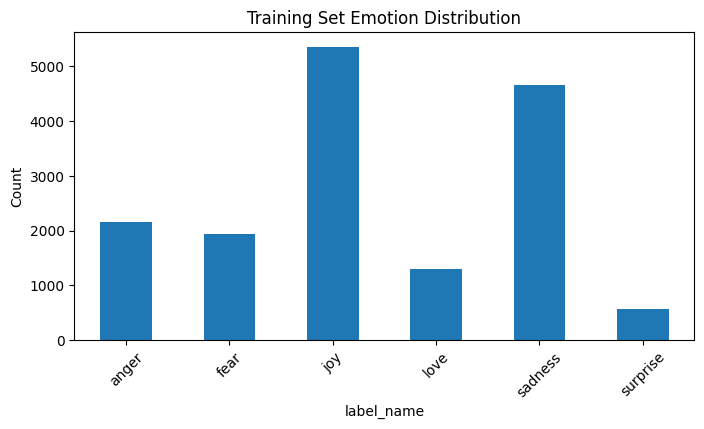


📊 Training Set Distribution:
 label_name
anger       2159
fear        1937
joy         5362
love        1304
sadness     4666
surprise     572
Name: count, dtype: int64


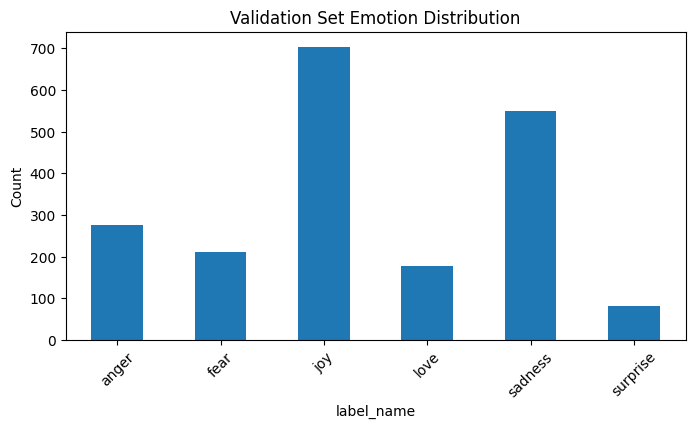


📊 Validation Set Distribution:
 label_name
anger       275
fear        212
joy         704
love        178
sadness     550
surprise     81
Name: count, dtype: int64


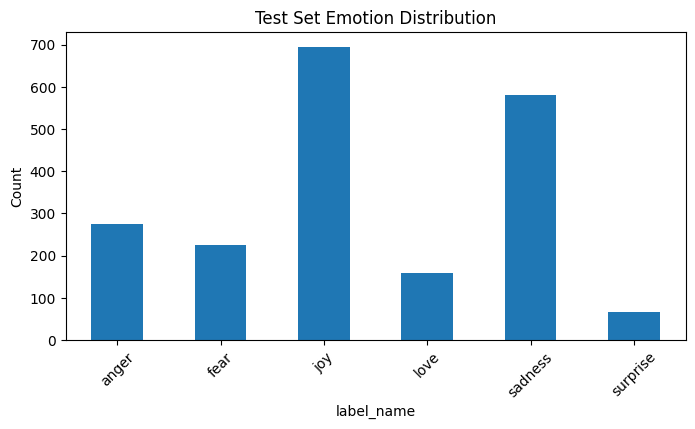


📊 Test Set Distribution:
 label_name
anger       275
fear        224
joy         695
love        159
sadness     581
surprise     66
Name: count, dtype: int64


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert datasets to DataFrames for easier inspection
train_df = pd.DataFrame({"text": train_texts, "label": train_labels})
val_df = pd.DataFrame({"text": val_texts, "label": val_labels})
test_df = pd.DataFrame({"text": test_texts, "label": test_labels})

# Map label IDs to label names
label_map = {i: label for i, label in enumerate(label_list)}
train_df["label_name"] = train_df["label"].map(label_map)
val_df["label_name"] = val_df["label"].map(label_map)
test_df["label_name"] = test_df["label"].map(label_map)

# Function to plot distribution
def plot_distribution(df, split_name):
    counts = df["label_name"].value_counts().sort_index()
    counts.plot(kind="bar", title=f"{split_name} Set Emotion Distribution", figsize=(8,4))
    plt.xticks(rotation=45)
    plt.ylabel("Count")
    plt.show()
    return counts

# Check and plot distributions
print("\n📊 Training Set Distribution:\n", plot_distribution(train_df, "Training"))
print("\n📊 Validation Set Distribution:\n", plot_distribution(val_df, "Validation"))
print("\n📊 Test Set Distribution:\n", plot_distribution(test_df, "Test"))


In [9]:
from sklearn.utils import resample

def downsample_df(df):
    # Find the minimum class count
    min_count = df["label"].value_counts().min()
    
    # Downsample each class to min_count
    balanced_dfs = []
    for label in df["label"].unique():
        df_label = df[df["label"] == label]
        df_down = resample(df_label,
                           replace=False,       # no oversampling
                           n_samples=min_count, # match smallest class size
                           random_state=42)
        balanced_dfs.append(df_down)
    
    # Combine back and shuffle
    balanced_df = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced_df

# Downsample all splits
train_df_bal = downsample_df(train_df)
val_df_bal = downsample_df(val_df)
test_df_bal = downsample_df(test_df)

# Check new distributions
print("\n📊 Balanced Training Set:\n", train_df_bal['label_name'].value_counts())
print("\n📊 Balanced Validation Set:\n", val_df_bal['label_name'].value_counts())
print("\n📊 Balanced Test Set:\n", test_df_bal['label_name'].value_counts())

# Convert back to lists for tokenization
train_texts = train_df_bal["text"].tolist()
train_labels = train_df_bal["label"].tolist()

val_texts = val_df_bal["text"].tolist()
val_labels = val_df_bal["label"].tolist()

test_texts = test_df_bal["text"].tolist()
test_labels = test_df_bal["label"].tolist()




📊 Balanced Training Set:
 label_name
love        572
surprise    572
joy         572
fear        572
anger       572
sadness     572
Name: count, dtype: int64

📊 Balanced Validation Set:
 label_name
surprise    81
joy         81
fear        81
anger       81
love        81
sadness     81
Name: count, dtype: int64

📊 Balanced Test Set:
 label_name
joy         66
love        66
anger       66
sadness     66
surprise    66
fear        66
Name: count, dtype: int64


without LMU

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

# ========== 1. Device Check ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
val_texts = dataset['validation']['text']
val_labels = dataset['validation']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

# ========== 3. Tokenization ==========
model_name = "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== 5. Mean Pooling ==========
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== 6. LMU Layer ==========
class LMULayer(nn.Module):
    def __init__(self, hidden_size, memory_size=64):
        super().__init__()
        self.fc_u = nn.Linear(hidden_size, hidden_size)
        self.fc_h = nn.Linear(hidden_size, hidden_size)
        self.memory = nn.Linear(hidden_size, memory_size)
        self.out = nn.Linear(memory_size, hidden_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        # x: [batch, seq_len, hidden]
        u = self.activation(self.fc_u(x))
        h = self.activation(self.fc_h(x))
        m = self.activation(self.memory(u + h))  # Simple additive memory update
        return self.out(m)

# ========== 7. Emotion Classifier with LMU ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = LMULayer(self.bert.config.hidden_size, memory_size=128)  # Added LMU
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        hidden_states = hidden_states + self.lmu(hidden_states)  # LMU applied here
        pooled = self.pooler(hidden_states, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== 8. Training Setup ==========
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

from transformers import get_scheduler
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0,
                           num_training_steps=len(train_loader) * 10)
criterion = nn.CrossEntropyLoss()

# ========== 9. Training + Validation ==========
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    total_loss = 0
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            output = model(input_ids, mask)
            loss = criterion(output, targets)

            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return total_loss / len(loader), accuracy_score(labels, preds)

def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())

        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"\n📊 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")

    print(f"\n🏆 Best Val Accuracy: {best_acc:.4f}")

# ========== 10. Train ==========
train_model(epochs=20)

# ========== 11. Load Best Model + Test Evaluation ==========
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

def test_evaluate(loader):
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            outputs = model(input_ids, mask)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return labels, preds

true_labels, model_preds = test_evaluate(test_loader)
print("\n🧪 Test Classification Report:\n")
print(classification_report(true_labels, model_preds, target_names=label_list))



🖥️  Using device: cuda



Epoch 1: 100%|██████████| 250/250 [00:11<00:00, 20.98it/s]



📊 Epoch 1: Train Acc: 0.9061, Val Acc: 0.9570


Epoch 2: 100%|██████████| 250/250 [00:11<00:00, 21.87it/s]



📊 Epoch 2: Train Acc: 0.9524, Val Acc: 0.9545


Epoch 3: 100%|██████████| 250/250 [00:11<00:00, 21.76it/s]



📊 Epoch 3: Train Acc: 0.9558, Val Acc: 0.9585


Epoch 4: 100%|██████████| 250/250 [00:17<00:00, 13.90it/s]



📊 Epoch 4: Train Acc: 0.9602, Val Acc: 0.9580


Epoch 5: 100%|██████████| 250/250 [00:29<00:00,  8.34it/s]



📊 Epoch 5: Train Acc: 0.9633, Val Acc: 0.9585


Epoch 6: 100%|██████████| 250/250 [00:30<00:00,  8.18it/s]



📊 Epoch 6: Train Acc: 0.9648, Val Acc: 0.9545


Epoch 7: 100%|██████████| 250/250 [00:30<00:00,  8.13it/s]



📊 Epoch 7: Train Acc: 0.9694, Val Acc: 0.9540


Epoch 8: 100%|██████████| 250/250 [00:30<00:00,  8.09it/s]



📊 Epoch 8: Train Acc: 0.9666, Val Acc: 0.9580


Epoch 9: 100%|██████████| 250/250 [00:25<00:00,  9.78it/s]



📊 Epoch 9: Train Acc: 0.9707, Val Acc: 0.9570


Epoch 10: 100%|██████████| 250/250 [00:18<00:00, 13.57it/s]



📊 Epoch 10: Train Acc: 0.9711, Val Acc: 0.9565


Epoch 11: 100%|██████████| 250/250 [00:11<00:00, 22.53it/s]



📊 Epoch 11: Train Acc: 0.9710, Val Acc: 0.9565


Epoch 12: 100%|██████████| 250/250 [00:11<00:00, 22.40it/s]



📊 Epoch 12: Train Acc: 0.9709, Val Acc: 0.9565


Epoch 13: 100%|██████████| 250/250 [00:11<00:00, 22.35it/s]



📊 Epoch 13: Train Acc: 0.9715, Val Acc: 0.9565


Epoch 14: 100%|██████████| 250/250 [00:25<00:00,  9.84it/s]



📊 Epoch 14: Train Acc: 0.9703, Val Acc: 0.9565


Epoch 15: 100%|██████████| 250/250 [00:29<00:00,  8.40it/s]



📊 Epoch 15: Train Acc: 0.9690, Val Acc: 0.9565


Epoch 16: 100%|██████████| 250/250 [00:30<00:00,  8.32it/s]



📊 Epoch 16: Train Acc: 0.9732, Val Acc: 0.9565


Epoch 17: 100%|██████████| 250/250 [00:28<00:00,  8.73it/s]



📊 Epoch 17: Train Acc: 0.9693, Val Acc: 0.9565


Epoch 18: 100%|██████████| 250/250 [00:28<00:00,  8.77it/s]



📊 Epoch 18: Train Acc: 0.9708, Val Acc: 0.9565


Epoch 19: 100%|██████████| 250/250 [00:28<00:00,  8.70it/s]



📊 Epoch 19: Train Acc: 0.9699, Val Acc: 0.9565


Epoch 20: 100%|██████████| 250/250 [00:29<00:00,  8.56it/s]



📊 Epoch 20: Train Acc: 0.9704, Val Acc: 0.9565

🏆 Best Val Accuracy: 0.9585

🧪 Test Classification Report:

              precision    recall  f1-score   support

     sadness       0.98      0.97      0.98       581
         joy       0.98      0.96      0.97       695
        love       0.85      0.91      0.88       159
       anger       0.95      0.97      0.96       275
        fear       0.94      0.96      0.95       224
    surprise       0.89      0.83      0.86        66

    accuracy                           0.95      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.96      0.95      0.95      2000



with lmu

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, get_scheduler
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
from tqdm import tqdm
import random

# ========== 1. Device Check ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}\n")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available. Enable GPU for faster training.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

# Convert to lists for easier manipulation
train_data = list(zip(dataset['train']['text'], dataset['train']['label']))
val_data = list(zip(dataset['validation']['text'], dataset['validation']['label']))
test_data = list(zip(dataset['test']['text'], dataset['test']['label']))

# ========== 3. Check Class Balance ==========
def check_balance(data, name):
    counts = Counter(label for _, label in data)
    print(f"\n📊 Class distribution in {name}:")
    for i, c in counts.items():
        print(f"{label_list[i]}: {c}")

check_balance(train_data, "Train")
check_balance(val_data, "Validation")
check_balance(test_data, "Test")

# ========== 4. Downsample to Smallest Class ==========
def downsample(data):
    label_groups = {}
    for text, label in data:
        label_groups.setdefault(label, []).append((text, label))
    min_size = min(len(v) for v in label_groups.values())
    balanced = []
    for samples in label_groups.values():
        balanced.extend(random.sample(samples, min_size))
    random.shuffle(balanced)
    return balanced

train_data = downsample(train_data)
val_data = downsample(val_data)
test_data = downsample(test_data)

check_balance(train_data, "Balanced Train")
check_balance(val_data, "Balanced Validation")
check_balance(test_data, "Balanced Test")

# Separate into texts and labels
train_texts, train_labels = zip(*train_data)
val_texts, val_labels = zip(*val_data)
test_texts, test_labels = zip(*test_data)

train_labels = list(train_labels)
val_labels = list(val_labels)
test_labels = list(test_labels)

# ========== 5. Tokenization ==========
model_name = "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(list(texts), padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 6. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== 7. Mean Pooling ==========
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== 8. LMU Layer ==========
class LMULayer(nn.Module):
    def __init__(self, hidden_size, memory_size=64):
        super().__init__()
        self.fc_u = nn.Linear(hidden_size, hidden_size)
        self.fc_h = nn.Linear(hidden_size, hidden_size)
        self.memory = nn.Linear(hidden_size, memory_size)
        self.out = nn.Linear(memory_size, hidden_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        u = self.activation(self.fc_u(x))
        h = self.activation(self.fc_h(x))
        m = self.activation(self.memory(u + h))
        return self.out(m)

# ========== 9. Emotion Classifier with LMU ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = LMULayer(self.bert.config.hidden_size, memory_size=128)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        hidden_states = hidden_states + self.lmu(hidden_states)
        pooled = self.pooler(hidden_states, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== 10. Training Setup ==========
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0,
                           num_training_steps=len(train_loader) * 10)
criterion = nn.CrossEntropyLoss()

# ========== 11. Evaluation Helper ==========
def evaluate(loader):
    model.eval()
    total_loss = 0
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            output = model(input_ids, mask)
            loss = criterion(output, targets)

            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return total_loss / len(loader), accuracy_score(labels, preds)

# ========== 12. Training Loop ==========
def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())

        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)
        print(f"\n📊 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")

    print(f"\n🏆 Best Val Accuracy: {best_acc:.4f}")

# ========== 13. Train ==========
train_model(epochs=20)

# ========== 14. Test Evaluation ==========
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

def test_evaluate(loader):
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            outputs = model(input_ids, mask)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    return labels, preds

true_labels, model_preds = test_evaluate(test_loader)
print("\n🧪 Test Classification Report:\n")
print(classification_report(true_labels, model_preds, target_names=label_list))



🖥️  Using device: cuda


📊 Class distribution in Train:
sadness: 4666
anger: 2159
love: 1304
surprise: 572
fear: 1937
joy: 5362

📊 Class distribution in Validation:
sadness: 550
love: 178
anger: 275
joy: 704
fear: 212
surprise: 81

📊 Class distribution in Test:
sadness: 581
joy: 695
fear: 224
anger: 275
love: 159
surprise: 66

📊 Class distribution in Balanced Train:
fear: 572
sadness: 572
joy: 572
anger: 572
love: 572
surprise: 572

📊 Class distribution in Balanced Validation:
surprise: 81
sadness: 81
fear: 81
anger: 81
love: 81
joy: 81

📊 Class distribution in Balanced Test:
sadness: 66
anger: 66
fear: 66
joy: 66
surprise: 66
love: 66


Epoch 1: 100%|██████████| 54/54 [00:03<00:00, 14.79it/s]



📊 Epoch 1: Train Acc: 0.6652, Val Acc: 0.9630


Epoch 2: 100%|██████████| 54/54 [00:06<00:00,  8.98it/s]



📊 Epoch 2: Train Acc: 0.9298, Val Acc: 0.9588


Epoch 3: 100%|██████████| 54/54 [00:05<00:00, 10.64it/s]



📊 Epoch 3: Train Acc: 0.9467, Val Acc: 0.9568


Epoch 4: 100%|██████████| 54/54 [00:05<00:00, 10.58it/s]



📊 Epoch 4: Train Acc: 0.9487, Val Acc: 0.9568


Epoch 5: 100%|██████████| 54/54 [00:04<00:00, 11.38it/s]



📊 Epoch 5: Train Acc: 0.9499, Val Acc: 0.9547


Epoch 6: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]



📊 Epoch 6: Train Acc: 0.9543, Val Acc: 0.9547


Epoch 7: 100%|██████████| 54/54 [00:05<00:00,  9.54it/s]



📊 Epoch 7: Train Acc: 0.9601, Val Acc: 0.9506


Epoch 8: 100%|██████████| 54/54 [00:05<00:00, 10.47it/s]



📊 Epoch 8: Train Acc: 0.9601, Val Acc: 0.9547


Epoch 9: 100%|██████████| 54/54 [00:05<00:00,  9.77it/s]



📊 Epoch 9: Train Acc: 0.9575, Val Acc: 0.9568


Epoch 10: 100%|██████████| 54/54 [00:04<00:00, 12.14it/s]



📊 Epoch 10: Train Acc: 0.9610, Val Acc: 0.9568


Epoch 11: 100%|██████████| 54/54 [00:02<00:00, 24.06it/s]



📊 Epoch 11: Train Acc: 0.9595, Val Acc: 0.9568


Epoch 12: 100%|██████████| 54/54 [00:02<00:00, 23.46it/s]



📊 Epoch 12: Train Acc: 0.9601, Val Acc: 0.9568


Epoch 13: 100%|██████████| 54/54 [00:02<00:00, 23.02it/s]



📊 Epoch 13: Train Acc: 0.9569, Val Acc: 0.9568


Epoch 14: 100%|██████████| 54/54 [00:02<00:00, 22.37it/s]



📊 Epoch 14: Train Acc: 0.9598, Val Acc: 0.9568


Epoch 15: 100%|██████████| 54/54 [00:02<00:00, 22.70it/s]



📊 Epoch 15: Train Acc: 0.9636, Val Acc: 0.9568


Epoch 16: 100%|██████████| 54/54 [00:02<00:00, 24.52it/s]



📊 Epoch 16: Train Acc: 0.9647, Val Acc: 0.9568


Epoch 17: 100%|██████████| 54/54 [00:02<00:00, 22.50it/s]



📊 Epoch 17: Train Acc: 0.9592, Val Acc: 0.9568


Epoch 18: 100%|██████████| 54/54 [00:02<00:00, 22.12it/s]



📊 Epoch 18: Train Acc: 0.9653, Val Acc: 0.9568


Epoch 19: 100%|██████████| 54/54 [00:02<00:00, 22.94it/s]



📊 Epoch 19: Train Acc: 0.9610, Val Acc: 0.9568


Epoch 20: 100%|██████████| 54/54 [00:02<00:00, 22.44it/s]



📊 Epoch 20: Train Acc: 0.9580, Val Acc: 0.9568

🏆 Best Val Accuracy: 0.9630

🧪 Test Classification Report:

              precision    recall  f1-score   support

     sadness       0.94      0.97      0.96        66
         joy       1.00      0.97      0.98        66
        love       0.97      0.97      0.97        66
       anger       0.90      0.94      0.92        66
        fear       0.97      0.85      0.90        66
    surprise       0.90      0.97      0.93        66

    accuracy                           0.94       396
   macro avg       0.95      0.94      0.94       396
weighted avg       0.95      0.94      0.94       396



Complex lmu

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, get_scheduler
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# ========== 1. Device ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

train_texts, train_labels = dataset['train']['text'], dataset['train']['label']
val_texts, val_labels = dataset['validation']['text'], dataset['validation']['label']
test_texts, test_labels = dataset['test']['text'], dataset['test']['label']

# ========== 3. Tokenizer ==========
model_name = "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== 5. Mean Pooling ==========
class MeanPooling(nn.Module):
    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== 6. Deep LMU ==========
class DeepLMU(nn.Module):
    def __init__(self, hidden_size, memory_size=128, num_layers=3):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.LayerNorm(hidden_size),
                nn.Linear(hidden_size, memory_size),
                nn.ReLU(),
                nn.LayerNorm(memory_size),
                nn.Linear(memory_size, hidden_size),
                nn.ReLU(),
                nn.LayerNorm(hidden_size)
            ) for _ in range(num_layers)
        ])
    def forward(self, x):
        for layer in self.layers:
            x = x + layer(x)  # residual connection
        return x

# ========== 7. Model ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = DeepLMU(self.bert.config.hidden_size)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = self.lmu(outputs.last_hidden_state)
        pooled = self.pooler(hidden_states, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== 8. Training Setup ==========
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0,
                           num_training_steps=len(train_loader) * 20)
criterion = nn.CrossEntropyLoss()

# ========== 9. Evaluation ==========
def evaluate(loader):
    model.eval()
    total_loss, preds, labels = 0, [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            output = model(input_ids, mask)
            loss = criterion(output, targets)
            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())
    return total_loss / len(loader), accuracy_score(labels, preds)

# ========== 10. Train ==========
def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())
        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)
        print(f"📊 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")
    print(f"🏆 Best Val Accuracy: {best_acc:.4f}")

train_model(epochs=20)

# ========== 11. Test ==========
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
preds, labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        outputs = model(input_ids, mask)
        preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        labels.extend(targets.cpu().numpy())
print("\n🧪 Test Classification Report:\n", classification_report(labels, preds, target_names=label_list))


🖥️ Using device: cuda


Epoch 1: 100%|██████████| 250/250 [00:36<00:00,  6.79it/s]


📊 Epoch 1: Train Acc: 0.9224, Val Acc: 0.9535


Epoch 2: 100%|██████████| 250/250 [00:37<00:00,  6.67it/s]


📊 Epoch 2: Train Acc: 0.9496, Val Acc: 0.9645


Epoch 3: 100%|██████████| 250/250 [00:36<00:00,  6.94it/s]


📊 Epoch 3: Train Acc: 0.9559, Val Acc: 0.9550


Epoch 4: 100%|██████████| 250/250 [00:35<00:00,  7.09it/s]


📊 Epoch 4: Train Acc: 0.9587, Val Acc: 0.9610


Epoch 5: 100%|██████████| 250/250 [00:35<00:00,  7.01it/s]


📊 Epoch 5: Train Acc: 0.9605, Val Acc: 0.9575


Epoch 6: 100%|██████████| 250/250 [00:36<00:00,  6.84it/s]


📊 Epoch 6: Train Acc: 0.9639, Val Acc: 0.9565


Epoch 7: 100%|██████████| 250/250 [00:17<00:00, 14.70it/s]


📊 Epoch 7: Train Acc: 0.9662, Val Acc: 0.9590


Epoch 8: 100%|██████████| 250/250 [00:12<00:00, 19.57it/s]


📊 Epoch 8: Train Acc: 0.9678, Val Acc: 0.9570


Epoch 9: 100%|██████████| 250/250 [00:34<00:00,  7.21it/s]


📊 Epoch 9: Train Acc: 0.9689, Val Acc: 0.9600


Epoch 10: 100%|██████████| 250/250 [00:34<00:00,  7.26it/s]


📊 Epoch 10: Train Acc: 0.9715, Val Acc: 0.9550


Epoch 11: 100%|██████████| 250/250 [00:34<00:00,  7.22it/s]


📊 Epoch 11: Train Acc: 0.9711, Val Acc: 0.9575


Epoch 12: 100%|██████████| 250/250 [00:35<00:00,  7.04it/s]


📊 Epoch 12: Train Acc: 0.9746, Val Acc: 0.9545


Epoch 13: 100%|██████████| 250/250 [00:36<00:00,  6.90it/s]


📊 Epoch 13: Train Acc: 0.9744, Val Acc: 0.9560


Epoch 14: 100%|██████████| 250/250 [00:35<00:00,  7.02it/s]


📊 Epoch 14: Train Acc: 0.9751, Val Acc: 0.9560


Epoch 15: 100%|██████████| 250/250 [00:34<00:00,  7.30it/s]


📊 Epoch 15: Train Acc: 0.9779, Val Acc: 0.9615


Epoch 16: 100%|██████████| 250/250 [00:35<00:00,  7.12it/s]


📊 Epoch 16: Train Acc: 0.9791, Val Acc: 0.9615


Epoch 17: 100%|██████████| 250/250 [00:34<00:00,  7.18it/s]


📊 Epoch 17: Train Acc: 0.9792, Val Acc: 0.9570


Epoch 18: 100%|██████████| 250/250 [00:34<00:00,  7.32it/s]


📊 Epoch 18: Train Acc: 0.9791, Val Acc: 0.9580


Epoch 19: 100%|██████████| 250/250 [00:34<00:00,  7.24it/s]


📊 Epoch 19: Train Acc: 0.9807, Val Acc: 0.9600


Epoch 20: 100%|██████████| 250/250 [00:34<00:00,  7.28it/s]


📊 Epoch 20: Train Acc: 0.9816, Val Acc: 0.9605
🏆 Best Val Accuracy: 0.9645

🧪 Test Classification Report:
               precision    recall  f1-score   support

     sadness       0.97      0.98      0.98       581
         joy       0.96      0.97      0.96       695
        love       0.90      0.84      0.87       159
       anger       0.95      0.97      0.96       275
        fear       0.96      0.94      0.95       224
    surprise       0.84      0.86      0.85        66

    accuracy                           0.95      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.95      0.95      0.95      2000



with downsampling

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, get_scheduler
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# ========== 1. Device ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

# Convert to lists for easier manipulation
train_data = list(zip(dataset['train']['text'], dataset['train']['label']))
val_data = list(zip(dataset['validation']['text'], dataset['validation']['label']))
test_data = list(zip(dataset['test']['text'], dataset['test']['label']))

# ========== 3. Check Class Balance ==========
def check_balance(data, name):
    counts = Counter(label for _, label in data)
    print(f"\n📊 Class distribution in {name}:")
    for i, c in counts.items():
        print(f"{label_list[i]}: {c}")

check_balance(train_data, "Train")
check_balance(val_data, "Validation")
check_balance(test_data, "Test")

# ========== 4. Downsample to Smallest Class ==========
def downsample(data):
    label_groups = {}
    for text, label in data:
        label_groups.setdefault(label, []).append((text, label))
    min_size = min(len(v) for v in label_groups.values())
    balanced = []
    for samples in label_groups.values():
        balanced.extend(random.sample(samples, min_size))
    random.shuffle(balanced)
    return balanced

train_data = downsample(train_data)
val_data = downsample(val_data)
test_data = downsample(test_data)

check_balance(train_data, "Balanced Train")
check_balance(val_data, "Balanced Validation")
check_balance(test_data, "Balanced Test")

# Separate into texts and labels
train_texts, train_labels = zip(*train_data)
val_texts, val_labels = zip(*val_data)
test_texts, test_labels = zip(*test_data)

train_labels = list(train_labels)
val_labels = list(val_labels)
test_labels = list(test_labels)


# ========== 3. Tokenizer ==========
model_name = "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== 5. Mean Pooling ==========
class MeanPooling(nn.Module):
    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== 6. Deep LMU ==========
class DeepLMU(nn.Module):
    def __init__(self, hidden_size, memory_size=128, num_layers=3):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.LayerNorm(hidden_size),
                nn.Linear(hidden_size, memory_size),
                nn.ReLU(),
                nn.LayerNorm(memory_size),
                nn.Linear(memory_size, hidden_size),
                nn.ReLU(),
                nn.LayerNorm(hidden_size)
            ) for _ in range(num_layers)
        ])
    def forward(self, x):
        for layer in self.layers:
            x = x + layer(x)  # residual connection
        return x

# ========== 7. Model ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = DeepLMU(self.bert.config.hidden_size)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = self.lmu(outputs.last_hidden_state)
        pooled = self.pooler(hidden_states, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== 8. Training Setup ==========
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0,
                           num_training_steps=len(train_loader) * 20)
criterion = nn.CrossEntropyLoss()

# ========== 9. Evaluation ==========
def evaluate(loader):
    model.eval()
    total_loss, preds, labels = 0, [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            output = model(input_ids, mask)
            loss = criterion(output, targets)
            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())
    return total_loss / len(loader), accuracy_score(labels, preds)

# ========== 10. Train ==========
def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())
        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)
        print(f"📊 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")
    print(f"🏆 Best Val Accuracy: {best_acc:.4f}")

train_model(epochs=20)

# ========== 11. Test ==========
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
preds, labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        outputs = model(input_ids, mask)
        preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        labels.extend(targets.cpu().numpy())
print("\n🧪 Test Classification Report:\n", classification_report(labels, preds, target_names=label_list))


🖥️ Using device: cuda

📊 Class distribution in Train:
sadness: 4666
anger: 2159
love: 1304
surprise: 572
fear: 1937
joy: 5362

📊 Class distribution in Validation:
sadness: 550
love: 178
anger: 275
joy: 704
fear: 212
surprise: 81

📊 Class distribution in Test:
sadness: 581
joy: 695
fear: 224
anger: 275
love: 159
surprise: 66

📊 Class distribution in Balanced Train:
sadness: 572
love: 572
fear: 572
surprise: 572
anger: 572
joy: 572

📊 Class distribution in Balanced Validation:
fear: 81
anger: 81
sadness: 81
love: 81
surprise: 81
joy: 81

📊 Class distribution in Balanced Test:
joy: 66
sadness: 66
fear: 66
surprise: 66
anger: 66
love: 66


Epoch 1: 100%|██████████| 54/54 [00:03<00:00, 16.99it/s]


📊 Epoch 1: Train Acc: 0.8022, Val Acc: 0.9609


Epoch 2: 100%|██████████| 54/54 [00:02<00:00, 18.55it/s]


📊 Epoch 2: Train Acc: 0.9452, Val Acc: 0.9691


Epoch 3: 100%|██████████| 54/54 [00:02<00:00, 18.67it/s]


📊 Epoch 3: Train Acc: 0.9531, Val Acc: 0.9671


Epoch 4: 100%|██████████| 54/54 [00:02<00:00, 19.38it/s]


📊 Epoch 4: Train Acc: 0.9543, Val Acc: 0.9650


Epoch 5: 100%|██████████| 54/54 [00:02<00:00, 18.38it/s]


📊 Epoch 5: Train Acc: 0.9580, Val Acc: 0.9650


Epoch 6: 100%|██████████| 54/54 [00:02<00:00, 18.65it/s]


📊 Epoch 6: Train Acc: 0.9569, Val Acc: 0.9609


Epoch 7: 100%|██████████| 54/54 [00:02<00:00, 18.52it/s]


📊 Epoch 7: Train Acc: 0.9656, Val Acc: 0.9630


Epoch 8: 100%|██████████| 54/54 [00:02<00:00, 19.92it/s]


📊 Epoch 8: Train Acc: 0.9618, Val Acc: 0.9609


Epoch 9: 100%|██████████| 54/54 [00:02<00:00, 19.27it/s]


📊 Epoch 9: Train Acc: 0.9685, Val Acc: 0.9671


Epoch 10: 100%|██████████| 54/54 [00:02<00:00, 18.54it/s]


📊 Epoch 10: Train Acc: 0.9677, Val Acc: 0.9588


Epoch 11: 100%|██████████| 54/54 [00:02<00:00, 19.46it/s]


📊 Epoch 11: Train Acc: 0.9691, Val Acc: 0.9630


Epoch 12: 100%|██████████| 54/54 [00:02<00:00, 19.53it/s]


📊 Epoch 12: Train Acc: 0.9665, Val Acc: 0.9650


Epoch 13: 100%|██████████| 54/54 [00:02<00:00, 19.83it/s]


📊 Epoch 13: Train Acc: 0.9712, Val Acc: 0.9691


Epoch 14: 100%|██████████| 54/54 [00:02<00:00, 18.53it/s]


📊 Epoch 14: Train Acc: 0.9697, Val Acc: 0.9609


Epoch 15: 100%|██████████| 54/54 [00:02<00:00, 19.70it/s]


📊 Epoch 15: Train Acc: 0.9755, Val Acc: 0.9671


Epoch 16: 100%|██████████| 54/54 [00:02<00:00, 19.04it/s]


📊 Epoch 16: Train Acc: 0.9709, Val Acc: 0.9609


Epoch 17: 100%|██████████| 54/54 [00:02<00:00, 19.21it/s]


📊 Epoch 17: Train Acc: 0.9767, Val Acc: 0.9650


Epoch 18: 100%|██████████| 54/54 [00:02<00:00, 19.15it/s]


📊 Epoch 18: Train Acc: 0.9744, Val Acc: 0.9650


Epoch 19: 100%|██████████| 54/54 [00:02<00:00, 19.62it/s]


📊 Epoch 19: Train Acc: 0.9758, Val Acc: 0.9650


Epoch 20: 100%|██████████| 54/54 [00:02<00:00, 18.89it/s]


📊 Epoch 20: Train Acc: 0.9773, Val Acc: 0.9650
🏆 Best Val Accuracy: 0.9691

🧪 Test Classification Report:
               precision    recall  f1-score   support

     sadness       0.98      0.95      0.97        66
         joy       1.00      0.95      0.98        66
        love       0.97      1.00      0.99        66
       anger       0.94      0.98      0.96        66
        fear       1.00      0.86      0.93        66
    surprise       0.88      1.00      0.94        66

    accuracy                           0.96       396
   macro avg       0.96      0.96      0.96       396
weighted avg       0.96      0.96      0.96       396



In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import random
from collections import Counter
import torch.nn.functional as F
import math  # <-- Added for cosine scheduler

# ========== 1. Device ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

# Convert to lists for easier manipulation
train_data = list(zip(dataset['train']['text'], dataset['train']['label']))
val_data = list(zip(dataset['validation']['text'], dataset['validation']['label']))
test_data = list(zip(dataset['test']['text'], dataset['test']['label']))

# ========== 3. Check Class Balance ==========
def check_balance(data, name):
    counts = Counter(label for _, label in data)
    print(f"\n📊 Class distribution in {name}:")
    for i, c in counts.items():
        print(f"{label_list[i]}: {c}")

check_balance(train_data, "Train")
check_balance(val_data, "Validation")
check_balance(test_data, "Test")

# ========== 4. Downsample to Smallest Class ==========
def downsample(data):
    label_groups = {}
    for text, label in data:
        label_groups.setdefault(label, []).append((text, label))
    min_size = min(len(v) for v in label_groups.values())
    balanced = []
    for samples in label_groups.values():
        balanced.extend(random.sample(samples, min_size))
    random.shuffle(balanced)
    return balanced

train_data = downsample(train_data)
val_data = downsample(val_data)
test_data = downsample(test_data)

check_balance(train_data, "Balanced Train")
check_balance(val_data, "Balanced Validation")
check_balance(test_data, "Balanced Test")

# Separate into texts and labels
train_texts, train_labels = zip(*train_data)
val_texts, val_labels = zip(*val_data)
test_texts, test_labels = zip(*test_data)

train_labels = list(train_labels)
val_labels = list(val_labels)
test_labels = list(test_labels)

# ========== 3. Tokenizer ==========
model_name = "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== NEW: Advanced Pooling ==========
class AdvancedPooling(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=8, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, last_hidden_state, attention_mask):
        # Self-attention pooling
        attn_output, _ = self.attention(last_hidden_state, last_hidden_state, last_hidden_state,
                                       key_padding_mask=~attention_mask.bool())
        attn_output = self.layer_norm(attn_output)
        
        # Combine mean and max pooling
        mask_exp = attention_mask.unsqueeze(-1).expand(attn_output.size()).float()
        
        # Mean pooling
        sum_embeddings = torch.sum(attn_output * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        mean_pooled = sum_embeddings / sum_mask
        
        # Max pooling
        attn_output = attn_output.masked_fill(mask_exp == 0, -1e9)
        max_pooled, _ = torch.max(attn_output, dim=1)
        
        # Concatenate mean and max pooling
        return torch.cat([mean_pooled, max_pooled], dim=-1)

# ========== 5. Mean Pooling (Original) ==========
class MeanPooling(nn.Module):
    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== NEW: Enhanced LMU with Residual Connections ==========
class EnhancedDeepLMU(nn.Module):
    def __init__(self, hidden_size, memory_size=128, num_layers=3):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.GELU(),
                nn.LayerNorm(hidden_size),
                nn.Dropout(0.1),
                nn.Linear(hidden_size, memory_size),
                nn.GELU(),
                nn.LayerNorm(memory_size),
                nn.Dropout(0.1),
                nn.Linear(memory_size, hidden_size),
                nn.GELU(),
                nn.LayerNorm(hidden_size)
            ) for _ in range(num_layers)
        ])
        
        self.self_attention = nn.MultiheadAttention(hidden_size, num_heads=8, batch_first=True)
        self.attention_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, x):
        for layer in self.layers:
            x = x + layer(x)
        attn_output, _ = self.self_attention(x, x, x)
        x = self.attention_norm(x + attn_output)
        return x

# ========== 6. Deep LMU (Original) ==========
class DeepLMU(nn.Module):
    def __init__(self, hidden_size, memory_size=128, num_layers=3):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.LayerNorm(hidden_size),
                nn.Linear(hidden_size, memory_size),
                nn.ReLU(),
                nn.LayerNorm(memory_size),
                nn.Linear(memory_size, hidden_size),
                nn.ReLU(),
                nn.LayerNorm(hidden_size)
            ) for _ in range(num_layers)
        ])
    def forward(self, x):
        for layer in self.layers:
            x = x + layer(x)
        return x

# ========== NEW: Enhanced Model with Multiple Improvements ==========
class EnhancedEmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = EnhancedDeepLMU(self.bert.config.hidden_size)
        self.pooler = AdvancedPooling(self.bert.config.hidden_size)
        
        hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size // 2, num_labels)
        )
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = self.lmu(outputs.last_hidden_state)
        pooled = self.pooler(hidden_states, attention_mask)
        return self.classifier(pooled)

# ========== 7. Model (Original) ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = DeepLMU(self.bert.config.hidden_size)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = self.lmu(outputs.last_hidden_state)
        pooled = self.pooler(hidden_states, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== NEW: Focal Loss for better handling of class imbalance ==========
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# ========== 8. Learning Rate Scheduler ==========
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * num_cycles * 2.0 * progress)))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# ========== 9. Training Setup ==========
def train(model, train_loader, val_loader, epochs, lr):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    total_steps = epochs * len(train_loader)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1*total_steps), num_training_steps=total_steps)
    criterion = FocalLoss()  # Can switch to nn.CrossEntropyLoss() if you want
    
    model.to(device)
    
    best_val_acc = 0.0
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_losses.append(loss.item())
        
        avg_train_loss = sum(train_losses) / len(train_losses)
        
        val_acc, val_report = evaluate(model, val_loader)
        
        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_emotion_model.pt")
            print("💾 Saved Best Model")
    
    print("Training completed.")

def evaluate(model, dataloader):
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1)
            preds.extend(predictions.cpu().tolist())
            targets.extend(labels.cpu().tolist())
    acc = accuracy_score(targets, preds)
    report = classification_report(targets, preds, target_names=label_list)
    return acc, report

# ========== 10. Prepare DataLoaders ==========
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# ========== 11. Instantiate and Train Model ==========
model = EnhancedEmotionClassifier(model_name, num_labels)
train(model, train_loader, val_loader, epochs=20, lr=2e-5)

# ========== 12. Load Best Model and Test ==========
model.load_state_dict(torch.load("best_emotion_model.pt"))
test_acc, test_report = evaluate(model, test_loader)
print(f"\n🎯 Test Accuracy: {test_acc:.4f}\n")
print(test_report)


🖥️ Using device: cuda

📊 Class distribution in Train:
sadness: 4666
anger: 2159
love: 1304
surprise: 572
fear: 1937
joy: 5362

📊 Class distribution in Validation:
sadness: 550
love: 178
anger: 275
joy: 704
fear: 212
surprise: 81

📊 Class distribution in Test:
sadness: 581
joy: 695
fear: 224
anger: 275
love: 159
surprise: 66

📊 Class distribution in Balanced Train:
fear: 572
anger: 572
joy: 572
love: 572
sadness: 572
surprise: 572

📊 Class distribution in Balanced Validation:
joy: 81
love: 81
sadness: 81
surprise: 81
fear: 81
anger: 81

📊 Class distribution in Balanced Test:
joy: 66
anger: 66
love: 66
sadness: 66
surprise: 66
fear: 66


Epoch 1 Training: 100%|██████████| 54/54 [00:03<00:00, 15.06it/s]


Epoch 1 - Train Loss: 1.0143, Val Acc: 0.9239
💾 Saved Best Model


Epoch 2 Training: 100%|██████████| 54/54 [00:03<00:00, 16.22it/s]


Epoch 2 - Train Loss: 0.3852, Val Acc: 0.9630
💾 Saved Best Model


Epoch 3 Training: 100%|██████████| 54/54 [00:03<00:00, 14.83it/s]


Epoch 3 - Train Loss: 0.1878, Val Acc: 0.9650
💾 Saved Best Model


Epoch 4 Training: 100%|██████████| 54/54 [00:03<00:00, 14.19it/s]


Epoch 4 - Train Loss: 0.1425, Val Acc: 0.9650


Epoch 5 Training: 100%|██████████| 54/54 [00:03<00:00, 15.98it/s]


Epoch 5 - Train Loss: 0.1165, Val Acc: 0.9630


Epoch 6 Training: 100%|██████████| 54/54 [00:03<00:00, 16.27it/s]


Epoch 6 - Train Loss: 0.1010, Val Acc: 0.9609


Epoch 7 Training: 100%|██████████| 54/54 [00:03<00:00, 16.72it/s]


Epoch 7 - Train Loss: 0.0911, Val Acc: 0.9650


Epoch 8 Training: 100%|██████████| 54/54 [00:03<00:00, 16.29it/s]


Epoch 8 - Train Loss: 0.0774, Val Acc: 0.9671
💾 Saved Best Model


Epoch 9 Training: 100%|██████████| 54/54 [00:03<00:00, 16.57it/s]


Epoch 9 - Train Loss: 0.0708, Val Acc: 0.9671


Epoch 10 Training: 100%|██████████| 54/54 [00:03<00:00, 15.83it/s]


Epoch 10 - Train Loss: 0.0722, Val Acc: 0.9671


Epoch 11 Training: 100%|██████████| 54/54 [00:03<00:00, 16.99it/s]


Epoch 11 - Train Loss: 0.0616, Val Acc: 0.9630


Epoch 12 Training: 100%|██████████| 54/54 [00:03<00:00, 15.93it/s]


Epoch 12 - Train Loss: 0.0617, Val Acc: 0.9691
💾 Saved Best Model


Epoch 13 Training: 100%|██████████| 54/54 [00:03<00:00, 16.36it/s]


Epoch 13 - Train Loss: 0.0633, Val Acc: 0.9671


Epoch 14 Training: 100%|██████████| 54/54 [00:03<00:00, 16.40it/s]


Epoch 14 - Train Loss: 0.0582, Val Acc: 0.9630


Epoch 15 Training: 100%|██████████| 54/54 [00:03<00:00, 16.45it/s]


Epoch 15 - Train Loss: 0.0573, Val Acc: 0.9671


Epoch 16 Training: 100%|██████████| 54/54 [00:03<00:00, 16.45it/s]


Epoch 16 - Train Loss: 0.0548, Val Acc: 0.9671


Epoch 17 Training: 100%|██████████| 54/54 [00:03<00:00, 16.59it/s]


Epoch 17 - Train Loss: 0.0543, Val Acc: 0.9588


Epoch 18 Training: 100%|██████████| 54/54 [00:03<00:00, 16.45it/s]


Epoch 18 - Train Loss: 0.0504, Val Acc: 0.9650


Epoch 19 Training: 100%|██████████| 54/54 [00:03<00:00, 16.48it/s]


Epoch 19 - Train Loss: 0.0514, Val Acc: 0.9630


Epoch 20 Training: 100%|██████████| 54/54 [00:03<00:00, 16.75it/s]


Epoch 20 - Train Loss: 0.0522, Val Acc: 0.9650
Training completed.

🎯 Test Accuracy: 0.9520

              precision    recall  f1-score   support

     sadness       1.00      0.92      0.96        66
         joy       0.98      0.89      0.94        66
        love       0.93      0.98      0.96        66
       anger       0.94      1.00      0.97        66
        fear       0.95      0.92      0.94        66
    surprise       0.92      0.98      0.95        66

    accuracy                           0.95       396
   macro avg       0.95      0.95      0.95       396
weighted avg       0.95      0.95      0.95       396



In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import random
from collections import Counter
import torch.nn.functional as F
import math  # <-- Added for cosine scheduler

# ========== 1. Device ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

# Convert to lists for easier manipulation
train_data = list(zip(dataset['train']['text'], dataset['train']['label']))
val_data = list(zip(dataset['validation']['text'], dataset['validation']['label']))
test_data = list(zip(dataset['test']['text'], dataset['test']['label']))

# ========== 3. Check Class Balance ==========
def check_balance(data, name):
    counts = Counter(label for _, label in data)
    print(f"\n📊 Class distribution in {name}:")
    for i, c in counts.items():
        print(f"{label_list[i]}: {c}")

check_balance(train_data, "Train")
check_balance(val_data, "Validation")
check_balance(test_data, "Test")

# ========== 4. Downsample to Smallest Class ==========
def downsample(data):
    label_groups = {}
    for text, label in data:
        label_groups.setdefault(label, []).append((text, label))
    min_size = min(len(v) for v in label_groups.values())
    balanced = []
    for samples in label_groups.values():
        balanced.extend(random.sample(samples, min_size))
    random.shuffle(balanced)
    return balanced

train_data = downsample(train_data)
val_data = downsample(val_data)
test_data = downsample(test_data)

check_balance(train_data, "Balanced Train")
check_balance(val_data, "Balanced Validation")
check_balance(test_data, "Balanced Test")

# Separate into texts and labels
train_texts, train_labels = zip(*train_data)
val_texts, val_labels = zip(*val_data)
test_texts, test_labels = zip(*test_data)

train_labels = list(train_labels)
val_labels = list(val_labels)
test_labels = list(test_labels)

# ========== 3. Tokenizer ==========
model_name = "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== NEW: Advanced Pooling ==========
class AdvancedPooling(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=8, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, last_hidden_state, attention_mask):
        # Self-attention pooling
        attn_output, _ = self.attention(last_hidden_state, last_hidden_state, last_hidden_state,
                                       key_padding_mask=~attention_mask.bool())
        attn_output = self.layer_norm(attn_output)
        
        # Combine mean and max pooling
        mask_exp = attention_mask.unsqueeze(-1).expand(attn_output.size()).float()
        
        # Mean pooling
        sum_embeddings = torch.sum(attn_output * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        mean_pooled = sum_embeddings / sum_mask
        
        # Max pooling
        attn_output = attn_output.masked_fill(mask_exp == 0, -1e9)
        max_pooled, _ = torch.max(attn_output, dim=1)
        
        # Concatenate mean and max pooling
        return torch.cat([mean_pooled, max_pooled], dim=-1)

# ========== 5. Mean Pooling (Original) ==========
class MeanPooling(nn.Module):
    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== NEW: Enhanced LMU with Residual Connections ==========
class EnhancedDeepLMU(nn.Module):
    def __init__(self, hidden_size, memory_size=128, num_layers=3):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.GELU(),
                nn.LayerNorm(hidden_size),
                nn.Dropout(0.1),
                nn.Linear(hidden_size, memory_size),
                nn.GELU(),
                nn.LayerNorm(memory_size),
                nn.Dropout(0.1),
                nn.Linear(memory_size, hidden_size),
                nn.GELU(),
                nn.LayerNorm(hidden_size)
            ) for _ in range(num_layers)
        ])
        
        self.self_attention = nn.MultiheadAttention(hidden_size, num_heads=8, batch_first=True)
        self.attention_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, x):
        for layer in self.layers:
            x = x + layer(x)
        attn_output, _ = self.self_attention(x, x, x)
        x = self.attention_norm(x + attn_output)
        return x

# ========== 6. Deep LMU (Original) ==========
class DeepLMU(nn.Module):
    def __init__(self, hidden_size, memory_size=128, num_layers=3):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.LayerNorm(hidden_size),
                nn.Linear(hidden_size, memory_size),
                nn.ReLU(),
                nn.LayerNorm(memory_size),
                nn.Linear(memory_size, hidden_size),
                nn.ReLU(),
                nn.LayerNorm(hidden_size)
            ) for _ in range(num_layers)
        ])
    def forward(self, x):
        for layer in self.layers:
            x = x + layer(x)
        return x

# ========== NEW: Enhanced Model with Multiple Improvements ==========
class EnhancedEmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = EnhancedDeepLMU(self.bert.config.hidden_size)
        self.pooler = AdvancedPooling(self.bert.config.hidden_size)
        
        hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size // 2, num_labels)
        )
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = self.lmu(outputs.last_hidden_state)
        pooled = self.pooler(hidden_states, attention_mask)
        return self.classifier(pooled)

# ========== 7. Model (Original) ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = DeepLMU(self.bert.config.hidden_size)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = self.lmu(outputs.last_hidden_state)
        pooled = self.pooler(hidden_states, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== NEW: Focal Loss for better handling of class imbalance ==========
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# ========== 8. Learning Rate Scheduler ==========
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * num_cycles * 2.0 * progress)))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# ========== 9. Training Setup ==========
def train(model, train_loader, val_loader, epochs, lr):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    total_steps = epochs * len(train_loader)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1*total_steps), num_training_steps=total_steps)
    criterion = FocalLoss()  # Can switch to nn.CrossEntropyLoss() if you want
    
    model.to(device)
    
    best_val_acc = 0.0
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_losses.append(loss.item())
        
        avg_train_loss = sum(train_losses) / len(train_losses)
        
        val_acc, val_report = evaluate(model, val_loader)
        
        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_emotion_model.pt")
            print("💾 Saved Best Model")
    
    print("Training completed.")

def evaluate(model, dataloader):
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1)
            preds.extend(predictions.cpu().tolist())
            targets.extend(labels.cpu().tolist())
    acc = accuracy_score(targets, preds)
    report = classification_report(targets, preds, target_names=label_list)
    return acc, report

# ========== 10. Prepare DataLoaders ==========
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# ========== 11. Instantiate and Train Model ==========
model = EnhancedEmotionClassifier(model_name, num_labels)
train(model, train_loader, val_loader, epochs=100, lr=2e-5)

# ========== 12. Load Best Model and Test ==========
model.load_state_dict(torch.load("best_emotion_model.pt"))
test_acc, test_report = evaluate(model, test_loader)
print(f"\n🎯 Test Accuracy: {test_acc:.4f}\n")
print(test_report)


🖥️ Using device: cuda

📊 Class distribution in Train:
sadness: 4666
anger: 2159
love: 1304
surprise: 572
fear: 1937
joy: 5362

📊 Class distribution in Validation:
sadness: 550
love: 178
anger: 275
joy: 704
fear: 212
surprise: 81

📊 Class distribution in Test:
sadness: 581
joy: 695
fear: 224
anger: 275
love: 159
surprise: 66

📊 Class distribution in Balanced Train:
joy: 572
anger: 572
sadness: 572
surprise: 572
fear: 572
love: 572

📊 Class distribution in Balanced Validation:
anger: 81
surprise: 81
sadness: 81
love: 81
fear: 81
joy: 81

📊 Class distribution in Balanced Test:
joy: 66
love: 66
anger: 66
fear: 66
surprise: 66
sadness: 66


Epoch 1 Training: 100%|██████████| 54/54 [00:03<00:00, 16.13it/s]


Epoch 1 - Train Loss: 1.3240, Val Acc: 0.2407
💾 Saved Best Model


Epoch 2 Training: 100%|██████████| 54/54 [00:02<00:00, 18.06it/s]


Epoch 2 - Train Loss: 0.9752, Val Acc: 0.8642
💾 Saved Best Model


Epoch 3 Training: 100%|██████████| 54/54 [00:02<00:00, 18.64it/s]


Epoch 3 - Train Loss: 0.5613, Val Acc: 0.9527
💾 Saved Best Model


Epoch 4 Training: 100%|██████████| 54/54 [00:03<00:00, 17.44it/s]


Epoch 4 - Train Loss: 0.3439, Val Acc: 0.9630
💾 Saved Best Model


Epoch 5 Training: 100%|██████████| 54/54 [00:03<00:00, 17.96it/s]


Epoch 5 - Train Loss: 0.2373, Val Acc: 0.9650
💾 Saved Best Model


Epoch 6 Training: 100%|██████████| 54/54 [00:02<00:00, 19.31it/s]


Epoch 6 - Train Loss: 0.1818, Val Acc: 0.9630


Epoch 7 Training: 100%|██████████| 54/54 [00:02<00:00, 18.66it/s]


Epoch 7 - Train Loss: 0.1444, Val Acc: 0.9630


Epoch 8 Training: 100%|██████████| 54/54 [00:02<00:00, 18.92it/s]


Epoch 8 - Train Loss: 0.1197, Val Acc: 0.9691
💾 Saved Best Model


Epoch 9 Training: 100%|██████████| 54/54 [00:02<00:00, 18.74it/s]


Epoch 9 - Train Loss: 0.1035, Val Acc: 0.9630


Epoch 10 Training: 100%|██████████| 54/54 [00:02<00:00, 18.91it/s]


Epoch 10 - Train Loss: 0.0901, Val Acc: 0.9568


Epoch 11 Training: 100%|██████████| 54/54 [00:02<00:00, 19.11it/s]


Epoch 11 - Train Loss: 0.0848, Val Acc: 0.9609


Epoch 12 Training: 100%|██████████| 54/54 [00:02<00:00, 19.77it/s]


Epoch 12 - Train Loss: 0.0793, Val Acc: 0.9630


Epoch 13 Training: 100%|██████████| 54/54 [00:03<00:00, 17.64it/s]


Epoch 13 - Train Loss: 0.0714, Val Acc: 0.9568


Epoch 14 Training: 100%|██████████| 54/54 [00:02<00:00, 18.51it/s]


Epoch 14 - Train Loss: 0.0636, Val Acc: 0.9609


Epoch 15 Training: 100%|██████████| 54/54 [00:02<00:00, 18.62it/s]


Epoch 15 - Train Loss: 0.0630, Val Acc: 0.9588


Epoch 16 Training: 100%|██████████| 54/54 [00:02<00:00, 19.02it/s]


Epoch 16 - Train Loss: 0.0575, Val Acc: 0.9630


Epoch 17 Training: 100%|██████████| 54/54 [00:02<00:00, 19.00it/s]


Epoch 17 - Train Loss: 0.0492, Val Acc: 0.9609


Epoch 18 Training: 100%|██████████| 54/54 [00:02<00:00, 18.96it/s]


Epoch 18 - Train Loss: 0.0517, Val Acc: 0.9568


Epoch 19 Training: 100%|██████████| 54/54 [00:02<00:00, 18.94it/s]


Epoch 19 - Train Loss: 0.0442, Val Acc: 0.9609


Epoch 20 Training: 100%|██████████| 54/54 [00:02<00:00, 18.67it/s]


Epoch 20 - Train Loss: 0.0441, Val Acc: 0.9588


Epoch 21 Training: 100%|██████████| 54/54 [00:02<00:00, 19.34it/s]


Epoch 21 - Train Loss: 0.0429, Val Acc: 0.9609


Epoch 22 Training: 100%|██████████| 54/54 [00:02<00:00, 18.63it/s]


Epoch 22 - Train Loss: 0.0379, Val Acc: 0.9630


Epoch 23 Training: 100%|██████████| 54/54 [00:02<00:00, 18.80it/s]


Epoch 23 - Train Loss: 0.0337, Val Acc: 0.9568


Epoch 24 Training: 100%|██████████| 54/54 [00:02<00:00, 19.14it/s]


Epoch 24 - Train Loss: 0.0337, Val Acc: 0.9527


Epoch 25 Training: 100%|██████████| 54/54 [00:02<00:00, 18.87it/s]


Epoch 25 - Train Loss: 0.0294, Val Acc: 0.9588


Epoch 26 Training: 100%|██████████| 54/54 [00:02<00:00, 19.35it/s]


Epoch 26 - Train Loss: 0.0315, Val Acc: 0.9568


Epoch 27 Training: 100%|██████████| 54/54 [00:02<00:00, 18.49it/s]


Epoch 27 - Train Loss: 0.0304, Val Acc: 0.9486


Epoch 28 Training: 100%|██████████| 54/54 [00:02<00:00, 19.05it/s]


Epoch 28 - Train Loss: 0.0263, Val Acc: 0.9527


Epoch 29 Training: 100%|██████████| 54/54 [00:02<00:00, 18.64it/s]


Epoch 29 - Train Loss: 0.0251, Val Acc: 0.9547


Epoch 30 Training: 100%|██████████| 54/54 [00:02<00:00, 18.72it/s]


Epoch 30 - Train Loss: 0.0203, Val Acc: 0.9506


Epoch 31 Training: 100%|██████████| 54/54 [00:02<00:00, 18.77it/s]


Epoch 31 - Train Loss: 0.0244, Val Acc: 0.9568


Epoch 32 Training: 100%|██████████| 54/54 [00:02<00:00, 18.34it/s]


Epoch 32 - Train Loss: 0.0221, Val Acc: 0.9486


Epoch 33 Training: 100%|██████████| 54/54 [00:02<00:00, 18.79it/s]


Epoch 33 - Train Loss: 0.0234, Val Acc: 0.9547


Epoch 34 Training: 100%|██████████| 54/54 [00:03<00:00, 17.16it/s]


Epoch 34 - Train Loss: 0.0174, Val Acc: 0.9527


Epoch 35 Training: 100%|██████████| 54/54 [00:03<00:00, 17.98it/s]


Epoch 35 - Train Loss: 0.0188, Val Acc: 0.9424


Epoch 36 Training: 100%|██████████| 54/54 [00:02<00:00, 18.33it/s]


Epoch 36 - Train Loss: 0.0167, Val Acc: 0.9486


Epoch 37 Training: 100%|██████████| 54/54 [00:02<00:00, 18.99it/s]


Epoch 37 - Train Loss: 0.0172, Val Acc: 0.9506


Epoch 38 Training: 100%|██████████| 54/54 [00:02<00:00, 18.50it/s]


Epoch 38 - Train Loss: 0.0179, Val Acc: 0.9547


Epoch 39 Training: 100%|██████████| 54/54 [00:02<00:00, 18.92it/s]


Epoch 39 - Train Loss: 0.0158, Val Acc: 0.9568


Epoch 40 Training: 100%|██████████| 54/54 [00:02<00:00, 18.97it/s]


Epoch 40 - Train Loss: 0.0171, Val Acc: 0.9527


Epoch 41 Training: 100%|██████████| 54/54 [00:02<00:00, 18.59it/s]


Epoch 41 - Train Loss: 0.0128, Val Acc: 0.9588


Epoch 42 Training: 100%|██████████| 54/54 [00:02<00:00, 19.69it/s]


Epoch 42 - Train Loss: 0.0180, Val Acc: 0.9588


Epoch 43 Training: 100%|██████████| 54/54 [00:02<00:00, 18.74it/s]


Epoch 43 - Train Loss: 0.0144, Val Acc: 0.9527


Epoch 44 Training: 100%|██████████| 54/54 [00:02<00:00, 18.76it/s]


Epoch 44 - Train Loss: 0.0150, Val Acc: 0.9486


Epoch 45 Training: 100%|██████████| 54/54 [00:02<00:00, 18.91it/s]


Epoch 45 - Train Loss: 0.0140, Val Acc: 0.9588


Epoch 46 Training: 100%|██████████| 54/54 [00:02<00:00, 18.43it/s]


Epoch 46 - Train Loss: 0.0105, Val Acc: 0.9547


Epoch 47 Training: 100%|██████████| 54/54 [00:02<00:00, 19.02it/s]


Epoch 47 - Train Loss: 0.0118, Val Acc: 0.9506


Epoch 48 Training: 100%|██████████| 54/54 [00:02<00:00, 18.98it/s]


Epoch 48 - Train Loss: 0.0104, Val Acc: 0.9506


Epoch 49 Training: 100%|██████████| 54/54 [00:02<00:00, 18.68it/s]


Epoch 49 - Train Loss: 0.0109, Val Acc: 0.9506


Epoch 50 Training: 100%|██████████| 54/54 [00:02<00:00, 18.80it/s]


Epoch 50 - Train Loss: 0.0112, Val Acc: 0.9506


Epoch 51 Training: 100%|██████████| 54/54 [00:02<00:00, 18.54it/s]


Epoch 51 - Train Loss: 0.0105, Val Acc: 0.9547


Epoch 52 Training: 100%|██████████| 54/54 [00:02<00:00, 18.50it/s]


Epoch 52 - Train Loss: 0.0086, Val Acc: 0.9568


Epoch 53 Training: 100%|██████████| 54/54 [00:02<00:00, 19.04it/s]


Epoch 53 - Train Loss: 0.0077, Val Acc: 0.9588


Epoch 54 Training: 100%|██████████| 54/54 [00:02<00:00, 18.61it/s]


Epoch 54 - Train Loss: 0.0077, Val Acc: 0.9506


Epoch 55 Training: 100%|██████████| 54/54 [00:02<00:00, 18.74it/s]


Epoch 55 - Train Loss: 0.0096, Val Acc: 0.9568


Epoch 56 Training: 100%|██████████| 54/54 [00:02<00:00, 18.26it/s]


Epoch 56 - Train Loss: 0.0085, Val Acc: 0.9527


Epoch 57 Training: 100%|██████████| 54/54 [00:02<00:00, 18.12it/s]


Epoch 57 - Train Loss: 0.0103, Val Acc: 0.9547


Epoch 58 Training: 100%|██████████| 54/54 [00:02<00:00, 18.12it/s]


Epoch 58 - Train Loss: 0.0082, Val Acc: 0.9527


Epoch 59 Training: 100%|██████████| 54/54 [00:03<00:00, 17.39it/s]


Epoch 59 - Train Loss: 0.0082, Val Acc: 0.9527


Epoch 60 Training: 100%|██████████| 54/54 [00:03<00:00, 16.02it/s]


Epoch 60 - Train Loss: 0.0069, Val Acc: 0.9527


Epoch 61 Training: 100%|██████████| 54/54 [00:02<00:00, 18.63it/s]


Epoch 61 - Train Loss: 0.0053, Val Acc: 0.9527


Epoch 62 Training: 100%|██████████| 54/54 [00:02<00:00, 19.94it/s]


Epoch 62 - Train Loss: 0.0084, Val Acc: 0.9527


Epoch 63 Training: 100%|██████████| 54/54 [00:03<00:00, 17.45it/s]


Epoch 63 - Train Loss: 0.0091, Val Acc: 0.9588


Epoch 64 Training: 100%|██████████| 54/54 [00:03<00:00, 17.65it/s]


Epoch 64 - Train Loss: 0.0083, Val Acc: 0.9547


Epoch 65 Training: 100%|██████████| 54/54 [00:02<00:00, 18.29it/s]


Epoch 65 - Train Loss: 0.0060, Val Acc: 0.9547


Epoch 66 Training: 100%|██████████| 54/54 [00:03<00:00, 17.91it/s]


Epoch 66 - Train Loss: 0.0073, Val Acc: 0.9547


Epoch 67 Training: 100%|██████████| 54/54 [00:02<00:00, 18.56it/s]


Epoch 67 - Train Loss: 0.0048, Val Acc: 0.9547


Epoch 68 Training: 100%|██████████| 54/54 [00:03<00:00, 17.58it/s]


Epoch 68 - Train Loss: 0.0054, Val Acc: 0.9588


Epoch 69 Training: 100%|██████████| 54/54 [00:02<00:00, 18.68it/s]


Epoch 69 - Train Loss: 0.0050, Val Acc: 0.9588


Epoch 70 Training: 100%|██████████| 54/54 [00:03<00:00, 16.49it/s]


Epoch 70 - Train Loss: 0.0056, Val Acc: 0.9506


Epoch 71 Training: 100%|██████████| 54/54 [00:03<00:00, 16.38it/s]


Epoch 71 - Train Loss: 0.0059, Val Acc: 0.9588


Epoch 72 Training: 100%|██████████| 54/54 [00:02<00:00, 18.98it/s]


Epoch 72 - Train Loss: 0.0090, Val Acc: 0.9568


Epoch 73 Training: 100%|██████████| 54/54 [00:02<00:00, 19.96it/s]


Epoch 73 - Train Loss: 0.0055, Val Acc: 0.9527


Epoch 74 Training: 100%|██████████| 54/54 [00:03<00:00, 17.90it/s]


Epoch 74 - Train Loss: 0.0044, Val Acc: 0.9506


Epoch 75 Training: 100%|██████████| 54/54 [00:02<00:00, 19.59it/s]


Epoch 75 - Train Loss: 0.0050, Val Acc: 0.9527


Epoch 76 Training: 100%|██████████| 54/54 [00:02<00:00, 18.59it/s]


Epoch 76 - Train Loss: 0.0063, Val Acc: 0.9547


Epoch 77 Training: 100%|██████████| 54/54 [00:02<00:00, 19.02it/s]


Epoch 77 - Train Loss: 0.0050, Val Acc: 0.9547


Epoch 78 Training: 100%|██████████| 54/54 [00:02<00:00, 18.85it/s]


Epoch 78 - Train Loss: 0.0053, Val Acc: 0.9568


Epoch 79 Training: 100%|██████████| 54/54 [00:02<00:00, 19.15it/s]


Epoch 79 - Train Loss: 0.0053, Val Acc: 0.9568


Epoch 80 Training: 100%|██████████| 54/54 [00:02<00:00, 18.88it/s]


Epoch 80 - Train Loss: 0.0059, Val Acc: 0.9568


Epoch 81 Training: 100%|██████████| 54/54 [00:02<00:00, 18.60it/s]


Epoch 81 - Train Loss: 0.0048, Val Acc: 0.9568


Epoch 82 Training: 100%|██████████| 54/54 [00:02<00:00, 18.88it/s]


Epoch 82 - Train Loss: 0.0044, Val Acc: 0.9568


Epoch 83 Training: 100%|██████████| 54/54 [00:02<00:00, 18.70it/s]


Epoch 83 - Train Loss: 0.0057, Val Acc: 0.9568


Epoch 84 Training: 100%|██████████| 54/54 [00:02<00:00, 18.17it/s]


Epoch 84 - Train Loss: 0.0054, Val Acc: 0.9547


Epoch 85 Training: 100%|██████████| 54/54 [00:02<00:00, 19.12it/s]


Epoch 85 - Train Loss: 0.0059, Val Acc: 0.9568


Epoch 86 Training: 100%|██████████| 54/54 [00:02<00:00, 18.85it/s]


Epoch 86 - Train Loss: 0.0047, Val Acc: 0.9568


Epoch 87 Training: 100%|██████████| 54/54 [00:02<00:00, 18.71it/s]


Epoch 87 - Train Loss: 0.0054, Val Acc: 0.9568


Epoch 88 Training: 100%|██████████| 54/54 [00:02<00:00, 18.60it/s]


Epoch 88 - Train Loss: 0.0043, Val Acc: 0.9568


Epoch 89 Training: 100%|██████████| 54/54 [00:02<00:00, 18.87it/s]


Epoch 89 - Train Loss: 0.0072, Val Acc: 0.9588


Epoch 90 Training: 100%|██████████| 54/54 [00:02<00:00, 18.83it/s]


Epoch 90 - Train Loss: 0.0044, Val Acc: 0.9568


Epoch 91 Training: 100%|██████████| 54/54 [00:02<00:00, 18.42it/s]


Epoch 91 - Train Loss: 0.0077, Val Acc: 0.9568


Epoch 92 Training: 100%|██████████| 54/54 [00:02<00:00, 18.80it/s]


Epoch 92 - Train Loss: 0.0064, Val Acc: 0.9568


Epoch 93 Training: 100%|██████████| 54/54 [00:02<00:00, 18.51it/s]


Epoch 93 - Train Loss: 0.0055, Val Acc: 0.9568


Epoch 94 Training: 100%|██████████| 54/54 [00:02<00:00, 18.38it/s]


Epoch 94 - Train Loss: 0.0041, Val Acc: 0.9568


Epoch 95 Training: 100%|██████████| 54/54 [00:02<00:00, 18.93it/s]


Epoch 95 - Train Loss: 0.0057, Val Acc: 0.9568


Epoch 96 Training: 100%|██████████| 54/54 [00:02<00:00, 18.36it/s]


Epoch 96 - Train Loss: 0.0056, Val Acc: 0.9568


Epoch 97 Training: 100%|██████████| 54/54 [00:02<00:00, 18.72it/s]


Epoch 97 - Train Loss: 0.0062, Val Acc: 0.9568


Epoch 98 Training: 100%|██████████| 54/54 [00:03<00:00, 17.39it/s]


Epoch 98 - Train Loss: 0.0067, Val Acc: 0.9568


Epoch 99 Training: 100%|██████████| 54/54 [00:02<00:00, 18.67it/s]


Epoch 99 - Train Loss: 0.0061, Val Acc: 0.9568


Epoch 100 Training: 100%|██████████| 54/54 [00:03<00:00, 17.03it/s]


Epoch 100 - Train Loss: 0.0053, Val Acc: 0.9568
Training completed.

🎯 Test Accuracy: 0.9495

              precision    recall  f1-score   support

     sadness       0.98      0.94      0.96        66
         joy       0.97      0.92      0.95        66
        love       0.95      0.95      0.95        66
       anger       0.94      0.98      0.96        66
        fear       0.97      0.89      0.93        66
    surprise       0.89      1.00      0.94        66

    accuracy                           0.95       396
   macro avg       0.95      0.95      0.95       396
weighted avg       0.95      0.95      0.95       396



In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import random
from collections import Counter
import torch.nn.functional as F
import math  # <-- Added for cosine scheduler

# ========== 1. Device ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

# Convert to lists for easier manipulation
train_data = list(zip(dataset['train']['text'], dataset['train']['label']))
val_data = list(zip(dataset['validation']['text'], dataset['validation']['label']))
test_data = list(zip(dataset['test']['text'], dataset['test']['label']))

# ========== 3. Check Class Balance ==========
def check_balance(data, name):
    counts = Counter(label for _, label in data)
    print(f"\n📊 Class distribution in {name}:")
    for i, c in counts.items():
        print(f"{label_list[i]}: {c}")

check_balance(train_data, "Train")
check_balance(val_data, "Validation")
check_balance(test_data, "Test")

# ========== 4. Downsample to Smallest Class ==========
def downsample(data):
    label_groups = {}
    for text, label in data:
        label_groups.setdefault(label, []).append((text, label))
    min_size = min(len(v) for v in label_groups.values())
    balanced = []
    for samples in label_groups.values():
        balanced.extend(random.sample(samples, min_size))
    random.shuffle(balanced)
    return balanced

train_data = downsample(train_data)
val_data = downsample(val_data)
test_data = downsample(test_data)

check_balance(train_data, "Balanced Train")
check_balance(val_data, "Balanced Validation")
check_balance(test_data, "Balanced Test")

# Separate into texts and labels
train_texts, train_labels = zip(*train_data)
val_texts, val_labels = zip(*val_data)
test_texts, test_labels = zip(*test_data)

train_labels = list(train_labels)
val_labels = list(val_labels)
test_labels = list(test_labels)

# ========== 3. Tokenizer ==========
model_name = "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== NEW: Advanced Pooling ==========
class AdvancedPooling(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=8, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, last_hidden_state, attention_mask):
        # Self-attention pooling
        attn_output, _ = self.attention(last_hidden_state, last_hidden_state, last_hidden_state,
                                       key_padding_mask=~attention_mask.bool())
        attn_output = self.layer_norm(attn_output)
        
        # Combine mean and max pooling
        mask_exp = attention_mask.unsqueeze(-1).expand(attn_output.size()).float()
        
        # Mean pooling
        sum_embeddings = torch.sum(attn_output * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        mean_pooled = sum_embeddings / sum_mask
        
        # Max pooling
        attn_output = attn_output.masked_fill(mask_exp == 0, -1e9)
        max_pooled, _ = torch.max(attn_output, dim=1)
        
        # Concatenate mean and max pooling
        return torch.cat([mean_pooled, max_pooled], dim=-1)

# ========== 5. Mean Pooling (Original) ==========
class MeanPooling(nn.Module):
    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== NEW: Enhanced LMU with Residual Connections ==========
class EnhancedDeepLMU(nn.Module):
    def __init__(self, hidden_size, memory_size=128, num_layers=3):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.GELU(),
                nn.LayerNorm(hidden_size),
                nn.Dropout(0.1),
                nn.Linear(hidden_size, memory_size),
                nn.GELU(),
                nn.LayerNorm(memory_size),
                nn.Dropout(0.1),
                nn.Linear(memory_size, hidden_size),
                nn.GELU(),
                nn.LayerNorm(hidden_size)
            ) for _ in range(num_layers)
        ])
        
        self.self_attention = nn.MultiheadAttention(hidden_size, num_heads=8, batch_first=True)
        self.attention_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, x):
        for layer in self.layers:
            x = x + layer(x)
        attn_output, _ = self.self_attention(x, x, x)
        x = self.attention_norm(x + attn_output)
        return x

# ========== 6. Deep LMU (Original) ==========
class DeepLMU(nn.Module):
    def __init__(self, hidden_size, memory_size=128, num_layers=3):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.LayerNorm(hidden_size),
                nn.Linear(hidden_size, memory_size),
                nn.ReLU(),
                nn.LayerNorm(memory_size),
                nn.Linear(memory_size, hidden_size),
                nn.ReLU(),
                nn.LayerNorm(hidden_size)
            ) for _ in range(num_layers)
        ])
    def forward(self, x):
        for layer in self.layers:
            x = x + layer(x)
        return x

# ========== NEW: Enhanced Model with Multiple Improvements ==========
class EnhancedEmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = EnhancedDeepLMU(self.bert.config.hidden_size)
        self.pooler = AdvancedPooling(self.bert.config.hidden_size)
        
        hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size // 2, num_labels)
        )
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = self.lmu(outputs.last_hidden_state)
        pooled = self.pooler(hidden_states, attention_mask)
        return self.classifier(pooled)

# ========== 7. Model (Original) ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = DeepLMU(self.bert.config.hidden_size)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = self.lmu(outputs.last_hidden_state)
        pooled = self.pooler(hidden_states, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== NEW: Focal Loss for better handling of class imbalance ==========
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# ========== 8. Learning Rate Scheduler ==========
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * num_cycles * 2.0 * progress)))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# ========== 9. Training Setup ==========
def train(model, train_loader, val_loader, epochs, lr):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    total_steps = epochs * len(train_loader)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1*total_steps), num_training_steps=total_steps)
    criterion = FocalLoss()  # Can switch to nn.CrossEntropyLoss() if you want
    
    model.to(device)
    
    best_val_acc = 0.0
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_losses.append(loss.item())
        
        avg_train_loss = sum(train_losses) / len(train_losses)
        
        val_acc, val_report = evaluate(model, val_loader)
        
        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_emotion_model.pt")
            print("💾 Saved Best Model")
    
    print("Training completed.")

def evaluate(model, dataloader):
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1)
            preds.extend(predictions.cpu().tolist())
            targets.extend(labels.cpu().tolist())
    acc = accuracy_score(targets, preds)
    report = classification_report(targets, preds, target_names=label_list)
    return acc, report

# ========== 10. Prepare DataLoaders ==========
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# ========== 11. Instantiate and Train Model ==========
model = EnhancedEmotionClassifier(model_name, num_labels)
train(model, train_loader, val_loader, epochs=100, lr=3e-5)

# ========== 12. Load Best Model and Test ==========
model.load_state_dict(torch.load("best_emotion_model.pt"))
test_acc, test_report = evaluate(model, test_loader)
print(f"\n🎯 Test Accuracy: {test_acc:.4f}\n")
print(test_report)


🖥️ Using device: cuda

📊 Class distribution in Train:
sadness: 4666
anger: 2159
love: 1304
surprise: 572
fear: 1937
joy: 5362

📊 Class distribution in Validation:
sadness: 550
love: 178
anger: 275
joy: 704
fear: 212
surprise: 81

📊 Class distribution in Test:
sadness: 581
joy: 695
fear: 224
anger: 275
love: 159
surprise: 66

📊 Class distribution in Balanced Train:
anger: 572
love: 572
surprise: 572
fear: 572
joy: 572
sadness: 572

📊 Class distribution in Balanced Validation:
sadness: 81
anger: 81
joy: 81
fear: 81
surprise: 81
love: 81

📊 Class distribution in Balanced Test:
fear: 66
sadness: 66
surprise: 66
joy: 66
love: 66
anger: 66


Epoch 1 Training: 100%|██████████| 54/54 [00:03<00:00, 16.28it/s]


Epoch 1 - Train Loss: 1.3240, Val Acc: 0.3848
💾 Saved Best Model


Epoch 2 Training: 100%|██████████| 54/54 [00:02<00:00, 18.69it/s]


Epoch 2 - Train Loss: 0.8822, Val Acc: 0.9300
💾 Saved Best Model


Epoch 3 Training: 100%|██████████| 54/54 [00:03<00:00, 17.84it/s]


Epoch 3 - Train Loss: 0.4715, Val Acc: 0.9609
💾 Saved Best Model


Epoch 4 Training: 100%|██████████| 54/54 [00:03<00:00, 17.85it/s]


Epoch 4 - Train Loss: 0.2766, Val Acc: 0.9630
💾 Saved Best Model


Epoch 5 Training: 100%|██████████| 54/54 [00:02<00:00, 18.69it/s]


Epoch 5 - Train Loss: 0.1896, Val Acc: 0.9630


Epoch 6 Training: 100%|██████████| 54/54 [00:02<00:00, 19.03it/s]


Epoch 6 - Train Loss: 0.1455, Val Acc: 0.9609


Epoch 7 Training: 100%|██████████| 54/54 [00:02<00:00, 18.81it/s]


Epoch 7 - Train Loss: 0.1245, Val Acc: 0.9568


Epoch 8 Training: 100%|██████████| 54/54 [00:02<00:00, 18.77it/s]


Epoch 8 - Train Loss: 0.1007, Val Acc: 0.9588


Epoch 9 Training: 100%|██████████| 54/54 [00:02<00:00, 19.54it/s]


Epoch 9 - Train Loss: 0.0888, Val Acc: 0.9568


Epoch 10 Training: 100%|██████████| 54/54 [00:02<00:00, 19.47it/s]


Epoch 10 - Train Loss: 0.0750, Val Acc: 0.9588


Epoch 11 Training: 100%|██████████| 54/54 [00:02<00:00, 19.30it/s]


Epoch 11 - Train Loss: 0.0682, Val Acc: 0.9671
💾 Saved Best Model


Epoch 12 Training: 100%|██████████| 54/54 [00:02<00:00, 19.65it/s]


Epoch 12 - Train Loss: 0.0635, Val Acc: 0.9609


Epoch 13 Training: 100%|██████████| 54/54 [00:02<00:00, 19.37it/s]


Epoch 13 - Train Loss: 0.0517, Val Acc: 0.9671


Epoch 14 Training: 100%|██████████| 54/54 [00:02<00:00, 19.38it/s]


Epoch 14 - Train Loss: 0.0507, Val Acc: 0.9609


Epoch 15 Training: 100%|██████████| 54/54 [00:02<00:00, 19.55it/s]


Epoch 15 - Train Loss: 0.0485, Val Acc: 0.9588


Epoch 16 Training: 100%|██████████| 54/54 [00:02<00:00, 18.87it/s]


Epoch 16 - Train Loss: 0.0407, Val Acc: 0.9568


Epoch 17 Training: 100%|██████████| 54/54 [00:02<00:00, 19.15it/s]


Epoch 17 - Train Loss: 0.0401, Val Acc: 0.9609


Epoch 18 Training: 100%|██████████| 54/54 [00:02<00:00, 19.42it/s]


Epoch 18 - Train Loss: 0.0399, Val Acc: 0.9527


Epoch 19 Training: 100%|██████████| 54/54 [00:02<00:00, 19.46it/s]


Epoch 19 - Train Loss: 0.0350, Val Acc: 0.9506


Epoch 20 Training: 100%|██████████| 54/54 [00:02<00:00, 19.52it/s]


Epoch 20 - Train Loss: 0.0367, Val Acc: 0.9527


Epoch 21 Training: 100%|██████████| 54/54 [00:02<00:00, 19.56it/s]


Epoch 21 - Train Loss: 0.0304, Val Acc: 0.9506


Epoch 22 Training: 100%|██████████| 54/54 [00:02<00:00, 19.21it/s]


Epoch 22 - Train Loss: 0.0274, Val Acc: 0.9547


Epoch 23 Training: 100%|██████████| 54/54 [00:03<00:00, 17.96it/s]


Epoch 23 - Train Loss: 0.0225, Val Acc: 0.9588


Epoch 24 Training: 100%|██████████| 54/54 [00:03<00:00, 15.81it/s]


Epoch 24 - Train Loss: 0.0263, Val Acc: 0.9527


Epoch 25 Training: 100%|██████████| 54/54 [00:03<00:00, 17.20it/s]


Epoch 25 - Train Loss: 0.0206, Val Acc: 0.9506


Epoch 26 Training: 100%|██████████| 54/54 [00:02<00:00, 19.45it/s]


Epoch 26 - Train Loss: 0.0204, Val Acc: 0.9527


Epoch 27 Training: 100%|██████████| 54/54 [00:02<00:00, 19.56it/s]


Epoch 27 - Train Loss: 0.0199, Val Acc: 0.9527


Epoch 28 Training: 100%|██████████| 54/54 [00:02<00:00, 19.25it/s]


Epoch 28 - Train Loss: 0.0185, Val Acc: 0.9547


Epoch 29 Training: 100%|██████████| 54/54 [00:02<00:00, 18.52it/s]


Epoch 29 - Train Loss: 0.0153, Val Acc: 0.9588


Epoch 30 Training: 100%|██████████| 54/54 [00:03<00:00, 16.30it/s]


Epoch 30 - Train Loss: 0.0144, Val Acc: 0.9444


Epoch 31 Training: 100%|██████████| 54/54 [00:03<00:00, 17.98it/s]


Epoch 31 - Train Loss: 0.0160, Val Acc: 0.9547


Epoch 32 Training: 100%|██████████| 54/54 [00:02<00:00, 19.10it/s]


Epoch 32 - Train Loss: 0.0157, Val Acc: 0.9444


Epoch 33 Training: 100%|██████████| 54/54 [00:02<00:00, 18.86it/s]


Epoch 33 - Train Loss: 0.0129, Val Acc: 0.9547


Epoch 34 Training: 100%|██████████| 54/54 [00:02<00:00, 18.36it/s]


Epoch 34 - Train Loss: 0.0125, Val Acc: 0.9568


Epoch 35 Training: 100%|██████████| 54/54 [00:02<00:00, 19.19it/s]


Epoch 35 - Train Loss: 0.0111, Val Acc: 0.9527


Epoch 36 Training: 100%|██████████| 54/54 [00:02<00:00, 18.94it/s]


Epoch 36 - Train Loss: 0.0141, Val Acc: 0.9465


Epoch 37 Training: 100%|██████████| 54/54 [00:02<00:00, 19.08it/s]


Epoch 37 - Train Loss: 0.0117, Val Acc: 0.9547


Epoch 38 Training: 100%|██████████| 54/54 [00:02<00:00, 19.44it/s]


Epoch 38 - Train Loss: 0.0106, Val Acc: 0.9465


Epoch 39 Training: 100%|██████████| 54/54 [00:02<00:00, 19.33it/s]


Epoch 39 - Train Loss: 0.0103, Val Acc: 0.9486


Epoch 40 Training: 100%|██████████| 54/54 [00:02<00:00, 19.07it/s]


Epoch 40 - Train Loss: 0.0135, Val Acc: 0.9465


Epoch 41 Training: 100%|██████████| 54/54 [00:02<00:00, 19.22it/s]


Epoch 41 - Train Loss: 0.0101, Val Acc: 0.9547


Epoch 42 Training: 100%|██████████| 54/54 [00:02<00:00, 19.01it/s]


Epoch 42 - Train Loss: 0.0071, Val Acc: 0.9444


Epoch 43 Training: 100%|██████████| 54/54 [00:02<00:00, 19.42it/s]


Epoch 43 - Train Loss: 0.0084, Val Acc: 0.9486


Epoch 44 Training: 100%|██████████| 54/54 [00:02<00:00, 19.53it/s]


Epoch 44 - Train Loss: 0.0075, Val Acc: 0.9486


Epoch 45 Training: 100%|██████████| 54/54 [00:02<00:00, 19.58it/s]


Epoch 45 - Train Loss: 0.0061, Val Acc: 0.9506


Epoch 46 Training: 100%|██████████| 54/54 [00:02<00:00, 19.00it/s]


Epoch 46 - Train Loss: 0.0117, Val Acc: 0.9424


Epoch 47 Training: 100%|██████████| 54/54 [00:02<00:00, 19.65it/s]


Epoch 47 - Train Loss: 0.0062, Val Acc: 0.9403


Epoch 48 Training: 100%|██████████| 54/54 [00:02<00:00, 19.50it/s]


Epoch 48 - Train Loss: 0.0075, Val Acc: 0.9506


Epoch 49 Training: 100%|██████████| 54/54 [00:02<00:00, 19.61it/s]


Epoch 49 - Train Loss: 0.0059, Val Acc: 0.9547


Epoch 50 Training: 100%|██████████| 54/54 [00:02<00:00, 19.07it/s]


Epoch 50 - Train Loss: 0.0073, Val Acc: 0.9444


Epoch 51 Training: 100%|██████████| 54/54 [00:02<00:00, 19.84it/s]


Epoch 51 - Train Loss: 0.0074, Val Acc: 0.9444


Epoch 52 Training: 100%|██████████| 54/54 [00:02<00:00, 19.46it/s]


Epoch 52 - Train Loss: 0.0069, Val Acc: 0.9486


Epoch 53 Training: 100%|██████████| 54/54 [00:02<00:00, 19.53it/s]


Epoch 53 - Train Loss: 0.0050, Val Acc: 0.9424


Epoch 54 Training: 100%|██████████| 54/54 [00:02<00:00, 19.09it/s]


Epoch 54 - Train Loss: 0.0054, Val Acc: 0.9486


Epoch 55 Training: 100%|██████████| 54/54 [00:02<00:00, 19.47it/s]


Epoch 55 - Train Loss: 0.0065, Val Acc: 0.9444


Epoch 56 Training: 100%|██████████| 54/54 [00:02<00:00, 19.54it/s]


Epoch 56 - Train Loss: 0.0069, Val Acc: 0.9486


Epoch 57 Training: 100%|██████████| 54/54 [00:02<00:00, 19.41it/s]


Epoch 57 - Train Loss: 0.0038, Val Acc: 0.9506


Epoch 58 Training: 100%|██████████| 54/54 [00:02<00:00, 19.29it/s]


Epoch 58 - Train Loss: 0.0047, Val Acc: 0.9506


Epoch 59 Training: 100%|██████████| 54/54 [00:02<00:00, 18.72it/s]


Epoch 59 - Train Loss: 0.0045, Val Acc: 0.9486


Epoch 60 Training: 100%|██████████| 54/54 [00:02<00:00, 19.23it/s]


Epoch 60 - Train Loss: 0.0071, Val Acc: 0.9465


Epoch 61 Training: 100%|██████████| 54/54 [00:02<00:00, 19.39it/s]


Epoch 61 - Train Loss: 0.0055, Val Acc: 0.9527


Epoch 62 Training: 100%|██████████| 54/54 [00:02<00:00, 19.23it/s]


Epoch 62 - Train Loss: 0.0033, Val Acc: 0.9486


Epoch 63 Training: 100%|██████████| 54/54 [00:02<00:00, 19.22it/s]


Epoch 63 - Train Loss: 0.0044, Val Acc: 0.9506


Epoch 64 Training: 100%|██████████| 54/54 [00:02<00:00, 19.87it/s]


Epoch 64 - Train Loss: 0.0058, Val Acc: 0.9486


Epoch 65 Training: 100%|██████████| 54/54 [00:02<00:00, 19.35it/s]


Epoch 65 - Train Loss: 0.0038, Val Acc: 0.9486


Epoch 66 Training: 100%|██████████| 54/54 [00:02<00:00, 19.66it/s]


Epoch 66 - Train Loss: 0.0045, Val Acc: 0.9465


Epoch 67 Training: 100%|██████████| 54/54 [00:02<00:00, 19.04it/s]


Epoch 67 - Train Loss: 0.0042, Val Acc: 0.9486


Epoch 68 Training: 100%|██████████| 54/54 [00:02<00:00, 18.20it/s]


Epoch 68 - Train Loss: 0.0053, Val Acc: 0.9444


Epoch 69 Training: 100%|██████████| 54/54 [00:03<00:00, 17.78it/s]


Epoch 69 - Train Loss: 0.0052, Val Acc: 0.9486


Epoch 70 Training: 100%|██████████| 54/54 [00:02<00:00, 18.16it/s]


Epoch 70 - Train Loss: 0.0038, Val Acc: 0.9465


Epoch 71 Training: 100%|██████████| 54/54 [00:02<00:00, 19.55it/s]


Epoch 71 - Train Loss: 0.0034, Val Acc: 0.9424


Epoch 72 Training: 100%|██████████| 54/54 [00:02<00:00, 19.70it/s]


Epoch 72 - Train Loss: 0.0043, Val Acc: 0.9465


Epoch 73 Training: 100%|██████████| 54/54 [00:02<00:00, 19.52it/s]


Epoch 73 - Train Loss: 0.0031, Val Acc: 0.9506


Epoch 74 Training: 100%|██████████| 54/54 [00:02<00:00, 19.00it/s]


Epoch 74 - Train Loss: 0.0053, Val Acc: 0.9547


Epoch 75 Training: 100%|██████████| 54/54 [00:02<00:00, 19.51it/s]


Epoch 75 - Train Loss: 0.0027, Val Acc: 0.9506


Epoch 76 Training: 100%|██████████| 54/54 [00:02<00:00, 19.22it/s]


Epoch 76 - Train Loss: 0.0041, Val Acc: 0.9486


Epoch 77 Training: 100%|██████████| 54/54 [00:02<00:00, 19.34it/s]


Epoch 77 - Train Loss: 0.0040, Val Acc: 0.9486


Epoch 78 Training: 100%|██████████| 54/54 [00:02<00:00, 18.69it/s]


Epoch 78 - Train Loss: 0.0052, Val Acc: 0.9465


Epoch 79 Training: 100%|██████████| 54/54 [00:02<00:00, 19.12it/s]


Epoch 79 - Train Loss: 0.0030, Val Acc: 0.9465


Epoch 80 Training: 100%|██████████| 54/54 [00:02<00:00, 19.05it/s]


Epoch 80 - Train Loss: 0.0053, Val Acc: 0.9506


Epoch 81 Training: 100%|██████████| 54/54 [00:02<00:00, 19.51it/s]


Epoch 81 - Train Loss: 0.0032, Val Acc: 0.9506


Epoch 82 Training: 100%|██████████| 54/54 [00:02<00:00, 19.98it/s]


Epoch 82 - Train Loss: 0.0048, Val Acc: 0.9506


Epoch 83 Training: 100%|██████████| 54/54 [00:02<00:00, 18.78it/s]


Epoch 83 - Train Loss: 0.0033, Val Acc: 0.9506


Epoch 84 Training: 100%|██████████| 54/54 [00:02<00:00, 18.86it/s]


Epoch 84 - Train Loss: 0.0036, Val Acc: 0.9527


Epoch 85 Training: 100%|██████████| 54/54 [00:02<00:00, 18.61it/s]


Epoch 85 - Train Loss: 0.0037, Val Acc: 0.9506


Epoch 86 Training: 100%|██████████| 54/54 [00:02<00:00, 18.89it/s]


Epoch 86 - Train Loss: 0.0021, Val Acc: 0.9506


Epoch 87 Training: 100%|██████████| 54/54 [00:02<00:00, 18.51it/s]


Epoch 87 - Train Loss: 0.0029, Val Acc: 0.9506


Epoch 88 Training: 100%|██████████| 54/54 [00:02<00:00, 18.62it/s]


Epoch 88 - Train Loss: 0.0036, Val Acc: 0.9527


Epoch 89 Training: 100%|██████████| 54/54 [00:02<00:00, 18.77it/s]


Epoch 89 - Train Loss: 0.0028, Val Acc: 0.9506


Epoch 90 Training: 100%|██████████| 54/54 [00:02<00:00, 19.17it/s]


Epoch 90 - Train Loss: 0.0031, Val Acc: 0.9568


Epoch 91 Training: 100%|██████████| 54/54 [00:02<00:00, 19.51it/s]


Epoch 91 - Train Loss: 0.0034, Val Acc: 0.9527


Epoch 92 Training: 100%|██████████| 54/54 [00:02<00:00, 19.25it/s]


Epoch 92 - Train Loss: 0.0036, Val Acc: 0.9527


Epoch 93 Training: 100%|██████████| 54/54 [00:02<00:00, 18.80it/s]


Epoch 93 - Train Loss: 0.0029, Val Acc: 0.9527


Epoch 94 Training: 100%|██████████| 54/54 [00:02<00:00, 19.03it/s]


Epoch 94 - Train Loss: 0.0033, Val Acc: 0.9527


Epoch 95 Training: 100%|██████████| 54/54 [00:02<00:00, 19.36it/s]


Epoch 95 - Train Loss: 0.0030, Val Acc: 0.9527


Epoch 96 Training: 100%|██████████| 54/54 [00:02<00:00, 19.20it/s]


Epoch 96 - Train Loss: 0.0024, Val Acc: 0.9527


Epoch 97 Training: 100%|██████████| 54/54 [00:02<00:00, 19.56it/s]


Epoch 97 - Train Loss: 0.0039, Val Acc: 0.9527


Epoch 98 Training: 100%|██████████| 54/54 [00:02<00:00, 19.08it/s]


Epoch 98 - Train Loss: 0.0047, Val Acc: 0.9527


Epoch 99 Training: 100%|██████████| 54/54 [00:02<00:00, 18.01it/s]


Epoch 99 - Train Loss: 0.0033, Val Acc: 0.9527


Epoch 100 Training: 100%|██████████| 54/54 [00:02<00:00, 19.71it/s]


Epoch 100 - Train Loss: 0.0029, Val Acc: 0.9527
Training completed.

🎯 Test Accuracy: 0.9444

              precision    recall  f1-score   support

     sadness       0.97      0.98      0.98        66
         joy       0.98      0.95      0.97        66
        love       0.98      0.95      0.97        66
       anger       0.98      0.95      0.97        66
        fear       0.92      0.85      0.88        66
    surprise       0.84      0.97      0.90        66

    accuracy                           0.94       396
   macro avg       0.95      0.94      0.94       396
weighted avg       0.95      0.94      0.94       396



In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import random
from collections import Counter
import torch.nn.functional as F
import math  # <-- Added for cosine scheduler

# ========== 1. Device ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

# Convert to lists for easier manipulation
train_data = list(zip(dataset['train']['text'], dataset['train']['label']))
val_data = list(zip(dataset['validation']['text'], dataset['validation']['label']))
test_data = list(zip(dataset['test']['text'], dataset['test']['label']))

# ========== 3. Check Class Balance ==========
def check_balance(data, name):
    counts = Counter(label for _, label in data)
    print(f"\n📊 Class distribution in {name}:")
    for i, c in counts.items():
        print(f"{label_list[i]}: {c}")

check_balance(train_data, "Train")
check_balance(val_data, "Validation")
check_balance(test_data, "Test")

# ========== 4. Downsample to Smallest Class ==========
def downsample(data):
    label_groups = {}
    for text, label in data:
        label_groups.setdefault(label, []).append((text, label))
    min_size = min(len(v) for v in label_groups.values())
    balanced = []
    for samples in label_groups.values():
        balanced.extend(random.sample(samples, min_size))
    random.shuffle(balanced)
    return balanced

train_data = downsample(train_data)
val_data = downsample(val_data)
test_data = downsample(test_data)

check_balance(train_data, "Balanced Train")
check_balance(val_data, "Balanced Validation")
check_balance(test_data, "Balanced Test")

# Separate into texts and labels
train_texts, train_labels = zip(*train_data)
val_texts, val_labels = zip(*val_data)
test_texts, test_labels = zip(*test_data)

train_labels = list(train_labels)
val_labels = list(val_labels)
test_labels = list(test_labels)

# ========== 3. Tokenizer ==========
model_name = "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== NEW: Advanced Pooling ==========
class AdvancedPooling(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=8, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, last_hidden_state, attention_mask):
        # Self-attention pooling
        attn_output, _ = self.attention(last_hidden_state, last_hidden_state, last_hidden_state,
                                       key_padding_mask=~attention_mask.bool())
        attn_output = self.layer_norm(attn_output)
        
        # Combine mean and max pooling
        mask_exp = attention_mask.unsqueeze(-1).expand(attn_output.size()).float()
        
        # Mean pooling
        sum_embeddings = torch.sum(attn_output * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        mean_pooled = sum_embeddings / sum_mask
        
        # Max pooling
        attn_output = attn_output.masked_fill(mask_exp == 0, -1e9)
        max_pooled, _ = torch.max(attn_output, dim=1)
        
        # Concatenate mean and max pooling
        return torch.cat([mean_pooled, max_pooled], dim=-1)

# ========== 5. Mean Pooling (Original) ==========
class MeanPooling(nn.Module):
    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== NEW: Enhanced LMU with Residual Connections ==========
class EnhancedDeepLMU(nn.Module):
    def __init__(self, hidden_size, memory_size=128, num_layers=3):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.GELU(),
                nn.LayerNorm(hidden_size),
                nn.Dropout(0.1),
                nn.Linear(hidden_size, memory_size),
                nn.GELU(),
                nn.LayerNorm(memory_size),
                nn.Dropout(0.1),
                nn.Linear(memory_size, hidden_size),
                nn.GELU(),
                nn.LayerNorm(hidden_size)
            ) for _ in range(num_layers)
        ])
        
        self.self_attention = nn.MultiheadAttention(hidden_size, num_heads=8, batch_first=True)
        self.attention_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, x):
        for layer in self.layers:
            x = x + layer(x)
        attn_output, _ = self.self_attention(x, x, x)
        x = self.attention_norm(x + attn_output)
        return x

# ========== 6. Deep LMU (Original) ==========
class DeepLMU(nn.Module):
    def __init__(self, hidden_size, memory_size=128, num_layers=3):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.LayerNorm(hidden_size),
                nn.Linear(hidden_size, memory_size),
                nn.ReLU(),
                nn.LayerNorm(memory_size),
                nn.Linear(memory_size, hidden_size),
                nn.ReLU(),
                nn.LayerNorm(hidden_size)
            ) for _ in range(num_layers)
        ])
    def forward(self, x):
        for layer in self.layers:
            x = x + layer(x)
        return x

# ========== NEW: Enhanced Model with Multiple Improvements ==========
class EnhancedEmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = EnhancedDeepLMU(self.bert.config.hidden_size)
        self.pooler = AdvancedPooling(self.bert.config.hidden_size)
        
        hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size // 2, num_labels)
        )
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = self.lmu(outputs.last_hidden_state)
        pooled = self.pooler(hidden_states, attention_mask)
        return self.classifier(pooled)

# ========== 7. Model (Original) ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = DeepLMU(self.bert.config.hidden_size)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = self.lmu(outputs.last_hidden_state)
        pooled = self.pooler(hidden_states, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== NEW: Focal Loss for better handling of class imbalance ==========
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# ========== 8. Learning Rate Scheduler ==========
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * num_cycles * 2.0 * progress)))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# ========== 9. Training Setup ==========
def train(model, train_loader, val_loader, epochs, lr):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    total_steps = epochs * len(train_loader)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1*total_steps), num_training_steps=total_steps)
    criterion = FocalLoss()  # Can switch to nn.CrossEntropyLoss() if you want
    
    model.to(device)
    
    best_val_acc = 0.0
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_losses.append(loss.item())
        
        avg_train_loss = sum(train_losses) / len(train_losses)
        
        val_acc, val_report = evaluate(model, val_loader)
        
        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_emotion_model.pt")
            print("💾 Saved Best Model")
    
    print("Training completed.")

def evaluate(model, dataloader):
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1)
            preds.extend(predictions.cpu().tolist())
            targets.extend(labels.cpu().tolist())
    acc = accuracy_score(targets, preds)
    report = classification_report(targets, preds, target_names=label_list)
    return acc, report

# ========== 10. Prepare DataLoaders ==========
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# ========== 11. Instantiate and Train Model ==========
model = EnhancedEmotionClassifier(model_name, num_labels)
train(model, train_loader, val_loader, epochs=100, lr=1e-5)

# ========== 12. Load Best Model and Test ==========
model.load_state_dict(torch.load("best_emotion_model.pt"))
test_acc, test_report = evaluate(model, test_loader)
print(f"\n🎯 Test Accuracy: {test_acc:.4f}\n")
print(test_report)


🖥️ Using device: cuda

📊 Class distribution in Train:
sadness: 4666
anger: 2159
love: 1304
surprise: 572
fear: 1937
joy: 5362

📊 Class distribution in Validation:
sadness: 550
love: 178
anger: 275
joy: 704
fear: 212
surprise: 81

📊 Class distribution in Test:
sadness: 581
joy: 695
fear: 224
anger: 275
love: 159
surprise: 66

📊 Class distribution in Balanced Train:
surprise: 572
anger: 572
joy: 572
sadness: 572
love: 572
fear: 572

📊 Class distribution in Balanced Validation:
fear: 81
joy: 81
sadness: 81
anger: 81
surprise: 81
love: 81

📊 Class distribution in Balanced Test:
anger: 66
sadness: 66
surprise: 66
fear: 66
joy: 66
love: 66


Epoch 1 Training: 100%|██████████| 54/54 [00:03<00:00, 17.07it/s]


Epoch 1 - Train Loss: 1.4371, Val Acc: 0.1276
💾 Saved Best Model


Epoch 2 Training: 100%|██████████| 54/54 [00:02<00:00, 18.28it/s]


Epoch 2 - Train Loss: 1.2614, Val Acc: 0.5412
💾 Saved Best Model


Epoch 3 Training: 100%|██████████| 54/54 [00:02<00:00, 18.78it/s]


Epoch 3 - Train Loss: 0.9426, Val Acc: 0.8951
💾 Saved Best Model


Epoch 4 Training: 100%|██████████| 54/54 [00:02<00:00, 18.20it/s]


Epoch 4 - Train Loss: 0.6485, Val Acc: 0.9506
💾 Saved Best Model


Epoch 5 Training: 100%|██████████| 54/54 [00:02<00:00, 18.43it/s]


Epoch 5 - Train Loss: 0.4413, Val Acc: 0.9609
💾 Saved Best Model


Epoch 6 Training: 100%|██████████| 54/54 [00:02<00:00, 18.54it/s]


Epoch 6 - Train Loss: 0.3219, Val Acc: 0.9588


Epoch 7 Training: 100%|██████████| 54/54 [00:02<00:00, 18.27it/s]


Epoch 7 - Train Loss: 0.2493, Val Acc: 0.9609


Epoch 8 Training: 100%|██████████| 54/54 [00:02<00:00, 18.03it/s]


Epoch 8 - Train Loss: 0.1986, Val Acc: 0.9609


Epoch 9 Training: 100%|██████████| 54/54 [00:02<00:00, 18.50it/s]


Epoch 9 - Train Loss: 0.1710, Val Acc: 0.9691
💾 Saved Best Model


Epoch 10 Training: 100%|██████████| 54/54 [00:02<00:00, 18.15it/s]


Epoch 10 - Train Loss: 0.1534, Val Acc: 0.9630


Epoch 11 Training: 100%|██████████| 54/54 [00:02<00:00, 18.11it/s]


Epoch 11 - Train Loss: 0.1394, Val Acc: 0.9588


Epoch 12 Training: 100%|██████████| 54/54 [00:02<00:00, 18.54it/s]


Epoch 12 - Train Loss: 0.1207, Val Acc: 0.9630


Epoch 13 Training: 100%|██████████| 54/54 [00:02<00:00, 18.84it/s]


Epoch 13 - Train Loss: 0.1125, Val Acc: 0.9671


Epoch 14 Training: 100%|██████████| 54/54 [00:02<00:00, 18.48it/s]


Epoch 14 - Train Loss: 0.0999, Val Acc: 0.9712
💾 Saved Best Model


Epoch 15 Training: 100%|██████████| 54/54 [00:02<00:00, 18.43it/s]


Epoch 15 - Train Loss: 0.0953, Val Acc: 0.9712


Epoch 16 Training: 100%|██████████| 54/54 [00:02<00:00, 18.70it/s]


Epoch 16 - Train Loss: 0.0943, Val Acc: 0.9671


Epoch 17 Training: 100%|██████████| 54/54 [00:02<00:00, 18.78it/s]


Epoch 17 - Train Loss: 0.0821, Val Acc: 0.9712


Epoch 18 Training: 100%|██████████| 54/54 [00:02<00:00, 18.83it/s]


Epoch 18 - Train Loss: 0.0828, Val Acc: 0.9630


Epoch 19 Training: 100%|██████████| 54/54 [00:02<00:00, 18.50it/s]


Epoch 19 - Train Loss: 0.0751, Val Acc: 0.9671


Epoch 20 Training: 100%|██████████| 54/54 [00:02<00:00, 18.62it/s]


Epoch 20 - Train Loss: 0.0730, Val Acc: 0.9650


Epoch 21 Training: 100%|██████████| 54/54 [00:02<00:00, 19.15it/s]


Epoch 21 - Train Loss: 0.0703, Val Acc: 0.9733
💾 Saved Best Model


Epoch 22 Training: 100%|██████████| 54/54 [00:02<00:00, 18.26it/s]


Epoch 22 - Train Loss: 0.0685, Val Acc: 0.9691


Epoch 23 Training: 100%|██████████| 54/54 [00:02<00:00, 19.01it/s]


Epoch 23 - Train Loss: 0.0664, Val Acc: 0.9630


Epoch 24 Training: 100%|██████████| 54/54 [00:02<00:00, 18.92it/s]


Epoch 24 - Train Loss: 0.0623, Val Acc: 0.9671


Epoch 25 Training: 100%|██████████| 54/54 [00:02<00:00, 19.09it/s]


Epoch 25 - Train Loss: 0.0599, Val Acc: 0.9630


Epoch 26 Training: 100%|██████████| 54/54 [00:02<00:00, 19.25it/s]


Epoch 26 - Train Loss: 0.0572, Val Acc: 0.9671


Epoch 27 Training: 100%|██████████| 54/54 [00:02<00:00, 19.10it/s]


Epoch 27 - Train Loss: 0.0571, Val Acc: 0.9609


Epoch 28 Training: 100%|██████████| 54/54 [00:02<00:00, 18.52it/s]


Epoch 28 - Train Loss: 0.0519, Val Acc: 0.9650


Epoch 29 Training: 100%|██████████| 54/54 [00:03<00:00, 17.87it/s]


Epoch 29 - Train Loss: 0.0538, Val Acc: 0.9671


Epoch 30 Training: 100%|██████████| 54/54 [00:03<00:00, 17.94it/s]


Epoch 30 - Train Loss: 0.0483, Val Acc: 0.9630


Epoch 31 Training: 100%|██████████| 54/54 [00:02<00:00, 19.37it/s]


Epoch 31 - Train Loss: 0.0449, Val Acc: 0.9630


Epoch 32 Training: 100%|██████████| 54/54 [00:02<00:00, 19.14it/s]


Epoch 32 - Train Loss: 0.0458, Val Acc: 0.9671


Epoch 33 Training: 100%|██████████| 54/54 [00:02<00:00, 19.00it/s]


Epoch 33 - Train Loss: 0.0429, Val Acc: 0.9630


Epoch 34 Training: 100%|██████████| 54/54 [00:02<00:00, 18.40it/s]


Epoch 34 - Train Loss: 0.0432, Val Acc: 0.9630


Epoch 35 Training: 100%|██████████| 54/54 [00:02<00:00, 19.07it/s]


Epoch 35 - Train Loss: 0.0401, Val Acc: 0.9650


Epoch 36 Training: 100%|██████████| 54/54 [00:02<00:00, 19.18it/s]


Epoch 36 - Train Loss: 0.0402, Val Acc: 0.9650


Epoch 37 Training: 100%|██████████| 54/54 [00:02<00:00, 18.70it/s]


Epoch 37 - Train Loss: 0.0417, Val Acc: 0.9671


Epoch 38 Training: 100%|██████████| 54/54 [00:03<00:00, 17.97it/s]


Epoch 38 - Train Loss: 0.0380, Val Acc: 0.9609


Epoch 39 Training: 100%|██████████| 54/54 [00:02<00:00, 18.70it/s]


Epoch 39 - Train Loss: 0.0397, Val Acc: 0.9650


Epoch 40 Training: 100%|██████████| 54/54 [00:02<00:00, 19.05it/s]


Epoch 40 - Train Loss: 0.0370, Val Acc: 0.9630


Epoch 41 Training: 100%|██████████| 54/54 [00:02<00:00, 19.28it/s]


Epoch 41 - Train Loss: 0.0343, Val Acc: 0.9630


Epoch 42 Training: 100%|██████████| 54/54 [00:02<00:00, 18.62it/s]


Epoch 42 - Train Loss: 0.0354, Val Acc: 0.9671


Epoch 43 Training: 100%|██████████| 54/54 [00:02<00:00, 18.47it/s]


Epoch 43 - Train Loss: 0.0329, Val Acc: 0.9671


Epoch 44 Training: 100%|██████████| 54/54 [00:02<00:00, 18.77it/s]


Epoch 44 - Train Loss: 0.0313, Val Acc: 0.9609


Epoch 45 Training: 100%|██████████| 54/54 [00:02<00:00, 18.52it/s]


Epoch 45 - Train Loss: 0.0332, Val Acc: 0.9671


Epoch 46 Training: 100%|██████████| 54/54 [00:02<00:00, 18.59it/s]


Epoch 46 - Train Loss: 0.0331, Val Acc: 0.9630


Epoch 47 Training: 100%|██████████| 54/54 [00:02<00:00, 18.53it/s]


Epoch 47 - Train Loss: 0.0341, Val Acc: 0.9630


Epoch 48 Training: 100%|██████████| 54/54 [00:03<00:00, 17.30it/s]


Epoch 48 - Train Loss: 0.0276, Val Acc: 0.9630


Epoch 49 Training: 100%|██████████| 54/54 [00:03<00:00, 17.55it/s]


Epoch 49 - Train Loss: 0.0273, Val Acc: 0.9650


Epoch 50 Training: 100%|██████████| 54/54 [00:02<00:00, 18.88it/s]


Epoch 50 - Train Loss: 0.0277, Val Acc: 0.9630


Epoch 51 Training: 100%|██████████| 54/54 [00:02<00:00, 18.32it/s]


Epoch 51 - Train Loss: 0.0279, Val Acc: 0.9650


Epoch 52 Training: 100%|██████████| 54/54 [00:02<00:00, 18.94it/s]


Epoch 52 - Train Loss: 0.0313, Val Acc: 0.9671


Epoch 53 Training: 100%|██████████| 54/54 [00:02<00:00, 18.33it/s]


Epoch 53 - Train Loss: 0.0275, Val Acc: 0.9630


Epoch 54 Training: 100%|██████████| 54/54 [00:02<00:00, 18.62it/s]


Epoch 54 - Train Loss: 0.0267, Val Acc: 0.9671


Epoch 55 Training: 100%|██████████| 54/54 [00:02<00:00, 18.61it/s]


Epoch 55 - Train Loss: 0.0252, Val Acc: 0.9568


Epoch 56 Training: 100%|██████████| 54/54 [00:02<00:00, 18.82it/s]


Epoch 56 - Train Loss: 0.0247, Val Acc: 0.9630


Epoch 57 Training: 100%|██████████| 54/54 [00:02<00:00, 18.90it/s]


Epoch 57 - Train Loss: 0.0277, Val Acc: 0.9609


Epoch 58 Training: 100%|██████████| 54/54 [00:02<00:00, 18.53it/s]


Epoch 58 - Train Loss: 0.0246, Val Acc: 0.9588


Epoch 59 Training: 100%|██████████| 54/54 [00:02<00:00, 18.45it/s]


Epoch 59 - Train Loss: 0.0203, Val Acc: 0.9630


Epoch 60 Training: 100%|██████████| 54/54 [00:02<00:00, 18.67it/s]


Epoch 60 - Train Loss: 0.0220, Val Acc: 0.9609


Epoch 61 Training: 100%|██████████| 54/54 [00:02<00:00, 18.94it/s]


Epoch 61 - Train Loss: 0.0233, Val Acc: 0.9609


Epoch 62 Training: 100%|██████████| 54/54 [00:02<00:00, 18.66it/s]


Epoch 62 - Train Loss: 0.0219, Val Acc: 0.9609


Epoch 63 Training: 100%|██████████| 54/54 [00:02<00:00, 18.77it/s]


Epoch 63 - Train Loss: 0.0216, Val Acc: 0.9630


Epoch 64 Training: 100%|██████████| 54/54 [00:02<00:00, 18.39it/s]


Epoch 64 - Train Loss: 0.0204, Val Acc: 0.9568


Epoch 65 Training: 100%|██████████| 54/54 [00:02<00:00, 18.92it/s]


Epoch 65 - Train Loss: 0.0227, Val Acc: 0.9630


Epoch 66 Training: 100%|██████████| 54/54 [00:03<00:00, 17.69it/s]


Epoch 66 - Train Loss: 0.0202, Val Acc: 0.9630


Epoch 67 Training: 100%|██████████| 54/54 [00:03<00:00, 16.44it/s]


Epoch 67 - Train Loss: 0.0226, Val Acc: 0.9547


Epoch 68 Training: 100%|██████████| 54/54 [00:03<00:00, 17.57it/s]


Epoch 68 - Train Loss: 0.0218, Val Acc: 0.9588


Epoch 69 Training: 100%|██████████| 54/54 [00:02<00:00, 18.28it/s]


Epoch 69 - Train Loss: 0.0204, Val Acc: 0.9609


Epoch 70 Training: 100%|██████████| 54/54 [00:02<00:00, 18.16it/s]


Epoch 70 - Train Loss: 0.0217, Val Acc: 0.9650


Epoch 71 Training: 100%|██████████| 54/54 [00:02<00:00, 18.06it/s]


Epoch 71 - Train Loss: 0.0228, Val Acc: 0.9630


Epoch 72 Training: 100%|██████████| 54/54 [00:03<00:00, 16.76it/s]


Epoch 72 - Train Loss: 0.0203, Val Acc: 0.9671


Epoch 73 Training: 100%|██████████| 54/54 [00:02<00:00, 18.69it/s]


Epoch 73 - Train Loss: 0.0190, Val Acc: 0.9650


Epoch 74 Training: 100%|██████████| 54/54 [00:02<00:00, 19.36it/s]


Epoch 74 - Train Loss: 0.0201, Val Acc: 0.9609


Epoch 75 Training: 100%|██████████| 54/54 [00:02<00:00, 19.03it/s]


Epoch 75 - Train Loss: 0.0211, Val Acc: 0.9650


Epoch 76 Training: 100%|██████████| 54/54 [00:02<00:00, 18.89it/s]


Epoch 76 - Train Loss: 0.0164, Val Acc: 0.9630


Epoch 77 Training: 100%|██████████| 54/54 [00:02<00:00, 18.59it/s]


Epoch 77 - Train Loss: 0.0210, Val Acc: 0.9609


Epoch 78 Training: 100%|██████████| 54/54 [00:02<00:00, 19.44it/s]


Epoch 78 - Train Loss: 0.0219, Val Acc: 0.9630


Epoch 79 Training: 100%|██████████| 54/54 [00:02<00:00, 19.41it/s]


Epoch 79 - Train Loss: 0.0186, Val Acc: 0.9650


Epoch 80 Training: 100%|██████████| 54/54 [00:02<00:00, 18.62it/s]


Epoch 80 - Train Loss: 0.0188, Val Acc: 0.9568


Epoch 81 Training: 100%|██████████| 54/54 [00:02<00:00, 18.92it/s]


Epoch 81 - Train Loss: 0.0181, Val Acc: 0.9630


Epoch 82 Training: 100%|██████████| 54/54 [00:02<00:00, 18.03it/s]


Epoch 82 - Train Loss: 0.0185, Val Acc: 0.9650


Epoch 83 Training: 100%|██████████| 54/54 [00:02<00:00, 19.02it/s]


Epoch 83 - Train Loss: 0.0201, Val Acc: 0.9630


Epoch 84 Training: 100%|██████████| 54/54 [00:02<00:00, 18.24it/s]


Epoch 84 - Train Loss: 0.0185, Val Acc: 0.9650


Epoch 85 Training: 100%|██████████| 54/54 [00:02<00:00, 18.81it/s]


Epoch 85 - Train Loss: 0.0192, Val Acc: 0.9609


Epoch 86 Training: 100%|██████████| 54/54 [00:02<00:00, 18.63it/s]


Epoch 86 - Train Loss: 0.0186, Val Acc: 0.9671


Epoch 87 Training: 100%|██████████| 54/54 [00:02<00:00, 18.63it/s]


Epoch 87 - Train Loss: 0.0187, Val Acc: 0.9671


Epoch 88 Training: 100%|██████████| 54/54 [00:02<00:00, 18.78it/s]


Epoch 88 - Train Loss: 0.0159, Val Acc: 0.9671


Epoch 89 Training: 100%|██████████| 54/54 [00:02<00:00, 19.14it/s]


Epoch 89 - Train Loss: 0.0208, Val Acc: 0.9650


Epoch 90 Training: 100%|██████████| 54/54 [00:02<00:00, 18.12it/s]


Epoch 90 - Train Loss: 0.0181, Val Acc: 0.9650


Epoch 91 Training: 100%|██████████| 54/54 [00:02<00:00, 19.23it/s]


Epoch 91 - Train Loss: 0.0162, Val Acc: 0.9671


Epoch 92 Training: 100%|██████████| 54/54 [00:02<00:00, 18.26it/s]


Epoch 92 - Train Loss: 0.0171, Val Acc: 0.9671


Epoch 93 Training: 100%|██████████| 54/54 [00:02<00:00, 18.88it/s]


Epoch 93 - Train Loss: 0.0180, Val Acc: 0.9630


Epoch 94 Training: 100%|██████████| 54/54 [00:02<00:00, 18.63it/s]


Epoch 94 - Train Loss: 0.0173, Val Acc: 0.9671


Epoch 95 Training: 100%|██████████| 54/54 [00:02<00:00, 18.69it/s]


Epoch 95 - Train Loss: 0.0201, Val Acc: 0.9671


Epoch 96 Training: 100%|██████████| 54/54 [00:02<00:00, 18.37it/s]


Epoch 96 - Train Loss: 0.0186, Val Acc: 0.9671


Epoch 97 Training: 100%|██████████| 54/54 [00:02<00:00, 18.89it/s]


Epoch 97 - Train Loss: 0.0198, Val Acc: 0.9650


Epoch 98 Training: 100%|██████████| 54/54 [00:02<00:00, 18.88it/s]


Epoch 98 - Train Loss: 0.0186, Val Acc: 0.9671


Epoch 99 Training: 100%|██████████| 54/54 [00:02<00:00, 19.16it/s]


Epoch 99 - Train Loss: 0.0184, Val Acc: 0.9671


Epoch 100 Training: 100%|██████████| 54/54 [00:02<00:00, 19.15it/s]


Epoch 100 - Train Loss: 0.0203, Val Acc: 0.9650
Training completed.

🎯 Test Accuracy: 0.9520

              precision    recall  f1-score   support

     sadness       1.00      0.95      0.98        66
         joy       0.95      0.92      0.94        66
        love       0.91      0.97      0.94        66
       anger       0.94      0.97      0.96        66
        fear       0.97      0.91      0.94        66
    surprise       0.94      0.98      0.96        66

    accuracy                           0.95       396
   macro avg       0.95      0.95      0.95       396
weighted avg       0.95      0.95      0.95       396



In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, get_scheduler
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# ========== 1. Device ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

# Convert to lists for easier manipulation
train_data = list(zip(dataset['train']['text'], dataset['train']['label']))
val_data = list(zip(dataset['validation']['text'], dataset['validation']['label']))
test_data = list(zip(dataset['test']['text'], dataset['test']['label']))

# ========== 3. Check Class Balance ==========
def check_balance(data, name):
    counts = Counter(label for _, label in data)
    print(f"\n📊 Class distribution in {name}:")
    for i, c in counts.items():
        print(f"{label_list[i]}: {c}")

check_balance(train_data, "Train")
check_balance(val_data, "Validation")
check_balance(test_data, "Test")

# ========== 4. Downsample to Smallest Class ==========
def downsample(data):
    label_groups = {}
    for text, label in data:
        label_groups.setdefault(label, []).append((text, label))
    min_size = min(len(v) for v in label_groups.values())
    balanced = []
    for samples in label_groups.values():
        balanced.extend(random.sample(samples, min_size))
    random.shuffle(balanced)
    return balanced

train_data = downsample(train_data)
val_data = downsample(val_data)
test_data = downsample(test_data)

check_balance(train_data, "Balanced Train")
check_balance(val_data, "Balanced Validation")
check_balance(test_data, "Balanced Test")

# Separate into texts and labels
train_texts, train_labels = zip(*train_data)
val_texts, val_labels = zip(*val_data)
test_texts, test_labels = zip(*test_data)

train_labels = list(train_labels)
val_labels = list(val_labels)
test_labels = list(test_labels)


# ========== 3. Tokenizer ==========
model_name = "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== 5. Mean Pooling ==========
class MeanPooling(nn.Module):
    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== 6. Deep LMU ==========
class DeepLMU(nn.Module):
    def __init__(self, hidden_size, memory_size=128, num_layers=3):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.GELU(),  # Better activation than ReLU
                nn.LayerNorm(hidden_size),
                nn.Dropout(0.1),
                nn.Linear(hidden_size, memory_size),
                nn.GELU(),
                nn.LayerNorm(memory_size),
                nn.Dropout(0.1),
                nn.Linear(memory_size, hidden_size),
                nn.GELU(),
                nn.LayerNorm(hidden_size)
            ) for _ in range(num_layers)
        ])
        
        # Add attention mechanism
        self.self_attention = nn.MultiheadAttention(hidden_size, num_heads=8, batch_first=True)
        self.attention_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, x):
        # Apply LMU layers with residual connections
        for layer in self.layers:
            x = x + layer(x)
        
        # Apply self-attention
        attn_output, _ = self.self_attention(x, x, x)
        x = self.attention_norm(x + attn_output)
        
        return x

# ========== 7. Model ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = DeepLMU(self.bert.config.hidden_size)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = self.lmu(outputs.last_hidden_state)
        pooled = self.pooler(hidden_states, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== 8. Training Setup ==========
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0,
                           num_training_steps=len(train_loader) * 20)
criterion = nn.CrossEntropyLoss()

# ========== 9. Evaluation ==========
def evaluate(loader):
    model.eval()
    total_loss, preds, labels = 0, [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            output = model(input_ids, mask)
            loss = criterion(output, targets)
            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())
    return total_loss / len(loader), accuracy_score(labels, preds)

# ========== 10. Train ==========
def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())
        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)
        print(f"📊 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")
    print(f"🏆 Best Val Accuracy: {best_acc:.4f}")

train_model(epochs=20)

# ========== 11. Test ==========
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
preds, labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        outputs = model(input_ids, mask)
        preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        labels.extend(targets.cpu().numpy())
print("\n🧪 Test Classification Report:\n", classification_report(labels, preds, target_names=label_list))


🖥️ Using device: cuda

📊 Class distribution in Train:
sadness: 4666
anger: 2159
love: 1304
surprise: 572
fear: 1937
joy: 5362

📊 Class distribution in Validation:
sadness: 550
love: 178
anger: 275
joy: 704
fear: 212
surprise: 81

📊 Class distribution in Test:
sadness: 581
joy: 695
fear: 224
anger: 275
love: 159
surprise: 66

📊 Class distribution in Balanced Train:
love: 572
sadness: 572
anger: 572
surprise: 572
fear: 572
joy: 572

📊 Class distribution in Balanced Validation:
fear: 81
anger: 81
joy: 81
sadness: 81
surprise: 81
love: 81

📊 Class distribution in Balanced Test:
surprise: 66
anger: 66
joy: 66
fear: 66
love: 66
sadness: 66


Epoch 1: 100%|██████████| 54/54 [00:03<00:00, 15.33it/s]


📊 Epoch 1: Train Acc: 0.8045, Val Acc: 0.9527


Epoch 2: 100%|██████████| 54/54 [00:03<00:00, 16.96it/s]


📊 Epoch 2: Train Acc: 0.9426, Val Acc: 0.9403


Epoch 3: 100%|██████████| 54/54 [00:03<00:00, 16.66it/s]


📊 Epoch 3: Train Acc: 0.9516, Val Acc: 0.9506


Epoch 4: 100%|██████████| 54/54 [00:03<00:00, 14.39it/s]


📊 Epoch 4: Train Acc: 0.9545, Val Acc: 0.9527


Epoch 5: 100%|██████████| 54/54 [00:04<00:00, 13.47it/s]


📊 Epoch 5: Train Acc: 0.9604, Val Acc: 0.9568


Epoch 6: 100%|██████████| 54/54 [00:04<00:00, 12.22it/s]


📊 Epoch 6: Train Acc: 0.9563, Val Acc: 0.9527


Epoch 7: 100%|██████████| 54/54 [00:04<00:00, 13.00it/s]


📊 Epoch 7: Train Acc: 0.9656, Val Acc: 0.9547


Epoch 8: 100%|██████████| 54/54 [00:04<00:00, 13.26it/s]


📊 Epoch 8: Train Acc: 0.9694, Val Acc: 0.9527


Epoch 9: 100%|██████████| 54/54 [00:04<00:00, 13.26it/s]


📊 Epoch 9: Train Acc: 0.9706, Val Acc: 0.9527


Epoch 10: 100%|██████████| 54/54 [00:04<00:00, 13.32it/s]


📊 Epoch 10: Train Acc: 0.9723, Val Acc: 0.9547


Epoch 11: 100%|██████████| 54/54 [00:04<00:00, 13.33it/s]


📊 Epoch 11: Train Acc: 0.9694, Val Acc: 0.9486


Epoch 12: 100%|██████████| 54/54 [00:04<00:00, 13.25it/s]


📊 Epoch 12: Train Acc: 0.9747, Val Acc: 0.9527


Epoch 13: 100%|██████████| 54/54 [00:04<00:00, 13.20it/s]


📊 Epoch 13: Train Acc: 0.9735, Val Acc: 0.9547


Epoch 14: 100%|██████████| 54/54 [00:04<00:00, 13.06it/s]


📊 Epoch 14: Train Acc: 0.9755, Val Acc: 0.9547


Epoch 15: 100%|██████████| 54/54 [00:04<00:00, 13.23it/s]


📊 Epoch 15: Train Acc: 0.9752, Val Acc: 0.9568


Epoch 16: 100%|██████████| 54/54 [00:04<00:00, 13.38it/s]


📊 Epoch 16: Train Acc: 0.9802, Val Acc: 0.9609


Epoch 17: 100%|██████████| 54/54 [00:04<00:00, 12.44it/s]


📊 Epoch 17: Train Acc: 0.9779, Val Acc: 0.9609


Epoch 18: 100%|██████████| 54/54 [00:04<00:00, 13.12it/s]


📊 Epoch 18: Train Acc: 0.9747, Val Acc: 0.9588


Epoch 19: 100%|██████████| 54/54 [00:04<00:00, 12.98it/s]


📊 Epoch 19: Train Acc: 0.9764, Val Acc: 0.9568


Epoch 20: 100%|██████████| 54/54 [00:04<00:00, 13.27it/s]


📊 Epoch 20: Train Acc: 0.9814, Val Acc: 0.9568
🏆 Best Val Accuracy: 0.9609

🧪 Test Classification Report:
               precision    recall  f1-score   support

     sadness       0.98      0.98      0.98        66
         joy       1.00      0.89      0.94        66
        love       0.90      1.00      0.95        66
       anger       0.96      1.00      0.98        66
        fear       0.98      0.91      0.94        66
    surprise       0.94      0.97      0.96        66

    accuracy                           0.96       396
   macro avg       0.96      0.96      0.96       396
weighted avg       0.96      0.96      0.96       396



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, get_scheduler
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# ========== 1. Device ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

# Convert to lists for easier manipulation
train_data = list(zip(dataset['train']['text'], dataset['train']['label']))
val_data = list(zip(dataset['validation']['text'], dataset['validation']['label']))
test_data = list(zip(dataset['test']['text'], dataset['test']['label']))

# ========== 3. Check Class Balance ==========
def check_balance(data, name):
    counts = Counter(label for _, label in data)
    print(f"\n📊 Class distribution in {name}:")
    for i, c in counts.items():
        print(f"{label_list[i]}: {c}")

check_balance(train_data, "Train")
check_balance(val_data, "Validation")
check_balance(test_data, "Test")

# ========== 4. Downsample to Smallest Class ==========
def downsample(data):
    label_groups = {}
    for text, label in data:
        label_groups.setdefault(label, []).append((text, label))
    min_size = min(len(v) for v in label_groups.values())
    balanced = []
    for samples in label_groups.values():
        balanced.extend(random.sample(samples, min_size))
    random.shuffle(balanced)
    return balanced

train_data = downsample(train_data)
val_data = downsample(val_data)
test_data = downsample(test_data)

check_balance(train_data, "Balanced Train")
check_balance(val_data, "Balanced Validation")
check_balance(test_data, "Balanced Test")

# Separate into texts and labels
train_texts, train_labels = zip(*train_data)
val_texts, val_labels = zip(*val_data)
test_texts, test_labels = zip(*test_data)

train_labels = list(train_labels)
val_labels = list(val_labels)
test_labels = list(test_labels)


# ========== 3. Tokenizer ==========
model_name = "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== 5. Mean Pooling ==========
class MeanPooling(nn.Module):
    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== 6. Deep LMU ==========
class DeepLMU(nn.Module):
    def __init__(self, hidden_size, memory_size=128, num_layers=3):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.GELU(),  # Better activation than ReLU
                nn.LayerNorm(hidden_size),
                nn.Dropout(0.1),
                nn.Linear(hidden_size, memory_size),
                nn.GELU(),
                nn.LayerNorm(memory_size),
                nn.Dropout(0.1),
                nn.Linear(memory_size, hidden_size),
                nn.GELU(),
                nn.LayerNorm(hidden_size)
            ) for _ in range(num_layers)
        ])
        
        # Add attention mechanism
        self.self_attention = nn.MultiheadAttention(hidden_size, num_heads=8, batch_first=True)
        self.attention_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, x):
        # Apply LMU layers with residual connections
        for layer in self.layers:
            x = x + layer(x)
        
        # Apply self-attention
        attn_output, _ = self.self_attention(x, x, x)
        x = self.attention_norm(x + attn_output)
        
        return x

# # ========== 7. Model ==========
# class EmotionClassifier(nn.Module):
#     def __init__(self, model_name, num_labels):
#         super().__init__()
#         self.bert = AutoModel.from_pretrained(model_name)
#         self.lmu = DeepLMU(self.bert.config.hidden_size)
#         self.pooler = MeanPooling()
#         self.dropout = nn.Dropout(0.3)
#         self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
#         hidden_states = self.lmu(outputs.last_hidden_state)
#         pooled = self.pooler(hidden_states, attention_mask)
#         return self.classifier(self.dropout(pooled))

# ========== NEW: Enhanced Model with Multiple Improvements ==========
class EnhancedEmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        
        # Enhanced LMU
        self.lmu = EnhancedDeepLMU(self.bert.config.hidden_size)
        
        # Advanced pooling (outputs 2 * hidden_size)
        self.pooler = AdvancedPooling(self.bert.config.hidden_size)
        
        # Multi-layer classifier with batch normalization
        hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),  # *2 because of concat pooling
            nn.BatchNorm1d(hidden_size),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size // 2, num_labels)
        )
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = self.lmu(outputs.last_hidden_state)
        pooled = self.pooler(hidden_states, attention_mask)
        return self.classifier(pooled)


# ========== 8. Training Setup ==========
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0,
                           num_training_steps=len(train_loader) * 20)
criterion = nn.CrossEntropyLoss()

# ========== 9. Evaluation ==========
def evaluate(loader):
    model.eval()
    total_loss, preds, labels = 0, [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            output = model(input_ids, mask)
            loss = criterion(output, targets)
            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())
    return total_loss / len(loader), accuracy_score(labels, preds)

# ========== 10. Train ==========
def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())
        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)
        print(f"📊 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")
    print(f"🏆 Best Val Accuracy: {best_acc:.4f}")

train_model(epochs=20)

# ========== 11. Test ==========
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
preds, labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        outputs = model(input_ids, mask)
        preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        labels.extend(targets.cpu().numpy())
print("\n🧪 Test Classification Report:\n", classification_report(labels, preds, target_names=label_list))


🖥️ Using device: cuda

📊 Class distribution in Train:
sadness: 4666
anger: 2159
love: 1304
surprise: 572
fear: 1937
joy: 5362

📊 Class distribution in Validation:
sadness: 550
love: 178
anger: 275
joy: 704
fear: 212
surprise: 81

📊 Class distribution in Test:
sadness: 581
joy: 695
fear: 224
anger: 275
love: 159
surprise: 66

📊 Class distribution in Balanced Train:
anger: 572
fear: 572
sadness: 572
joy: 572
love: 572
surprise: 572

📊 Class distribution in Balanced Validation:
surprise: 81
anger: 81
sadness: 81
joy: 81
fear: 81
love: 81

📊 Class distribution in Balanced Test:
fear: 66
surprise: 66
love: 66
sadness: 66
joy: 66
anger: 66


Epoch 1: 100%|██████████| 54/54 [00:04<00:00, 12.73it/s]


📊 Epoch 1: Train Acc: 0.8479, Val Acc: 0.9568


Epoch 2: 100%|██████████| 54/54 [00:03<00:00, 13.95it/s]


📊 Epoch 2: Train Acc: 0.9464, Val Acc: 0.9609


Epoch 3: 100%|██████████| 54/54 [00:03<00:00, 13.54it/s]


📊 Epoch 3: Train Acc: 0.9484, Val Acc: 0.9609


Epoch 4: 100%|██████████| 54/54 [00:03<00:00, 13.81it/s]


📊 Epoch 4: Train Acc: 0.9575, Val Acc: 0.9609


Epoch 5: 100%|██████████| 54/54 [00:04<00:00, 12.78it/s]


📊 Epoch 5: Train Acc: 0.9592, Val Acc: 0.9630


Epoch 6: 100%|██████████| 54/54 [00:04<00:00, 12.39it/s]


📊 Epoch 6: Train Acc: 0.9610, Val Acc: 0.9630


Epoch 7: 100%|██████████| 54/54 [00:04<00:00, 12.49it/s]


📊 Epoch 7: Train Acc: 0.9671, Val Acc: 0.9650


Epoch 8: 100%|██████████| 54/54 [00:04<00:00, 11.96it/s]


📊 Epoch 8: Train Acc: 0.9691, Val Acc: 0.9650


Epoch 9: 100%|██████████| 54/54 [00:04<00:00, 12.42it/s]


📊 Epoch 9: Train Acc: 0.9720, Val Acc: 0.9588


Epoch 10: 100%|██████████| 54/54 [00:04<00:00, 12.61it/s]


📊 Epoch 10: Train Acc: 0.9703, Val Acc: 0.9650


Epoch 11: 100%|██████████| 54/54 [00:04<00:00, 12.34it/s]


📊 Epoch 11: Train Acc: 0.9732, Val Acc: 0.9630


Epoch 12: 100%|██████████| 54/54 [00:04<00:00, 12.60it/s]


📊 Epoch 12: Train Acc: 0.9776, Val Acc: 0.9650


Epoch 13: 100%|██████████| 54/54 [00:04<00:00, 12.07it/s]


📊 Epoch 13: Train Acc: 0.9758, Val Acc: 0.9630


Epoch 14: 100%|██████████| 54/54 [00:04<00:00, 12.40it/s]


📊 Epoch 14: Train Acc: 0.9761, Val Acc: 0.9609


Epoch 15: 100%|██████████| 54/54 [00:04<00:00, 12.41it/s]


📊 Epoch 15: Train Acc: 0.9790, Val Acc: 0.9609


Epoch 16: 100%|██████████| 54/54 [00:04<00:00, 12.71it/s]


📊 Epoch 16: Train Acc: 0.9808, Val Acc: 0.9630


Epoch 17: 100%|██████████| 54/54 [00:04<00:00, 12.78it/s]


📊 Epoch 17: Train Acc: 0.9814, Val Acc: 0.9630


Epoch 18: 100%|██████████| 54/54 [00:04<00:00, 12.18it/s]


📊 Epoch 18: Train Acc: 0.9793, Val Acc: 0.9630


Epoch 19: 100%|██████████| 54/54 [00:04<00:00, 12.15it/s]


📊 Epoch 19: Train Acc: 0.9814, Val Acc: 0.9630


Epoch 20: 100%|██████████| 54/54 [00:04<00:00, 12.21it/s]


📊 Epoch 20: Train Acc: 0.9787, Val Acc: 0.9630
🏆 Best Val Accuracy: 0.9650

🧪 Test Classification Report:
               precision    recall  f1-score   support

     sadness       1.00      0.92      0.96        66
         joy       0.98      0.89      0.94        66
        love       0.91      0.97      0.94        66
       anger       0.93      0.97      0.95        66
        fear       0.95      0.89      0.92        66
    surprise       0.89      1.00      0.94        66

    accuracy                           0.94       396
   macro avg       0.94      0.94      0.94       396
weighted avg       0.94      0.94      0.94       396



In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# ===== 1. Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type != "cuda":
    raise SystemExit("🚨 CUDA not available. Please enable GPU.")

# ===== 2. Load Dataset =====
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset["train"].features["label"].names
num_labels = len(label_list)

train_texts, train_labels = dataset["train"]["text"], dataset["train"]["label"]
val_texts, val_labels = dataset["validation"]["text"], dataset["validation"]["label"]
test_texts, test_labels = dataset["test"]["text"], dataset["test"]["label"]

# ===== 3. Tokenizer =====
model_name = "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ===== 4. Dataset Class =====
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings, self.labels = encodings, labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
            "labels": torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ===== 5. Mean Pooling =====
class MeanPooling(nn.Module):
    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ===== 6. Advanced LMU =====
class AdvancedLMU(nn.Module):
    def __init__(self, hidden_size, memory_size=128):
        super().__init__()
        self.l1_u = nn.Linear(hidden_size, hidden_size)
        self.l1_h = nn.Linear(hidden_size, hidden_size)
        self.mem1 = nn.Linear(hidden_size, memory_size)
        self.out1 = nn.Linear(memory_size, hidden_size)
        self.norm1 = nn.LayerNorm(hidden_size)

        self.l2_u = nn.Linear(hidden_size, hidden_size)
        self.l2_h = nn.Linear(hidden_size, hidden_size)
        self.mem2 = nn.Linear(hidden_size, memory_size)
        self.out2 = nn.Linear(memory_size, hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)

        self.activation = nn.ReLU()

    def forward(self, x):
        # First LMU block
        u1 = self.activation(self.l1_u(x))
        h1 = self.activation(self.l1_h(x))
        m1 = self.activation(self.mem1(u1 + h1))
        x = x + self.out1(m1)  # residual
        x = self.norm1(x)

        # Second LMU block
        u2 = self.activation(self.l2_u(x))
        h2 = self.activation(self.l2_h(x))
        m2 = self.activation(self.mem2(u2 + h2))
        x = x + self.out2(m2)  # residual
        x = self.norm2(x)

        return x

# ===== 7. Emotion Classifier =====
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = AdvancedLMU(self.bert.config.hidden_size, memory_size=128)
        self.attention = nn.MultiheadAttention(embed_dim=self.bert.config.hidden_size, num_heads=4, batch_first=True)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 512)
        self.fc2 = nn.Linear(512, num_labels)
        self.act = nn.GELU()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        hidden_states = hidden_states + self.lmu(hidden_states)

        attn_output, _ = self.attention(hidden_states, hidden_states, hidden_states)
        hidden_states = hidden_states + attn_output  # residual

        pooled = self.pooler(hidden_states, attention_mask)
        x = self.dropout(self.act(self.fc1(pooled)))
        return self.fc2(x)

# ===== 8. Training Setup =====
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

# ===== 9. Training Function =====
def evaluate(loader):
    model.eval()
    total_loss, preds, labels = 0, [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, mask, targets = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
            output = model(input_ids, mask)
            loss = criterion(output, targets)
            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())
    return total_loss / len(loader), accuracy_score(labels, preds)

def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            input_ids, mask, targets = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())

        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)
        scheduler.step(val_acc)

        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")

    print(f"🏆 Best Val Accuracy: {best_acc:.4f}")

# ===== 10. Train =====
train_model(epochs=20)

# ===== 11. Test Evaluation =====
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

def test_evaluate(loader):
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, mask, targets = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
            outputs = model(input_ids, mask)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())
    return labels, preds

true_labels, model_preds = test_evaluate(test_loader)
print("\nTest Classification Report:\n", classification_report(true_labels, model_preds, target_names=label_list))


Using device: cuda


Epoch 1/20: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Epoch 1: Train Acc: 0.9104 | Val Acc: 0.9575


Epoch 2/20: 100%|██████████| 250/250 [00:19<00:00, 12.91it/s]


Epoch 2: Train Acc: 0.9520 | Val Acc: 0.9595


Epoch 3/20: 100%|██████████| 250/250 [00:19<00:00, 12.82it/s]


Epoch 3: Train Acc: 0.9559 | Val Acc: 0.9580


Epoch 4/20: 100%|██████████| 250/250 [00:21<00:00, 11.62it/s]


Epoch 4: Train Acc: 0.9626 | Val Acc: 0.9540


Epoch 5/20: 100%|██████████| 250/250 [00:24<00:00, 10.13it/s]


Epoch 5: Train Acc: 0.9649 | Val Acc: 0.9590


Epoch 6/20: 100%|██████████| 250/250 [00:21<00:00, 11.89it/s]


Epoch 6: Train Acc: 0.9701 | Val Acc: 0.9580


Epoch 7/20: 100%|██████████| 250/250 [00:19<00:00, 12.62it/s]


Epoch 7: Train Acc: 0.9719 | Val Acc: 0.9565


Epoch 8/20: 100%|██████████| 250/250 [00:20<00:00, 12.47it/s]


Epoch 8: Train Acc: 0.9736 | Val Acc: 0.9565


Epoch 9/20: 100%|██████████| 250/250 [00:18<00:00, 13.19it/s]


Epoch 9: Train Acc: 0.9761 | Val Acc: 0.9555


Epoch 10/20: 100%|██████████| 250/250 [00:17<00:00, 14.08it/s]


Epoch 10: Train Acc: 0.9766 | Val Acc: 0.9560


Epoch 11/20: 100%|██████████| 250/250 [00:14<00:00, 17.20it/s]


Epoch 11: Train Acc: 0.9788 | Val Acc: 0.9570


Epoch 12/20: 100%|██████████| 250/250 [00:13<00:00, 18.45it/s]


Epoch 12: Train Acc: 0.9798 | Val Acc: 0.9590


Epoch 13/20: 100%|██████████| 250/250 [00:13<00:00, 18.41it/s]


Epoch 13: Train Acc: 0.9794 | Val Acc: 0.9580


Epoch 14/20: 100%|██████████| 250/250 [00:13<00:00, 18.67it/s]


Epoch 14: Train Acc: 0.9802 | Val Acc: 0.9585


Epoch 15/20: 100%|██████████| 250/250 [00:13<00:00, 18.22it/s]


Epoch 15: Train Acc: 0.9821 | Val Acc: 0.9585


Epoch 16/20: 100%|██████████| 250/250 [00:13<00:00, 18.72it/s]


Epoch 16: Train Acc: 0.9802 | Val Acc: 0.9570


Epoch 17/20: 100%|██████████| 250/250 [00:13<00:00, 18.23it/s]


Epoch 17: Train Acc: 0.9797 | Val Acc: 0.9565


Epoch 18/20: 100%|██████████| 250/250 [00:13<00:00, 17.93it/s]


Epoch 18: Train Acc: 0.9800 | Val Acc: 0.9575


Epoch 19/20: 100%|██████████| 250/250 [00:13<00:00, 18.54it/s]


Epoch 19: Train Acc: 0.9819 | Val Acc: 0.9565


Epoch 20/20: 100%|██████████| 250/250 [00:13<00:00, 18.61it/s]


Epoch 20: Train Acc: 0.9818 | Val Acc: 0.9560
🏆 Best Val Accuracy: 0.9595

Test Classification Report:
               precision    recall  f1-score   support

     sadness       0.98      0.98      0.98       581
         joy       0.98      0.96      0.97       695
        love       0.87      0.90      0.88       159
       anger       0.94      0.98      0.96       275
        fear       0.97      0.90      0.93       224
    surprise       0.78      0.94      0.86        66

    accuracy                           0.95      2000
   macro avg       0.92      0.94      0.93      2000
weighted avg       0.96      0.95      0.95      2000



In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import random
from tqdm import tqdm

# ===== 1. Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type != "cuda":
    raise SystemExit("🚨 CUDA not available. Please enable GPU.")

# ===== 2. Load Dataset =====
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset["train"].features["label"].names
num_labels = len(label_list)

train_texts, train_labels = dataset["train"]["text"], dataset["train"]["label"]
val_texts, val_labels = dataset["validation"]["text"], dataset["validation"]["label"]
test_texts, test_labels = dataset["test"]["text"], dataset["test"]["label"]

# ===== 3. Check Class Balance =====
def check_distribution(labels, name):
    counter = Counter(labels)
    print(f"\nClass distribution in {name}:")
    for lbl, count in counter.items():
        print(f"{label_list[lbl]}: {count}")
    return counter

train_counts = check_distribution(train_labels, "Train")
check_distribution(val_labels, "Validation")
check_distribution(test_labels, "Test")

# ===== 4. Downsample to smallest class =====
min_count = min(train_counts.values())
print(f"\n🔽 Downsampling each class to {min_count} samples...\n")

balanced_train_texts, balanced_train_labels = [], []
class_indices = {lbl: [] for lbl in range(num_labels)}

for idx, label in enumerate(train_labels):
    class_indices[label].append(idx)

for label, indices in class_indices.items():
    sampled = random.sample(indices, min_count)
    for i in sampled:
        balanced_train_texts.append(train_texts[i])
        balanced_train_labels.append(label)

print(f"Balanced dataset size: {len(balanced_train_labels)} samples")

# ===== 5. Tokenizer =====
model_name = "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(balanced_train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ===== 6. Dataset Class =====
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings, self.labels = encodings, labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
            "labels": torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, balanced_train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ===== 7. Mean Pooling =====
class MeanPooling(nn.Module):
    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ===== 8. Advanced LMU =====
class AdvancedLMU(nn.Module):
    def __init__(self, hidden_size, memory_size=128):
        super().__init__()
        self.l1_u = nn.Linear(hidden_size, hidden_size)
        self.l1_h = nn.Linear(hidden_size, hidden_size)
        self.mem1 = nn.Linear(hidden_size, memory_size)
        self.out1 = nn.Linear(memory_size, hidden_size)
        self.norm1 = nn.LayerNorm(hidden_size)

        self.l2_u = nn.Linear(hidden_size, hidden_size)
        self.l2_h = nn.Linear(hidden_size, hidden_size)
        self.mem2 = nn.Linear(hidden_size, memory_size)
        self.out2 = nn.Linear(memory_size, hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)

        self.activation = nn.ReLU()

    def forward(self, x):
        u1 = self.activation(self.l1_u(x))
        h1 = self.activation(self.l1_h(x))
        m1 = self.activation(self.mem1(u1 + h1))
        x = x + self.out1(m1)
        x = self.norm1(x)

        u2 = self.activation(self.l2_u(x))
        h2 = self.activation(self.l2_h(x))
        m2 = self.activation(self.mem2(u2 + h2))
        x = x + self.out2(m2)
        x = self.norm2(x)

        return x

# ===== 9. Emotion Classifier =====
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = AdvancedLMU(self.bert.config.hidden_size, memory_size=128)
        self.attention = nn.MultiheadAttention(embed_dim=self.bert.config.hidden_size, num_heads=4, batch_first=True)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 512)
        self.fc2 = nn.Linear(512, num_labels)
        self.act = nn.GELU()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        hidden_states = hidden_states + self.lmu(hidden_states)

        attn_output, _ = self.attention(hidden_states, hidden_states, hidden_states)
        hidden_states = hidden_states + attn_output

        pooled = self.pooler(hidden_states, attention_mask)
        x = self.dropout(self.act(self.fc1(pooled)))
        return self.fc2(x)

# ===== 10. Training Setup =====
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

# ===== 11. Evaluate =====
def evaluate(loader):
    model.eval()
    total_loss, preds, labels = 0, [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, mask, targets = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
            output = model(input_ids, mask)
            loss = criterion(output, targets)
            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())
    return total_loss / len(loader), accuracy_score(labels, preds)

# ===== 12. Training Function =====
def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        preds_all, labels_all, total_loss = [], [], 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            input_ids, mask, targets = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())

        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)
        scheduler.step(val_acc)

        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model_balanced.pt")

    print(f"🏆 Best Val Accuracy: {best_acc:.4f}")

# ===== 13. Train =====
train_model(epochs=20)

# ===== 14. Test Evaluation =====
model.load_state_dict(torch.load("best_model_balanced.pt"))
model.eval()

def test_evaluate(loader):
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, mask, targets = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
            outputs = model(input_ids, mask)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())
    return labels, preds

true_labels, model_preds = test_evaluate(test_loader)
print("\nTest Classification Report:\n", classification_report(true_labels, model_preds, target_names=label_list))


Using device: cuda

Class distribution in Train:
sadness: 4666
anger: 2159
love: 1304
surprise: 572
fear: 1937
joy: 5362

Class distribution in Validation:
sadness: 550
love: 178
anger: 275
joy: 704
fear: 212
surprise: 81

Class distribution in Test:
sadness: 581
joy: 695
fear: 224
anger: 275
love: 159
surprise: 66

🔽 Downsampling each class to 572 samples...

Balanced dataset size: 3432 samples


Epoch 1/20: 100%|██████████| 54/54 [00:02<00:00, 18.69it/s]


Epoch 1: Train Acc: 0.7753 | Val Acc: 0.9445


Epoch 2/20: 100%|██████████| 54/54 [00:02<00:00, 20.12it/s]


Epoch 2: Train Acc: 0.9499 | Val Acc: 0.9465


Epoch 3/20: 100%|██████████| 54/54 [00:02<00:00, 21.43it/s]


Epoch 3: Train Acc: 0.9578 | Val Acc: 0.9485


Epoch 4/20: 100%|██████████| 54/54 [00:02<00:00, 19.51it/s]


Epoch 4: Train Acc: 0.9566 | Val Acc: 0.9475


Epoch 5/20: 100%|██████████| 54/54 [00:02<00:00, 18.87it/s]


Epoch 5: Train Acc: 0.9639 | Val Acc: 0.9480


Epoch 6/20: 100%|██████████| 54/54 [00:02<00:00, 21.67it/s]


Epoch 6: Train Acc: 0.9682 | Val Acc: 0.9470


Epoch 7/20: 100%|██████████| 54/54 [00:02<00:00, 21.26it/s]


Epoch 7: Train Acc: 0.9700 | Val Acc: 0.9485


Epoch 8/20: 100%|██████████| 54/54 [00:02<00:00, 21.47it/s]


Epoch 8: Train Acc: 0.9685 | Val Acc: 0.9500


Epoch 9/20: 100%|██████████| 54/54 [00:02<00:00, 18.60it/s]


Epoch 9: Train Acc: 0.9752 | Val Acc: 0.9495


Epoch 10/20: 100%|██████████| 54/54 [00:02<00:00, 18.22it/s]


Epoch 10: Train Acc: 0.9752 | Val Acc: 0.9495


Epoch 11/20: 100%|██████████| 54/54 [00:02<00:00, 20.80it/s]


Epoch 11: Train Acc: 0.9767 | Val Acc: 0.9480


Epoch 12/20: 100%|██████████| 54/54 [00:02<00:00, 19.93it/s]


Epoch 12: Train Acc: 0.9758 | Val Acc: 0.9485


Epoch 13/20: 100%|██████████| 54/54 [00:02<00:00, 21.08it/s]


Epoch 13: Train Acc: 0.9802 | Val Acc: 0.9480


Epoch 14/20: 100%|██████████| 54/54 [00:02<00:00, 21.21it/s]


Epoch 14: Train Acc: 0.9802 | Val Acc: 0.9490


Epoch 15/20: 100%|██████████| 54/54 [00:02<00:00, 20.42it/s]


Epoch 15: Train Acc: 0.9773 | Val Acc: 0.9495


Epoch 16/20: 100%|██████████| 54/54 [00:02<00:00, 21.24it/s]


Epoch 16: Train Acc: 0.9811 | Val Acc: 0.9485


Epoch 17/20: 100%|██████████| 54/54 [00:02<00:00, 22.49it/s]


Epoch 17: Train Acc: 0.9776 | Val Acc: 0.9475


Epoch 18/20: 100%|██████████| 54/54 [00:02<00:00, 22.20it/s]


Epoch 18: Train Acc: 0.9779 | Val Acc: 0.9485


Epoch 19/20: 100%|██████████| 54/54 [00:02<00:00, 21.52it/s]


Epoch 19: Train Acc: 0.9828 | Val Acc: 0.9475


Epoch 20/20: 100%|██████████| 54/54 [00:02<00:00, 20.59it/s]


Epoch 20: Train Acc: 0.9831 | Val Acc: 0.9490
🏆 Best Val Accuracy: 0.9500

Test Classification Report:
               precision    recall  f1-score   support

     sadness       0.99      0.96      0.97       581
         joy       0.99      0.92      0.95       695
        love       0.77      0.97      0.86       159
       anger       0.93      0.97      0.95       275
        fear       0.94      0.88      0.91       224
    surprise       0.66      1.00      0.80        66

    accuracy                           0.94      2000
   macro avg       0.88      0.95      0.91      2000
weighted avg       0.95      0.94      0.94      2000



nwe code based on the highest training accyracy

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, get_scheduler
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# ========== 1. Device ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

# Convert to lists for easier manipulation
train_data = list(zip(dataset['train']['text'], dataset['train']['label']))
val_data = list(zip(dataset['validation']['text'], dataset['validation']['label']))
test_data = list(zip(dataset['test']['text'], dataset['test']['label']))

# ========== 3. Check Class Balance ==========
def check_balance(data, name):
    counts = Counter(label for _, label in data)
    print(f"\n📊 Class distribution in {name}:")
    for i, c in counts.items():
        print(f"{label_list[i]}: {c}")

check_balance(train_data, "Train")
check_balance(val_data, "Validation")
check_balance(test_data, "Test")

# ========== 4. Downsample to Smallest Class ==========
def downsample(data):
    label_groups = {}
    for text, label in data:
        label_groups.setdefault(label, []).append((text, label))
    min_size = min(len(v) for v in label_groups.values())
    balanced = []
    for samples in label_groups.values():
        balanced.extend(random.sample(samples, min_size))
    random.shuffle(balanced)
    return balanced

train_data = downsample(train_data)
val_data = downsample(val_data)
test_data = downsample(test_data)

check_balance(train_data, "Balanced Train")
check_balance(val_data, "Balanced Validation")
check_balance(test_data, "Balanced Test")

# Separate into texts and labels
train_texts, train_labels = zip(*train_data)
val_texts, val_labels = zip(*val_data)
test_texts, test_labels = zip(*test_data)

train_labels = list(train_labels)
val_labels = list(val_labels)
test_labels = list(test_labels)


# ========== 3. Tokenizer ==========
model_name = "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== 5. Mean Pooling ==========
class MeanPooling(nn.Module):
    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== 6. Deep LMU ==========
class DeepLMU(nn.Module):
    def __init__(self, hidden_size, memory_size=128, num_layers=4):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.GELU(),  # Better activation than ReLU
                nn.LayerNorm(hidden_size),
                nn.Dropout(0.1),
                nn.Linear(hidden_size, memory_size),
                nn.GELU(),
                nn.LayerNorm(memory_size),
                nn.Dropout(0.1),
                nn.Linear(memory_size, hidden_size),
                nn.GELU(),
                nn.LayerNorm(hidden_size)
            ) for _ in range(num_layers)
        ])
        
        # Add attention mechanism
        self.self_attention = nn.MultiheadAttention(hidden_size, num_heads=8, batch_first=True)
        self.attention_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, x):
        # Apply LMU layers with residual connections
        for layer in self.layers:
            x = x + layer(x)
        
        # Apply self-attention
        attn_output, _ = self.self_attention(x, x, x)
        x = self.attention_norm(x + attn_output)
        
        return x

# ========== 7. Model ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = DeepLMU(self.bert.config.hidden_size)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = self.lmu(outputs.last_hidden_state)
        pooled = self.pooler(hidden_states, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== 8. Training Setup ==========
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0,
                           num_training_steps=len(train_loader) * 20)
criterion = nn.CrossEntropyLoss()

# ========== 9. Evaluation ==========
def evaluate(loader):
    model.eval()
    total_loss, preds, labels = 0, [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            output = model(input_ids, mask)
            loss = criterion(output, targets)
            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())
    return total_loss / len(loader), accuracy_score(labels, preds)

# ========== 10. Train ==========
def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())
        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)
        print(f"📊 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")
    print(f"🏆 Best Val Accuracy: {best_acc:.4f}")

train_model(epochs=20)

# ========== 11. Test ==========
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
preds, labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        outputs = model(input_ids, mask)
        preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        labels.extend(targets.cpu().numpy())
print("\n🧪 Test Classification Report:\n", classification_report(labels, preds, target_names=label_list))


🖥️ Using device: cuda

📊 Class distribution in Train:
sadness: 4666
anger: 2159
love: 1304
surprise: 572
fear: 1937
joy: 5362

📊 Class distribution in Validation:
sadness: 550
love: 178
anger: 275
joy: 704
fear: 212
surprise: 81

📊 Class distribution in Test:
sadness: 581
joy: 695
fear: 224
anger: 275
love: 159
surprise: 66

📊 Class distribution in Balanced Train:
sadness: 572
anger: 572
love: 572
joy: 572
surprise: 572
fear: 572

📊 Class distribution in Balanced Validation:
love: 81
anger: 81
sadness: 81
surprise: 81
fear: 81
joy: 81

📊 Class distribution in Balanced Test:
sadness: 66
fear: 66
love: 66
joy: 66
anger: 66
surprise: 66


Epoch 1: 100%|██████████| 54/54 [00:03<00:00, 14.86it/s]


📊 Epoch 1: Train Acc: 0.8543, Val Acc: 0.9527


Epoch 2: 100%|██████████| 54/54 [00:03<00:00, 15.47it/s]


📊 Epoch 2: Train Acc: 0.9508, Val Acc: 0.9527


Epoch 3: 100%|██████████| 54/54 [00:03<00:00, 15.64it/s]


📊 Epoch 3: Train Acc: 0.9560, Val Acc: 0.9506


Epoch 4: 100%|██████████| 54/54 [00:03<00:00, 15.90it/s]


📊 Epoch 4: Train Acc: 0.9569, Val Acc: 0.9527


Epoch 5: 100%|██████████| 54/54 [00:03<00:00, 15.50it/s]


📊 Epoch 5: Train Acc: 0.9601, Val Acc: 0.9547


Epoch 6: 100%|██████████| 54/54 [00:03<00:00, 15.71it/s]


📊 Epoch 6: Train Acc: 0.9633, Val Acc: 0.9547


Epoch 7: 100%|██████████| 54/54 [00:03<00:00, 15.69it/s]


📊 Epoch 7: Train Acc: 0.9610, Val Acc: 0.9547


Epoch 8: 100%|██████████| 54/54 [00:03<00:00, 15.11it/s]


📊 Epoch 8: Train Acc: 0.9662, Val Acc: 0.9568


Epoch 9: 100%|██████████| 54/54 [00:03<00:00, 15.59it/s]


📊 Epoch 9: Train Acc: 0.9691, Val Acc: 0.9568


Epoch 10: 100%|██████████| 54/54 [00:03<00:00, 15.27it/s]


📊 Epoch 10: Train Acc: 0.9717, Val Acc: 0.9568


Epoch 11: 100%|██████████| 54/54 [00:03<00:00, 15.49it/s]


📊 Epoch 11: Train Acc: 0.9749, Val Acc: 0.9547


Epoch 12: 100%|██████████| 54/54 [00:03<00:00, 15.32it/s]


📊 Epoch 12: Train Acc: 0.9741, Val Acc: 0.9547


Epoch 13: 100%|██████████| 54/54 [00:03<00:00, 15.11it/s]


📊 Epoch 13: Train Acc: 0.9714, Val Acc: 0.9588


Epoch 14: 100%|██████████| 54/54 [00:03<00:00, 15.18it/s]


📊 Epoch 14: Train Acc: 0.9720, Val Acc: 0.9568


Epoch 15: 100%|██████████| 54/54 [00:03<00:00, 14.78it/s]


📊 Epoch 15: Train Acc: 0.9741, Val Acc: 0.9588


Epoch 16: 100%|██████████| 54/54 [00:03<00:00, 14.98it/s]


📊 Epoch 16: Train Acc: 0.9703, Val Acc: 0.9568


Epoch 17: 100%|██████████| 54/54 [00:03<00:00, 14.43it/s]


📊 Epoch 17: Train Acc: 0.9773, Val Acc: 0.9568


Epoch 18: 100%|██████████| 54/54 [00:03<00:00, 14.06it/s]


📊 Epoch 18: Train Acc: 0.9764, Val Acc: 0.9568


Epoch 19: 100%|██████████| 54/54 [00:03<00:00, 13.76it/s]


📊 Epoch 19: Train Acc: 0.9799, Val Acc: 0.9588


Epoch 20: 100%|██████████| 54/54 [00:03<00:00, 14.60it/s]


📊 Epoch 20: Train Acc: 0.9773, Val Acc: 0.9588
🏆 Best Val Accuracy: 0.9588

🧪 Test Classification Report:
               precision    recall  f1-score   support

     sadness       0.98      0.98      0.98        66
         joy       0.98      0.95      0.97        66
        love       0.97      1.00      0.99        66
       anger       0.97      0.98      0.98        66
        fear       0.98      0.88      0.93        66
    surprise       0.92      1.00      0.96        66

    accuracy                           0.97       396
   macro avg       0.97      0.97      0.97       396
weighted avg       0.97      0.97      0.97       396



In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, get_scheduler
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# ========== 1. Device ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

# Convert to lists for easier manipulation
train_data = list(zip(dataset['train']['text'], dataset['train']['label']))
val_data = list(zip(dataset['validation']['text'], dataset['validation']['label']))
test_data = list(zip(dataset['test']['text'], dataset['test']['label']))


# ========== 3. Tokenizer ==========
model_name = "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== 5. Mean Pooling ==========
class MeanPooling(nn.Module):
    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== 6. Deep LMU ==========
class DeepLMU(nn.Module):
    def __init__(self, hidden_size, memory_size=128, num_layers=3):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.GELU(),  # Better activation than ReLU
                nn.LayerNorm(hidden_size),
                nn.Dropout(0.1),
                nn.Linear(hidden_size, memory_size),
                nn.GELU(),
                nn.LayerNorm(memory_size),
                nn.Dropout(0.1),
                nn.Linear(memory_size, hidden_size),
                nn.GELU(),
                nn.LayerNorm(hidden_size)
            ) for _ in range(num_layers)
        ])
        
        # Add attention mechanism
        self.self_attention = nn.MultiheadAttention(hidden_size, num_heads=8, batch_first=True)
        self.attention_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, x):
        # Apply LMU layers with residual connections
        for layer in self.layers:
            x = x + layer(x)
        
        # Apply self-attention
        attn_output, _ = self.self_attention(x, x, x)
        x = self.attention_norm(x + attn_output)
        
        return x

# ========== 7. Model ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = DeepLMU(self.bert.config.hidden_size)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = self.lmu(outputs.last_hidden_state)
        pooled = self.pooler(hidden_states, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== 8. Training Setup ==========
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0,
                           num_training_steps=len(train_loader) * 20)
criterion = nn.CrossEntropyLoss()

# ========== 9. Evaluation ==========
def evaluate(loader):
    model.eval()
    total_loss, preds, labels = 0, [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            output = model(input_ids, mask)
            loss = criterion(output, targets)
            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())
    return total_loss / len(loader), accuracy_score(labels, preds)

# ========== 10. Train ==========
def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())
        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)
        print(f"📊 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")
    print(f"🏆 Best Val Accuracy: {best_acc:.4f}")

train_model(epochs=20)

# ========== 11. Test ==========
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
preds, labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        outputs = model(input_ids, mask)
        preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        labels.extend(targets.cpu().numpy())
print("\n🧪 Test Classification Report:\n", classification_report(labels, preds, target_names=label_list))


🖥️ Using device: cuda


Epoch 1: 100%|██████████| 54/54 [00:03<00:00, 14.58it/s]


📊 Epoch 1: Train Acc: 0.8057, Val Acc: 0.9588


Epoch 2: 100%|██████████| 54/54 [00:03<00:00, 15.81it/s]


📊 Epoch 2: Train Acc: 0.9443, Val Acc: 0.9568


Epoch 3: 100%|██████████| 54/54 [00:03<00:00, 15.95it/s]


📊 Epoch 3: Train Acc: 0.9537, Val Acc: 0.9506


Epoch 4: 100%|██████████| 54/54 [00:03<00:00, 15.79it/s]


📊 Epoch 4: Train Acc: 0.9575, Val Acc: 0.9568


Epoch 5: 100%|██████████| 54/54 [00:03<00:00, 15.94it/s]


📊 Epoch 5: Train Acc: 0.9610, Val Acc: 0.9588


Epoch 6: 100%|██████████| 54/54 [00:03<00:00, 15.92it/s]


📊 Epoch 6: Train Acc: 0.9647, Val Acc: 0.9568


Epoch 7: 100%|██████████| 54/54 [00:03<00:00, 16.05it/s]


📊 Epoch 7: Train Acc: 0.9674, Val Acc: 0.9609


Epoch 8: 100%|██████████| 54/54 [00:03<00:00, 15.17it/s]


📊 Epoch 8: Train Acc: 0.9650, Val Acc: 0.9609


Epoch 9: 100%|██████████| 54/54 [00:03<00:00, 15.55it/s]


📊 Epoch 9: Train Acc: 0.9650, Val Acc: 0.9547


Epoch 10: 100%|██████████| 54/54 [00:03<00:00, 15.64it/s]


📊 Epoch 10: Train Acc: 0.9674, Val Acc: 0.9609


Epoch 11: 100%|██████████| 54/54 [00:03<00:00, 15.35it/s]


📊 Epoch 11: Train Acc: 0.9703, Val Acc: 0.9568


Epoch 12: 100%|██████████| 54/54 [00:03<00:00, 15.50it/s]


📊 Epoch 12: Train Acc: 0.9732, Val Acc: 0.9568


Epoch 13: 100%|██████████| 54/54 [00:03<00:00, 15.63it/s]


📊 Epoch 13: Train Acc: 0.9712, Val Acc: 0.9588


Epoch 14: 100%|██████████| 54/54 [00:03<00:00, 15.87it/s]


📊 Epoch 14: Train Acc: 0.9755, Val Acc: 0.9609


Epoch 15: 100%|██████████| 54/54 [00:03<00:00, 15.38it/s]


📊 Epoch 15: Train Acc: 0.9741, Val Acc: 0.9588


Epoch 16: 100%|██████████| 54/54 [00:03<00:00, 15.74it/s]


📊 Epoch 16: Train Acc: 0.9761, Val Acc: 0.9588


Epoch 17: 100%|██████████| 54/54 [00:03<00:00, 15.13it/s]


📊 Epoch 17: Train Acc: 0.9761, Val Acc: 0.9630


Epoch 18: 100%|██████████| 54/54 [00:03<00:00, 15.83it/s]


📊 Epoch 18: Train Acc: 0.9773, Val Acc: 0.9609


Epoch 19: 100%|██████████| 54/54 [00:03<00:00, 15.57it/s]


📊 Epoch 19: Train Acc: 0.9767, Val Acc: 0.9630


Epoch 20: 100%|██████████| 54/54 [00:03<00:00, 15.25it/s]


📊 Epoch 20: Train Acc: 0.9755, Val Acc: 0.9609
🏆 Best Val Accuracy: 0.9630

🧪 Test Classification Report:
               precision    recall  f1-score   support

     sadness       0.99      1.00      0.99        66
         joy       0.98      0.97      0.98        66
        love       0.97      0.98      0.98        66
       anger       0.97      1.00      0.99        66
        fear       0.98      0.86      0.92        66
    surprise       0.92      0.98      0.95        66

    accuracy                           0.97       396
   macro avg       0.97      0.97      0.97       396
weighted avg       0.97      0.97      0.97       396



In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, get_scheduler
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from collections import Counter
import random



# ========== 1. Device ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")
if device.type != 'cuda':
    raise SystemExit("🚨 CUDA (GPU) not available.")

# ========== 2. Load Dataset ==========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

# Convert to lists for easier manipulation
train_data = list(zip(dataset['train']['text'], dataset['train']['label']))
val_data = list(zip(dataset['validation']['text'], dataset['validation']['label']))
test_data = list(zip(dataset['test']['text'], dataset['test']['label']))

# ========== 3. Check Class Balance ==========
def check_balance(data, name):
    counts = Counter(label for _, label in data)
    print(f"\n📊 Class distribution in {name}:")
    for i, c in counts.items():
        print(f"{label_list[i]}: {c}")

check_balance(train_data, "Train")
check_balance(val_data, "Validation")
check_balance(test_data, "Test")

# ========== 4. Downsample to Smallest Class ==========
def downsample(data):
    label_groups = {}
    for text, label in data:
        label_groups.setdefault(label, []).append((text, label))
    min_size = min(len(v) for v in label_groups.values())
    balanced = []
    for samples in label_groups.values():
        balanced.extend(random.sample(samples, min_size))
    random.shuffle(balanced)
    return balanced

train_data = downsample(train_data)
val_data = downsample(val_data)
test_data = downsample(test_data)

check_balance(train_data, "Balanced Train")
check_balance(val_data, "Balanced Validation")
check_balance(test_data, "Balanced Test")

# Separate into texts and labels
train_texts, train_labels = zip(*train_data)
val_texts, val_labels = zip(*val_data)
test_texts, test_labels = zip(*test_data)

train_labels = list(train_labels)
val_labels = list(val_labels)
test_labels = list(test_labels)


# ========== 3. Tokenizer ==========
model_name = "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# ========== 4. Dataset Class ==========
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# ========== 5. Mean Pooling ==========
class MeanPooling(nn.Module):
    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

# ========== 6. Deep LMU ==========
class DeepLMU(nn.Module):
    def __init__(self, hidden_size, memory_size=128, num_layers=4):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.GELU(),  # Better activation than ReLU
                nn.LayerNorm(hidden_size),
                nn.Dropout(0.1),
                nn.Linear(hidden_size, memory_size),
                nn.GELU(),
                nn.LayerNorm(memory_size),
                nn.Dropout(0.1),
                nn.Linear(memory_size, hidden_size),
                nn.GELU(),
                nn.LayerNorm(hidden_size)
            ) for _ in range(num_layers)
        ])
        
        # Add attention mechanism
        self.self_attention = nn.MultiheadAttention(hidden_size, num_heads=8, batch_first=True)
        self.attention_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, x):
        # Apply LMU layers with residual connections
        for layer in self.layers:
            x = x + layer(x)
        
        # Apply self-attention
        attn_output, _ = self.self_attention(x, x, x)
        x = self.attention_norm(x + attn_output)
        
        return x

# ========== 7. Model ==========
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = DeepLMU(self.bert.config.hidden_size)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = self.lmu(outputs.last_hidden_state)
        pooled = self.pooler(hidden_states, attention_mask)
        return self.classifier(self.dropout(pooled))

# ========== 8. Training Setup ==========
model = EmotionClassifier(model_name, num_labels).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0,
                           num_training_steps=len(train_loader) * 20)
criterion = nn.CrossEntropyLoss()

# ========== 9. Evaluation ==========
def evaluate(loader):
    model.eval()
    total_loss, preds, labels = 0, [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            output = model(input_ids, mask)
            loss = criterion(output, targets)
            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())
    return total_loss / len(loader), accuracy_score(labels, preds)

# ========== 10. Train ==========
def train_model(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())
        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc = evaluate(val_loader)
        print(f"📊 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")
    print(f"🏆 Best Val Accuracy: {best_acc:.4f}")

train_model(epochs=20)

# ========== 11. Test ==========
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
preds, labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        outputs = model(input_ids, mask)
        preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        labels.extend(targets.cpu().numpy())
print("\n🧪 Test Classification Report:\n", classification_report(labels, preds, target_names=label_list))


🖥️ Using device: cuda

📊 Class distribution in Train:
sadness: 4666
anger: 2159
love: 1304
surprise: 572
fear: 1937
joy: 5362

📊 Class distribution in Validation:
sadness: 550
love: 178
anger: 275
joy: 704
fear: 212
surprise: 81

📊 Class distribution in Test:
sadness: 581
joy: 695
fear: 224
anger: 275
love: 159
surprise: 66

📊 Class distribution in Balanced Train:
anger: 572
sadness: 572
joy: 572
fear: 572
surprise: 572
love: 572

📊 Class distribution in Balanced Validation:
love: 81
fear: 81
anger: 81
joy: 81
surprise: 81
sadness: 81

📊 Class distribution in Balanced Test:
surprise: 66
anger: 66
joy: 66
sadness: 66
fear: 66
love: 66


Epoch 1: 100%|██████████| 54/54 [00:03<00:00, 14.23it/s]


📊 Epoch 1: Train Acc: 0.8561, Val Acc: 0.9630


Epoch 2: 100%|██████████| 54/54 [00:02<00:00, 20.03it/s]


📊 Epoch 2: Train Acc: 0.9473, Val Acc: 0.9650


Epoch 3: 100%|██████████| 54/54 [00:02<00:00, 19.46it/s]


📊 Epoch 3: Train Acc: 0.9484, Val Acc: 0.9671


Epoch 4: 100%|██████████| 54/54 [00:02<00:00, 20.85it/s]


📊 Epoch 4: Train Acc: 0.9560, Val Acc: 0.9650


Epoch 5: 100%|██████████| 54/54 [00:02<00:00, 19.57it/s]


📊 Epoch 5: Train Acc: 0.9563, Val Acc: 0.9650


Epoch 6: 100%|██████████| 54/54 [00:02<00:00, 19.53it/s]


📊 Epoch 6: Train Acc: 0.9612, Val Acc: 0.9650


Epoch 7: 100%|██████████| 54/54 [00:02<00:00, 19.18it/s]


📊 Epoch 7: Train Acc: 0.9650, Val Acc: 0.9650


Epoch 8: 100%|██████████| 54/54 [00:02<00:00, 19.81it/s]


📊 Epoch 8: Train Acc: 0.9636, Val Acc: 0.9671


Epoch 9: 100%|██████████| 54/54 [00:02<00:00, 20.24it/s]


📊 Epoch 9: Train Acc: 0.9671, Val Acc: 0.9712


Epoch 10: 100%|██████████| 54/54 [00:02<00:00, 19.37it/s]


📊 Epoch 10: Train Acc: 0.9726, Val Acc: 0.9650


Epoch 11: 100%|██████████| 54/54 [00:02<00:00, 19.11it/s]


📊 Epoch 11: Train Acc: 0.9703, Val Acc: 0.9630


Epoch 12: 100%|██████████| 54/54 [00:02<00:00, 20.01it/s]


📊 Epoch 12: Train Acc: 0.9732, Val Acc: 0.9691


Epoch 13: 100%|██████████| 54/54 [00:02<00:00, 19.07it/s]


📊 Epoch 13: Train Acc: 0.9714, Val Acc: 0.9671


Epoch 14: 100%|██████████| 54/54 [00:02<00:00, 19.52it/s]


📊 Epoch 14: Train Acc: 0.9784, Val Acc: 0.9650


Epoch 15: 100%|██████████| 54/54 [00:02<00:00, 18.93it/s]


📊 Epoch 15: Train Acc: 0.9723, Val Acc: 0.9650


Epoch 16: 100%|██████████| 54/54 [00:02<00:00, 18.40it/s]


📊 Epoch 16: Train Acc: 0.9755, Val Acc: 0.9712


Epoch 17: 100%|██████████| 54/54 [00:02<00:00, 19.19it/s]


📊 Epoch 17: Train Acc: 0.9781, Val Acc: 0.9671


Epoch 18: 100%|██████████| 54/54 [00:02<00:00, 19.74it/s]


📊 Epoch 18: Train Acc: 0.9796, Val Acc: 0.9691


Epoch 19: 100%|██████████| 54/54 [00:02<00:00, 20.36it/s]


📊 Epoch 19: Train Acc: 0.9770, Val Acc: 0.9671


Epoch 20: 100%|██████████| 54/54 [00:02<00:00, 19.66it/s]


📊 Epoch 20: Train Acc: 0.9752, Val Acc: 0.9691
🏆 Best Val Accuracy: 0.9712

🧪 Test Classification Report:
               precision    recall  f1-score   support

     sadness       0.98      0.98      0.98        66
         joy       0.97      0.95      0.96        66
        love       0.95      0.95      0.95        66
       anger       0.96      0.98      0.97        66
        fear       0.98      0.89      0.94        66
    surprise       0.93      1.00      0.96        66

    accuracy                           0.96       396
   macro avg       0.96      0.96      0.96       396
weighted avg       0.96      0.96      0.96       396

